<a href="https://colab.research.google.com/github/mattthelee/nlp-labs/blob/master/nnnlpLab10/Lab10_colabversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10: Dialogue Act Tagging

Dialogue act (DA) tagging is an important step in the process of developing dialog systems. DA tagging is a problem usually solved by supervised machine learning approaches that all require large amounts of hand labeled data. A wide range of techniques have been investigated for DA tagging. In this lab, we explore two models for DA classification. We are using the Switchboard Dialog Act Corpus for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [0]:
import pandas as pd
import glob
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import pickle
import tensorflow as tf
from tqdm import tqdm
import collections
import time
from nltk.translate.bleu_score import corpus_bleu


# tf.enable_eager_execution()


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

f = glob.glob("/content/gdrive/My Drive/swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [9]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [0]:
reduced_df = result[['act_tag','text']]


In [11]:
reduced_df.head()


,act_tag,text
0,qo,"Um, so what do you think? /"
1,^h,"Um, -/"
2,x,<Baby_talking>.
3,sd,"I lived, I lived in Sweden for two years. /"
4,b,Uh-huh. /


Theere are 43 tags in this dataset. Some of the tags are Yes-No-Question('qy'), Statement-non-opinion('sd') and Statement-opinion('sv'). Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


You can check the frequency of tags.

In [12]:
act_tag_counts = reduced_df['act_tag'].value_counts()
# Reduce the number of classes by replacing rare labels with the 'other' token
# By reducing the number i help to reduce the class imbalance 
# and also scale the confusion matrix down to a size that allows for interpretation
threshold = 100
for label in act_tag_counts.keys():
    if act_tag_counts[label] < threshold:
        reduced_df.replace(label,'other', inplace=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## Baseline BiLSTM Model

To get unique tags. 

In [0]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [0]:
# Load the onehot encoding dataframe from disk to avoid re-runs incorrectly mapping vectors
import os.path
fname = "one_hot_encoding_dic.pickle"
if os.path.isfile(fname) and False:
    pickle_in = open(fname,"rb")
    one_hot_encoding_dic = pickle.load(pickle_in)
else:
    one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


pickle_out = open(fname,"wb")
pickle.dump(one_hot_encoding_dic, pickle_out)
pickle_out.close()

In [0]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [0]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [0]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [18]:
MAX_LENGTH = len(max(sentences, key=len))
#MAX_LENGTH = 150
# needs to be an even number of tensorflow reshaping to work
if MAX_LENGTH % 2 == 1:
    MAX_LENGTH += 1
print(MAX_LENGTH)

138


In [0]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


Then we split the dataset into test and train.

In [0]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding))


And pad the sentences with zero to make all sentences of equal length.


In [0]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

 The model architecture is as follows: Embedding Layer (to generate word embeddings) Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get probabilities.

In [32]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam
#Building the network
numberOfTags = len(reduced_df['act_tag'].value_counts())
embed_dim = 50

model = Sequential()
model.add(Embedding(len(wordvectors)+1, output_dim=embed_dim, input_length=MAX_LENGTH))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(numberOfTags,activation='softmax' ))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
model.summary()
weightsFilePath ="/content/gdrive/My Drive/weights.best.hdf5"

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 138, 50)           2186600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               58880     
_________________________________________________________________
dense_1 (Dense)              (None, 58)                7482      
Total params: 2,252,962
Trainable params: 2,252,962
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Save the best weights to a file so we get the model with the best val acc

checkpoint = ModelCheckpoint(weightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# Commented out as i have already run the model and saved the weights
#history = model.fit(train_sentences_X,y_train,epochs=5,batch_size=512,validation_data=(test_sentences_X, y_test), callbacks=[checkpoint],verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 167704 samples, validate on 55902 samples
Epoch 1/5
167704/167704 [==============================] - 218s 1ms/step - loss: 1.9849 - acc: 0.4953 - val_loss: 1.4983 - val_acc: 0.5993

Epoch 00001: val_acc improved from -inf to 0.59926, saving model to /content/gdrive/My Drive/weights.best.hdf5
Epoch 2/5
167704/167704 [==============================] - 217s 1ms/step - loss: 1.3382 - acc: 0.6407 - val_loss: 1.2452 - val_acc: 0.6577

Epoch 00002: val_acc improved from 0.59926 to 0.65772, saving model to /content/gdrive/My Drive/weights.best.hdf5
Epoch 3/5
167704/167704 [==============================] - 216s 1ms/step - loss: 1.1374 - acc: 0.6875 - val_loss: 1.1620 - val_acc: 0.6681

Epoch 00003: val_acc improved from 0.65772 to 0.66808, saving model to /content/gdrive/My Drive/weights.best.hdf5
Epoch 4/5
167704/167704 [==============================] - 216s 1ms/step - loss: 1.0232 - acc: 0.7146 - val_loss: 1.1273 - val_acc: 0.6770

Ep

In [0]:
model.load_weights(weightsFilePath)

In [40]:
bfTotal = 0.0
brTotal = 0.0
sdTotal = 0.0
for i,row in enumerate(y_test):
    if np.array_equal(row,one_hot_encoding_dic['br']):
        brTotal += 1.0
    elif np.array_equal(row,one_hot_encoding_dic['bf']):
        bfTotal += 1.0
    elif np.array_equal(row,one_hot_encoding_dic['sd']):
        sdTotal += 1.0
        
print(bfTotal)
print(brTotal)
print(sdTotal)

209.0
63.0
17805.0


In [38]:
for i,key in enumerate(one_hot_encoding_dic.keys()):
    if key == 'br':
        brConfusionMatrixIndex = i
    elif key == 'bf':
        bfConfusionMatrixIndex = i
    elif key == 'sd':
        sdConfusionMatrixIndex = i
print(brConfusionMatrixIndex)
print(bfConfusionMatrixIndex)
print(sdConfusionMatrixIndex)

19
16
45


In [0]:
y_pred = model.predict(test_sentences_X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until


br Accuracy: 0.6170212765957447, bf accuracy: 0.0,sd Accuracy: 0.8148338472079479 
Overall accuracy: 67.73460699080533
The br was most commonly confused with: 
b
qo
qy
qw
The bf was most commonly confused with: 
b
qy
+
sd
sv


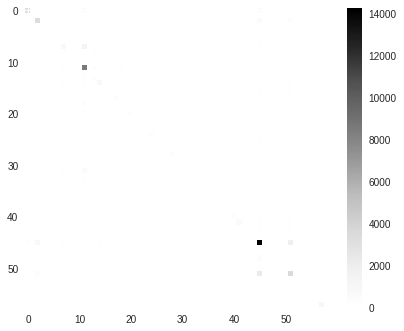

<Figure size 576x396 with 0 Axes>

In [23]:
# Create dict to convert y vectors back to strings
vec_to_string = {}
for key in one_hot_encoding_dic.keys():
    vec_to_string[one_hot_encoding_dic[key].argmax()] = key

y_pred_strings = []
for vec in y_pred:
    y_pred_strings.append(vec_to_string[vec.argmax()])

y_test_strings = []
for vec in y_test:
    y_test_strings.append(vec_to_string[vec.argmax()])
    
cm = confusion_matrix(y_test_strings,y_pred_strings, labels=one_hot_encoding_dic.keys())
brAccuracy = float(cm[brConfusionMatrixIndex][brConfusionMatrixIndex] )/ float(brTotal)
bfAccuracy = float(cm[bfConfusionMatrixIndex][bfConfusionMatrixIndex]) / float(bfTotal)
sdAccuracy = float(cm[sdConfusionMatrixIndex][sdConfusionMatrixIndex]) / float(sdTotal)
print(f"br Accuracy: {brAccuracy}, bf accuracy: {bfAccuracy},sd Accuracy: {sdAccuracy} ")
print(f"Overall accuracy: {np.diag(cm).sum()*100.0 / len(y_test)}")

brCommonMistakes = cm[brConfusionMatrixIndex]
brTop5MistakesIndices = brCommonMistakes.argsort()[-5:]
print("The br was most commonly confused with: ")
for index in brTop5MistakesIndices:
  if index == brConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])

bfCommonMistakes = cm[bfConfusionMatrixIndex]
bfTop5MistakesIndices = bfCommonMistakes.argsort()[-5:]
print("The bf was most commonly confused with: ")
for index in bfTop5MistakesIndices:
  if index == bfConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])


# The br and bf sentences are incorrectly labelled as "b", "qw" and sv most commonly. 
# I think this is because they are some of the most common classes in the dataset.
# The 0% accuracy for bf was concerning so i decided to plot thw whole confusion matrix to see what was happening
# The confusion matrix is mostly light with a small number of dark dots. These are the classes it tries to classify
# This indicates that the large class imbalance has caused the model to only output a small number of classes rather than the full range
# It simply accepts it will get the other classes wrong as it is still able to achieve good (>60%) accuracy without using them
plt.imshow(cm)
plt.colorbar()

plt.show()

plt.savefig("/content/gdrive/My Drive/confusionmatrix.png")


In addition to overall accuracy, you need to look at the accuracy of some minority classes. Signal-non-understanding ('br') is a good indicator of "other-repair" or cases in which the other conversational participant attempts to repair the speaker's error. Summarize/reformulate ('bf') has been used in dialogue summarization. Report the accuracy for these classes and some frequent errors you notice the system makes in predicting them. What do you think the reasons are？


As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [0]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
classBalancedWeightsFilePath = "/content/gdrive/My Drive/classBalancedweights.best.hdf5"

In [26]:

classBalancedCheckpoint = ModelCheckpoint(classBalancedWeightsFilePath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
model.fit(train_sentences_X, y_train, batch_size=512, epochs=5, class_weight = d_class_weights, validation_data=(test_sentences_X, y_test), callbacks=[classBalancedCheckpoint])


Train on 167704 samples, validate on 55902 samples
Epoch 1/5
167704/167704 [==============================] - 217s 1ms/step - loss: 1.4445 - acc: 0.4854 - val_loss: 2.0978 - val_acc: 0.4192

Epoch 00001: val_acc improved from -inf to 0.41920, saving model to /content/gdrive/My Drive/classBalancedweights.best.hdf5
Epoch 2/5
167704/167704 [==============================] - 214s 1ms/step - loss: 1.2893 - acc: 0.5047 - val_loss: 2.1708 - val_acc: 0.3957

Epoch 00002: val_acc did not improve from 0.41920
Epoch 3/5
167704/167704 [==============================] - 217s 1ms/step - loss: 1.1835 - acc: 0.5116 - val_loss: 2.1340 - val_acc: 0.4191

Epoch 00003: val_acc did not improve from 0.41920
Epoch 4/5
167704/167704 [==============================] - 217s 1ms/step - loss: 1.1001 - acc: 0.5239 - val_loss: 2.2550 - val_acc: 0.3922

Epoch 00004: val_acc did not improve from 0.41920
Epoch 5/5
167704/167704 [==============================] - 216s 1ms/step - loss: 1.0354 - acc: 0.5321 - val_loss: 2

In [0]:
y_pred = model.predict(test_sentences_X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until


br Accuracy: 0.7659574468085106, bf accuracy: 0.13333333333333333,sd Accuracy: 0.311465113623387 
Overall accuracy: 42.44391971664699
The br was most commonly confused with: 
qrr
fe
%@
%
The bf was most commonly confused with: 
sv
sd
^2
qy^d


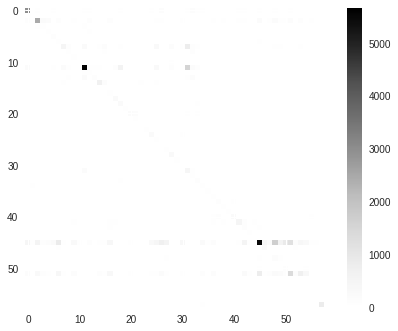

<Figure size 576x396 with 0 Axes>

In [29]:
# Create dict to convert y vectors back to strings
vec_to_string = {}
for key in one_hot_encoding_dic.keys():
    vec_to_string[one_hot_encoding_dic[key].argmax()] = key

y_pred_strings = []
for vec in y_pred:
    y_pred_strings.append(vec_to_string[vec.argmax()])

y_test_strings = []
for vec in y_test:
    y_test_strings.append(vec_to_string[vec.argmax()])
    
cm = confusion_matrix(y_test_strings,y_pred_strings, labels=one_hot_encoding_dic.keys())
brAccuracy = float(cm[brConfusionMatrixIndex][brConfusionMatrixIndex] )/ float(brTotal)
bfAccuracy = float(cm[bfConfusionMatrixIndex][bfConfusionMatrixIndex]) / float(bfTotal)
sdAccuracy = float(cm[sdConfusionMatrixIndex][sdConfusionMatrixIndex]) / float(sdTotal)
print(f"br Accuracy: {brAccuracy}, bf accuracy: {bfAccuracy},sd Accuracy: {sdAccuracy} ")
print(f"Overall accuracy: {np.diag(cm).sum()*100.0 / len(y_test)}")

brCommonMistakes = cm[brConfusionMatrixIndex]
brTop5MistakesIndices = brCommonMistakes.argsort()[-5:]
print("The br was most commonly confused with: ")
for index in brTop5MistakesIndices:
  if index == brConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])

bfCommonMistakes = cm[bfConfusionMatrixIndex]
bfTop5MistakesIndices = bfCommonMistakes.argsort()[-5:]
print("The bf was most commonly confused with: ")
for index in bfTop5MistakesIndices:
  if index == bfConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])


# The br and bf sentences are incorrectly labelled as "%" and "qy^d" most commonly. 
# We can see from teh confusion matrix has spread out more and has a lower peak. 
# This indicates that the class weighting, has resulted in the model predicting a broader range of classes
# The BR accuracy and BF accuracy increased as a result of the class weighting, however the overall accuracy decreases. 
# The class weighting might be better than non-weighted depending on the application of the model you are building
# An alternative way to handle imbalanced classes is to artificially balance them, e.g. sample the data so there is a more balanced class distribution

plt.imshow(cm)
plt.colorbar()

plt.show()

plt.savefig("/content/gdrive/My Drive/confusionmatrixClassBalanced.png")

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

##Using Context for Dialog Act Classification
We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each sentence for DA classification. Here, we use bidirectional-LSTM (BLSTM) to learn the context before and after the current sentence. The left-to-right LSTM output and the one from the reverse direction are concatenated and input to a hidden layer for classification.

Functions for creating weights and biases.

In [0]:
def weights_init(shape):
    return tf.Variable(tf.truncated_normal(shape=shape, stddev=0.05))

In [0]:
def bias_init(shape):
    return tf.Variable(tf.zeros(shape=shape))


 This is classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN.
    
      Input(s): 
              input - word_embedings
              filter_size - size of width and height of the Conv kernel
              number_of_channels - in this case it is always 1
              number_of_filters - how many representation of the input utterance are we going to output from this layer 
              strides - how many does kernel move to the side and up/down
              activation - a activation function
              max_pool - boolean value which will trigger a max_pool operation on the output tensor
      Output(s): 
               text_conv layer
    

In [0]:
def text_conv(input, filter_size, number_of_channels, number_of_filters, strides=(1, 1), activation=tf.nn.relu, max_pool=True):
    #print('Conv')
    #print(input)
    #print(filter_size)
    #print('conv end')
    weights = weights_init([filter_size, filter_size, number_of_channels, number_of_filters])
    print(tf.shape(input))
    bias = bias_init([number_of_filters])
    print('bias done')
    layer = tf.nn.conv2d(input, filter=weights, strides=[1, strides[0], strides[1], 1], padding='SAME')
    print('done')
    if activation != None:
        layer = activation(layer)
    print('this works')
    if max_pool:
        layer = tf.nn.max_pool(layer, ksize=[1, 2, 2 ,1], strides=[1, 2, 2, 1], padding='SAME')
    
    return layer

    This method is used to create LSTM layer. And the data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You can create a BiLSTM by modifying this.
    
    Input(s): lstm_cell_unitis - used to define the number of units in a LSTM layer
              number_of_layers - used to define how many of LSTM layers do we want in the network
              batch_size - in this method this information is used to build starting state for the network
              dropout_rate - used to define how many cells in a layer do we want to 'turn off'
              
    Output(s): cell - lstm layer
               init_state - zero vectors used as a starting state for the network

In [0]:
def lstm_layer(lstm_size, number_of_layers, batch_size, dropout_rate):

    def cell(size, dropout_rate=None):
        layer = tf.contrib.rnn.BasicLSTMCell(lstm_size)
        
        return tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
            
    cell = tf.contrib.rnn.MultiRNNCell([cell(lstm_size, dropout_rate) for _ in range(number_of_layers)])
    
    init_state = cell.zero_state(batch_size, tf.float32)
    return cell, init_state

    Use to transform/reshape conv output to 2d matrix, if it's necessary
    
    Input(s): Layer - text_cnn layer
              batch_size - how many samples do we feed at once
              seq_len - number of time steps
              
    Output(s): reshaped_layer - the layer with new shape
               number_of_elements - this param is used as a in_size for next layer

In [0]:
def flatten(layer, batch_size, seq_len):

    dims = layer.get_shape()
    number_of_elements = dims[2:].num_elements()
    
    reshaped_layer = tf.reshape(layer, [batch_size, int(seq_len/2), number_of_elements])
    return reshaped_layer, number_of_elements

    Output layer for the lstm netowrk
    
    Input(s): lstm_outputs - outputs from the RNN part of the network
              input_size - in this case it is RNN size (number of neuros in RNN layer)
              output_size - number of neuros for the output layer == number of classes
              
    Output(s) - logits, 

In [0]:
def dense_layer(input, in_size, out_size, dropout=False, activation=tf.nn.relu):
  
    weights = weights_init([in_size, out_size])
    bias = bias_init([out_size])
    
    layer = tf.matmul(input, weights) + bias
    
    if activation != None:
        layer = activation(layer)
    
    if dropout:
        layer = tf.nn.dropout(layer, 0.5)
        
    return layer

    Function used to calculate loss and minimize it
    
    Input(s): rnn_out - logits from the fully_connected layer
              targets - targets used to train network
              learning_rate/step_size
    
    
    Output(s): optimizer - optimizer of choice
               loss - calculated loss function

In [0]:
def loss_optimizer(logits, targets, learning_rate ):
    loss =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=targets))
    print(loss)
    print(targets)
    print(logits)

    print(learning_rate)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    return loss, optimizer

To create the model you can use these inputs:     
       
       Input(s): learning_rate/step_size - how fast are we going to find global minima
                  batch_size -  the nuber of samples to feed at once
                  seq_len - the number of timesteps in unrolled RNN
                  vocab_size - the number of nunique words in the vocab
                  embed_size - length of word embed vectors
                  conv_filters - number of filters in output tensor from CNN layer
                  conv_filter_size - height and width of conv kernel
                  number_of_lstm_layers - the number of layers used in the LSTM part of the network
                  lstm_units - the number of neurons/cells in a LSTM layer

In [0]:
class DATagging(object):
    
    def __init__(self, learning_rate=0.001, batch_size=100, seq_len=250, vocab_size=10000, embed_size=300,
                conv_filters=32, conv_filter_size=5, number_of_lstm_layers=1, lstm_units=128):
        
        # Clear tf graph for multiple cell running
        tf.reset_default_graph()
        
        # Create placeholders
        self.inputSentences = tf.placeholder(tf.int32, [batch_size, seq_len], name='inputSentences')
        self.targetLabels= tf.placeholder(tf.float32, [batch_size, numberOfTags], name='targetLabels')    
        self.predictions = []
        
        
        #Embedding layer
        # Initialise word embeddings with random uniform dist
        wordEmbeddings = tf.Variable(tf.random_uniform([vocab_size, embed_size]))
        # Embedding layer
        embeddingLayer = tf.nn.embedding_lookup(wordEmbeddings, self.inputSentences)
        
        # Reshape embedding layer to have a "channel"
        embeddingLayer = tf.expand_dims(embeddingLayer, -1)

        # Conv layer
        number_of_channels = 1
        sentence_embedding = text_conv(embeddingLayer, conv_filter_size,number_of_channels, conv_filters)
        
        # Have to flatten the output of the conv as we don't want tensor of that rank
        flat_sentence_embedding, size = flatten(sentence_embedding, batch_size, seq_len)
        
        # define LSTM cells
        lstm_cell, init_state = lstm_layer(lstm_units, number_of_lstm_layers, batch_size, dropout_rate = 0.3)

        
        # BiLSTM layers
        (outputs,states) = tf.nn.bidirectional_dynamic_rnn(lstm_cell,
                                                       lstm_cell, 
                                                       flat_sentence_embedding,
                                                       dtype=tf.float32)
        
        
        # Need to reshape the outputs to be include only the last output from the sequence, 
        # but every instance in batch and every lstm output
        (forwardOutputs,backwardOutputs) = outputs
        reshapedForward = tf.squeeze(tf.slice(forwardOutputs, [0,0,0],[-1,1,-1]))
        reshapedBackward = tf.squeeze(tf.slice(backwardOutputs, [0,0,0],[-1,1,-1]))
        shapedOutputs = tf.concat([reshapedForward,reshapedBackward], 1)
        
        # Hidden layer, with relu activation as we want it to output word embeddings
        denseLayer = dense_layer(shapedOutputs, lstm_units*2, numberOfTags)
        
        # Calculate the loss and use optimiser to minimise it
        self.loss, self.optimizer = loss_optimizer(denseLayer, self.targetLabels, learning_rate)
        
        # Convert predictions and labels to a single number rather than a onehot endoded vector
        # This makes it easier to work out the accuracy
        predictions = tf.math.argmax(denseLayer, axis = 1)
        labels = tf.argmax(self.targetLabels, axis = 1)
        
        # Calculate the accuracy
        self.accuracy = tf.metrics.accuracy(labels, predictions)[1]
        self.predictions.append(predictions)

In [0]:
def shuffleData(x_train,y_train):
    # Returns a shuffled batch of x and y data
    indices = np.random.permutation(len(x_train))
    x_train_shuffled = x_train[indices]
    y_train_shuffled = y_train[indices]
    return x_train_shuffled, y_train_shuffled


In [42]:
batch_size = 256 # Large batch size used in order to reduce training time

# Insstatiate the model
model2 = DATagging(learning_rate=0.001, 
                     batch_size=batch_size, 
                     seq_len=MAX_LENGTH, 
                     vocab_size=len(wordvectors) + 1, 
                     embed_size=50,
                     conv_filters=32, 
                     conv_filter_size=5, 
                     number_of_lstm_layers=1, 
                     lstm_units=128)

# Create a tensorflow session and initialise all the required variables
session = tf.Session()
session.run(tf.global_variables_initializer())
session.run(tf.local_variables_initializer())

# Set epochs to 5 
epochs = 5
for i in range(epochs):
    epoch_loss = []
    train_accuracy = []
    
    # tqdm provides a progress bar
    for ii in tqdm(range(0, len(train_sentences_X), batch_size)):
        # I shuffle the data each time, which means this is more similar to stochastic mini-batch
        # This does mean that i'm not guaranteed to back-propagate on all the data instances each time but does add some randomness that could help avoid local minima
        x_train_shuffled, y_train_shuffled = shuffleData(train_sentences_X,y_train)
        X_batch = x_train_shuffled[ii:ii+batch_size]
        y_batch = y_train_shuffled[ii:ii+batch_size]
        if len(y_batch) < batch_size:
            # If we are at the end of the data, take  batch from teh end, 
            # this repeats some data but allows us to use all of it
            X_batch = x_train_shuffled[-batch_size:]
            y_batch = y_train_shuffled[-batch_size:]
        
        # Get results
        c, _, a = session.run([model2.loss, model2.optimizer, model2.accuracy], feed_dict={model2.inputSentences:X_batch, 
                                                                             model2.targetLabels:y_batch})
        # Record results
        print(f"Accuracy: {a}")
        epoch_loss.append(c)
        train_accuracy.append(a)
        
    
    print("Epoch: {}/{}".format(i, epochs), " | Epoch loss: {}".format(np.mean(epoch_loss)), 
          " | Mean train accuracy: {}".format(np.mean(train_accuracy)))

Tensor("Shape:0", shape=(4,), dtype=int32)
bias done
done
this works
Tensor("Mean:0", shape=(), dtype=float32)
Tensor("targetLabels:0", shape=(256, 58), dtype=float32)
Tensor("Relu_1:0", shape=(256, 58), dtype=float32)
0.001


  0%|          | 1/656 [00:00<07:17,  1.50it/s]

Accuracy: 0.00390625


  0%|          | 2/656 [00:01<06:15,  1.74it/s]

Accuracy: 0.072265625


  0%|          | 3/656 [00:01<05:27,  1.99it/s]

Accuracy: 0.1640625


  1%|          | 4/656 [00:01<04:50,  2.25it/s]

Accuracy: 0.1953125


  1%|          | 5/656 [00:01<04:24,  2.46it/s]

Accuracy: 0.21562500298023224


  1%|          | 6/656 [00:02<04:04,  2.66it/s]

Accuracy: 0.2311197966337204


  1%|          | 7/656 [00:02<03:50,  2.82it/s]

Accuracy: 0.2360491007566452


  1%|          | 8/656 [00:02<03:42,  2.91it/s]

Accuracy: 0.23876953125


  1%|▏         | 9/656 [00:03<03:34,  3.02it/s]

Accuracy: 0.2482638955116272


  2%|▏         | 10/656 [00:03<03:27,  3.11it/s]

Accuracy: 0.25507813692092896


  2%|▏         | 11/656 [00:03<03:25,  3.15it/s]

Accuracy: 0.2563920319080353


  2%|▏         | 12/656 [00:04<03:22,  3.18it/s]

Accuracy: 0.2610677182674408


  2%|▏         | 13/656 [00:04<03:20,  3.21it/s]

Accuracy: 0.2650240361690521


  2%|▏         | 14/656 [00:04<03:19,  3.22it/s]

Accuracy: 0.2672991156578064


  2%|▏         | 15/656 [00:05<03:20,  3.19it/s]

Accuracy: 0.26640623807907104


  2%|▏         | 16/656 [00:05<03:20,  3.19it/s]

Accuracy: 0.268798828125


  3%|▎         | 17/656 [00:05<03:18,  3.21it/s]

Accuracy: 0.26838234066963196


  3%|▎         | 18/656 [00:06<03:20,  3.18it/s]

Accuracy: 0.2703993022441864


  3%|▎         | 19/656 [00:06<03:18,  3.20it/s]

Accuracy: 0.2719983458518982


  3%|▎         | 20/656 [00:06<03:17,  3.22it/s]

Accuracy: 0.2699218690395355


  3%|▎         | 21/656 [00:06<03:17,  3.21it/s]

Accuracy: 0.2702752947807312


  3%|▎         | 22/656 [00:07<03:16,  3.22it/s]

Accuracy: 0.2691761255264282


  4%|▎         | 23/656 [00:07<03:16,  3.22it/s]

Accuracy: 0.2693614065647125


  4%|▎         | 24/656 [00:07<03:15,  3.22it/s]

Accuracy: 0.2688802182674408


  4%|▍         | 25/656 [00:08<03:16,  3.22it/s]

Accuracy: 0.2696875035762787


  4%|▍         | 26/656 [00:08<03:15,  3.23it/s]

Accuracy: 0.2708834111690521


  4%|▍         | 27/656 [00:08<03:14,  3.23it/s]

Accuracy: 0.2725694477558136


  4%|▍         | 28/656 [00:09<03:15,  3.22it/s]

Accuracy: 0.2735770046710968


  4%|▍         | 29/656 [00:09<03:13,  3.25it/s]

Accuracy: 0.2727639973163605


  5%|▍         | 30/656 [00:09<03:13,  3.24it/s]

Accuracy: 0.2751302123069763


  5%|▍         | 31/656 [00:10<03:12,  3.24it/s]

Accuracy: 0.2774697542190552


  5%|▍         | 32/656 [00:10<03:12,  3.24it/s]

Accuracy: 0.27880859375


  5%|▌         | 33/656 [00:10<03:12,  3.23it/s]

Accuracy: 0.28006628155708313


  5%|▌         | 34/656 [00:10<03:10,  3.26it/s]

Accuracy: 0.2819393277168274


  5%|▌         | 35/656 [00:11<03:09,  3.27it/s]

Accuracy: 0.2844866216182709


  5%|▌         | 36/656 [00:11<03:09,  3.27it/s]

Accuracy: 0.2849392294883728


  6%|▌         | 37/656 [00:11<03:09,  3.26it/s]

Accuracy: 0.2871621549129486


  6%|▌         | 38/656 [00:12<03:11,  3.23it/s]

Accuracy: 0.28916528820991516


  6%|▌         | 39/656 [00:12<03:10,  3.23it/s]

Accuracy: 0.29156652092933655


  6%|▌         | 40/656 [00:12<03:10,  3.24it/s]

Accuracy: 0.2948242127895355


  6%|▋         | 41/656 [00:13<03:08,  3.26it/s]

Accuracy: 0.2974466383457184


  6%|▋         | 42/656 [00:13<03:07,  3.27it/s]

Accuracy: 0.3014322817325592


  7%|▋         | 43/656 [00:13<03:07,  3.27it/s]

Accuracy: 0.3045966625213623


  7%|▋         | 44/656 [00:14<03:08,  3.25it/s]

Accuracy: 0.306640625


  7%|▋         | 45/656 [00:14<03:08,  3.24it/s]

Accuracy: 0.3092013895511627


  7%|▋         | 46/656 [00:14<03:07,  3.24it/s]

Accuracy: 0.31063178181648254


  7%|▋         | 47/656 [00:14<03:07,  3.25it/s]

Accuracy: 0.3135804533958435


  7%|▋         | 48/656 [00:15<03:08,  3.23it/s]

Accuracy: 0.3158365786075592


  7%|▋         | 49/656 [00:15<03:07,  3.24it/s]

Accuracy: 0.31728315353393555


  8%|▊         | 50/656 [00:15<03:06,  3.24it/s]

Accuracy: 0.3199218809604645


  8%|▊         | 51/656 [00:16<03:07,  3.24it/s]

Accuracy: 0.32176777720451355


  8%|▊         | 52/656 [00:16<03:06,  3.24it/s]

Accuracy: 0.3237680196762085


  8%|▊         | 53/656 [00:16<03:06,  3.24it/s]

Accuracy: 0.3259139060974121


  8%|▊         | 54/656 [00:17<03:06,  3.22it/s]

Accuracy: 0.3279079794883728


  8%|▊         | 55/656 [00:17<03:06,  3.22it/s]

Accuracy: 0.3296875059604645


  9%|▊         | 56/656 [00:17<03:05,  3.24it/s]

Accuracy: 0.3316127359867096


  9%|▊         | 57/656 [00:18<03:04,  3.24it/s]

Accuracy: 0.3330592215061188


  9%|▉         | 58/656 [00:18<03:06,  3.21it/s]

Accuracy: 0.33459052443504333


  9%|▉         | 59/656 [00:18<03:04,  3.24it/s]

Accuracy: 0.33600372076034546


  9%|▉         | 60/656 [00:18<03:03,  3.25it/s]

Accuracy: 0.33769530057907104


  9%|▉         | 61/656 [00:19<03:03,  3.24it/s]

Accuracy: 0.3397156894207001


  9%|▉         | 62/656 [00:19<03:03,  3.24it/s]

Accuracy: 0.3419228792190552


 10%|▉         | 63/656 [00:19<03:02,  3.25it/s]

Accuracy: 0.3439980149269104


 10%|▉         | 64/656 [00:20<03:02,  3.25it/s]

Accuracy: 0.34503173828125


 10%|▉         | 65/656 [00:20<03:03,  3.23it/s]

Accuracy: 0.3462139368057251


 10%|█         | 66/656 [00:20<03:02,  3.24it/s]

Accuracy: 0.3478338122367859


 10%|█         | 67/656 [00:21<03:01,  3.25it/s]

Accuracy: 0.34882229566574097


 10%|█         | 68/656 [00:21<03:01,  3.24it/s]

Accuracy: 0.3499540388584137


 11%|█         | 69/656 [00:21<03:00,  3.26it/s]

Accuracy: 0.35167571902275085


 11%|█         | 70/656 [00:22<03:00,  3.25it/s]

Accuracy: 0.35345983505249023


 11%|█         | 71/656 [00:22<02:59,  3.26it/s]

Accuracy: 0.35530370473861694


 11%|█         | 72/656 [00:22<02:58,  3.26it/s]

Accuracy: 0.3572591245174408


 11%|█         | 73/656 [00:22<02:57,  3.28it/s]

Accuracy: 0.3579837381839752


 11%|█▏        | 74/656 [00:23<02:58,  3.26it/s]

Accuracy: 0.35985007882118225


 11%|█▏        | 75/656 [00:23<02:58,  3.25it/s]

Accuracy: 0.3608333468437195


 12%|█▏        | 76/656 [00:23<02:58,  3.25it/s]

Accuracy: 0.36143091320991516


 12%|█▏        | 77/656 [00:24<02:58,  3.25it/s]

Accuracy: 0.36257103085517883


 12%|█▏        | 78/656 [00:24<02:59,  3.22it/s]

Accuracy: 0.36328125


 12%|█▏        | 79/656 [00:24<02:57,  3.26it/s]

Accuracy: 0.3642207384109497


 12%|█▏        | 80/656 [00:25<02:56,  3.27it/s]

Accuracy: 0.3645996153354645


 12%|█▏        | 81/656 [00:25<02:56,  3.26it/s]

Accuracy: 0.3658371865749359


 12%|█▎        | 82/656 [00:25<02:56,  3.25it/s]

Accuracy: 0.3674733340740204


 13%|█▎        | 83/656 [00:26<02:55,  3.27it/s]

Accuracy: 0.36845821142196655


 13%|█▎        | 84/656 [00:26<02:55,  3.25it/s]

Accuracy: 0.3696986734867096


 13%|█▎        | 85/656 [00:26<02:56,  3.24it/s]

Accuracy: 0.3709099292755127


 13%|█▎        | 86/656 [00:26<02:55,  3.25it/s]

Accuracy: 0.3717750608921051


 13%|█▎        | 87/656 [00:27<02:54,  3.26it/s]

Accuracy: 0.3734285235404968


 13%|█▎        | 88/656 [00:27<02:55,  3.24it/s]

Accuracy: 0.37362393736839294


 14%|█▎        | 89/656 [00:27<02:54,  3.25it/s]

Accuracy: 0.3750438988208771


 14%|█▎        | 90/656 [00:28<02:53,  3.27it/s]

Accuracy: 0.3756510317325592


 14%|█▍        | 91/656 [00:28<02:53,  3.27it/s]

Accuracy: 0.37658825516700745


 14%|█▍        | 92/656 [00:28<02:53,  3.25it/s]

Accuracy: 0.37746262550354004


 14%|█▍        | 93/656 [00:29<02:52,  3.25it/s]

Accuracy: 0.3778141736984253


 14%|█▍        | 94/656 [00:29<02:52,  3.26it/s]

Accuracy: 0.37749335169792175


 14%|█▍        | 95/656 [00:29<02:53,  3.24it/s]

Accuracy: 0.3784128427505493


 15%|█▍        | 96/656 [00:30<02:52,  3.24it/s]

Accuracy: 0.3798014223575592


 15%|█▍        | 97/656 [00:30<02:51,  3.25it/s]

Accuracy: 0.3805573582649231


 15%|█▍        | 98/656 [00:30<02:53,  3.22it/s]

Accuracy: 0.3816964328289032


 15%|█▌        | 99/656 [00:30<02:51,  3.25it/s]

Accuracy: 0.3826941251754761


 15%|█▌        | 100/656 [00:31<02:50,  3.26it/s]

Accuracy: 0.38304686546325684


 15%|█▌        | 101/656 [00:31<02:51,  3.24it/s]

Accuracy: 0.3840501308441162


 16%|█▌        | 102/656 [00:31<02:50,  3.24it/s]

Accuracy: 0.3848422169685364


 16%|█▌        | 103/656 [00:32<02:49,  3.25it/s]

Accuracy: 0.38520175218582153


 16%|█▌        | 104/656 [00:32<02:49,  3.26it/s]

Accuracy: 0.38638070225715637


 16%|█▌        | 105/656 [00:32<02:49,  3.24it/s]

Accuracy: 0.38686755299568176


 16%|█▌        | 106/656 [00:33<02:49,  3.24it/s]

Accuracy: 0.38756632804870605


 16%|█▋        | 107/656 [00:33<02:50,  3.23it/s]

Accuracy: 0.38814252614974976


 16%|█▋        | 108/656 [00:33<02:51,  3.20it/s]

Accuracy: 0.38903355598449707


 17%|█▋        | 109/656 [00:34<02:50,  3.20it/s]

Accuracy: 0.3895857334136963


 17%|█▋        | 110/656 [00:34<02:49,  3.22it/s]

Accuracy: 0.3902343809604645


 17%|█▋        | 111/656 [00:34<02:48,  3.24it/s]

Accuracy: 0.3911176919937134


 17%|█▋        | 112/656 [00:34<02:47,  3.24it/s]

Accuracy: 0.3919503390789032


 17%|█▋        | 113/656 [00:35<02:47,  3.24it/s]

Accuracy: 0.39283737540245056


 17%|█▋        | 114/656 [00:35<02:46,  3.26it/s]

Accuracy: 0.39346903562545776


 18%|█▊        | 115/656 [00:35<02:46,  3.25it/s]

Accuracy: 0.39419156312942505


 18%|█▊        | 116/656 [00:36<02:46,  3.24it/s]

Accuracy: 0.39476698637008667


 18%|█▊        | 117/656 [00:36<02:45,  3.26it/s]

Accuracy: 0.39533254504203796


 18%|█▊        | 118/656 [00:36<02:45,  3.25it/s]

Accuracy: 0.39592161774635315


 18%|█▊        | 119/656 [00:37<02:45,  3.25it/s]

Accuracy: 0.3964351415634155


 18%|█▊        | 120/656 [00:37<02:44,  3.26it/s]

Accuracy: 0.39700520038604736


 18%|█▊        | 121/656 [00:37<02:43,  3.26it/s]

Accuracy: 0.3969847559928894


 19%|█▊        | 122/656 [00:38<02:43,  3.27it/s]

Accuracy: 0.39722079038619995


 19%|█▉        | 123/656 [00:38<02:43,  3.27it/s]

Accuracy: 0.39777058362960815


 19%|█▉        | 124/656 [00:38<02:42,  3.26it/s]

Accuracy: 0.3985320031642914


 19%|█▉        | 125/656 [00:38<02:43,  3.25it/s]

Accuracy: 0.39899998903274536


 19%|█▉        | 126/656 [00:39<02:43,  3.25it/s]

Accuracy: 0.3997395932674408


 19%|█▉        | 127/656 [00:39<02:42,  3.26it/s]

Accuracy: 0.40080586075782776


 20%|█▉        | 128/656 [00:39<02:43,  3.23it/s]

Accuracy: 0.401153564453125


 20%|█▉        | 129/656 [00:40<02:42,  3.24it/s]

Accuracy: 0.40176841616630554


 20%|█▉        | 130/656 [00:40<02:42,  3.24it/s]

Accuracy: 0.40201321244239807


 20%|█▉        | 131/656 [00:40<02:41,  3.26it/s]

Accuracy: 0.40234375


 20%|██        | 132/656 [00:41<02:41,  3.25it/s]

Accuracy: 0.4029947817325592


 20%|██        | 133/656 [00:41<02:40,  3.26it/s]

Accuracy: 0.40340107679367065


 20%|██        | 134/656 [00:41<02:40,  3.26it/s]

Accuracy: 0.4042094349861145


 21%|██        | 135/656 [00:42<02:40,  3.25it/s]

Accuracy: 0.4047743082046509


 21%|██        | 136/656 [00:42<02:39,  3.25it/s]

Accuracy: 0.4052734375


 21%|██        | 137/656 [00:42<02:39,  3.25it/s]

Accuracy: 0.40599337220191956


 21%|██        | 138/656 [00:42<02:39,  3.24it/s]

Accuracy: 0.4060518443584442


 21%|██        | 139/656 [00:43<02:38,  3.26it/s]

Accuracy: 0.40684014558792114


 21%|██▏       | 140/656 [00:43<02:38,  3.26it/s]

Accuracy: 0.40786829590797424


 21%|██▏       | 141/656 [00:43<02:37,  3.27it/s]

Accuracy: 0.40843862295150757


 22%|██▏       | 142/656 [00:44<02:36,  3.28it/s]

Accuracy: 0.4089183509349823


 22%|██▏       | 143/656 [00:44<02:36,  3.27it/s]

Accuracy: 0.4094187021255493


 22%|██▏       | 144/656 [00:44<02:36,  3.28it/s]

Accuracy: 0.4097222089767456


 22%|██▏       | 145/656 [00:45<02:35,  3.28it/s]

Accuracy: 0.4106142222881317


 22%|██▏       | 146/656 [00:45<02:35,  3.28it/s]

Accuracy: 0.41157427430152893


 22%|██▏       | 147/656 [00:45<02:35,  3.27it/s]

Accuracy: 0.41236183047294617


 23%|██▎       | 148/656 [00:46<02:37,  3.23it/s]

Accuracy: 0.4129539728164673


 23%|██▎       | 149/656 [00:46<02:35,  3.26it/s]

Accuracy: 0.41359061002731323


 23%|██▎       | 150/656 [00:46<02:35,  3.26it/s]

Accuracy: 0.4143750071525574


 23%|██▎       | 151/656 [00:46<02:34,  3.26it/s]

Accuracy: 0.4151231348514557


 23%|██▎       | 152/656 [00:47<02:34,  3.26it/s]

Accuracy: 0.4158100187778473


 23%|██▎       | 153/656 [00:47<02:34,  3.27it/s]

Accuracy: 0.4164879620075226


 23%|██▎       | 154/656 [00:47<02:34,  3.26it/s]

Accuracy: 0.41715705394744873


 24%|██▎       | 155/656 [00:48<02:33,  3.26it/s]

Accuracy: 0.41771674156188965


 24%|██▍       | 156/656 [00:48<02:32,  3.27it/s]

Accuracy: 0.41851964592933655


 24%|██▍       | 157/656 [00:48<02:32,  3.27it/s]

Accuracy: 0.41901373863220215


 24%|██▍       | 158/656 [00:49<02:34,  3.22it/s]

Accuracy: 0.41979825496673584


 24%|██▍       | 159/656 [00:49<02:32,  3.25it/s]

Accuracy: 0.41986045241355896


 24%|██▍       | 160/656 [00:49<02:32,  3.26it/s]

Accuracy: 0.4205322265625


 25%|██▍       | 161/656 [00:50<02:31,  3.27it/s]

Accuracy: 0.4214625358581543


 25%|██▍       | 162/656 [00:50<02:31,  3.27it/s]

Accuracy: 0.4219955503940582


 25%|██▍       | 163/656 [00:50<02:30,  3.27it/s]

Accuracy: 0.422378271818161


 25%|██▌       | 164/656 [00:50<02:30,  3.26it/s]

Accuracy: 0.4226610064506531


 25%|██▌       | 165/656 [00:51<02:31,  3.25it/s]

Accuracy: 0.4235321879386902


 25%|██▌       | 166/656 [00:51<02:29,  3.27it/s]

Accuracy: 0.42401638627052307


 25%|██▌       | 167/656 [00:51<02:29,  3.26it/s]

Accuracy: 0.425056129693985


 26%|██▌       | 168/656 [00:52<02:31,  3.21it/s]

Accuracy: 0.4258277416229248


 26%|██▌       | 169/656 [00:52<02:31,  3.22it/s]

Accuracy: 0.4265440106391907


 26%|██▌       | 170/656 [00:52<02:30,  3.24it/s]

Accuracy: 0.4268842041492462


 26%|██▌       | 171/656 [00:53<02:29,  3.25it/s]

Accuracy: 0.42726609110832214


 26%|██▌       | 172/656 [00:53<02:28,  3.26it/s]

Accuracy: 0.4278252124786377


 26%|██▋       | 173/656 [00:53<02:27,  3.27it/s]

Accuracy: 0.42815208435058594


 27%|██▋       | 174/656 [00:54<02:28,  3.25it/s]

Accuracy: 0.42872217297554016


 27%|██▋       | 175/656 [00:54<02:29,  3.21it/s]

Accuracy: 0.4291294515132904


 27%|██▋       | 176/656 [00:54<02:28,  3.24it/s]

Accuracy: 0.4297984838485718


 27%|██▋       | 177/656 [00:54<02:27,  3.24it/s]

Accuracy: 0.4302171468734741


 27%|██▋       | 178/656 [00:55<02:28,  3.21it/s]

Accuracy: 0.43093836307525635


 27%|██▋       | 179/656 [00:55<02:27,  3.24it/s]

Accuracy: 0.4312587380409241


 27%|██▋       | 180/656 [00:55<02:26,  3.24it/s]

Accuracy: 0.43177083134651184


 28%|██▊       | 181/656 [00:56<02:26,  3.24it/s]

Accuracy: 0.43242835998535156


 28%|██▊       | 182/656 [00:56<02:25,  3.26it/s]

Accuracy: 0.4331001043319702


 28%|██▊       | 183/656 [00:56<02:25,  3.25it/s]

Accuracy: 0.4337858557701111


 28%|██▊       | 184/656 [00:57<02:24,  3.27it/s]

Accuracy: 0.4347401559352875


 28%|██▊       | 185/656 [00:57<02:24,  3.26it/s]

Accuracy: 0.4351562559604645


 28%|██▊       | 186/656 [00:57<02:24,  3.26it/s]

Accuracy: 0.4359669089317322


 29%|██▊       | 187/656 [00:58<02:23,  3.27it/s]

Accuracy: 0.43637198209762573


 29%|██▊       | 188/656 [00:58<02:24,  3.23it/s]

Accuracy: 0.4368351101875305


 29%|██▉       | 189/656 [00:58<02:24,  3.24it/s]

Accuracy: 0.43745866417884827


 29%|██▉       | 190/656 [00:58<02:23,  3.26it/s]

Accuracy: 0.4380139708518982


 29%|██▉       | 191/656 [00:59<02:22,  3.26it/s]

Accuracy: 0.4384407699108124


 29%|██▉       | 192/656 [00:59<02:22,  3.27it/s]

Accuracy: 0.4384765625


 29%|██▉       | 193/656 [00:59<02:21,  3.28it/s]

Accuracy: 0.439078688621521


 30%|██▉       | 194/656 [01:00<02:20,  3.28it/s]

Accuracy: 0.4393121898174286


 30%|██▉       | 195/656 [01:00<02:21,  3.27it/s]

Accuracy: 0.43966346979141235


 30%|██▉       | 196/656 [01:00<02:21,  3.26it/s]

Accuracy: 0.44013074040412903


 30%|███       | 197/656 [01:01<02:20,  3.26it/s]

Accuracy: 0.4405139684677124


 30%|███       | 198/656 [01:01<02:21,  3.23it/s]

Accuracy: 0.4408341348171234


 30%|███       | 199/656 [01:01<02:20,  3.24it/s]

Accuracy: 0.44117069244384766


 30%|███       | 200/656 [01:02<02:20,  3.25it/s]

Accuracy: 0.4415039122104645


 31%|███       | 201/656 [01:02<02:18,  3.28it/s]

Accuracy: 0.44210588932037354


 31%|███       | 202/656 [01:02<02:18,  3.27it/s]

Accuracy: 0.4426438808441162


 31%|███       | 203/656 [01:02<02:18,  3.28it/s]

Accuracy: 0.44313809275627136


 31%|███       | 204/656 [01:03<02:17,  3.28it/s]

Accuracy: 0.4433019161224365


 31%|███▏      | 205/656 [01:03<02:18,  3.26it/s]

Accuracy: 0.44388338923454285


 31%|███▏      | 206/656 [01:03<02:18,  3.24it/s]

Accuracy: 0.4444591999053955


 32%|███▏      | 207/656 [01:04<02:17,  3.26it/s]

Accuracy: 0.4448407292366028


 32%|███▏      | 208/656 [01:04<02:19,  3.22it/s]

Accuracy: 0.4453876316547394


 32%|███▏      | 209/656 [01:04<02:18,  3.23it/s]

Accuracy: 0.44591057300567627


 32%|███▏      | 210/656 [01:05<02:17,  3.24it/s]

Accuracy: 0.4461681544780731


 32%|███▏      | 211/656 [01:05<02:16,  3.26it/s]

Accuracy: 0.4467009902000427


 32%|███▏      | 212/656 [01:05<02:15,  3.27it/s]

Accuracy: 0.44713664054870605


 32%|███▏      | 213/656 [01:06<02:16,  3.24it/s]

Accuracy: 0.44743984937667847


 33%|███▎      | 214/656 [01:06<02:17,  3.22it/s]

Accuracy: 0.44784975051879883


 33%|███▎      | 215/656 [01:06<02:16,  3.22it/s]

Accuracy: 0.4482012987136841


 33%|███▎      | 216/656 [01:06<02:16,  3.22it/s]

Accuracy: 0.44874855875968933


 33%|███▎      | 217/656 [01:07<02:16,  3.23it/s]

Accuracy: 0.4490927457809448


 33%|███▎      | 218/656 [01:07<02:15,  3.22it/s]

Accuracy: 0.4494516849517822


 33%|███▎      | 219/656 [01:07<02:15,  3.23it/s]

Accuracy: 0.44989654421806335


 34%|███▎      | 220/656 [01:08<02:15,  3.23it/s]

Accuracy: 0.4503551125526428


 34%|███▎      | 221/656 [01:08<02:14,  3.24it/s]

Accuracy: 0.4508095383644104


 34%|███▍      | 222/656 [01:08<02:13,  3.25it/s]

Accuracy: 0.4512246549129486


 34%|███▍      | 223/656 [01:09<02:13,  3.24it/s]

Accuracy: 0.45158353447914124


 34%|███▍      | 224/656 [01:09<02:12,  3.25it/s]

Accuracy: 0.4517299234867096


 34%|███▍      | 225/656 [01:09<02:12,  3.24it/s]

Accuracy: 0.45249998569488525


 34%|███▍      | 226/656 [01:10<02:12,  3.25it/s]

Accuracy: 0.45281389355659485


 35%|███▍      | 227/656 [01:10<02:11,  3.26it/s]

Accuracy: 0.45295292139053345


 35%|███▍      | 228/656 [01:10<02:12,  3.23it/s]

Accuracy: 0.45303934812545776


 35%|███▍      | 229/656 [01:10<02:11,  3.25it/s]

Accuracy: 0.45353439450263977


 35%|███▌      | 230/656 [01:11<02:11,  3.25it/s]

Accuracy: 0.453991174697876


 35%|███▌      | 231/656 [01:11<02:10,  3.26it/s]

Accuracy: 0.4543594419956207


 35%|███▌      | 232/656 [01:11<02:10,  3.26it/s]

Accuracy: 0.45484238862991333


 36%|███▌      | 233/656 [01:12<02:09,  3.26it/s]

Accuracy: 0.45530444383621216


 36%|███▌      | 234/656 [01:12<02:09,  3.26it/s]

Accuracy: 0.4559127986431122


 36%|███▌      | 235/656 [01:12<02:08,  3.26it/s]

Accuracy: 0.4562333822250366


 36%|███▌      | 236/656 [01:13<02:09,  3.25it/s]

Accuracy: 0.4563857316970825


 36%|███▌      | 237/656 [01:13<02:09,  3.24it/s]

Accuracy: 0.4566192030906677


 36%|███▋      | 238/656 [01:13<02:09,  3.24it/s]

Accuracy: 0.4570804834365845


 36%|███▋      | 239/656 [01:14<02:07,  3.27it/s]

Accuracy: 0.45739081501960754


 37%|███▋      | 240/656 [01:14<02:07,  3.27it/s]

Accuracy: 0.45795899629592896


 37%|███▋      | 241/656 [01:14<02:07,  3.26it/s]

Accuracy: 0.4583117365837097


 37%|███▋      | 242/656 [01:14<02:06,  3.27it/s]

Accuracy: 0.4583548605442047


 37%|███▋      | 243/656 [01:15<02:07,  3.25it/s]

Accuracy: 0.4587191343307495


 37%|███▋      | 244/656 [01:15<02:06,  3.25it/s]

Accuracy: 0.458984375


 37%|███▋      | 245/656 [01:15<02:06,  3.25it/s]

Accuracy: 0.4594706594944


 38%|███▊      | 246/656 [01:16<02:05,  3.27it/s]

Accuracy: 0.4598894715309143


 38%|███▊      | 247/656 [01:16<02:05,  3.26it/s]

Accuracy: 0.46032071113586426


 38%|███▊      | 248/656 [01:16<02:06,  3.23it/s]

Accuracy: 0.46062248945236206


 38%|███▊      | 249/656 [01:17<02:05,  3.25it/s]

Accuracy: 0.46112576127052307


 38%|███▊      | 250/656 [01:17<02:04,  3.27it/s]

Accuracy: 0.46131250262260437


 38%|███▊      | 251/656 [01:17<02:03,  3.27it/s]

Accuracy: 0.4617311954498291


 38%|███▊      | 252/656 [01:18<02:03,  3.27it/s]

Accuracy: 0.462177574634552


 39%|███▊      | 253/656 [01:18<02:02,  3.28it/s]

Accuracy: 0.4625895619392395


 39%|███▊      | 254/656 [01:18<02:02,  3.27it/s]

Accuracy: 0.4630136489868164


 39%|███▉      | 255/656 [01:18<02:02,  3.27it/s]

Accuracy: 0.4633578360080719


 39%|███▉      | 256/656 [01:19<02:02,  3.27it/s]

Accuracy: 0.4636993408203125


 39%|███▉      | 257/656 [01:19<02:01,  3.29it/s]

Accuracy: 0.4639773964881897


 39%|███▉      | 258/656 [01:19<02:02,  3.24it/s]

Accuracy: 0.4641624391078949


 39%|███▉      | 259/656 [01:20<02:02,  3.25it/s]

Accuracy: 0.46464768052101135


 40%|███▉      | 260/656 [01:20<02:01,  3.27it/s]

Accuracy: 0.4647986888885498


 40%|███▉      | 261/656 [01:20<02:00,  3.27it/s]

Accuracy: 0.46524783968925476


 40%|███▉      | 262/656 [01:21<02:00,  3.26it/s]

Accuracy: 0.4657233953475952


 40%|████      | 263/656 [01:21<02:00,  3.27it/s]

Accuracy: 0.46610623598098755


 40%|████      | 264/656 [01:21<02:00,  3.26it/s]

Accuracy: 0.46639737486839294


 40%|████      | 265/656 [01:21<02:00,  3.25it/s]

Accuracy: 0.4666273593902588


 41%|████      | 266/656 [01:22<01:59,  3.26it/s]

Accuracy: 0.4670318365097046


 41%|████      | 267/656 [01:22<01:58,  3.28it/s]

Accuracy: 0.46743327379226685


 41%|████      | 268/656 [01:22<01:59,  3.26it/s]

Accuracy: 0.4675985276699066


 41%|████      | 269/656 [01:23<01:58,  3.25it/s]

Accuracy: 0.4678351581096649


 41%|████      | 270/656 [01:23<01:58,  3.26it/s]

Accuracy: 0.46812790632247925


 41%|████▏     | 271/656 [01:23<01:57,  3.28it/s]

Accuracy: 0.4685482084751129


 41%|████▏     | 272/656 [01:24<01:57,  3.27it/s]

Accuracy: 0.4688074588775635


 42%|████▏     | 273/656 [01:24<01:56,  3.28it/s]

Accuracy: 0.4691506326198578


 42%|████▏     | 274/656 [01:24<01:56,  3.27it/s]

Accuracy: 0.46930599212646484


 42%|████▏     | 275/656 [01:25<01:57,  3.23it/s]

Accuracy: 0.46968749165534973


 42%|████▏     | 276/656 [01:25<01:57,  3.24it/s]

Accuracy: 0.46991056203842163


 42%|████▏     | 277/656 [01:25<01:56,  3.26it/s]

Accuracy: 0.47010380029678345


 42%|████▏     | 278/656 [01:25<01:56,  3.25it/s]

Accuracy: 0.4705204665660858


 43%|████▎     | 279/656 [01:26<01:56,  3.24it/s]

Accuracy: 0.4708501398563385


 43%|████▎     | 280/656 [01:26<01:56,  3.23it/s]

Accuracy: 0.47119140625


 43%|████▎     | 281/656 [01:26<01:56,  3.22it/s]

Accuracy: 0.4713634252548218


 43%|████▎     | 282/656 [01:27<01:55,  3.23it/s]

Accuracy: 0.4717281758785248


 43%|████▎     | 283/656 [01:27<01:54,  3.26it/s]

Accuracy: 0.47191089391708374


 43%|████▎     | 284/656 [01:27<01:53,  3.27it/s]

Accuracy: 0.47231239080429077


 43%|████▎     | 285/656 [01:28<01:54,  3.25it/s]

Accuracy: 0.472560316324234


 44%|████▎     | 286/656 [01:28<01:53,  3.26it/s]

Accuracy: 0.47280648350715637


 44%|████▍     | 287/656 [01:28<01:52,  3.27it/s]

Accuracy: 0.473078191280365


 44%|████▍     | 288/656 [01:29<01:53,  3.25it/s]

Accuracy: 0.4737006425857544


 44%|████▍     | 289/656 [01:29<01:53,  3.24it/s]

Accuracy: 0.47379162907600403


 44%|████▍     | 290/656 [01:29<01:52,  3.26it/s]

Accuracy: 0.4740840494632721


 44%|████▍     | 291/656 [01:29<01:51,  3.27it/s]

Accuracy: 0.47438788414001465


 45%|████▍     | 292/656 [01:30<01:51,  3.27it/s]

Accuracy: 0.4747966527938843


 45%|████▍     | 293/656 [01:30<01:51,  3.27it/s]

Accuracy: 0.4750026762485504


 45%|████▍     | 294/656 [01:30<01:50,  3.27it/s]

Accuracy: 0.4754464328289032


 45%|████▍     | 295/656 [01:31<01:51,  3.25it/s]

Accuracy: 0.47570180892944336


 45%|████▌     | 296/656 [01:31<01:50,  3.24it/s]

Accuracy: 0.4759422540664673


 45%|████▌     | 297/656 [01:31<01:50,  3.24it/s]

Accuracy: 0.4762600064277649


 45%|████▌     | 298/656 [01:32<01:52,  3.19it/s]

Accuracy: 0.47660183906555176


 46%|████▌     | 299/656 [01:32<01:51,  3.21it/s]

Accuracy: 0.47669315338134766


 46%|████▌     | 300/656 [01:32<01:49,  3.24it/s]

Accuracy: 0.4769400954246521


 46%|████▌     | 301/656 [01:33<01:48,  3.26it/s]

Accuracy: 0.4771854281425476


 46%|████▌     | 302/656 [01:33<01:48,  3.27it/s]

Accuracy: 0.47737738490104675


 46%|████▌     | 303/656 [01:33<01:47,  3.27it/s]

Accuracy: 0.47754228115081787


 46%|████▋     | 304/656 [01:33<01:47,  3.27it/s]

Accuracy: 0.4778217375278473


 46%|████▋     | 305/656 [01:34<01:47,  3.27it/s]

Accuracy: 0.47818905115127563


 47%|████▋     | 306/656 [01:34<01:47,  3.26it/s]

Accuracy: 0.47840073704719543


 47%|████▋     | 307/656 [01:34<01:47,  3.26it/s]

Accuracy: 0.4786365032196045


 47%|████▋     | 308/656 [01:35<01:47,  3.23it/s]

Accuracy: 0.47866782546043396


 47%|████▋     | 309/656 [01:35<01:46,  3.25it/s]

Accuracy: 0.4790275990962982


 47%|████▋     | 310/656 [01:35<01:46,  3.24it/s]

Accuracy: 0.47935986518859863


 47%|████▋     | 311/656 [01:36<01:46,  3.23it/s]

Accuracy: 0.47943881154060364


 48%|████▊     | 312/656 [01:36<01:46,  3.23it/s]

Accuracy: 0.47975510358810425


 48%|████▊     | 313/656 [01:36<01:45,  3.25it/s]

Accuracy: 0.47998201847076416


 48%|████▊     | 314/656 [01:37<01:45,  3.25it/s]

Accuracy: 0.48031947016716003


 48%|████▊     | 315/656 [01:37<01:45,  3.24it/s]

Accuracy: 0.48061755299568176


 48%|████▊     | 316/656 [01:37<01:44,  3.24it/s]

Accuracy: 0.4808025062084198


 48%|████▊     | 317/656 [01:37<01:44,  3.26it/s]

Accuracy: 0.4810848832130432


 48%|████▊     | 318/656 [01:38<01:44,  3.23it/s]

Accuracy: 0.4813409149646759


 49%|████▊     | 319/656 [01:38<01:44,  3.24it/s]

Accuracy: 0.4814361333847046


 49%|████▉     | 320/656 [01:38<01:43,  3.25it/s]

Accuracy: 0.48176270723342896


 49%|████▉     | 321/656 [01:39<01:43,  3.25it/s]

Accuracy: 0.4820750653743744


 49%|████▉     | 322/656 [01:39<01:42,  3.27it/s]

Accuracy: 0.4823005497455597


 49%|████▉     | 323/656 [01:39<01:41,  3.27it/s]

Accuracy: 0.48269397020339966


 49%|████▉     | 324/656 [01:40<01:41,  3.28it/s]

Accuracy: 0.48292824625968933


 50%|████▉     | 325/656 [01:40<01:41,  3.25it/s]

Accuracy: 0.48320913314819336


 50%|████▉     | 326/656 [01:40<01:41,  3.26it/s]

Accuracy: 0.48354822397232056


 50%|████▉     | 327/656 [01:41<01:40,  3.26it/s]

Accuracy: 0.4839210510253906


 50%|█████     | 328/656 [01:41<01:42,  3.21it/s]

Accuracy: 0.4841725528240204


 50%|█████     | 329/656 [01:41<01:40,  3.24it/s]

Accuracy: 0.4842681288719177


 50%|█████     | 330/656 [01:41<01:40,  3.25it/s]

Accuracy: 0.48452886939048767


 50%|█████     | 331/656 [01:42<01:39,  3.25it/s]

Accuracy: 0.4847644567489624


 51%|█████     | 332/656 [01:42<01:39,  3.26it/s]

Accuracy: 0.4852103590965271


 51%|█████     | 333/656 [01:42<01:38,  3.26it/s]

Accuracy: 0.485407292842865


 51%|█████     | 334/656 [01:43<01:39,  3.24it/s]

Accuracy: 0.48556792736053467


 51%|█████     | 335/656 [01:43<01:39,  3.24it/s]

Accuracy: 0.48587921261787415


 51%|█████     | 336/656 [01:43<01:38,  3.25it/s]

Accuracy: 0.4861653745174408


 51%|█████▏    | 337/656 [01:44<01:38,  3.25it/s]

Accuracy: 0.486345499753952


 52%|█████▏    | 338/656 [01:44<01:38,  3.22it/s]

Accuracy: 0.48667484521865845


 52%|█████▏    | 339/656 [01:44<01:37,  3.24it/s]

Accuracy: 0.4868639409542084


 52%|█████▏    | 340/656 [01:45<01:37,  3.24it/s]

Accuracy: 0.4871438443660736


 52%|█████▏    | 341/656 [01:45<01:37,  3.24it/s]

Accuracy: 0.4873991906642914


 52%|█████▏    | 342/656 [01:45<01:36,  3.25it/s]

Accuracy: 0.48758453130722046


 52%|█████▏    | 343/656 [01:45<01:35,  3.27it/s]

Accuracy: 0.4876548945903778


 52%|█████▏    | 344/656 [01:46<01:36,  3.24it/s]

Accuracy: 0.4879973530769348


 53%|█████▎    | 345/656 [01:46<01:36,  3.23it/s]

Accuracy: 0.4881340563297272


 53%|█████▎    | 346/656 [01:46<01:35,  3.25it/s]

Accuracy: 0.48841673135757446


 53%|█████▎    | 347/656 [01:47<01:34,  3.25it/s]

Accuracy: 0.4887990951538086


 53%|█████▎    | 348/656 [01:47<01:35,  3.24it/s]

Accuracy: 0.4892578125


 53%|█████▎    | 349/656 [01:47<01:34,  3.26it/s]

Accuracy: 0.4895460307598114


 53%|█████▎    | 350/656 [01:48<01:33,  3.26it/s]

Accuracy: 0.48974329233169556


 54%|█████▎    | 351/656 [01:48<01:33,  3.26it/s]

Accuracy: 0.4898170530796051


 54%|█████▎    | 352/656 [01:48<01:33,  3.25it/s]

Accuracy: 0.4901123046875


 54%|█████▍    | 353/656 [01:49<01:32,  3.26it/s]

Accuracy: 0.4903394877910614


 54%|█████▍    | 354/656 [01:49<01:32,  3.27it/s]

Accuracy: 0.4906868040561676


 54%|█████▍    | 355/656 [01:49<01:32,  3.26it/s]

Accuracy: 0.49092209339141846


 54%|█████▍    | 356/656 [01:49<01:31,  3.26it/s]

Accuracy: 0.49123287200927734


 54%|█████▍    | 357/656 [01:50<01:31,  3.27it/s]

Accuracy: 0.4915200471878052


 55%|█████▍    | 358/656 [01:50<01:32,  3.23it/s]

Accuracy: 0.49169647693634033


 55%|█████▍    | 359/656 [01:50<01:31,  3.25it/s]

Accuracy: 0.49171963334083557


 55%|█████▍    | 360/656 [01:51<01:30,  3.27it/s]

Accuracy: 0.49216580390930176


 55%|█████▌    | 361/656 [01:51<01:30,  3.28it/s]

Accuracy: 0.4923498034477234


 55%|█████▌    | 362/656 [01:51<01:30,  3.26it/s]

Accuracy: 0.49248963594436646


 55%|█████▌    | 363/656 [01:52<01:29,  3.27it/s]

Accuracy: 0.4926825165748596


 55%|█████▌    | 364/656 [01:52<01:29,  3.28it/s]

Accuracy: 0.492809921503067


 56%|█████▌    | 365/656 [01:52<01:29,  3.25it/s]

Accuracy: 0.49303296208381653


 56%|█████▌    | 366/656 [01:53<01:29,  3.25it/s]

Accuracy: 0.49328678846359253


 56%|█████▌    | 367/656 [01:53<01:28,  3.27it/s]

Accuracy: 0.4935286045074463


 56%|█████▌    | 368/656 [01:53<01:29,  3.23it/s]

Accuracy: 0.49367356300354004


 56%|█████▋    | 369/656 [01:53<01:28,  3.25it/s]

Accuracy: 0.4940400719642639


 56%|█████▋    | 370/656 [01:54<01:27,  3.26it/s]

Accuracy: 0.4943200945854187


 57%|█████▋    | 371/656 [01:54<01:27,  3.26it/s]

Accuracy: 0.49436700344085693


 57%|█████▋    | 372/656 [01:54<01:27,  3.26it/s]

Accuracy: 0.49465516209602356


 57%|█████▋    | 373/656 [01:55<01:26,  3.26it/s]

Accuracy: 0.4947846829891205


 57%|█████▋    | 374/656 [01:55<01:26,  3.28it/s]

Accuracy: 0.4949970841407776


 57%|█████▋    | 375/656 [01:55<01:26,  3.26it/s]

Accuracy: 0.49529168009757996


 57%|█████▋    | 376/656 [01:56<01:26,  3.24it/s]

Accuracy: 0.49557429552078247


 57%|█████▋    | 377/656 [01:56<01:25,  3.25it/s]

Accuracy: 0.4957207441329956


 58%|█████▊    | 378/656 [01:56<01:26,  3.22it/s]

Accuracy: 0.49609375


 58%|█████▊    | 379/656 [01:57<01:25,  3.24it/s]

Accuracy: 0.4961452782154083


 58%|█████▊    | 380/656 [01:57<01:24,  3.25it/s]

Accuracy: 0.49634045362472534


 58%|█████▊    | 381/656 [01:57<01:24,  3.26it/s]

Accuracy: 0.4966473877429962


 58%|█████▊    | 382/656 [01:57<01:24,  3.25it/s]

Accuracy: 0.4969731569290161


 58%|█████▊    | 383/656 [01:58<01:23,  3.26it/s]

Accuracy: 0.49707287549972534


 59%|█████▊    | 384/656 [01:58<01:23,  3.27it/s]

Accuracy: 0.4973042905330658


 59%|█████▊    | 385/656 [01:58<01:23,  3.26it/s]

Accuracy: 0.4974736273288727


 59%|█████▉    | 386/656 [01:59<01:23,  3.25it/s]

Accuracy: 0.4975408911705017


 59%|█████▉    | 387/656 [01:59<01:22,  3.26it/s]

Accuracy: 0.4977591931819916


 59%|█████▉    | 388/656 [01:59<01:22,  3.23it/s]

Accuracy: 0.4981878101825714


 59%|█████▉    | 389/656 [02:00<01:22,  3.24it/s]

Accuracy: 0.4983431100845337


 59%|█████▉    | 390/656 [02:00<01:21,  3.25it/s]

Accuracy: 0.4985576868057251


 60%|█████▉    | 391/656 [02:00<01:21,  3.26it/s]

Accuracy: 0.49877119064331055


 60%|█████▉    | 392/656 [02:01<01:21,  3.25it/s]

Accuracy: 0.4990234375


 60%|█████▉    | 393/656 [02:01<01:22,  3.19it/s]

Accuracy: 0.49931415915489197


 60%|██████    | 394/656 [02:01<01:21,  3.21it/s]

Accuracy: 0.49961334466934204


 60%|██████    | 395/656 [02:01<01:21,  3.21it/s]

Accuracy: 0.49986153841018677


 60%|██████    | 396/656 [02:02<01:21,  3.20it/s]

Accuracy: 0.5000690221786499


 61%|██████    | 397/656 [02:02<01:20,  3.22it/s]

Accuracy: 0.5003443956375122


 61%|██████    | 398/656 [02:02<01:20,  3.21it/s]

Accuracy: 0.5005496144294739


 61%|██████    | 399/656 [02:03<01:18,  3.26it/s]

Accuracy: 0.5007048845291138


 61%|██████    | 400/656 [02:03<01:17,  3.28it/s]

Accuracy: 0.5007519721984863


 61%|██████    | 401/656 [02:03<01:17,  3.29it/s]

Accuracy: 0.5009936094284058


 61%|██████▏   | 402/656 [02:04<01:16,  3.31it/s]

Accuracy: 0.5010688900947571


 61%|██████▏   | 403/656 [02:04<01:16,  3.32it/s]

Accuracy: 0.5012116432189941


 62%|██████▏   | 404/656 [02:04<01:15,  3.33it/s]

Accuracy: 0.5012472867965698


 62%|██████▏   | 405/656 [02:05<01:15,  3.30it/s]

Accuracy: 0.5013020634651184


 62%|██████▏   | 406/656 [02:05<01:15,  3.31it/s]

Accuracy: 0.5015682578086853


 62%|██████▏   | 407/656 [02:05<01:15,  3.32it/s]

Accuracy: 0.5017371773719788


 62%|██████▏   | 408/656 [02:05<01:14,  3.33it/s]

Accuracy: 0.5019052624702454


 62%|██████▏   | 409/656 [02:06<01:14,  3.31it/s]

Accuracy: 0.5021202564239502


 62%|██████▎   | 410/656 [02:06<01:13,  3.33it/s]

Accuracy: 0.5023056268692017


 63%|██████▎   | 411/656 [02:06<01:14,  3.30it/s]

Accuracy: 0.5023570656776428


 63%|██████▎   | 412/656 [02:07<01:14,  3.26it/s]

Accuracy: 0.5025693774223328


 63%|██████▎   | 413/656 [02:07<01:14,  3.28it/s]

Accuracy: 0.5026766657829285


 63%|██████▎   | 414/656 [02:07<01:13,  3.29it/s]

Accuracy: 0.502802312374115


 63%|██████▎   | 415/656 [02:08<01:13,  3.27it/s]

Accuracy: 0.5028708577156067


 63%|██████▎   | 416/656 [02:08<01:12,  3.29it/s]

Accuracy: 0.5031175017356873


 64%|██████▎   | 417/656 [02:08<01:12,  3.29it/s]

Accuracy: 0.5032317638397217


 64%|██████▎   | 418/656 [02:08<01:12,  3.30it/s]

Accuracy: 0.503429651260376


 64%|██████▍   | 419/656 [02:09<01:11,  3.31it/s]

Accuracy: 0.5036265850067139


 64%|██████▍   | 420/656 [02:09<01:11,  3.30it/s]

Accuracy: 0.5037574172019958


 64%|██████▍   | 421/656 [02:09<01:11,  3.31it/s]

Accuracy: 0.503915548324585


 64%|██████▍   | 422/656 [02:10<01:11,  3.29it/s]

Accuracy: 0.5041006207466125


 64%|██████▍   | 423/656 [02:10<01:10,  3.29it/s]

Accuracy: 0.5042940974235535


 65%|██████▍   | 424/656 [02:10<01:11,  3.27it/s]

Accuracy: 0.5044221878051758


 65%|██████▍   | 425/656 [02:11<01:11,  3.24it/s]

Accuracy: 0.5045404434204102


 65%|██████▍   | 426/656 [02:11<01:11,  3.24it/s]

Accuracy: 0.5046398043632507


 65%|██████▌   | 427/656 [02:11<01:10,  3.25it/s]

Accuracy: 0.5048301815986633


 65%|██████▌   | 428/656 [02:12<01:09,  3.28it/s]

Accuracy: 0.5049558281898499


 65%|██████▌   | 429/656 [02:12<01:09,  3.28it/s]

Accuracy: 0.5050899386405945


 66%|██████▌   | 430/656 [02:12<01:08,  3.28it/s]

Accuracy: 0.5053324699401855


 66%|██████▌   | 431/656 [02:12<01:08,  3.27it/s]

Accuracy: 0.5055195093154907


 66%|██████▌   | 432/656 [02:13<01:08,  3.27it/s]

Accuracy: 0.5056694746017456


 66%|██████▌   | 433/656 [02:13<01:08,  3.26it/s]

Accuracy: 0.5058548450469971


 66%|██████▌   | 434/656 [02:13<01:08,  3.25it/s]

Accuracy: 0.5060663819313049


 66%|██████▋   | 435/656 [02:14<01:08,  3.23it/s]

Accuracy: 0.5063039064407349


 66%|██████▋   | 436/656 [02:14<01:07,  3.24it/s]

Accuracy: 0.506495475769043


 67%|██████▋   | 437/656 [02:14<01:07,  3.26it/s]

Accuracy: 0.5065968036651611


 67%|██████▋   | 438/656 [02:15<01:06,  3.26it/s]

Accuracy: 0.5066531300544739


 67%|██████▋   | 439/656 [02:15<01:06,  3.28it/s]

Accuracy: 0.5067625045776367


 67%|██████▋   | 440/656 [02:15<01:06,  3.26it/s]

Accuracy: 0.5070134997367859


 67%|██████▋   | 441/656 [02:16<01:05,  3.27it/s]

Accuracy: 0.5073075890541077


 67%|██████▋   | 442/656 [02:16<01:06,  3.24it/s]

Accuracy: 0.5075915455818176


 68%|██████▊   | 443/656 [02:16<01:05,  3.25it/s]

Accuracy: 0.5076802372932434


 68%|██████▊   | 444/656 [02:16<01:05,  3.25it/s]

Accuracy: 0.5077773332595825


 68%|██████▊   | 445/656 [02:17<01:05,  3.21it/s]

Accuracy: 0.5079792737960815


 68%|██████▊   | 446/656 [02:17<01:05,  3.23it/s]

Accuracy: 0.508040189743042


 68%|██████▊   | 447/656 [02:17<01:04,  3.23it/s]

Accuracy: 0.5082931518554688


 68%|██████▊   | 448/656 [02:18<01:04,  3.25it/s]

Accuracy: 0.5085623860359192


 68%|██████▊   | 449/656 [02:18<01:03,  3.27it/s]

Accuracy: 0.5087347030639648


 69%|██████▊   | 450/656 [02:18<01:02,  3.28it/s]

Accuracy: 0.5088368058204651


 69%|██████▉   | 451/656 [02:19<01:02,  3.28it/s]

Accuracy: 0.508964478969574


 69%|██████▉   | 452/656 [02:19<01:02,  3.27it/s]

Accuracy: 0.509169340133667


 69%|██████▉   | 453/656 [02:19<01:02,  3.27it/s]

Accuracy: 0.5094853639602661


 69%|██████▉   | 454/656 [02:19<01:01,  3.28it/s]

Accuracy: 0.5097398161888123


 69%|██████▉   | 455/656 [02:20<01:02,  3.24it/s]

Accuracy: 0.509864330291748


 70%|██████▉   | 456/656 [02:20<01:01,  3.25it/s]

Accuracy: 0.5100911259651184


 70%|██████▉   | 457/656 [02:20<01:00,  3.27it/s]

Accuracy: 0.5102314949035645


 70%|██████▉   | 458/656 [02:21<01:00,  3.25it/s]

Accuracy: 0.5103285312652588


 70%|██████▉   | 459/656 [02:21<01:00,  3.26it/s]

Accuracy: 0.5105017423629761


 70%|███████   | 460/656 [02:21<00:59,  3.27it/s]

Accuracy: 0.510776162147522


 70%|███████   | 461/656 [02:22<00:59,  3.28it/s]

Accuracy: 0.5108544826507568


 70%|███████   | 462/656 [02:22<00:59,  3.24it/s]

Accuracy: 0.510991632938385


 71%|███████   | 463/656 [02:22<00:59,  3.25it/s]

Accuracy: 0.5111703276634216


 71%|███████   | 464/656 [02:23<00:58,  3.26it/s]

Accuracy: 0.5113399028778076


 71%|███████   | 465/656 [02:23<00:59,  3.23it/s]

Accuracy: 0.5115087628364563


 71%|███████   | 466/656 [02:23<00:58,  3.23it/s]

Accuracy: 0.5117439031600952


 71%|███████   | 467/656 [02:23<00:57,  3.26it/s]

Accuracy: 0.5120115280151367


 71%|███████▏  | 468/656 [02:24<00:57,  3.28it/s]

Accuracy: 0.512086033821106


 71%|███████▏  | 469/656 [02:24<00:57,  3.26it/s]

Accuracy: 0.5122101306915283


 72%|███████▏  | 470/656 [02:24<00:57,  3.26it/s]

Accuracy: 0.512342095375061


 72%|███████▏  | 471/656 [02:25<00:56,  3.26it/s]

Accuracy: 0.5124402642250061


 72%|███████▏  | 472/656 [02:25<00:56,  3.26it/s]

Accuracy: 0.5126208066940308


 72%|███████▏  | 473/656 [02:25<00:56,  3.25it/s]

Accuracy: 0.512742817401886


 72%|███████▏  | 474/656 [02:26<00:56,  3.24it/s]

Accuracy: 0.5128065943717957


 72%|███████▏  | 475/656 [02:26<00:56,  3.20it/s]

Accuracy: 0.5130098462104797


 73%|███████▎  | 476/656 [02:26<00:55,  3.24it/s]

Accuracy: 0.5130810141563416


 73%|███████▎  | 477/656 [02:27<00:55,  3.25it/s]

Accuracy: 0.5132009983062744


 73%|███████▎  | 478/656 [02:27<00:54,  3.25it/s]

Accuracy: 0.5133041143417358


 73%|███████▎  | 479/656 [02:27<00:54,  3.26it/s]

Accuracy: 0.5133823752403259


 73%|███████▎  | 480/656 [02:27<00:53,  3.26it/s]

Accuracy: 0.5135253667831421


 73%|███████▎  | 481/656 [02:28<00:53,  3.27it/s]

Accuracy: 0.5136515498161316


 73%|███████▎  | 482/656 [02:28<00:53,  3.25it/s]

Accuracy: 0.5138015151023865


 74%|███████▎  | 483/656 [02:28<00:52,  3.28it/s]

Accuracy: 0.5139427781105042


 74%|███████▍  | 484/656 [02:29<00:52,  3.28it/s]

Accuracy: 0.5141238570213318


 74%|███████▍  | 485/656 [02:29<00:52,  3.25it/s]

Accuracy: 0.5143202543258667


 74%|███████▍  | 486/656 [02:29<00:52,  3.25it/s]

Accuracy: 0.5144997239112854


 74%|███████▍  | 487/656 [02:30<00:51,  3.26it/s]

Accuracy: 0.5146384239196777


 74%|███████▍  | 488/656 [02:30<00:51,  3.25it/s]

Accuracy: 0.514936625957489


 75%|███████▍  | 489/656 [02:30<00:51,  3.25it/s]

Accuracy: 0.5150658488273621


 75%|███████▍  | 490/656 [02:31<00:50,  3.26it/s]

Accuracy: 0.5151227712631226


 75%|███████▍  | 491/656 [02:31<00:50,  3.28it/s]

Accuracy: 0.5153942704200745


 75%|███████▌  | 492/656 [02:31<00:50,  3.26it/s]

Accuracy: 0.5155932307243347


 75%|███████▌  | 493/656 [02:31<00:50,  3.26it/s]

Accuracy: 0.5157755613327026


 75%|███████▌  | 494/656 [02:32<00:49,  3.25it/s]

Accuracy: 0.5159333944320679


 75%|███████▌  | 495/656 [02:32<00:50,  3.21it/s]

Accuracy: 0.5161221623420715


 76%|███████▌  | 496/656 [02:32<00:49,  3.22it/s]

Accuracy: 0.5163022875785828


 76%|███████▌  | 497/656 [02:33<00:48,  3.25it/s]

Accuracy: 0.5165053009986877


 76%|███████▌  | 498/656 [02:33<00:48,  3.27it/s]

Accuracy: 0.5167309641838074


 76%|███████▌  | 499/656 [02:33<00:48,  3.27it/s]

Accuracy: 0.5168696641921997


 76%|███████▌  | 500/656 [02:34<00:47,  3.25it/s]

Accuracy: 0.5170937776565552


 76%|███████▋  | 501/656 [02:34<00:47,  3.26it/s]

Accuracy: 0.5171999931335449


 77%|███████▋  | 502/656 [02:34<00:47,  3.25it/s]

Accuracy: 0.517336905002594


 77%|███████▋  | 503/656 [02:35<00:46,  3.26it/s]

Accuracy: 0.5174344778060913


 77%|███████▋  | 504/656 [02:35<00:46,  3.27it/s]

Accuracy: 0.5175238847732544


 77%|███████▋  | 505/656 [02:35<00:46,  3.24it/s]

Accuracy: 0.5176980495452881


 77%|███████▋  | 506/656 [02:35<00:46,  3.24it/s]

Accuracy: 0.5178483128547668


 77%|███████▋  | 507/656 [02:36<00:46,  3.24it/s]

Accuracy: 0.517959475517273


 77%|███████▋  | 508/656 [02:36<00:45,  3.23it/s]

Accuracy: 0.5181087255477905


 78%|███████▊  | 509/656 [02:36<00:45,  3.24it/s]

Accuracy: 0.5182726383209229


 78%|███████▊  | 510/656 [02:37<00:44,  3.26it/s]

Accuracy: 0.5185585021972656


 78%|███████▊  | 511/656 [02:37<00:44,  3.26it/s]

Accuracy: 0.5186368823051453


 78%|███████▊  | 512/656 [02:37<00:44,  3.23it/s]

Accuracy: 0.5187454223632812


 78%|███████▊  | 513/656 [02:38<00:44,  3.25it/s]

Accuracy: 0.5188611745834351


 78%|███████▊  | 514/656 [02:38<00:43,  3.26it/s]

Accuracy: 0.5189156532287598


 79%|███████▊  | 515/656 [02:38<00:43,  3.22it/s]

Accuracy: 0.5190002918243408


 79%|███████▊  | 516/656 [02:39<00:43,  3.24it/s]

Accuracy: 0.5191906094551086


 79%|███████▉  | 517/656 [02:39<00:42,  3.23it/s]

Accuracy: 0.519289493560791


 79%|███████▉  | 518/656 [02:39<00:42,  3.24it/s]

Accuracy: 0.5195161700248718


 79%|███████▉  | 519/656 [02:39<00:42,  3.26it/s]

Accuracy: 0.5196742415428162


 79%|███████▉  | 520/656 [02:40<00:41,  3.26it/s]

Accuracy: 0.5199068784713745


 79%|███████▉  | 521/656 [02:40<00:41,  3.26it/s]

Accuracy: 0.5199511051177979


 80%|███████▉  | 522/656 [02:40<00:41,  3.25it/s]

Accuracy: 0.5201823115348816


 80%|███████▉  | 523/656 [02:41<00:40,  3.24it/s]

Accuracy: 0.5202930569648743


 80%|███████▉  | 524/656 [02:41<00:40,  3.24it/s]

Accuracy: 0.5205227136611938


 80%|████████  | 525/656 [02:41<00:40,  3.21it/s]

Accuracy: 0.5206621885299683


 80%|████████  | 526/656 [02:42<00:40,  3.23it/s]

Accuracy: 0.5207862854003906


 80%|████████  | 527/656 [02:42<00:39,  3.23it/s]

Accuracy: 0.5209766626358032


 80%|████████  | 528/656 [02:42<00:39,  3.23it/s]

Accuracy: 0.5211366415023804


 81%|████████  | 529/656 [02:43<00:39,  3.24it/s]

Accuracy: 0.5212222337722778


 81%|████████  | 530/656 [02:43<00:38,  3.25it/s]

Accuracy: 0.5212780237197876


 81%|████████  | 531/656 [02:43<00:38,  3.26it/s]

Accuracy: 0.5214145183563232


 81%|████████  | 532/656 [02:44<00:38,  3.23it/s]

Accuracy: 0.5216312408447266


 81%|████████▏ | 533/656 [02:44<00:38,  3.23it/s]

Accuracy: 0.5217812061309814


 81%|████████▏ | 534/656 [02:44<00:37,  3.22it/s]

Accuracy: 0.5218647718429565


 82%|████████▏ | 535/656 [02:44<00:37,  3.21it/s]

Accuracy: 0.5221378207206726


 82%|████████▏ | 536/656 [02:45<00:37,  3.24it/s]

Accuracy: 0.5223006010055542


 82%|████████▏ | 537/656 [02:45<00:36,  3.24it/s]

Accuracy: 0.5224336385726929


 82%|████████▏ | 538/656 [02:45<00:36,  3.25it/s]

Accuracy: 0.5225299000740051


 82%|████████▏ | 539/656 [02:46<00:35,  3.26it/s]

Accuracy: 0.5226402878761292


 82%|████████▏ | 540/656 [02:46<00:35,  3.27it/s]

Accuracy: 0.5227720141410828


 82%|████████▏ | 541/656 [02:46<00:35,  3.26it/s]

Accuracy: 0.5228381752967834


 83%|████████▎ | 542/656 [02:47<00:35,  3.24it/s]

Accuracy: 0.5229690670967102


 83%|████████▎ | 543/656 [02:47<00:34,  3.26it/s]

Accuracy: 0.5231281518936157


 83%|████████▎ | 544/656 [02:47<00:34,  3.25it/s]

Accuracy: 0.5232723355293274


 83%|████████▎ | 545/656 [02:48<00:34,  3.22it/s]

Accuracy: 0.5233228206634521


 83%|████████▎ | 546/656 [02:48<00:33,  3.24it/s]

Accuracy: 0.5235018730163574


 83%|████████▎ | 547/656 [02:48<00:33,  3.26it/s]

Accuracy: 0.5236660242080688


 84%|████████▎ | 548/656 [02:48<00:33,  3.25it/s]

Accuracy: 0.5237867832183838


 84%|████████▎ | 549/656 [02:49<00:32,  3.25it/s]

Accuracy: 0.5239284634590149


 84%|████████▍ | 550/656 [02:49<00:32,  3.27it/s]

Accuracy: 0.5241405963897705


 84%|████████▍ | 551/656 [02:49<00:32,  3.25it/s]

Accuracy: 0.5243166089057922


 84%|████████▍ | 552/656 [02:50<00:32,  3.24it/s]

Accuracy: 0.5243999361991882


 84%|████████▍ | 553/656 [02:50<00:31,  3.26it/s]

Accuracy: 0.5245606303215027


 84%|████████▍ | 554/656 [02:50<00:31,  3.27it/s]

Accuracy: 0.5246784687042236


 85%|████████▍ | 555/656 [02:51<00:31,  3.24it/s]

Accuracy: 0.5247747898101807


 85%|████████▍ | 556/656 [02:51<00:30,  3.24it/s]

Accuracy: 0.5248496532440186


 85%|████████▍ | 557/656 [02:51<00:30,  3.25it/s]

Accuracy: 0.5249663591384888


 85%|████████▌ | 558/656 [02:52<00:30,  3.25it/s]

Accuracy: 0.5250545740127563


 85%|████████▌ | 559/656 [02:52<00:29,  3.26it/s]

Accuracy: 0.5251914858818054


 85%|████████▌ | 560/656 [02:52<00:29,  3.25it/s]

Accuracy: 0.5252860188484192


 86%|████████▌ | 561/656 [02:52<00:29,  3.26it/s]

Accuracy: 0.525449812412262


 86%|████████▌ | 562/656 [02:53<00:28,  3.26it/s]

Accuracy: 0.5255574584007263


 86%|████████▌ | 563/656 [02:53<00:28,  3.27it/s]

Accuracy: 0.5257271528244019


 86%|████████▌ | 564/656 [02:53<00:28,  3.28it/s]

Accuracy: 0.5257507562637329


 86%|████████▌ | 565/656 [02:54<00:28,  3.23it/s]

Accuracy: 0.5258918404579163


 86%|████████▋ | 566/656 [02:54<00:27,  3.24it/s]

Accuracy: 0.5259565711021423


 86%|████████▋ | 567/656 [02:54<00:27,  3.26it/s]

Accuracy: 0.5260003209114075


 87%|████████▋ | 568/656 [02:55<00:27,  3.25it/s]

Accuracy: 0.5262089967727661


 87%|████████▋ | 569/656 [02:55<00:26,  3.24it/s]

Accuracy: 0.5262865424156189


 87%|████████▋ | 570/656 [02:55<00:26,  3.24it/s]

Accuracy: 0.5263020992279053


 87%|████████▋ | 571/656 [02:56<00:26,  3.26it/s]

Accuracy: 0.5263723134994507


 87%|████████▋ | 572/656 [02:56<00:25,  3.25it/s]

Accuracy: 0.5265105962753296


 87%|████████▋ | 573/656 [02:56<00:25,  3.25it/s]

Accuracy: 0.5265734195709229


 88%|████████▊ | 574/656 [02:56<00:25,  3.26it/s]

Accuracy: 0.526615560054779


 88%|████████▊ | 575/656 [02:57<00:25,  3.21it/s]

Accuracy: 0.5267459154129028


 88%|████████▊ | 576/656 [02:57<00:24,  3.23it/s]

Accuracy: 0.5269300937652588


 88%|████████▊ | 577/656 [02:57<00:24,  3.24it/s]

Accuracy: 0.5269646048545837


 88%|████████▊ | 578/656 [02:58<00:23,  3.27it/s]

Accuracy: 0.5271680355072021


 88%|████████▊ | 579/656 [02:58<00:23,  3.28it/s]

Accuracy: 0.5272965431213379


 88%|████████▊ | 580/656 [02:58<00:22,  3.31it/s]

Accuracy: 0.5274717211723328


 89%|████████▊ | 581/656 [02:59<00:22,  3.32it/s]

Accuracy: 0.5275521874427795


 89%|████████▊ | 582/656 [02:59<00:22,  3.30it/s]

Accuracy: 0.527618944644928


 89%|████████▉ | 583/656 [02:59<00:21,  3.32it/s]

Accuracy: 0.5277859568595886


 89%|████████▉ | 584/656 [02:59<00:21,  3.33it/s]

Accuracy: 0.5278721451759338


 89%|████████▉ | 585/656 [03:00<00:21,  3.29it/s]

Accuracy: 0.5279647707939148


 89%|████████▉ | 586/656 [03:00<00:21,  3.32it/s]

Accuracy: 0.5281370282173157


 89%|████████▉ | 587/656 [03:00<00:20,  3.32it/s]

Accuracy: 0.5283153057098389


 90%|████████▉ | 588/656 [03:01<00:20,  3.33it/s]

Accuracy: 0.5284398794174194


 90%|████████▉ | 589/656 [03:01<00:20,  3.35it/s]

Accuracy: 0.5285375118255615


 90%|████████▉ | 590/656 [03:01<00:19,  3.36it/s]

Accuracy: 0.5285950899124146


 90%|█████████ | 591/656 [03:02<00:19,  3.36it/s]

Accuracy: 0.5286921262741089


 90%|█████████ | 592/656 [03:02<00:19,  3.33it/s]

Accuracy: 0.5288019776344299


 90%|█████████ | 593/656 [03:02<00:19,  3.30it/s]

Accuracy: 0.5289642214775085


 91%|█████████ | 594/656 [03:02<00:18,  3.31it/s]

Accuracy: 0.5291587710380554


 91%|█████████ | 595/656 [03:03<00:18,  3.33it/s]

Accuracy: 0.5291491746902466


 91%|█████████ | 596/656 [03:03<00:17,  3.34it/s]

Accuracy: 0.529250979423523


 91%|█████████ | 597/656 [03:03<00:17,  3.33it/s]

Accuracy: 0.5293459296226501


 91%|█████████ | 598/656 [03:04<00:17,  3.34it/s]

Accuracy: 0.5294862985610962


 91%|█████████▏| 599/656 [03:04<00:17,  3.32it/s]

Accuracy: 0.5295348763465881


 91%|█████████▏| 600/656 [03:04<00:16,  3.34it/s]

Accuracy: 0.529700517654419


 92%|█████████▏| 601/656 [03:05<00:16,  3.35it/s]

Accuracy: 0.5298330783843994


 92%|█████████▏| 602/656 [03:05<00:16,  3.35it/s]

Accuracy: 0.5299392938613892


 92%|█████████▏| 603/656 [03:05<00:15,  3.34it/s]

Accuracy: 0.5301357507705688


 92%|█████████▏| 604/656 [03:05<00:15,  3.33it/s]

Accuracy: 0.5302863717079163


 92%|█████████▏| 605/656 [03:06<00:15,  3.35it/s]

Accuracy: 0.530371904373169


 92%|█████████▏| 606/656 [03:06<00:14,  3.34it/s]

Accuracy: 0.5304248929023743


 93%|█████████▎| 607/656 [03:06<00:14,  3.33it/s]

Accuracy: 0.5304648876190186


 93%|█████████▎| 608/656 [03:07<00:14,  3.35it/s]

Accuracy: 0.5306139588356018


 93%|█████████▎| 609/656 [03:07<00:14,  3.30it/s]

Accuracy: 0.5307881832122803


 93%|█████████▎| 610/656 [03:07<00:13,  3.30it/s]

Accuracy: 0.5308849811553955


 93%|█████████▎| 611/656 [03:08<00:13,  3.32it/s]

Accuracy: 0.5310006737709045


 93%|█████████▎| 612/656 [03:08<00:13,  3.32it/s]

Accuracy: 0.5312181115150452


 93%|█████████▎| 613/656 [03:08<00:13,  3.31it/s]

Accuracy: 0.531205415725708


 94%|█████████▎| 614/656 [03:08<00:12,  3.27it/s]

Accuracy: 0.5313135981559753


 94%|█████████▍| 615/656 [03:09<00:12,  3.25it/s]

Accuracy: 0.5314278602600098


 94%|█████████▍| 616/656 [03:09<00:12,  3.24it/s]

Accuracy: 0.5314972996711731


 94%|█████████▍| 617/656 [03:09<00:11,  3.25it/s]

Accuracy: 0.5316108465194702


 94%|█████████▍| 618/656 [03:10<00:11,  3.25it/s]

Accuracy: 0.5317240357398987


 94%|█████████▍| 619/656 [03:10<00:11,  3.20it/s]

Accuracy: 0.5317800641059875


 95%|█████████▍| 620/656 [03:10<00:11,  3.21it/s]

Accuracy: 0.5318989157676697


 95%|█████████▍| 621/656 [03:11<00:10,  3.23it/s]

Accuracy: 0.5319230556488037


 95%|█████████▍| 622/656 [03:11<00:10,  3.24it/s]

Accuracy: 0.5321040749549866


 95%|█████████▍| 623/656 [03:11<00:10,  3.26it/s]

Accuracy: 0.5322406888008118


 95%|█████████▌| 624/656 [03:12<00:09,  3.26it/s]

Accuracy: 0.5323141813278198


 95%|█████████▌| 625/656 [03:12<00:09,  3.24it/s]

Accuracy: 0.5324000120162964


 95%|█████████▌| 626/656 [03:12<00:09,  3.22it/s]

Accuracy: 0.5324543118476868


 96%|█████████▌| 627/656 [03:13<00:08,  3.23it/s]

Accuracy: 0.5324586033821106


 96%|█████████▌| 628/656 [03:13<00:08,  3.23it/s]

Accuracy: 0.5325002670288086


 96%|█████████▌| 629/656 [03:13<00:08,  3.20it/s]

Accuracy: 0.5326473116874695


 96%|█████████▌| 630/656 [03:13<00:08,  3.20it/s]

Accuracy: 0.5328124761581421


 96%|█████████▌| 631/656 [03:14<00:07,  3.21it/s]

Accuracy: 0.5329214334487915


 96%|█████████▋| 632/656 [03:14<00:07,  3.22it/s]

Accuracy: 0.5329558849334717


 96%|█████████▋| 633/656 [03:14<00:07,  3.24it/s]

Accuracy: 0.5330519080162048


 97%|█████████▋| 634/656 [03:15<00:06,  3.27it/s]

Accuracy: 0.5331353545188904


 97%|█████████▋| 635/656 [03:15<00:06,  3.25it/s]

Accuracy: 0.5332000255584717


 97%|█████████▋| 636/656 [03:15<00:06,  3.23it/s]

Accuracy: 0.5332952737808228


 97%|█████████▋| 637/656 [03:16<00:05,  3.23it/s]

Accuracy: 0.5333104133605957


 97%|█████████▋| 638/656 [03:16<00:05,  3.23it/s]

Accuracy: 0.5333929061889648


 97%|█████████▋| 639/656 [03:16<00:05,  3.21it/s]

Accuracy: 0.5335546135902405


 98%|█████████▊| 640/656 [03:17<00:04,  3.24it/s]

Accuracy: 0.5336669683456421


 98%|█████████▊| 641/656 [03:17<00:04,  3.25it/s]

Accuracy: 0.533772885799408


 98%|█████████▊| 642/656 [03:17<00:04,  3.25it/s]

Accuracy: 0.5338541865348816


 98%|█████████▊| 643/656 [03:17<00:03,  3.26it/s]

Accuracy: 0.5339959263801575


 98%|█████████▊| 644/656 [03:18<00:03,  3.26it/s]

Accuracy: 0.5341554284095764


 98%|█████████▊| 645/656 [03:18<00:03,  3.27it/s]

Accuracy: 0.5343931913375854


 98%|█████████▊| 646/656 [03:18<00:03,  3.24it/s]

Accuracy: 0.5345213413238525


 99%|█████████▊| 647/656 [03:19<00:02,  3.25it/s]

Accuracy: 0.5347094535827637


 99%|█████████▉| 648/656 [03:19<00:02,  3.26it/s]

Accuracy: 0.5348367691040039


 99%|█████████▉| 649/656 [03:19<00:02,  3.22it/s]

Accuracy: 0.5349456071853638


 99%|█████████▉| 650/656 [03:20<00:01,  3.23it/s]

Accuracy: 0.5349819660186768


 99%|█████████▉| 651/656 [03:20<00:01,  3.24it/s]

Accuracy: 0.5350902676582336


 99%|█████████▉| 652/656 [03:20<00:01,  3.24it/s]

Accuracy: 0.5351982116699219


100%|█████████▉| 653/656 [03:21<00:00,  3.25it/s]

Accuracy: 0.5352998375892639


100%|█████████▉| 654/656 [03:21<00:00,  3.26it/s]

Accuracy: 0.5353474020957947


100%|█████████▉| 655/656 [03:21<00:00,  3.25it/s]

Accuracy: 0.5354484915733337


  0%|          | 0/656 [00:00<?, ?it/s]

Accuracy: 0.5355314016342163
Epoch: 0/5  | Epoch loss: 1.8500399589538574  | Mean train accuracy: 0.45829999446868896


  0%|          | 1/656 [00:00<03:23,  3.21it/s]

Accuracy: 0.5355962514877319


  0%|          | 2/656 [00:00<03:22,  3.23it/s]

Accuracy: 0.5357261300086975


  0%|          | 3/656 [00:00<03:22,  3.23it/s]

Accuracy: 0.5358438491821289


  1%|          | 4/656 [00:01<03:20,  3.25it/s]

Accuracy: 0.535937488079071


  1%|          | 5/656 [00:01<03:20,  3.25it/s]

Accuracy: 0.5360308885574341


  1%|          | 6/656 [00:01<03:19,  3.26it/s]

Accuracy: 0.5362006425857544


  1%|          | 7/656 [00:02<03:19,  3.25it/s]

Accuracy: 0.5362521409988403


  1%|          | 8/656 [00:02<03:19,  3.25it/s]

Accuracy: 0.5362975597381592


  1%|▏         | 9/656 [00:02<03:19,  3.24it/s]

Accuracy: 0.536372184753418


  2%|▏         | 10/656 [00:03<03:19,  3.24it/s]

Accuracy: 0.5364407300949097


  2%|▏         | 11/656 [00:03<03:18,  3.25it/s]

Accuracy: 0.5364153981208801


  2%|▏         | 12/656 [00:03<03:17,  3.25it/s]

Accuracy: 0.5365538597106934


  2%|▏         | 13/656 [00:04<03:18,  3.23it/s]

Accuracy: 0.5365576148033142


  2%|▏         | 14/656 [00:04<03:17,  3.25it/s]

Accuracy: 0.5365962982177734


  2%|▏         | 15/656 [00:04<03:17,  3.24it/s]

Accuracy: 0.5366349220275879


  2%|▏         | 16/656 [00:04<03:15,  3.27it/s]

Accuracy: 0.5367199182510376


  3%|▎         | 17/656 [00:05<03:16,  3.25it/s]

Accuracy: 0.5367814302444458


  3%|▎         | 18/656 [00:05<03:16,  3.25it/s]

Accuracy: 0.536923885345459


  3%|▎         | 19/656 [00:05<03:15,  3.26it/s]

Accuracy: 0.5369849801063538


  3%|▎         | 20/656 [00:06<03:15,  3.25it/s]

Accuracy: 0.5370804667472839


  3%|▎         | 21/656 [00:06<03:15,  3.25it/s]

Accuracy: 0.5371526479721069


  3%|▎         | 22/656 [00:06<03:15,  3.25it/s]

Accuracy: 0.5371554493904114


  4%|▎         | 23/656 [00:07<03:15,  3.23it/s]

Accuracy: 0.5372503399848938


  4%|▎         | 24/656 [00:07<03:15,  3.23it/s]

Accuracy: 0.537321925163269


  4%|▍         | 25/656 [00:07<03:14,  3.24it/s]

Accuracy: 0.537439227104187


  4%|▍         | 26/656 [00:08<03:13,  3.26it/s]

Accuracy: 0.5374816656112671


  4%|▍         | 27/656 [00:08<03:13,  3.25it/s]

Accuracy: 0.5376384258270264


  4%|▍         | 28/656 [00:08<03:12,  3.26it/s]

Accuracy: 0.5377489924430847


  4%|▍         | 29/656 [00:08<03:12,  3.26it/s]

Accuracy: 0.5377965569496155


  5%|▍         | 30/656 [00:09<03:12,  3.25it/s]

Accuracy: 0.5379065871238708


  5%|▍         | 31/656 [00:09<03:12,  3.25it/s]

Accuracy: 0.5380731225013733


  5%|▍         | 32/656 [00:09<03:11,  3.26it/s]

Accuracy: 0.5382335782051086


  5%|▌         | 33/656 [00:10<03:12,  3.23it/s]

Accuracy: 0.5383594632148743


  5%|▌         | 34/656 [00:10<03:11,  3.24it/s]

Accuracy: 0.5384284257888794


  5%|▌         | 35/656 [00:10<03:11,  3.24it/s]

Accuracy: 0.5385989546775818


  5%|▌         | 36/656 [00:11<03:10,  3.25it/s]

Accuracy: 0.5386673808097839


  6%|▌         | 37/656 [00:11<03:10,  3.26it/s]

Accuracy: 0.5387975573539734


  6%|▌         | 38/656 [00:11<03:09,  3.25it/s]

Accuracy: 0.5389049053192139


  6%|▌         | 39/656 [00:12<03:10,  3.24it/s]

Accuracy: 0.5389220118522644


  6%|▌         | 40/656 [00:12<03:09,  3.25it/s]

Accuracy: 0.5389783382415771


  6%|▋         | 41/656 [00:12<03:08,  3.26it/s]

Accuracy: 0.5390625


  6%|▋         | 42/656 [00:12<03:08,  3.26it/s]

Accuracy: 0.5392023921012878


  7%|▋         | 43/656 [00:13<03:08,  3.25it/s]

Accuracy: 0.5392748713493347


  7%|▋         | 44/656 [00:13<03:08,  3.24it/s]

Accuracy: 0.5393415093421936


  7%|▋         | 45/656 [00:13<03:08,  3.23it/s]

Accuracy: 0.5394525527954102


  7%|▋         | 46/656 [00:14<03:07,  3.26it/s]

Accuracy: 0.5395632982254028


  7%|▋         | 47/656 [00:14<03:07,  3.25it/s]

Accuracy: 0.5396403670310974


  7%|▋         | 48/656 [00:14<03:06,  3.26it/s]

Accuracy: 0.539794921875


  7%|▋         | 49/656 [00:15<03:07,  3.24it/s]

Accuracy: 0.5399767160415649


  8%|▊         | 50/656 [00:15<03:06,  3.24it/s]

Accuracy: 0.539980947971344


  8%|▊         | 51/656 [00:15<03:06,  3.24it/s]

Accuracy: 0.5400404334068298


  8%|▊         | 52/656 [00:16<03:06,  3.24it/s]

Accuracy: 0.5401107668876648


  8%|▊         | 53/656 [00:16<03:07,  3.22it/s]

Accuracy: 0.5401754379272461


  8%|▊         | 54/656 [00:16<03:06,  3.22it/s]

Accuracy: 0.5402728915214539


  8%|▊         | 55/656 [00:16<03:06,  3.23it/s]

Accuracy: 0.5403645634651184


  9%|▊         | 56/656 [00:17<03:04,  3.25it/s]

Accuracy: 0.5404999256134033


  9%|▊         | 57/656 [00:17<03:03,  3.27it/s]

Accuracy: 0.5405855774879456


  9%|▉         | 58/656 [00:17<03:03,  3.27it/s]

Accuracy: 0.5407201647758484


  9%|▉         | 59/656 [00:18<03:03,  3.25it/s]

Accuracy: 0.5407724976539612


  9%|▉         | 60/656 [00:18<03:04,  3.24it/s]

Accuracy: 0.5409392714500427


  9%|▉         | 61/656 [00:18<03:03,  3.25it/s]

Accuracy: 0.541045606136322


  9%|▉         | 62/656 [00:19<03:03,  3.24it/s]

Accuracy: 0.541091799736023


 10%|▉         | 63/656 [00:19<03:04,  3.22it/s]

Accuracy: 0.5411704778671265


 10%|▉         | 64/656 [00:19<03:02,  3.25it/s]

Accuracy: 0.5412651896476746


 10%|▉         | 65/656 [00:20<03:01,  3.25it/s]

Accuracy: 0.5413596630096436


 10%|█         | 66/656 [00:20<03:01,  3.26it/s]

Accuracy: 0.5415241718292236


 10%|█         | 67/656 [00:20<03:00,  3.26it/s]

Accuracy: 0.5416558384895325


 10%|█         | 68/656 [00:20<02:59,  3.27it/s]

Accuracy: 0.5417278409004211


 11%|█         | 69/656 [00:21<02:59,  3.28it/s]

Accuracy: 0.5417510867118835


 11%|█         | 70/656 [00:21<02:59,  3.26it/s]

Accuracy: 0.5418334603309631


 11%|█         | 71/656 [00:21<02:58,  3.27it/s]

Accuracy: 0.5419424772262573


 11%|█         | 72/656 [00:22<02:58,  3.27it/s]

Accuracy: 0.5420351028442383


 11%|█         | 73/656 [00:22<02:59,  3.24it/s]

Accuracy: 0.5420953631401062


 11%|█▏        | 74/656 [00:22<02:59,  3.25it/s]

Accuracy: 0.5421821475028992


 11%|█▏        | 75/656 [00:23<02:58,  3.26it/s]

Accuracy: 0.5422954559326172


 12%|█▏        | 76/656 [00:23<02:58,  3.24it/s]

Accuracy: 0.5423924326896667


 12%|█▏        | 77/656 [00:23<02:58,  3.25it/s]

Accuracy: 0.5424838066101074


 12%|█▏        | 78/656 [00:24<02:58,  3.24it/s]

Accuracy: 0.5426387786865234


 12%|█▏        | 79/656 [00:24<02:58,  3.24it/s]

Accuracy: 0.5427402257919312


 12%|█▏        | 80/656 [00:24<02:58,  3.23it/s]

Accuracy: 0.542820155620575


 12%|█▏        | 81/656 [00:24<02:57,  3.24it/s]

Accuracy: 0.54295814037323


 12%|█▎        | 82/656 [00:25<02:57,  3.24it/s]

Accuracy: 0.5430957674980164


 13%|█▎        | 83/656 [00:25<02:57,  3.23it/s]

Accuracy: 0.5431696176528931


 13%|█▎        | 84/656 [00:25<02:56,  3.25it/s]

Accuracy: 0.5432010293006897


 13%|█▎        | 85/656 [00:26<02:55,  3.26it/s]

Accuracy: 0.543285071849823


 13%|█▎        | 86/656 [00:26<02:54,  3.27it/s]

Accuracy: 0.5433899164199829


 13%|█▎        | 87/656 [00:26<02:55,  3.25it/s]

Accuracy: 0.5434314012527466


 13%|█▎        | 88/656 [00:27<02:54,  3.26it/s]

Accuracy: 0.5435410141944885


 14%|█▎        | 89/656 [00:27<02:53,  3.27it/s]

Accuracy: 0.543687105178833


 14%|█▎        | 90/656 [00:27<02:54,  3.24it/s]

Accuracy: 0.5437332391738892


 14%|█▍        | 91/656 [00:28<02:53,  3.26it/s]

Accuracy: 0.5438315868377686


 14%|█▍        | 92/656 [00:28<02:52,  3.27it/s]

Accuracy: 0.5438721776008606


 14%|█▍        | 93/656 [00:28<02:54,  3.23it/s]

Accuracy: 0.543990969657898


 14%|█▍        | 94/656 [00:28<02:53,  3.24it/s]

Accuracy: 0.5441094040870667


 14%|█▍        | 95/656 [00:29<02:52,  3.25it/s]

Accuracy: 0.5441910624504089


 15%|█▍        | 96/656 [00:29<02:51,  3.27it/s]

Accuracy: 0.5443505048751831


 15%|█▍        | 97/656 [00:29<02:51,  3.27it/s]

Accuracy: 0.5444887280464172


 15%|█▍        | 98/656 [00:30<02:51,  3.26it/s]

Accuracy: 0.5445436835289001


 15%|█▌        | 99/656 [00:30<02:51,  3.25it/s]

Accuracy: 0.5445519685745239


 15%|█▌        | 100/656 [00:30<02:51,  3.25it/s]

Accuracy: 0.5446015000343323


 15%|█▌        | 101/656 [00:31<02:50,  3.25it/s]

Accuracy: 0.5447283983230591


 16%|█▌        | 102/656 [00:31<02:50,  3.25it/s]

Accuracy: 0.5448136329650879


 16%|█▌        | 103/656 [00:31<02:51,  3.22it/s]

Accuracy: 0.5449038743972778


 16%|█▌        | 104/656 [00:32<02:50,  3.23it/s]

Accuracy: 0.5449938178062439


 16%|█▌        | 105/656 [00:32<02:49,  3.24it/s]

Accuracy: 0.5451349020004272


 16%|█▌        | 106/656 [00:32<02:49,  3.24it/s]

Accuracy: 0.5452396869659424


 16%|█▋        | 107/656 [00:32<02:49,  3.24it/s]

Accuracy: 0.5453544855117798


 16%|█▋        | 108/656 [00:33<02:49,  3.24it/s]

Accuracy: 0.5454740524291992


 17%|█▋        | 109/656 [00:33<02:48,  3.25it/s]

Accuracy: 0.5454912185668945


 17%|█▋        | 110/656 [00:33<02:48,  3.24it/s]

Accuracy: 0.5455542206764221


 17%|█▋        | 111/656 [00:34<02:48,  3.24it/s]

Accuracy: 0.5456578135490417


 17%|█▋        | 112/656 [00:34<02:47,  3.24it/s]

Accuracy: 0.5457305908203125


 17%|█▋        | 113/656 [00:34<02:48,  3.22it/s]

Accuracy: 0.545727014541626


 17%|█▋        | 114/656 [00:35<02:48,  3.21it/s]

Accuracy: 0.5457741618156433


 18%|█▊        | 115/656 [00:35<02:46,  3.24it/s]

Accuracy: 0.5458465218544006


 18%|█▊        | 116/656 [00:35<02:46,  3.25it/s]

Accuracy: 0.545964241027832


 18%|█▊        | 117/656 [00:36<02:45,  3.26it/s]

Accuracy: 0.5460411906242371


 18%|█▊        | 118/656 [00:36<02:45,  3.25it/s]

Accuracy: 0.5461078882217407


 18%|█▊        | 119/656 [00:36<02:45,  3.24it/s]

Accuracy: 0.5462499856948853


 18%|█▊        | 120/656 [00:36<02:46,  3.22it/s]

Accuracy: 0.5463111996650696


 18%|█▊        | 121/656 [00:37<02:46,  3.22it/s]

Accuracy: 0.5464024543762207


 19%|█▊        | 122/656 [00:37<02:44,  3.24it/s]

Accuracy: 0.5464532375335693


 19%|█▉        | 123/656 [00:37<02:44,  3.23it/s]

Accuracy: 0.54653400182724


 19%|█▉        | 124/656 [00:38<02:44,  3.24it/s]

Accuracy: 0.5465795397758484


 19%|█▉        | 125/656 [00:38<02:43,  3.25it/s]

Accuracy: 0.546674907207489


 19%|█▉        | 126/656 [00:38<02:43,  3.24it/s]

Accuracy: 0.5467801094055176


 19%|█▉        | 127/656 [00:39<02:43,  3.24it/s]

Accuracy: 0.5468800067901611


 20%|█▉        | 128/656 [00:39<02:42,  3.25it/s]

Accuracy: 0.5469546914100647


 20%|█▉        | 129/656 [00:39<02:42,  3.25it/s]

Accuracy: 0.5469993948936462


 20%|█▉        | 130/656 [00:40<02:42,  3.25it/s]

Accuracy: 0.547128438949585


 20%|█▉        | 131/656 [00:40<02:41,  3.25it/s]

Accuracy: 0.5472472310066223


 20%|██        | 132/656 [00:40<02:41,  3.25it/s]

Accuracy: 0.5473607778549194


 20%|██        | 133/656 [00:40<02:42,  3.22it/s]

Accuracy: 0.5474443435668945


 20%|██        | 134/656 [00:41<02:42,  3.21it/s]

Accuracy: 0.5475375652313232


 21%|██        | 135/656 [00:41<02:41,  3.22it/s]

Accuracy: 0.5476207137107849


 21%|██        | 136/656 [00:41<02:39,  3.26it/s]

Accuracy: 0.5477134585380554


 21%|██        | 137/656 [00:42<02:38,  3.27it/s]

Accuracy: 0.5478109121322632


 21%|██        | 138/656 [00:42<02:39,  3.25it/s]

Accuracy: 0.5478835701942444


 21%|██        | 139/656 [00:42<02:38,  3.25it/s]

Accuracy: 0.5479510426521301


 21%|██▏       | 140/656 [00:43<02:37,  3.27it/s]

Accuracy: 0.5480429530143738


 21%|██▏       | 141/656 [00:43<02:37,  3.26it/s]

Accuracy: 0.5481101274490356


 22%|██▏       | 142/656 [00:43<02:38,  3.25it/s]

Accuracy: 0.5481477379798889


 22%|██▏       | 143/656 [00:44<02:38,  3.23it/s]

Accuracy: 0.5481901168823242


 22%|██▏       | 144/656 [00:44<02:37,  3.25it/s]

Accuracy: 0.5482763648033142


 22%|██▏       | 145/656 [00:44<02:37,  3.24it/s]

Accuracy: 0.5483672618865967


 22%|██▏       | 146/656 [00:44<02:36,  3.25it/s]

Accuracy: 0.5484725832939148


 22%|██▏       | 147/656 [00:45<02:35,  3.26it/s]

Accuracy: 0.5486456751823425


 23%|██▎       | 148/656 [00:45<02:35,  3.26it/s]

Accuracy: 0.5487357974052429


 23%|██▎       | 149/656 [00:45<02:35,  3.26it/s]

Accuracy: 0.5487431883811951


 23%|██▎       | 150/656 [00:46<02:35,  3.25it/s]

Accuracy: 0.5488038659095764


 23%|██▎       | 151/656 [00:46<02:35,  3.25it/s]

Accuracy: 0.5488547682762146


 23%|██▎       | 152/656 [00:46<02:35,  3.25it/s]

Accuracy: 0.5489006638526917


 23%|██▎       | 153/656 [00:47<02:35,  3.24it/s]

Accuracy: 0.5489174723625183


 23%|██▎       | 154/656 [00:47<02:35,  3.24it/s]

Accuracy: 0.5490354895591736


 24%|██▎       | 155/656 [00:47<02:34,  3.24it/s]

Accuracy: 0.5490376353263855


 24%|██▍       | 156/656 [00:48<02:34,  3.24it/s]

Accuracy: 0.5491071343421936


 24%|██▍       | 157/656 [00:48<02:33,  3.25it/s]

Accuracy: 0.5491860508918762


 24%|██▍       | 158/656 [00:48<02:33,  3.25it/s]

Accuracy: 0.5492744445800781


 24%|██▍       | 159/656 [00:48<02:33,  3.25it/s]

Accuracy: 0.5493385791778564


 24%|██▍       | 160/656 [00:49<02:32,  3.25it/s]

Accuracy: 0.5494935512542725


 25%|██▍       | 161/656 [00:49<02:32,  3.25it/s]

Accuracy: 0.5496003031730652


 25%|██▍       | 162/656 [00:49<02:31,  3.25it/s]

Accuracy: 0.549735426902771


 25%|██▍       | 163/656 [00:50<02:33,  3.21it/s]

Accuracy: 0.5498321056365967


 25%|██▌       | 164/656 [00:50<02:32,  3.23it/s]

Accuracy: 0.5499190092086792


 25%|██▌       | 165/656 [00:50<02:31,  3.23it/s]

Accuracy: 0.5499818921089172


 25%|██▌       | 166/656 [00:51<02:31,  3.23it/s]

Accuracy: 0.5500351786613464


 25%|██▌       | 167/656 [00:51<02:31,  3.23it/s]

Accuracy: 0.5501025319099426


 26%|██▌       | 168/656 [00:51<02:30,  3.24it/s]

Accuracy: 0.5501981377601624


 26%|██▌       | 169/656 [00:52<02:29,  3.27it/s]

Accuracy: 0.5503456592559814


 26%|██▌       | 170/656 [00:52<02:28,  3.27it/s]

Accuracy: 0.5504076480865479


 26%|██▌       | 171/656 [00:52<02:28,  3.27it/s]

Accuracy: 0.5505498051643372


 26%|██▌       | 172/656 [00:52<02:26,  3.30it/s]

Accuracy: 0.5506208539009094


 26%|██▋       | 173/656 [00:53<02:27,  3.28it/s]

Accuracy: 0.5506964325904846


 27%|██▋       | 174/656 [00:53<02:25,  3.31it/s]

Accuracy: 0.5508047938346863


 27%|██▋       | 175/656 [00:53<02:25,  3.31it/s]

Accuracy: 0.5509222745895386


 27%|██▋       | 176/656 [00:54<02:24,  3.32it/s]

Accuracy: 0.551025390625


 27%|██▋       | 177/656 [00:54<02:23,  3.34it/s]

Accuracy: 0.5510954260826111


 27%|██▋       | 178/656 [00:54<02:23,  3.34it/s]

Accuracy: 0.5512121319770813


 27%|██▋       | 179/656 [00:55<02:22,  3.34it/s]

Accuracy: 0.5513285994529724


 27%|██▋       | 180/656 [00:55<02:23,  3.32it/s]

Accuracy: 0.5514260530471802


 28%|██▊       | 181/656 [00:55<02:22,  3.33it/s]

Accuracy: 0.5514906048774719


 28%|██▊       | 182/656 [00:55<02:21,  3.34it/s]

Accuracy: 0.5515457391738892


 28%|██▊       | 183/656 [00:56<02:21,  3.34it/s]

Accuracy: 0.5516844987869263


 28%|██▊       | 184/656 [00:56<02:21,  3.34it/s]

Accuracy: 0.5517438650131226


 28%|██▊       | 185/656 [00:56<02:21,  3.33it/s]

Accuracy: 0.5517566800117493


 28%|██▊       | 186/656 [00:57<02:20,  3.34it/s]

Accuracy: 0.5518158078193665


 29%|██▊       | 187/656 [00:57<02:21,  3.31it/s]

Accuracy: 0.5518238544464111


 29%|██▊       | 188/656 [00:57<02:21,  3.31it/s]

Accuracy: 0.551915168762207


 29%|██▉       | 189/656 [00:58<02:21,  3.30it/s]

Accuracy: 0.5519647002220154


 29%|██▉       | 190/656 [00:58<02:23,  3.25it/s]

Accuracy: 0.5520325303077698


 29%|██▉       | 191/656 [00:58<02:23,  3.25it/s]

Accuracy: 0.5521509647369385


 29%|██▉       | 192/656 [00:59<02:22,  3.26it/s]

Accuracy: 0.5522415041923523


 29%|██▉       | 193/656 [00:59<02:21,  3.26it/s]

Accuracy: 0.5523548126220703


 30%|██▉       | 194/656 [00:59<02:21,  3.26it/s]

Accuracy: 0.5524632334709167


 30%|██▉       | 195/656 [00:59<02:21,  3.25it/s]

Accuracy: 0.5525989532470703


 30%|██▉       | 196/656 [01:00<02:21,  3.26it/s]

Accuracy: 0.5526151657104492


 30%|███       | 197/656 [01:00<02:20,  3.26it/s]

Accuracy: 0.5527504086494446


 30%|███       | 198/656 [01:00<02:20,  3.25it/s]

Accuracy: 0.5528212785720825


 30%|███       | 199/656 [01:01<02:20,  3.26it/s]

Accuracy: 0.5529239773750305


 30%|███       | 200/656 [01:01<02:21,  3.23it/s]

Accuracy: 0.5530127286911011


 31%|███       | 201/656 [01:01<02:20,  3.24it/s]

Accuracy: 0.5531013011932373


 31%|███       | 202/656 [01:02<02:19,  3.25it/s]

Accuracy: 0.5532260537147522


 31%|███       | 203/656 [01:02<02:19,  3.25it/s]

Accuracy: 0.553350567817688


 31%|███       | 204/656 [01:02<02:19,  3.25it/s]

Accuracy: 0.5534429550170898


 31%|███▏      | 205/656 [01:03<02:19,  3.24it/s]

Accuracy: 0.5535532832145691


 31%|███▏      | 206/656 [01:03<02:18,  3.25it/s]

Accuracy: 0.5535681843757629


 32%|███▏      | 207/656 [01:03<02:18,  3.24it/s]

Accuracy: 0.553646445274353


 32%|███▏      | 208/656 [01:03<02:18,  3.24it/s]

Accuracy: 0.5537471175193787


 32%|███▏      | 209/656 [01:04<02:17,  3.26it/s]

Accuracy: 0.5538384914398193


 32%|███▏      | 210/656 [01:04<02:18,  3.22it/s]

Accuracy: 0.5539161562919617


 32%|███▏      | 211/656 [01:04<02:17,  3.24it/s]

Accuracy: 0.5540387034416199


 32%|███▏      | 212/656 [01:05<02:17,  3.24it/s]

Accuracy: 0.554156482219696


 32%|███▏      | 213/656 [01:05<02:16,  3.25it/s]

Accuracy: 0.5542424917221069


 33%|███▎      | 214/656 [01:05<02:16,  3.25it/s]

Accuracy: 0.5543237924575806


 33%|███▎      | 215/656 [01:06<02:15,  3.24it/s]

Accuracy: 0.5544049739837646


 33%|███▎      | 216/656 [01:06<02:15,  3.25it/s]

Accuracy: 0.5544903874397278


 33%|███▎      | 217/656 [01:06<02:15,  3.24it/s]

Accuracy: 0.5545845627784729


 33%|███▎      | 218/656 [01:07<02:14,  3.25it/s]

Accuracy: 0.5546517372131348


 33%|███▎      | 219/656 [01:07<02:14,  3.25it/s]

Accuracy: 0.5547589063644409


 34%|███▎      | 220/656 [01:07<02:15,  3.21it/s]

Accuracy: 0.5548569560050964


 34%|███▎      | 221/656 [01:07<02:15,  3.22it/s]

Accuracy: 0.5549502968788147


 34%|███▍      | 222/656 [01:08<02:14,  3.23it/s]

Accuracy: 0.5550656914710999


 34%|███▍      | 223/656 [01:08<02:13,  3.25it/s]

Accuracy: 0.555091917514801


 34%|███▍      | 224/656 [01:08<02:12,  3.25it/s]

Accuracy: 0.5551713705062866


 34%|███▍      | 225/656 [01:09<02:12,  3.26it/s]

Accuracy: 0.5552107095718384


 34%|███▍      | 226/656 [01:09<02:11,  3.26it/s]

Accuracy: 0.5552676916122437


 35%|███▍      | 227/656 [01:09<02:12,  3.24it/s]

Accuracy: 0.5553289651870728


 35%|███▍      | 228/656 [01:10<02:11,  3.24it/s]

Accuracy: 0.5553812384605408


 35%|███▍      | 229/656 [01:10<02:11,  3.25it/s]

Accuracy: 0.555468738079071


 35%|███▌      | 230/656 [01:10<02:12,  3.22it/s]

Accuracy: 0.5555340051651001


 35%|███▌      | 231/656 [01:11<02:10,  3.25it/s]

Accuracy: 0.5555990934371948


 35%|███▌      | 232/656 [01:11<02:10,  3.25it/s]

Accuracy: 0.5556772351264954


 36%|███▌      | 233/656 [01:11<02:10,  3.23it/s]

Accuracy: 0.5557640194892883


 36%|███▌      | 234/656 [01:11<02:10,  3.24it/s]

Accuracy: 0.5558462142944336


 36%|███▌      | 235/656 [01:12<02:10,  3.24it/s]

Accuracy: 0.5558887720108032


 36%|███▌      | 236/656 [01:12<02:09,  3.25it/s]

Accuracy: 0.5560056567192078


 36%|███▌      | 237/656 [01:12<02:09,  3.23it/s]

Accuracy: 0.5561004281044006


 36%|███▋      | 238/656 [01:13<02:09,  3.24it/s]

Accuracy: 0.5561774969100952


 36%|███▋      | 239/656 [01:13<02:08,  3.24it/s]

Accuracy: 0.5562325716018677


 37%|███▋      | 240/656 [01:13<02:08,  3.25it/s]

Accuracy: 0.5563005805015564


 37%|███▋      | 241/656 [01:14<02:07,  3.25it/s]

Accuracy: 0.556364119052887


 37%|███▋      | 242/656 [01:14<02:07,  3.25it/s]

Accuracy: 0.5564231276512146


 37%|███▋      | 243/656 [01:14<02:06,  3.26it/s]

Accuracy: 0.556525468826294


 37%|███▋      | 244/656 [01:15<02:06,  3.26it/s]

Accuracy: 0.556605875492096


 37%|███▋      | 245/656 [01:15<02:06,  3.25it/s]

Accuracy: 0.5566904544830322


 38%|███▊      | 246/656 [01:15<02:05,  3.26it/s]

Accuracy: 0.5568008422851562


 38%|███▊      | 247/656 [01:15<02:06,  3.24it/s]

Accuracy: 0.5568677186965942


 38%|███▊      | 248/656 [01:16<02:05,  3.25it/s]

Accuracy: 0.5569646954536438


 38%|███▊      | 249/656 [01:16<02:05,  3.25it/s]

Accuracy: 0.5569406151771545


 38%|███▊      | 250/656 [01:16<02:05,  3.23it/s]

Accuracy: 0.5570372939109802


 38%|███▊      | 251/656 [01:17<02:04,  3.24it/s]

Accuracy: 0.5571035742759705


 38%|███▊      | 252/656 [01:17<02:04,  3.25it/s]

Accuracy: 0.5571525692939758


 39%|███▊      | 253/656 [01:17<02:03,  3.25it/s]

Accuracy: 0.5572444200515747


 39%|███▊      | 254/656 [01:18<02:03,  3.26it/s]

Accuracy: 0.5573317408561707


 39%|███▉      | 255/656 [01:18<02:03,  3.25it/s]

Accuracy: 0.5573502779006958


 39%|███▉      | 256/656 [01:18<02:02,  3.26it/s]

Accuracy: 0.5573987364768982


 39%|███▉      | 257/656 [01:19<02:02,  3.26it/s]

Accuracy: 0.5574086308479309


 39%|███▉      | 258/656 [01:19<02:01,  3.26it/s]

Accuracy: 0.5574825406074524


 39%|███▉      | 259/656 [01:19<02:02,  3.25it/s]

Accuracy: 0.5574880242347717


 40%|███▉      | 260/656 [01:19<02:02,  3.22it/s]

Accuracy: 0.5575745701789856


 40%|███▉      | 261/656 [01:20<02:01,  3.25it/s]

Accuracy: 0.5576651096343994


 40%|███▉      | 262/656 [01:20<02:01,  3.26it/s]

Accuracy: 0.557742714881897


 40%|████      | 263/656 [01:20<02:00,  3.25it/s]

Accuracy: 0.5578456521034241


 40%|████      | 264/656 [01:21<02:00,  3.25it/s]

Accuracy: 0.5579865574836731


 40%|████      | 265/656 [01:21<01:59,  3.26it/s]

Accuracy: 0.5580381155014038


 41%|████      | 266/656 [01:21<02:00,  3.23it/s]

Accuracy: 0.5580810904502869


 41%|████      | 267/656 [01:22<01:59,  3.25it/s]

Accuracy: 0.5580943822860718


 41%|████      | 268/656 [01:22<01:59,  3.26it/s]

Accuracy: 0.5580991506576538


 41%|████      | 269/656 [01:22<01:58,  3.26it/s]

Accuracy: 0.5581629872322083


 41%|████      | 270/656 [01:23<01:59,  3.23it/s]

Accuracy: 0.5581592321395874


 41%|████▏     | 271/656 [01:23<01:58,  3.25it/s]

Accuracy: 0.5582777261734009


 41%|████▏     | 272/656 [01:23<01:58,  3.25it/s]

Accuracy: 0.5583369731903076


 42%|████▏     | 273/656 [01:23<01:58,  3.25it/s]

Accuracy: 0.5584003329277039


 42%|████▏     | 274/656 [01:24<01:57,  3.25it/s]

Accuracy: 0.5584593415260315


 42%|████▏     | 275/656 [01:24<01:57,  3.25it/s]

Accuracy: 0.5585433840751648


 42%|████▏     | 276/656 [01:24<01:57,  3.24it/s]

Accuracy: 0.5586649775505066


 42%|████▏     | 277/656 [01:25<01:57,  3.23it/s]

Accuracy: 0.5587109923362732


 42%|████▏     | 278/656 [01:25<01:56,  3.25it/s]

Accuracy: 0.5587735772132874


 43%|████▎     | 279/656 [01:25<01:55,  3.26it/s]

Accuracy: 0.5588444471359253


 43%|████▎     | 280/656 [01:26<01:56,  3.23it/s]

Accuracy: 0.5589317679405212


 43%|████▎     | 281/656 [01:26<01:55,  3.24it/s]

Accuracy: 0.5590356588363647


 43%|████▎     | 282/656 [01:26<01:54,  3.26it/s]

Accuracy: 0.5590726733207703


 43%|████▎     | 283/656 [01:27<01:54,  3.26it/s]

Accuracy: 0.5591511726379395


 43%|████▎     | 284/656 [01:27<01:54,  3.26it/s]

Accuracy: 0.5592794418334961


 43%|████▎     | 285/656 [01:27<01:53,  3.28it/s]

Accuracy: 0.5593492388725281


 44%|████▎     | 286/656 [01:27<01:53,  3.26it/s]

Accuracy: 0.559414803981781


 44%|████▍     | 287/656 [01:28<01:53,  3.25it/s]

Accuracy: 0.5594760775566101


 44%|████▍     | 288/656 [01:28<01:53,  3.25it/s]

Accuracy: 0.559499979019165


 44%|████▍     | 289/656 [01:28<01:52,  3.27it/s]

Accuracy: 0.5596147775650024


 44%|████▍     | 290/656 [01:29<01:53,  3.23it/s]

Accuracy: 0.5597127676010132


 44%|████▍     | 291/656 [01:29<01:52,  3.23it/s]

Accuracy: 0.5597940683364868


 45%|████▍     | 292/656 [01:29<01:51,  3.25it/s]

Accuracy: 0.559937059879303


 45%|████▍     | 293/656 [01:30<01:51,  3.27it/s]

Accuracy: 0.5600056052207947


 45%|████▍     | 294/656 [01:30<01:50,  3.27it/s]

Accuracy: 0.5600616931915283


 45%|████▍     | 295/656 [01:30<01:49,  3.29it/s]

Accuracy: 0.5601546168327332


 45%|████▌     | 296/656 [01:31<01:49,  3.29it/s]

Accuracy: 0.5602021813392639


 45%|████▌     | 297/656 [01:31<01:49,  3.26it/s]

Accuracy: 0.5602251291275024


 45%|████▌     | 298/656 [01:31<01:49,  3.28it/s]

Accuracy: 0.5603298544883728


 46%|████▌     | 299/656 [01:31<01:49,  3.27it/s]

Accuracy: 0.5604180097579956


 46%|████▌     | 300/656 [01:32<01:50,  3.22it/s]

Accuracy: 0.5604528784751892


 46%|████▌     | 301/656 [01:32<01:50,  3.22it/s]

Accuracy: 0.5605448484420776


 46%|████▌     | 302/656 [01:32<01:49,  3.23it/s]

Accuracy: 0.5606325268745422


 46%|████▌     | 303/656 [01:33<01:48,  3.25it/s]

Accuracy: 0.5606670379638672


 46%|████▋     | 304/656 [01:33<01:47,  3.26it/s]

Accuracy: 0.56072998046875


 46%|████▋     | 305/656 [01:33<01:47,  3.26it/s]

Accuracy: 0.5608090758323669


 47%|████▋     | 306/656 [01:34<01:46,  3.28it/s]

Accuracy: 0.5609123110771179


 47%|████▋     | 307/656 [01:34<01:47,  3.24it/s]

Accuracy: 0.5609626770019531


 47%|████▋     | 308/656 [01:34<01:47,  3.24it/s]

Accuracy: 0.5610858201980591


 47%|████▋     | 309/656 [01:35<01:46,  3.26it/s]

Accuracy: 0.5611642003059387


 47%|████▋     | 310/656 [01:35<01:46,  3.24it/s]

Accuracy: 0.5612626075744629


 47%|████▋     | 311/656 [01:35<01:46,  3.23it/s]

Accuracy: 0.5613527894020081


 48%|████▊     | 312/656 [01:35<01:46,  3.23it/s]

Accuracy: 0.5613983273506165


 48%|████▊     | 313/656 [01:36<01:45,  3.24it/s]

Accuracy: 0.5615405440330505


 48%|████▊     | 314/656 [01:36<01:45,  3.25it/s]

Accuracy: 0.5616100430488586


 48%|████▊     | 315/656 [01:36<01:44,  3.25it/s]

Accuracy: 0.5616873502731323


 48%|████▊     | 316/656 [01:37<01:44,  3.27it/s]

Accuracy: 0.5617364048957825


 48%|████▊     | 317/656 [01:37<01:43,  3.26it/s]

Accuracy: 0.5618978142738342


 48%|████▊     | 318/656 [01:37<01:43,  3.27it/s]

Accuracy: 0.5619786381721497


 49%|████▊     | 319/656 [01:38<01:42,  3.27it/s]

Accuracy: 0.5620713233947754


 49%|████▉     | 320/656 [01:38<01:43,  3.24it/s]

Accuracy: 0.5621398091316223


 49%|████▉     | 321/656 [01:38<01:43,  3.25it/s]

Accuracy: 0.5621841549873352


 49%|████▉     | 322/656 [01:39<01:42,  3.26it/s]

Accuracy: 0.5622922778129578


 49%|████▉     | 323/656 [01:39<01:42,  3.26it/s]

Accuracy: 0.5623124837875366


 49%|████▉     | 324/656 [01:39<01:41,  3.26it/s]

Accuracy: 0.5624402165412903


 50%|████▉     | 325/656 [01:39<01:41,  3.26it/s]

Accuracy: 0.5625318288803101


 50%|████▉     | 326/656 [01:40<01:41,  3.27it/s]

Accuracy: 0.5626153349876404


 50%|████▉     | 327/656 [01:40<01:40,  3.27it/s]

Accuracy: 0.5626509785652161


 50%|█████     | 328/656 [01:40<01:40,  3.27it/s]

Accuracy: 0.5627262592315674


 50%|█████     | 329/656 [01:41<01:40,  3.25it/s]

Accuracy: 0.5628291368484497


 50%|█████     | 330/656 [01:41<01:41,  3.21it/s]

Accuracy: 0.5628604888916016


 50%|█████     | 331/656 [01:41<01:40,  3.23it/s]

Accuracy: 0.5630026459693909


 51%|█████     | 332/656 [01:42<01:39,  3.24it/s]

Accuracy: 0.5631207227706909


 51%|█████     | 333/656 [01:42<01:39,  3.25it/s]

Accuracy: 0.5631714463233948


 51%|█████     | 334/656 [01:42<01:38,  3.26it/s]

Accuracy: 0.56325364112854


 51%|█████     | 335/656 [01:43<01:38,  3.26it/s]

Accuracy: 0.5632646679878235


 51%|█████     | 336/656 [01:43<01:38,  3.26it/s]

Accuracy: 0.5633702278137207


 51%|█████▏    | 337/656 [01:43<01:37,  3.26it/s]

Accuracy: 0.5634559392929077


 52%|█████▏    | 338/656 [01:43<01:37,  3.27it/s]

Accuracy: 0.5634824633598328


 52%|█████▏    | 339/656 [01:44<01:36,  3.27it/s]

Accuracy: 0.56354820728302


 52%|█████▏    | 340/656 [01:44<01:37,  3.23it/s]

Accuracy: 0.563602089881897


 52%|█████▏    | 341/656 [01:44<01:36,  3.25it/s]

Accuracy: 0.5637028217315674


 52%|█████▏    | 342/656 [01:45<01:36,  3.26it/s]

Accuracy: 0.5637955665588379


 52%|█████▏    | 343/656 [01:45<01:35,  3.26it/s]

Accuracy: 0.5638646483421326


 52%|█████▏    | 344/656 [01:45<01:35,  3.27it/s]

Accuracy: 0.5639374852180481


 53%|█████▎    | 345/656 [01:46<01:35,  3.26it/s]

Accuracy: 0.5639867782592773


 53%|█████▎    | 346/656 [01:46<01:35,  3.26it/s]

Accuracy: 0.5640632510185242


 53%|█████▎    | 347/656 [01:46<01:35,  3.25it/s]

Accuracy: 0.5641240477561951


 53%|█████▎    | 348/656 [01:47<01:34,  3.26it/s]

Accuracy: 0.564211905002594


 53%|█████▎    | 349/656 [01:47<01:35,  3.23it/s]

Accuracy: 0.5643112659454346


 53%|█████▎    | 350/656 [01:47<01:35,  3.21it/s]

Accuracy: 0.5643715858459473


 54%|█████▎    | 351/656 [01:47<01:34,  3.23it/s]

Accuracy: 0.5645171403884888


 54%|█████▎    | 352/656 [01:48<01:34,  3.23it/s]

Accuracy: 0.5646236538887024


 54%|█████▍    | 353/656 [01:48<01:33,  3.24it/s]

Accuracy: 0.5646989345550537


 54%|█████▍    | 354/656 [01:48<01:33,  3.24it/s]

Accuracy: 0.5647895932197571


 54%|█████▍    | 355/656 [01:49<01:32,  3.26it/s]

Accuracy: 0.5649032592773438


 54%|█████▍    | 356/656 [01:49<01:32,  3.24it/s]

Accuracy: 0.5649819374084473


 54%|█████▍    | 357/656 [01:49<01:32,  3.23it/s]

Accuracy: 0.5650990009307861


 55%|█████▍    | 358/656 [01:50<01:31,  3.25it/s]

Accuracy: 0.5651465654373169


 55%|█████▍    | 359/656 [01:50<01:30,  3.27it/s]

Accuracy: 0.5652747750282288


 55%|█████▍    | 360/656 [01:50<01:31,  3.22it/s]

Accuracy: 0.5653719902038574


 55%|█████▌    | 361/656 [01:51<01:31,  3.24it/s]

Accuracy: 0.5654037594795227


 55%|█████▌    | 362/656 [01:51<01:30,  3.24it/s]

Accuracy: 0.5654584765434265


 55%|█████▌    | 363/656 [01:51<01:29,  3.26it/s]

Accuracy: 0.5655168890953064


 55%|█████▌    | 364/656 [01:51<01:29,  3.27it/s]

Accuracy: 0.5655905604362488


 56%|█████▌    | 365/656 [01:52<01:28,  3.29it/s]

Accuracy: 0.5656716823577881


 56%|█████▌    | 366/656 [01:52<01:28,  3.28it/s]

Accuracy: 0.565714418888092


 56%|█████▌    | 367/656 [01:52<01:28,  3.25it/s]

Accuracy: 0.5657724142074585


 56%|█████▌    | 368/656 [01:53<01:28,  3.27it/s]

Accuracy: 0.5658149719238281


 56%|█████▋    | 369/656 [01:53<01:27,  3.28it/s]

Accuracy: 0.5658498406410217


 56%|█████▋    | 370/656 [01:53<01:28,  3.25it/s]

Accuracy: 0.5658732056617737


 57%|█████▋    | 371/656 [01:54<01:27,  3.24it/s]

Accuracy: 0.5659270286560059


 57%|█████▋    | 372/656 [01:54<01:27,  3.25it/s]

Accuracy: 0.5660110712051392


 57%|█████▋    | 373/656 [01:54<01:27,  3.25it/s]

Accuracy: 0.5661253333091736


 57%|█████▋    | 374/656 [01:55<01:26,  3.25it/s]

Accuracy: 0.566224217414856


 57%|█████▋    | 375/656 [01:55<01:26,  3.25it/s]

Accuracy: 0.5663077235221863


 57%|█████▋    | 376/656 [01:55<01:26,  3.25it/s]

Accuracy: 0.5663986802101135


 57%|█████▋    | 377/656 [01:55<01:26,  3.23it/s]

Accuracy: 0.5664327144622803


 58%|█████▊    | 378/656 [01:56<01:25,  3.25it/s]

Accuracy: 0.5664742588996887


 58%|█████▊    | 379/656 [01:56<01:24,  3.27it/s]

Accuracy: 0.5665609836578369


 58%|█████▊    | 380/656 [01:56<01:25,  3.23it/s]

Accuracy: 0.5666173696517944


 58%|█████▊    | 381/656 [01:57<01:24,  3.25it/s]

Accuracy: 0.566696286201477


 58%|█████▊    | 382/656 [01:57<01:24,  3.26it/s]

Accuracy: 0.5667600035667419


 58%|█████▊    | 383/656 [01:57<01:24,  3.25it/s]

Accuracy: 0.5668047666549683


 59%|█████▊    | 384/656 [01:58<01:23,  3.26it/s]

Accuracy: 0.5668757557868958


 59%|█████▊    | 385/656 [01:58<01:23,  3.26it/s]

Accuracy: 0.566912829875946


 59%|█████▉    | 386/656 [01:58<01:22,  3.27it/s]

Accuracy: 0.566968560218811


 59%|█████▉    | 387/656 [01:59<01:22,  3.25it/s]

Accuracy: 0.5670579075813293


 59%|█████▉    | 388/656 [01:59<01:22,  3.25it/s]

Accuracy: 0.5671246647834778


 59%|█████▉    | 389/656 [01:59<01:21,  3.27it/s]

Accuracy: 0.5671538710594177


 59%|█████▉    | 390/656 [01:59<01:22,  3.24it/s]

Accuracy: 0.5672091841697693


 60%|█████▉    | 391/656 [02:00<01:21,  3.24it/s]

Accuracy: 0.5672531723976135


 60%|█████▉    | 392/656 [02:00<01:21,  3.25it/s]

Accuracy: 0.5673530101776123


 60%|█████▉    | 393/656 [02:00<01:20,  3.26it/s]

Accuracy: 0.5674265623092651


 60%|██████    | 394/656 [02:01<01:20,  3.27it/s]

Accuracy: 0.5675520896911621


 60%|██████    | 395/656 [02:01<01:20,  3.25it/s]

Accuracy: 0.5676290392875671


 60%|██████    | 396/656 [02:01<01:19,  3.26it/s]

Accuracy: 0.5676687359809875


 61%|██████    | 397/656 [02:02<01:19,  3.26it/s]

Accuracy: 0.5677120685577393


 61%|██████    | 398/656 [02:02<01:18,  3.27it/s]

Accuracy: 0.5677923560142517


 61%|██████    | 399/656 [02:02<01:19,  3.25it/s]

Accuracy: 0.567816972732544


 61%|██████    | 400/656 [02:03<01:19,  3.22it/s]

Accuracy: 0.5678377747535706


 61%|██████    | 401/656 [02:03<01:18,  3.24it/s]

Accuracy: 0.5678845047950745


 61%|██████▏   | 402/656 [02:03<01:18,  3.24it/s]

Accuracy: 0.567979097366333


 61%|██████▏   | 403/656 [02:03<01:17,  3.25it/s]

Accuracy: 0.5680329203605652


 62%|██████▏   | 404/656 [02:04<01:17,  3.25it/s]

Accuracy: 0.56809401512146


 62%|██████▏   | 405/656 [02:04<01:17,  3.26it/s]

Accuracy: 0.5681071877479553


 62%|██████▏   | 406/656 [02:04<01:16,  3.27it/s]

Accuracy: 0.5681570768356323


 62%|██████▏   | 407/656 [02:05<01:16,  3.26it/s]

Accuracy: 0.5682583451271057


 62%|██████▏   | 408/656 [02:05<01:15,  3.27it/s]

Accuracy: 0.5683704018592834


 62%|██████▏   | 409/656 [02:05<01:15,  3.27it/s]

Accuracy: 0.5684125423431396


 62%|██████▎   | 410/656 [02:06<01:15,  3.25it/s]

Accuracy: 0.568494975566864


 63%|██████▎   | 411/656 [02:06<01:15,  3.26it/s]

Accuracy: 0.5685442686080933


 63%|██████▎   | 412/656 [02:06<01:14,  3.25it/s]

Accuracy: 0.5686336755752563


 63%|██████▎   | 413/656 [02:06<01:14,  3.27it/s]

Accuracy: 0.5687083601951599


 63%|██████▎   | 414/656 [02:07<01:13,  3.29it/s]

Accuracy: 0.5687901377677917


 63%|██████▎   | 415/656 [02:07<01:14,  3.26it/s]

Accuracy: 0.5688499212265015


 63%|██████▎   | 416/656 [02:07<01:13,  3.26it/s]

Accuracy: 0.5689059495925903


 64%|██████▎   | 417/656 [02:08<01:13,  3.25it/s]

Accuracy: 0.568929135799408


 64%|██████▎   | 418/656 [02:08<01:13,  3.24it/s]

Accuracy: 0.5689849853515625


 64%|██████▍   | 419/656 [02:08<01:12,  3.25it/s]

Accuracy: 0.5690770149230957


 64%|██████▍   | 420/656 [02:09<01:13,  3.23it/s]

Accuracy: 0.5690890550613403


 64%|██████▍   | 421/656 [02:09<01:12,  3.24it/s]

Accuracy: 0.5691809058189392


 64%|██████▍   | 422/656 [02:09<01:12,  3.24it/s]

Accuracy: 0.569272518157959


 64%|██████▍   | 423/656 [02:10<01:11,  3.24it/s]

Accuracy: 0.5693241953849792


 65%|██████▍   | 424/656 [02:10<01:11,  3.26it/s]

Accuracy: 0.5693504214286804


 65%|██████▍   | 425/656 [02:10<01:11,  3.25it/s]

Accuracy: 0.5694054961204529


 65%|██████▍   | 426/656 [02:10<01:10,  3.25it/s]

Accuracy: 0.5694677233695984


 65%|██████▌   | 427/656 [02:11<01:10,  3.25it/s]

Accuracy: 0.5694829225540161


 65%|██████▌   | 428/656 [02:11<01:09,  3.26it/s]

Accuracy: 0.5695521235466003


 65%|██████▌   | 429/656 [02:11<01:10,  3.23it/s]

Accuracy: 0.5696356296539307


 66%|██████▌   | 430/656 [02:12<01:10,  3.21it/s]

Accuracy: 0.5696794390678406


 66%|██████▌   | 431/656 [02:12<01:09,  3.23it/s]

Accuracy: 0.569755494594574


 66%|██████▌   | 432/656 [02:12<01:09,  3.24it/s]

Accuracy: 0.5698350071907043


 66%|██████▌   | 433/656 [02:13<01:08,  3.26it/s]

Accuracy: 0.5699214935302734


 66%|██████▌   | 434/656 [02:13<01:08,  3.26it/s]

Accuracy: 0.5700186491012573


 66%|██████▋   | 435/656 [02:13<01:07,  3.26it/s]

Accuracy: 0.5700833797454834


 66%|██████▋   | 436/656 [02:14<01:07,  3.26it/s]

Accuracy: 0.5701300501823425


 67%|██████▋   | 437/656 [02:14<01:07,  3.25it/s]

Accuracy: 0.5701802372932434


 67%|██████▋   | 438/656 [02:14<01:07,  3.25it/s]

Accuracy: 0.5702589154243469


 67%|██████▋   | 439/656 [02:15<01:06,  3.26it/s]

Accuracy: 0.5703374743461609


 67%|██████▋   | 440/656 [02:15<01:07,  3.22it/s]

Accuracy: 0.5703160762786865


 67%|██████▋   | 441/656 [02:15<01:06,  3.24it/s]

Accuracy: 0.5703267455101013


 67%|██████▋   | 442/656 [02:15<01:05,  3.24it/s]

Accuracy: 0.5703516602516174


 68%|██████▊   | 443/656 [02:16<01:05,  3.23it/s]

Accuracy: 0.5704582333564758


 68%|██████▊   | 444/656 [02:16<01:05,  3.23it/s]

Accuracy: 0.5705433487892151


 68%|██████▊   | 445/656 [02:16<01:05,  3.24it/s]

Accuracy: 0.5705643892288208


 68%|██████▊   | 446/656 [02:17<01:04,  3.24it/s]

Accuracy: 0.5706350803375244


 68%|██████▊   | 447/656 [02:17<01:04,  3.23it/s]

Accuracy: 0.5707197785377502


 68%|██████▊   | 448/656 [02:17<01:03,  3.25it/s]

Accuracy: 0.5707724690437317


 68%|██████▊   | 449/656 [02:18<01:03,  3.26it/s]

Accuracy: 0.5707720518112183


 69%|██████▊   | 450/656 [02:18<01:03,  3.22it/s]

Accuracy: 0.5708705186843872


 69%|██████▉   | 451/656 [02:18<01:03,  3.23it/s]

Accuracy: 0.5709158778190613


 69%|██████▉   | 452/656 [02:19<01:02,  3.25it/s]

Accuracy: 0.5709329843521118


 69%|██████▉   | 453/656 [02:19<01:02,  3.24it/s]

Accuracy: 0.5710557103157043


 69%|██████▉   | 454/656 [02:19<01:02,  3.25it/s]

Accuracy: 0.5711289644241333


 69%|██████▉   | 455/656 [02:19<01:01,  3.26it/s]

Accuracy: 0.5712055563926697


 70%|██████▉   | 456/656 [02:20<01:01,  3.24it/s]

Accuracy: 0.5712996125221252


 70%|██████▉   | 457/656 [02:20<01:01,  3.22it/s]

Accuracy: 0.5713618993759155


 70%|██████▉   | 458/656 [02:20<01:01,  3.23it/s]

Accuracy: 0.5714415907859802


 70%|██████▉   | 459/656 [02:21<01:00,  3.23it/s]

Accuracy: 0.5715386867523193


 70%|███████   | 460/656 [02:21<01:00,  3.22it/s]

Accuracy: 0.5716320872306824


 70%|███████   | 461/656 [02:21<01:00,  3.22it/s]

Accuracy: 0.5716938376426697


 70%|███████   | 462/656 [02:22<00:59,  3.25it/s]

Accuracy: 0.5717834830284119


 71%|███████   | 463/656 [02:22<00:59,  3.26it/s]

Accuracy: 0.5718449950218201


 71%|███████   | 464/656 [02:22<00:58,  3.26it/s]

Accuracy: 0.5719342827796936


 71%|███████   | 465/656 [02:23<00:58,  3.27it/s]

Accuracy: 0.571988582611084


 71%|███████   | 466/656 [02:23<00:58,  3.26it/s]

Accuracy: 0.572004497051239


 71%|███████   | 467/656 [02:23<00:58,  3.24it/s]

Accuracy: 0.5720725655555725


 71%|███████▏  | 468/656 [02:23<00:57,  3.25it/s]

Accuracy: 0.5721405148506165


 71%|███████▏  | 469/656 [02:24<00:57,  3.26it/s]

Accuracy: 0.5722361207008362


 72%|███████▏  | 470/656 [02:24<00:57,  3.23it/s]

Accuracy: 0.5722898840904236


 72%|███████▏  | 471/656 [02:24<00:57,  3.24it/s]

Accuracy: 0.5723574757575989


 72%|███████▏  | 472/656 [02:25<00:56,  3.27it/s]

Accuracy: 0.572411060333252


 72%|███████▏  | 473/656 [02:25<00:55,  3.27it/s]

Accuracy: 0.5724818706512451


 72%|███████▏  | 474/656 [02:25<00:55,  3.27it/s]

Accuracy: 0.5725871324539185


 72%|███████▏  | 475/656 [02:26<00:55,  3.26it/s]

Accuracy: 0.5726749300956726


 73%|███████▎  | 476/656 [02:26<00:55,  3.26it/s]

Accuracy: 0.5727211236953735


 73%|███████▎  | 477/656 [02:26<00:55,  3.24it/s]

Accuracy: 0.5727396607398987


 73%|███████▎  | 478/656 [02:27<00:54,  3.25it/s]

Accuracy: 0.5728064179420471


 73%|███████▎  | 479/656 [02:27<00:54,  3.24it/s]

Accuracy: 0.5728662014007568


 73%|███████▎  | 480/656 [02:27<00:54,  3.23it/s]

Accuracy: 0.5729395747184753


 73%|███████▎  | 481/656 [02:27<00:53,  3.25it/s]

Accuracy: 0.5730128884315491


 73%|███████▎  | 482/656 [02:28<00:53,  3.27it/s]

Accuracy: 0.573058545589447


 74%|███████▎  | 483/656 [02:28<00:53,  3.26it/s]

Accuracy: 0.5731247067451477


 74%|███████▍  | 484/656 [02:28<00:52,  3.25it/s]

Accuracy: 0.5731804966926575


 74%|███████▍  | 485/656 [02:29<00:52,  3.25it/s]

Accuracy: 0.573215663433075


 74%|███████▍  | 486/656 [02:29<00:52,  3.27it/s]

Accuracy: 0.5732062458992004


 74%|███████▍  | 487/656 [02:29<00:51,  3.27it/s]

Accuracy: 0.5732789039611816


 74%|███████▍  | 488/656 [02:30<00:51,  3.27it/s]

Accuracy: 0.5733241438865662


 75%|███████▍  | 489/656 [02:30<00:50,  3.28it/s]

Accuracy: 0.5733863115310669


 75%|███████▍  | 490/656 [02:30<00:51,  3.25it/s]

Accuracy: 0.5734450221061707


 75%|███████▍  | 491/656 [02:31<00:50,  3.26it/s]

Accuracy: 0.5735035538673401


 75%|███████▌  | 492/656 [02:31<00:50,  3.25it/s]

Accuracy: 0.5735858678817749


 75%|███████▌  | 493/656 [02:31<00:50,  3.26it/s]

Accuracy: 0.5736578106880188


 75%|███████▌  | 494/656 [02:31<00:49,  3.27it/s]

Accuracy: 0.5737330317497253


 75%|███████▌  | 495/656 [02:32<00:49,  3.26it/s]

Accuracy: 0.5738182663917542


 76%|███████▌  | 496/656 [02:32<00:49,  3.26it/s]

Accuracy: 0.5738559365272522


 76%|███████▌  | 497/656 [02:32<00:48,  3.25it/s]

Accuracy: 0.5738934874534607


 76%|███████▌  | 498/656 [02:33<00:48,  3.25it/s]

Accuracy: 0.5739885568618774


 76%|███████▌  | 499/656 [02:33<00:48,  3.27it/s]

Accuracy: 0.5740293264389038


 76%|███████▌  | 500/656 [02:33<00:48,  3.25it/s]

Accuracy: 0.5740565657615662


 76%|███████▋  | 501/656 [02:34<00:47,  3.26it/s]

Accuracy: 0.5740904808044434


 77%|███████▋  | 502/656 [02:34<00:47,  3.25it/s]

Accuracy: 0.5740905404090881


 77%|███████▋  | 503/656 [02:34<00:47,  3.25it/s]

Accuracy: 0.5741344690322876


 77%|███████▋  | 504/656 [02:35<00:46,  3.26it/s]

Accuracy: 0.5741817355155945


 77%|███████▋  | 505/656 [02:35<00:46,  3.25it/s]

Accuracy: 0.5741750001907349


 77%|███████▋  | 506/656 [02:35<00:46,  3.24it/s]

Accuracy: 0.5742120146751404


 77%|███████▋  | 507/656 [02:35<00:46,  3.24it/s]

Accuracy: 0.5742959976196289


 77%|███████▋  | 508/656 [02:36<00:45,  3.26it/s]

Accuracy: 0.5743630528450012


 78%|███████▊  | 509/656 [02:36<00:44,  3.27it/s]

Accuracy: 0.574393093585968


 78%|███████▊  | 510/656 [02:36<00:45,  3.24it/s]

Accuracy: 0.5744767189025879


 78%|███████▊  | 511/656 [02:37<00:44,  3.25it/s]

Accuracy: 0.5745066404342651


 78%|███████▊  | 512/656 [02:37<00:44,  3.25it/s]

Accuracy: 0.5745531916618347


 78%|███████▊  | 513/656 [02:37<00:44,  3.23it/s]

Accuracy: 0.5745863318443298


 78%|███████▊  | 514/656 [02:38<00:43,  3.24it/s]

Accuracy: 0.5746594667434692


 79%|███████▊  | 515/656 [02:38<00:43,  3.25it/s]

Accuracy: 0.5747091174125671


 79%|███████▊  | 516/656 [02:38<00:43,  3.24it/s]

Accuracy: 0.5747620463371277


 79%|███████▉  | 517/656 [02:39<00:42,  3.23it/s]

Accuracy: 0.5748248100280762


 79%|███████▉  | 518/656 [02:39<00:42,  3.24it/s]

Accuracy: 0.5748908519744873


 79%|███████▉  | 519/656 [02:39<00:42,  3.24it/s]

Accuracy: 0.5749734044075012


 79%|███████▉  | 520/656 [02:39<00:42,  3.20it/s]

Accuracy: 0.5750524997711182


 79%|███████▉  | 521/656 [02:40<00:41,  3.23it/s]

Accuracy: 0.5751712322235107


 80%|███████▉  | 522/656 [02:40<00:41,  3.23it/s]

Accuracy: 0.5752301216125488


 80%|███████▉  | 523/656 [02:40<00:41,  3.21it/s]

Accuracy: 0.5752888917922974


 80%|███████▉  | 524/656 [02:41<00:40,  3.23it/s]

Accuracy: 0.5753674507141113


 80%|████████  | 525/656 [02:41<00:40,  3.24it/s]

Accuracy: 0.5754227042198181


 80%|████████  | 526/656 [02:41<00:40,  3.23it/s]

Accuracy: 0.5754844546318054


 80%|████████  | 527/656 [02:42<00:39,  3.23it/s]

Accuracy: 0.5755263566970825


 80%|████████  | 528/656 [02:42<00:39,  3.25it/s]

Accuracy: 0.5755746960639954


 81%|████████  | 529/656 [02:42<00:39,  3.24it/s]

Accuracy: 0.5756032466888428


 81%|████████  | 530/656 [02:43<00:39,  3.22it/s]

Accuracy: 0.5757008790969849


 81%|████████  | 531/656 [02:43<00:38,  3.24it/s]

Accuracy: 0.5757325291633606


 81%|████████  | 532/656 [02:43<00:38,  3.25it/s]

Accuracy: 0.5757970213890076


 81%|████████▏ | 533/656 [02:43<00:37,  3.24it/s]

Accuracy: 0.5759008526802063


 81%|████████▏ | 534/656 [02:44<00:37,  3.24it/s]

Accuracy: 0.5759584903717041


 82%|████████▏ | 535/656 [02:44<00:37,  3.25it/s]

Accuracy: 0.5760160684585571


 82%|████████▏ | 536/656 [02:44<00:36,  3.25it/s]

Accuracy: 0.5760375261306763


 82%|████████▏ | 537/656 [02:45<00:36,  3.24it/s]

Accuracy: 0.5761113166809082


 82%|████████▏ | 538/656 [02:45<00:36,  3.24it/s]

Accuracy: 0.5761947631835938


 82%|████████▏ | 539/656 [02:45<00:36,  3.23it/s]

Accuracy: 0.5762421488761902


 82%|████████▏ | 540/656 [02:46<00:36,  3.21it/s]

Accuracy: 0.5763482451438904


 82%|████████▏ | 541/656 [02:46<00:35,  3.23it/s]

Accuracy: 0.5764411091804504


 83%|████████▎ | 542/656 [02:46<00:35,  3.23it/s]

Accuracy: 0.5764620900154114


 83%|████████▎ | 543/656 [02:47<00:35,  3.23it/s]

Accuracy: 0.5765286087989807


 83%|████████▎ | 544/656 [02:47<00:34,  3.22it/s]

Accuracy: 0.5765820145606995


 83%|████████▎ | 545/656 [02:47<00:34,  3.24it/s]

Accuracy: 0.576641857624054


 83%|████████▎ | 546/656 [02:47<00:33,  3.24it/s]

Accuracy: 0.5767113566398621


 83%|████████▎ | 547/656 [02:48<00:33,  3.24it/s]

Accuracy: 0.5767579674720764


 84%|████████▎ | 548/656 [02:48<00:33,  3.21it/s]

Accuracy: 0.5768532156944275


 84%|████████▎ | 549/656 [02:48<00:32,  3.24it/s]

Accuracy: 0.5768996477127075


 84%|████████▍ | 550/656 [02:49<00:32,  3.24it/s]

Accuracy: 0.5769492387771606


 84%|████████▍ | 551/656 [02:49<00:32,  3.25it/s]

Accuracy: 0.577031135559082


 84%|████████▍ | 552/656 [02:49<00:31,  3.26it/s]

Accuracy: 0.5771257877349854


 84%|████████▍ | 553/656 [02:50<00:31,  3.25it/s]

Accuracy: 0.5771880149841309


 84%|████████▍ | 554/656 [02:50<00:31,  3.25it/s]

Accuracy: 0.5772759318351746


 85%|████████▍ | 555/656 [02:50<00:31,  3.26it/s]

Accuracy: 0.5773024559020996


 85%|████████▍ | 556/656 [02:51<00:30,  3.24it/s]

Accuracy: 0.5773547291755676


 85%|████████▍ | 557/656 [02:51<00:30,  3.25it/s]

Accuracy: 0.5774326324462891


 85%|████████▌ | 558/656 [02:51<00:30,  3.26it/s]

Accuracy: 0.5775007605552673


 85%|████████▌ | 559/656 [02:51<00:29,  3.27it/s]

Accuracy: 0.5775784254074097


 85%|████████▌ | 560/656 [02:52<00:29,  3.26it/s]

Accuracy: 0.5776270627975464


 86%|████████▌ | 561/656 [02:52<00:29,  3.26it/s]

Accuracy: 0.5776210427284241


 86%|████████▌ | 562/656 [02:52<00:28,  3.27it/s]

Accuracy: 0.5776952505111694


 86%|████████▌ | 563/656 [02:53<00:28,  3.23it/s]

Accuracy: 0.5777500867843628


 86%|████████▌ | 564/656 [02:53<00:28,  3.25it/s]

Accuracy: 0.5778112411499023


 86%|████████▌ | 565/656 [02:53<00:28,  3.24it/s]

Accuracy: 0.5778626799583435


 86%|████████▋ | 566/656 [02:54<00:27,  3.23it/s]

Accuracy: 0.5779076218605042


 86%|████████▋ | 567/656 [02:54<00:27,  3.23it/s]

Accuracy: 0.5779493451118469


 87%|████████▋ | 568/656 [02:54<00:27,  3.23it/s]

Accuracy: 0.5779590606689453


 87%|████████▋ | 569/656 [02:55<00:26,  3.24it/s]

Accuracy: 0.5780357122421265


 87%|████████▋ | 570/656 [02:55<00:26,  3.21it/s]

Accuracy: 0.5780835747718811


 87%|████████▋ | 571/656 [02:55<00:26,  3.21it/s]

Accuracy: 0.5781377553939819


 87%|████████▋ | 572/656 [02:56<00:25,  3.24it/s]

Accuracy: 0.5782013535499573


 87%|████████▋ | 573/656 [02:56<00:25,  3.21it/s]

Accuracy: 0.5782680511474609


 88%|████████▊ | 574/656 [02:56<00:25,  3.23it/s]

Accuracy: 0.5783123970031738


 88%|████████▊ | 575/656 [02:56<00:25,  3.21it/s]

Accuracy: 0.5783788561820984


 88%|████████▊ | 576/656 [02:57<00:24,  3.24it/s]

Accuracy: 0.5784167051315308


 88%|████████▊ | 577/656 [02:57<00:24,  3.25it/s]

Accuracy: 0.5784798264503479


 88%|████████▊ | 578/656 [02:57<00:23,  3.26it/s]

Accuracy: 0.5785301923751831


 88%|████████▊ | 579/656 [02:58<00:23,  3.27it/s]

Accuracy: 0.5786089301109314


 88%|████████▊ | 580/656 [02:58<00:23,  3.26it/s]

Accuracy: 0.5786717534065247


 89%|████████▊ | 581/656 [02:58<00:23,  3.26it/s]

Accuracy: 0.5787155032157898


 89%|████████▊ | 582/656 [02:59<00:22,  3.25it/s]

Accuracy: 0.5787339806556702


 89%|████████▉ | 583/656 [02:59<00:22,  3.23it/s]

Accuracy: 0.5787902474403381


 89%|████████▉ | 584/656 [02:59<00:22,  3.24it/s]

Accuracy: 0.578881025314331


 89%|████████▉ | 585/656 [03:00<00:21,  3.25it/s]

Accuracy: 0.5789150595664978


 89%|████████▉ | 586/656 [03:00<00:21,  3.24it/s]

Accuracy: 0.5789269804954529


 89%|████████▉ | 587/656 [03:00<00:21,  3.25it/s]

Accuracy: 0.5790112018585205


 90%|████████▉ | 588/656 [03:00<00:20,  3.25it/s]

Accuracy: 0.5790701508522034


 90%|████████▉ | 589/656 [03:01<00:20,  3.25it/s]

Accuracy: 0.5791227221488953


 90%|████████▉ | 590/656 [03:01<00:20,  3.26it/s]

Accuracy: 0.5792034268379211


 90%|█████████ | 591/656 [03:01<00:19,  3.25it/s]

Accuracy: 0.579277753829956


 90%|█████████ | 592/656 [03:02<00:19,  3.24it/s]

Accuracy: 0.5793081521987915


 90%|█████████ | 593/656 [03:02<00:19,  3.23it/s]

Accuracy: 0.5793728828430176


 91%|█████████ | 594/656 [03:02<00:19,  3.24it/s]

Accuracy: 0.5794562697410583


 91%|█████████ | 595/656 [03:03<00:18,  3.25it/s]

Accuracy: 0.5794708132743835


 91%|█████████ | 596/656 [03:03<00:18,  3.24it/s]

Accuracy: 0.5795289874076843


 91%|█████████ | 597/656 [03:03<00:18,  3.26it/s]

Accuracy: 0.579633891582489


 91%|█████████ | 598/656 [03:04<00:17,  3.24it/s]

Accuracy: 0.5797043442726135


 91%|█████████▏| 599/656 [03:04<00:17,  3.22it/s]

Accuracy: 0.5797590613365173


 91%|█████████▏| 600/656 [03:04<00:17,  3.22it/s]

Accuracy: 0.5798635482788086


 92%|█████████▏| 601/656 [03:04<00:16,  3.24it/s]

Accuracy: 0.5799180865287781


 92%|█████████▏| 602/656 [03:05<00:16,  3.25it/s]

Accuracy: 0.5799570083618164


 92%|█████████▏| 603/656 [03:05<00:16,  3.21it/s]

Accuracy: 0.5800052285194397


 92%|█████████▏| 604/656 [03:05<00:16,  3.23it/s]

Accuracy: 0.5800936222076416


 92%|█████████▏| 605/656 [03:06<00:15,  3.25it/s]

Accuracy: 0.5801292657852173


 92%|█████████▏| 606/656 [03:06<00:15,  3.26it/s]

Accuracy: 0.5802143216133118


 93%|█████████▎| 607/656 [03:06<00:14,  3.28it/s]

Accuracy: 0.5802869200706482


 93%|█████████▎| 608/656 [03:07<00:14,  3.27it/s]

Accuracy: 0.5803531408309937


 93%|█████████▎| 609/656 [03:07<00:14,  3.25it/s]

Accuracy: 0.5804224014282227


 93%|█████████▎| 610/656 [03:07<00:14,  3.24it/s]

Accuracy: 0.5804946422576904


 93%|█████████▎| 611/656 [03:08<00:13,  3.26it/s]

Accuracy: 0.5805791020393372


 93%|█████████▎| 612/656 [03:08<00:13,  3.26it/s]

Accuracy: 0.5806388258934021


 93%|█████████▎| 613/656 [03:08<00:13,  3.22it/s]

Accuracy: 0.5807137489318848


 94%|█████████▎| 614/656 [03:08<00:12,  3.24it/s]

Accuracy: 0.5807855725288391


 94%|█████████▍| 615/656 [03:09<00:12,  3.24it/s]

Accuracy: 0.580847978591919


 94%|█████████▍| 616/656 [03:09<00:12,  3.24it/s]

Accuracy: 0.5809011459350586


 94%|█████████▍| 617/656 [03:09<00:12,  3.23it/s]

Accuracy: 0.5809817910194397


 94%|█████████▍| 618/656 [03:10<00:11,  3.25it/s]

Accuracy: 0.5810133218765259


 94%|█████████▍| 619/656 [03:10<00:11,  3.26it/s]

Accuracy: 0.5811121463775635


 95%|█████████▍| 620/656 [03:10<00:11,  3.25it/s]

Accuracy: 0.5811710357666016


 95%|█████████▍| 621/656 [03:11<00:10,  3.27it/s]

Accuracy: 0.5812328457832336


 95%|█████████▍| 622/656 [03:11<00:10,  3.28it/s]

Accuracy: 0.581264078617096


 95%|█████████▍| 623/656 [03:11<00:10,  3.23it/s]

Accuracy: 0.581328809261322


 95%|█████████▌| 624/656 [03:12<00:09,  3.24it/s]

Accuracy: 0.5813629031181335


 95%|█████████▌| 625/656 [03:12<00:09,  3.25it/s]

Accuracy: 0.5814030766487122


 95%|█████████▌| 626/656 [03:12<00:09,  3.24it/s]

Accuracy: 0.5814127326011658


 96%|█████████▌| 627/656 [03:12<00:08,  3.24it/s]

Accuracy: 0.5814710259437561


 96%|█████████▌| 628/656 [03:13<00:08,  3.25it/s]

Accuracy: 0.5815322995185852


 96%|█████████▌| 629/656 [03:13<00:08,  3.24it/s]

Accuracy: 0.5816330313682556


 96%|█████████▌| 630/656 [03:13<00:08,  3.23it/s]

Accuracy: 0.5817275047302246


 96%|█████████▌| 631/656 [03:14<00:07,  3.24it/s]

Accuracy: 0.581815779209137


 96%|█████████▋| 632/656 [03:14<00:07,  3.25it/s]

Accuracy: 0.5818796157836914


 96%|█████████▋| 633/656 [03:14<00:07,  3.22it/s]

Accuracy: 0.5819130539894104


 97%|█████████▋| 634/656 [03:15<00:06,  3.22it/s]

Accuracy: 0.5820009708404541


 97%|█████████▋| 635/656 [03:15<00:06,  3.23it/s]

Accuracy: 0.5820433497428894


 97%|█████████▋| 636/656 [03:15<00:06,  3.24it/s]

Accuracy: 0.5820916891098022


 97%|█████████▋| 637/656 [03:16<00:05,  3.24it/s]

Accuracy: 0.5821611285209656


 97%|█████████▋| 638/656 [03:16<00:05,  3.24it/s]

Accuracy: 0.5822063088417053


 97%|█████████▋| 639/656 [03:16<00:05,  3.25it/s]

Accuracy: 0.5822243094444275


 98%|█████████▊| 640/656 [03:16<00:04,  3.23it/s]

Accuracy: 0.582299530506134


 98%|█████████▊| 641/656 [03:17<00:04,  3.24it/s]

Accuracy: 0.5823444724082947


 98%|█████████▊| 642/656 [03:17<00:04,  3.24it/s]

Accuracy: 0.5824044346809387


 98%|█████████▊| 643/656 [03:17<00:04,  3.21it/s]

Accuracy: 0.5824161767959595


 98%|█████████▊| 644/656 [03:18<00:03,  3.22it/s]

Accuracy: 0.5824519395828247


 98%|█████████▊| 645/656 [03:18<00:03,  3.24it/s]

Accuracy: 0.582499623298645


 98%|█████████▊| 646/656 [03:18<00:03,  3.25it/s]

Accuracy: 0.5825802683830261


 99%|█████████▊| 647/656 [03:19<00:02,  3.25it/s]

Accuracy: 0.5826008319854736


 99%|█████████▉| 648/656 [03:19<00:02,  3.26it/s]

Accuracy: 0.5826393365859985


 99%|█████████▉| 649/656 [03:19<00:02,  3.28it/s]

Accuracy: 0.5826987624168396


 99%|█████████▉| 650/656 [03:20<00:01,  3.25it/s]

Accuracy: 0.5827640295028687


 99%|█████████▉| 651/656 [03:20<00:01,  3.24it/s]

Accuracy: 0.5828412175178528


 99%|█████████▉| 652/656 [03:20<00:01,  3.25it/s]

Accuracy: 0.5829002857208252


100%|█████████▉| 653/656 [03:20<00:00,  3.22it/s]

Accuracy: 0.5829772353172302


100%|█████████▉| 654/656 [03:21<00:00,  3.24it/s]

Accuracy: 0.5830152630805969


100%|█████████▉| 655/656 [03:21<00:00,  3.24it/s]

Accuracy: 0.5830889940261841


  0%|          | 0/656 [00:00<?, ?it/s]

Accuracy: 0.5831685662269592
Epoch: 1/5  | Epoch loss: 1.4060914516448975  | Mean train accuracy: 0.5615593791007996


  0%|          | 1/656 [00:00<03:18,  3.31it/s]

Accuracy: 0.5831825733184814


  0%|          | 2/656 [00:00<03:18,  3.30it/s]

Accuracy: 0.5832441449165344


  0%|          | 3/656 [00:00<03:18,  3.29it/s]

Accuracy: 0.5832610726356506


  1%|          | 4/656 [00:01<03:18,  3.28it/s]

Accuracy: 0.5832452774047852


  1%|          | 5/656 [00:01<03:18,  3.27it/s]

Accuracy: 0.5832947492599487


  1%|          | 6/656 [00:01<03:18,  3.27it/s]

Accuracy: 0.5833590030670166


  1%|          | 7/656 [00:02<03:20,  3.24it/s]

Accuracy: 0.5833994746208191


  1%|          | 8/656 [00:02<03:19,  3.25it/s]

Accuracy: 0.583419144153595


  1%|▏         | 9/656 [00:02<03:19,  3.24it/s]

Accuracy: 0.5834358334541321


  2%|▏         | 10/656 [00:03<03:18,  3.26it/s]

Accuracy: 0.5835056900978088


  2%|▏         | 11/656 [00:03<03:17,  3.26it/s]

Accuracy: 0.5835843086242676


  2%|▏         | 12/656 [00:03<03:17,  3.27it/s]

Accuracy: 0.5835978984832764


  2%|▏         | 13/656 [00:03<03:16,  3.28it/s]

Accuracy: 0.5836291313171387


  2%|▏         | 14/656 [00:04<03:16,  3.27it/s]

Accuracy: 0.583663284778595


  2%|▏         | 15/656 [00:04<03:17,  3.24it/s]

Accuracy: 0.5837209224700928


  2%|▏         | 16/656 [00:04<03:16,  3.25it/s]

Accuracy: 0.5837637782096863


  3%|▎         | 17/656 [00:05<03:19,  3.20it/s]

Accuracy: 0.5838212370872498


  3%|▎         | 18/656 [00:05<03:18,  3.22it/s]

Accuracy: 0.583858072757721


  3%|▎         | 19/656 [00:05<03:17,  3.22it/s]

Accuracy: 0.5839329957962036


  3%|▎         | 20/656 [00:06<03:17,  3.23it/s]

Accuracy: 0.5839697122573853


  3%|▎         | 21/656 [00:06<03:15,  3.25it/s]

Accuracy: 0.5840386152267456


  3%|▎         | 22/656 [00:06<03:15,  3.24it/s]

Accuracy: 0.5840956568717957


  4%|▎         | 23/656 [00:07<03:14,  3.26it/s]

Accuracy: 0.5841760039329529


  4%|▎         | 24/656 [00:07<03:14,  3.25it/s]

Accuracy: 0.5841948986053467


  4%|▍         | 25/656 [00:07<03:13,  3.26it/s]

Accuracy: 0.5842546224594116


  4%|▍         | 26/656 [00:08<03:14,  3.24it/s]

Accuracy: 0.5843084454536438


  4%|▍         | 27/656 [00:08<03:16,  3.21it/s]

Accuracy: 0.5843709111213684


  4%|▍         | 28/656 [00:08<03:14,  3.23it/s]

Accuracy: 0.5844041705131531


  4%|▍         | 29/656 [00:08<03:13,  3.24it/s]

Accuracy: 0.5844519138336182


  5%|▍         | 30/656 [00:09<03:12,  3.25it/s]

Accuracy: 0.5844792127609253


  5%|▍         | 31/656 [00:09<03:11,  3.26it/s]

Accuracy: 0.584532618522644


  5%|▍         | 32/656 [00:09<03:12,  3.24it/s]

Accuracy: 0.584536612033844


  5%|▌         | 33/656 [00:10<03:11,  3.25it/s]

Accuracy: 0.5845928192138672


  5%|▌         | 34/656 [00:10<03:10,  3.27it/s]

Accuracy: 0.5846315622329712


  5%|▌         | 35/656 [00:10<03:10,  3.26it/s]

Accuracy: 0.5847079157829285


  5%|▌         | 36/656 [00:11<03:10,  3.26it/s]

Accuracy: 0.5847581028938293


  6%|▌         | 37/656 [00:11<03:11,  3.24it/s]

Accuracy: 0.5848140120506287


  6%|▌         | 38/656 [00:11<03:11,  3.23it/s]

Accuracy: 0.5848640203475952


  6%|▌         | 39/656 [00:12<03:10,  3.24it/s]

Accuracy: 0.5849081873893738


  6%|▌         | 40/656 [00:12<03:10,  3.23it/s]

Accuracy: 0.5849262475967407


  6%|▋         | 41/656 [00:12<03:09,  3.25it/s]

Accuracy: 0.5849732160568237


  6%|▋         | 42/656 [00:12<03:08,  3.26it/s]

Accuracy: 0.5850344896316528


  7%|▋         | 43/656 [00:13<03:08,  3.26it/s]

Accuracy: 0.5850639939308167


  7%|▋         | 44/656 [00:13<03:08,  3.25it/s]

Accuracy: 0.5851280093193054


  7%|▋         | 45/656 [00:13<03:08,  3.24it/s]

Accuracy: 0.5851660370826721


  7%|▋         | 46/656 [00:14<03:07,  3.25it/s]

Accuracy: 0.5852155089378357


  7%|▋         | 47/656 [00:14<03:08,  3.23it/s]

Accuracy: 0.5852620005607605


  7%|▋         | 48/656 [00:14<03:08,  3.23it/s]

Accuracy: 0.5853429436683655


  7%|▋         | 49/656 [00:15<03:07,  3.23it/s]

Accuracy: 0.5853978991508484


  8%|▊         | 50/656 [00:15<03:08,  3.22it/s]

Accuracy: 0.5854613780975342


  8%|▊         | 51/656 [00:15<03:07,  3.23it/s]

Accuracy: 0.5855477452278137


  8%|▊         | 52/656 [00:16<03:05,  3.25it/s]

Accuracy: 0.5855652093887329


  8%|▊         | 53/656 [00:16<03:05,  3.24it/s]

Accuracy: 0.5856541991233826


  8%|▊         | 54/656 [00:16<03:05,  3.24it/s]

Accuracy: 0.5856744050979614


  8%|▊         | 55/656 [00:16<03:05,  3.24it/s]

Accuracy: 0.5857603549957275


  9%|▊         | 56/656 [00:17<03:03,  3.26it/s]

Accuracy: 0.5858004093170166


  9%|▊         | 57/656 [00:17<03:05,  3.22it/s]

Accuracy: 0.5858433246612549


  9%|▉         | 58/656 [00:17<03:04,  3.25it/s]

Accuracy: 0.5858719348907471


  9%|▉         | 59/656 [00:18<03:03,  3.25it/s]

Accuracy: 0.5859261155128479


  9%|▉         | 60/656 [00:18<03:05,  3.21it/s]

Accuracy: 0.5860030055046082


  9%|▉         | 61/656 [00:18<03:04,  3.23it/s]

Accuracy: 0.5860512852668762


  9%|▉         | 62/656 [00:19<03:03,  3.24it/s]

Accuracy: 0.5861307978630066


 10%|▉         | 63/656 [00:19<03:02,  3.24it/s]

Accuracy: 0.5861562490463257


 10%|▉         | 64/656 [00:19<03:02,  3.24it/s]

Accuracy: 0.5861845016479492


 10%|▉         | 65/656 [00:20<03:01,  3.25it/s]

Accuracy: 0.5862240195274353


 10%|█         | 66/656 [00:20<03:01,  3.26it/s]

Accuracy: 0.586240828037262


 10%|█         | 67/656 [00:20<03:02,  3.22it/s]

Accuracy: 0.5863057374954224


 10%|█         | 68/656 [00:20<03:02,  3.22it/s]

Accuracy: 0.586387574672699


 11%|█         | 69/656 [00:21<03:01,  3.24it/s]

Accuracy: 0.5864579677581787


 11%|█         | 70/656 [00:21<03:00,  3.24it/s]

Accuracy: 0.5865169167518616


 11%|█         | 71/656 [00:21<03:00,  3.24it/s]

Accuracy: 0.5865730047225952


 11%|█         | 72/656 [00:22<02:58,  3.26it/s]

Accuracy: 0.5866459608078003


 11%|█         | 73/656 [00:22<02:58,  3.26it/s]

Accuracy: 0.5866933465003967


 11%|█▏        | 74/656 [00:22<02:59,  3.24it/s]

Accuracy: 0.5867491960525513


 11%|█▏        | 75/656 [00:23<02:58,  3.25it/s]

Accuracy: 0.5868133902549744


 12%|█▏        | 76/656 [00:23<02:58,  3.25it/s]

Accuracy: 0.5868774652481079


 12%|█▏        | 77/656 [00:23<02:59,  3.23it/s]

Accuracy: 0.5869218111038208


 12%|█▏        | 78/656 [00:24<02:57,  3.25it/s]

Accuracy: 0.5869969725608826


 12%|█▏        | 79/656 [00:24<02:56,  3.26it/s]

Accuracy: 0.5870298743247986


 12%|█▏        | 80/656 [00:24<02:56,  3.27it/s]

Accuracy: 0.5870599746704102


 12%|█▏        | 81/656 [00:24<02:56,  3.27it/s]

Accuracy: 0.5871264934539795


 12%|█▎        | 82/656 [00:25<02:54,  3.28it/s]

Accuracy: 0.587184488773346


 13%|█▎        | 83/656 [00:25<02:54,  3.28it/s]

Accuracy: 0.5872339606285095


 13%|█▎        | 84/656 [00:25<02:55,  3.26it/s]

Accuracy: 0.5872554183006287


 13%|█▎        | 85/656 [00:26<02:54,  3.26it/s]

Accuracy: 0.5872684717178345


 13%|█▎        | 86/656 [00:26<02:53,  3.28it/s]

Accuracy: 0.5873206257820129


 13%|█▎        | 87/656 [00:26<02:56,  3.23it/s]

Accuracy: 0.5873838663101196


 13%|█▎        | 88/656 [00:27<02:55,  3.23it/s]

Accuracy: 0.5874358415603638


 14%|█▎        | 89/656 [00:27<02:55,  3.23it/s]

Accuracy: 0.5874710083007812


 14%|█▎        | 90/656 [00:27<02:54,  3.24it/s]

Accuracy: 0.5875256061553955


 14%|█▍        | 91/656 [00:28<02:54,  3.25it/s]

Accuracy: 0.5875746011734009


 14%|█▍        | 92/656 [00:28<02:53,  3.25it/s]

Accuracy: 0.5876346826553345


 14%|█▍        | 93/656 [00:28<02:52,  3.26it/s]

Accuracy: 0.5876946449279785


 14%|█▍        | 94/656 [00:28<02:53,  3.25it/s]

Accuracy: 0.5877434015274048


 14%|█▍        | 95/656 [00:29<02:52,  3.25it/s]

Accuracy: 0.5878226161003113


 15%|█▍        | 96/656 [00:29<02:52,  3.25it/s]

Accuracy: 0.5878490209579468


 15%|█▍        | 97/656 [00:29<02:54,  3.20it/s]

Accuracy: 0.5879030823707581


 15%|█▍        | 98/656 [00:30<02:52,  3.23it/s]

Accuracy: 0.5879155397415161


 15%|█▌        | 99/656 [00:30<02:52,  3.24it/s]

Accuracy: 0.5879667401313782


 15%|█▌        | 100/656 [00:30<02:51,  3.24it/s]

Accuracy: 0.5880483388900757


 15%|█▌        | 101/656 [00:31<02:51,  3.24it/s]

Accuracy: 0.5881049036979675


 16%|█▌        | 102/656 [00:31<02:51,  3.24it/s]

Accuracy: 0.588153064250946


 16%|█▌        | 103/656 [00:31<02:49,  3.25it/s]

Accuracy: 0.5881901383399963


 16%|█▌        | 104/656 [00:32<02:50,  3.25it/s]

Accuracy: 0.5882464647293091


 16%|█▌        | 105/656 [00:32<02:49,  3.26it/s]

Accuracy: 0.5882862210273743


 16%|█▌        | 106/656 [00:32<02:48,  3.27it/s]

Accuracy: 0.5883286595344543


 16%|█▋        | 107/656 [00:32<02:49,  3.23it/s]

Accuracy: 0.5884012579917908


 16%|█▋        | 108/656 [00:33<02:50,  3.22it/s]

Accuracy: 0.5884848237037659


 17%|█▋        | 109/656 [00:33<02:48,  3.24it/s]

Accuracy: 0.5885159969329834


 17%|█▋        | 110/656 [00:33<02:47,  3.25it/s]

Accuracy: 0.5885801315307617


 17%|█▋        | 111/656 [00:34<02:47,  3.26it/s]

Accuracy: 0.5886222124099731


 17%|█▋        | 112/656 [00:34<02:47,  3.25it/s]

Accuracy: 0.5887081027030945


 17%|█▋        | 113/656 [00:34<02:47,  3.24it/s]

Accuracy: 0.5887883901596069


 17%|█▋        | 114/656 [00:35<02:46,  3.25it/s]

Accuracy: 0.5888274908065796


 18%|█▊        | 115/656 [00:35<02:46,  3.24it/s]

Accuracy: 0.5889185070991516


 18%|█▊        | 116/656 [00:35<02:45,  3.26it/s]

Accuracy: 0.588982105255127


 18%|█▊        | 117/656 [00:36<02:46,  3.23it/s]

Accuracy: 0.5890346169471741


 18%|█▊        | 118/656 [00:36<02:46,  3.24it/s]

Accuracy: 0.5890925526618958


 18%|█▊        | 119/656 [00:36<02:45,  3.25it/s]

Accuracy: 0.589147686958313


 18%|█▊        | 120/656 [00:36<02:45,  3.25it/s]

Accuracy: 0.5891727209091187


 18%|█▊        | 121/656 [00:37<02:44,  3.26it/s]

Accuracy: 0.5892031788825989


 19%|█▊        | 122/656 [00:37<02:43,  3.27it/s]

Accuracy: 0.5892226696014404


 19%|█▉        | 123/656 [00:37<02:43,  3.26it/s]

Accuracy: 0.5892666578292847


 19%|█▉        | 124/656 [00:38<02:43,  3.26it/s]

Accuracy: 0.5893051624298096


 19%|█▉        | 125/656 [00:38<02:42,  3.26it/s]

Accuracy: 0.589362621307373


 19%|█▉        | 126/656 [00:38<02:42,  3.25it/s]

Accuracy: 0.5894009470939636


 19%|█▉        | 127/656 [00:39<02:44,  3.22it/s]

Accuracy: 0.5894501209259033


 20%|█▉        | 128/656 [00:39<02:42,  3.25it/s]

Accuracy: 0.5894829630851746


 20%|█▉        | 129/656 [00:39<02:42,  3.25it/s]

Accuracy: 0.5895211696624756


 20%|█▉        | 130/656 [00:40<02:41,  3.26it/s]

Accuracy: 0.589570164680481


 20%|█▉        | 131/656 [00:40<02:39,  3.28it/s]

Accuracy: 0.589613676071167


 20%|██        | 132/656 [00:40<02:40,  3.27it/s]

Accuracy: 0.5896841287612915


 20%|██        | 133/656 [00:40<02:40,  3.25it/s]

Accuracy: 0.589713990688324


 20%|██        | 134/656 [00:41<02:40,  3.24it/s]

Accuracy: 0.5897626876831055


 21%|██        | 135/656 [00:41<02:39,  3.26it/s]

Accuracy: 0.5898059606552124


 21%|██        | 136/656 [00:41<02:39,  3.25it/s]

Accuracy: 0.589876115322113


 21%|██        | 137/656 [00:42<02:41,  3.22it/s]

Accuracy: 0.5898976922035217


 21%|██        | 138/656 [00:42<02:40,  3.22it/s]

Accuracy: 0.5899003148078918


 21%|██        | 139/656 [00:42<02:40,  3.22it/s]

Accuracy: 0.5899568200111389


 21%|██▏       | 140/656 [00:43<02:39,  3.24it/s]

Accuracy: 0.5899863243103027


 21%|██▏       | 141/656 [00:43<02:37,  3.26it/s]

Accuracy: 0.5900507569313049


 22%|██▏       | 142/656 [00:43<02:37,  3.26it/s]

Accuracy: 0.5901446342468262


 22%|██▏       | 143/656 [00:44<02:36,  3.27it/s]

Accuracy: 0.5902008414268494


 22%|██▏       | 144/656 [00:44<02:36,  3.27it/s]

Accuracy: 0.5902166962623596


 22%|██▏       | 145/656 [00:44<02:36,  3.26it/s]

Accuracy: 0.5902700424194336


 22%|██▏       | 146/656 [00:44<02:36,  3.27it/s]

Accuracy: 0.590317964553833


 22%|██▏       | 147/656 [00:45<02:36,  3.25it/s]

Accuracy: 0.5903497934341431


 23%|██▎       | 148/656 [00:45<02:36,  3.24it/s]

Accuracy: 0.5903975963592529


 23%|██▎       | 149/656 [00:45<02:35,  3.25it/s]

Accuracy: 0.5904266238212585


 23%|██▎       | 150/656 [00:46<02:35,  3.26it/s]

Accuracy: 0.5904769897460938


 23%|██▎       | 151/656 [00:46<02:34,  3.27it/s]

Accuracy: 0.5905272960662842


 23%|██▎       | 152/656 [00:46<02:34,  3.27it/s]

Accuracy: 0.5905828475952148


 23%|██▎       | 153/656 [00:47<02:33,  3.28it/s]

Accuracy: 0.5906116962432861


 23%|██▎       | 154/656 [00:47<02:33,  3.27it/s]

Accuracy: 0.590632438659668


 24%|██▎       | 155/656 [00:47<02:33,  3.26it/s]

Accuracy: 0.5907118320465088


 24%|██▍       | 156/656 [00:48<02:32,  3.27it/s]

Accuracy: 0.590721845626831


 24%|██▍       | 157/656 [00:48<02:33,  3.25it/s]

Accuracy: 0.5907930731773376


 24%|██▍       | 158/656 [00:48<02:33,  3.25it/s]

Accuracy: 0.5908668041229248


 24%|██▍       | 159/656 [00:48<02:32,  3.27it/s]

Accuracy: 0.5909032821655273


 24%|██▍       | 160/656 [00:49<02:31,  3.28it/s]

Accuracy: 0.5909503698348999


 25%|██▍       | 161/656 [00:49<02:30,  3.28it/s]

Accuracy: 0.590999960899353


 25%|██▍       | 162/656 [00:49<02:30,  3.29it/s]

Accuracy: 0.5910786986351013


 25%|██▍       | 163/656 [00:50<02:29,  3.30it/s]

Accuracy: 0.5911202430725098


 25%|██▌       | 164/656 [00:50<02:30,  3.27it/s]

Accuracy: 0.5911511182785034


 25%|██▌       | 165/656 [00:50<02:29,  3.28it/s]

Accuracy: 0.5912243127822876


 25%|██▌       | 166/656 [00:51<02:30,  3.25it/s]

Accuracy: 0.5912550687789917


 25%|██▌       | 167/656 [00:51<02:30,  3.25it/s]

Accuracy: 0.5913175344467163


 26%|██▌       | 168/656 [00:51<02:29,  3.26it/s]

Accuracy: 0.5913771986961365


 26%|██▌       | 169/656 [00:51<02:28,  3.27it/s]

Accuracy: 0.5914210081100464


 26%|██▌       | 170/656 [00:52<02:28,  3.27it/s]

Accuracy: 0.5914515852928162


 26%|██▌       | 171/656 [00:52<02:28,  3.26it/s]

Accuracy: 0.5914900302886963


 26%|██▌       | 172/656 [00:52<02:28,  3.26it/s]

Accuracy: 0.5915336608886719


 26%|██▋       | 173/656 [00:53<02:27,  3.28it/s]

Accuracy: 0.5915877819061279


 27%|██▋       | 174/656 [00:53<02:27,  3.26it/s]

Accuracy: 0.5916654467582703


 27%|██▋       | 175/656 [00:53<02:27,  3.26it/s]

Accuracy: 0.5917035937309265


 27%|██▋       | 176/656 [00:54<02:26,  3.27it/s]

Accuracy: 0.5917548537254333


 27%|██▋       | 177/656 [00:54<02:28,  3.23it/s]

Accuracy: 0.591819167137146


 27%|██▋       | 178/656 [00:54<02:28,  3.22it/s]

Accuracy: 0.5918545722961426


 27%|██▋       | 179/656 [00:55<02:26,  3.25it/s]

Accuracy: 0.5919055938720703


 27%|██▋       | 180/656 [00:55<02:26,  3.26it/s]

Accuracy: 0.5919461250305176


 28%|██▊       | 181/656 [00:55<02:25,  3.27it/s]

Accuracy: 0.5919761061668396


 28%|██▊       | 182/656 [00:55<02:25,  3.27it/s]

Accuracy: 0.5920060276985168


 28%|██▊       | 183/656 [00:56<02:24,  3.28it/s]

Accuracy: 0.5920803546905518


 28%|██▊       | 184/656 [00:56<02:24,  3.26it/s]

Accuracy: 0.59212327003479


 28%|██▊       | 185/656 [00:56<02:23,  3.27it/s]

Accuracy: 0.5921635031700134


 28%|██▊       | 186/656 [00:57<02:23,  3.28it/s]

Accuracy: 0.5922010540962219


 29%|██▊       | 187/656 [00:57<02:24,  3.25it/s]

Accuracy: 0.5922386050224304


 29%|██▊       | 188/656 [00:57<02:23,  3.26it/s]

Accuracy: 0.5922812223434448


 29%|██▉       | 189/656 [00:58<02:23,  3.26it/s]

Accuracy: 0.592336893081665


 29%|██▉       | 190/656 [00:58<02:23,  3.26it/s]

Accuracy: 0.5923664569854736


 29%|██▉       | 191/656 [00:58<02:23,  3.25it/s]

Accuracy: 0.5923829674720764


 29%|██▉       | 192/656 [00:59<02:22,  3.25it/s]

Accuracy: 0.5924539566040039


 29%|██▉       | 193/656 [00:59<02:22,  3.26it/s]

Accuracy: 0.5924885869026184


 30%|██▉       | 194/656 [00:59<02:22,  3.25it/s]

Accuracy: 0.5925360918045044


 30%|██▉       | 195/656 [00:59<02:20,  3.27it/s]

Accuracy: 0.592568039894104


 30%|██▉       | 196/656 [01:00<02:20,  3.27it/s]

Accuracy: 0.5925817489624023


 30%|███       | 197/656 [01:00<02:21,  3.25it/s]

Accuracy: 0.5926187634468079


 30%|███       | 198/656 [01:00<02:21,  3.24it/s]

Accuracy: 0.5926221013069153


 30%|███       | 199/656 [01:01<02:20,  3.25it/s]

Accuracy: 0.5926745533943176


 30%|███       | 200/656 [01:01<02:20,  3.25it/s]

Accuracy: 0.592734694480896


 31%|███       | 201/656 [01:01<02:19,  3.25it/s]

Accuracy: 0.5927740931510925


 31%|███       | 202/656 [01:02<02:19,  3.25it/s]

Accuracy: 0.5927721261978149


 31%|███       | 203/656 [01:02<02:19,  3.25it/s]

Accuracy: 0.5927882790565491


 31%|███       | 204/656 [01:02<02:20,  3.22it/s]

Accuracy: 0.592827558517456


 31%|███▏      | 205/656 [01:03<02:19,  3.22it/s]

Accuracy: 0.5928770899772644


 31%|███▏      | 206/656 [01:03<02:18,  3.25it/s]

Accuracy: 0.5928879380226135


 32%|███▏      | 207/656 [01:03<02:19,  3.21it/s]

Accuracy: 0.5928962230682373


 32%|███▏      | 208/656 [01:03<02:19,  3.21it/s]

Accuracy: 0.5929584503173828


 32%|███▏      | 209/656 [01:04<02:18,  3.23it/s]

Accuracy: 0.5929898023605347


 32%|███▏      | 210/656 [01:04<02:17,  3.24it/s]

Accuracy: 0.5930236577987671


 32%|███▏      | 211/656 [01:04<02:17,  3.25it/s]

Accuracy: 0.5930626392364502


 32%|███▏      | 212/656 [01:05<02:16,  3.26it/s]

Accuracy: 0.5931015014648438


 32%|███▏      | 213/656 [01:05<02:15,  3.26it/s]

Accuracy: 0.5931634306907654


 33%|███▎      | 214/656 [01:05<02:16,  3.24it/s]

Accuracy: 0.5931919813156128


 33%|███▎      | 215/656 [01:06<02:16,  3.24it/s]

Accuracy: 0.5932434797286987


 33%|███▎      | 216/656 [01:06<02:15,  3.25it/s]

Accuracy: 0.59326171875


 33%|███▎      | 217/656 [01:06<02:16,  3.21it/s]

Accuracy: 0.5933080315589905


 33%|███▎      | 218/656 [01:07<02:15,  3.23it/s]

Accuracy: 0.5933312773704529


 33%|███▎      | 219/656 [01:07<02:15,  3.24it/s]

Accuracy: 0.5933800339698792


 34%|███▎      | 220/656 [01:07<02:14,  3.25it/s]

Accuracy: 0.5934516787528992


 34%|███▎      | 221/656 [01:07<02:13,  3.26it/s]

Accuracy: 0.5935155749320984


 34%|███▍      | 222/656 [01:08<02:12,  3.26it/s]

Accuracy: 0.593523383140564


 34%|███▍      | 223/656 [01:08<02:12,  3.26it/s]

Accuracy: 0.5935947895050049


 34%|███▍      | 224/656 [01:08<02:13,  3.24it/s]

Accuracy: 0.5936304926872253


 34%|███▍      | 225/656 [01:09<02:12,  3.24it/s]

Accuracy: 0.5936585068702698


 34%|███▍      | 226/656 [01:09<02:12,  3.25it/s]

Accuracy: 0.5937169790267944


 35%|███▍      | 227/656 [01:09<02:13,  3.22it/s]

Accuracy: 0.5937830209732056


 35%|███▍      | 228/656 [01:10<02:12,  3.23it/s]

Accuracy: 0.5938514471054077


 35%|███▍      | 229/656 [01:10<02:11,  3.24it/s]

Accuracy: 0.593891978263855


 35%|███▌      | 230/656 [01:10<02:11,  3.24it/s]

Accuracy: 0.5939019918441772


 35%|███▌      | 231/656 [01:11<02:10,  3.27it/s]

Accuracy: 0.5939728021621704


 35%|███▌      | 232/656 [01:11<02:10,  3.26it/s]

Accuracy: 0.5940004587173462


 36%|███▌      | 233/656 [01:11<02:10,  3.25it/s]

Accuracy: 0.5940458178520203


 36%|███▌      | 234/656 [01:12<02:10,  3.24it/s]

Accuracy: 0.5940885543823242


 36%|███▌      | 235/656 [01:12<02:09,  3.25it/s]

Accuracy: 0.5941085815429688


 36%|███▌      | 236/656 [01:12<02:08,  3.26it/s]

Accuracy: 0.5941411256790161


 36%|███▌      | 237/656 [01:12<02:09,  3.22it/s]

Accuracy: 0.59418123960495


 36%|███▋      | 238/656 [01:13<02:09,  3.24it/s]

Accuracy: 0.5942162275314331


 36%|███▋      | 239/656 [01:13<02:08,  3.26it/s]

Accuracy: 0.5942612886428833


 37%|███▋      | 240/656 [01:13<02:07,  3.25it/s]

Accuracy: 0.5943288803100586


 37%|███▋      | 241/656 [01:14<02:07,  3.25it/s]

Accuracy: 0.5943763256072998


 37%|███▋      | 242/656 [01:14<02:07,  3.26it/s]

Accuracy: 0.5944362282752991


 37%|███▋      | 243/656 [01:14<02:06,  3.26it/s]

Accuracy: 0.594483494758606


 37%|███▋      | 244/656 [01:15<02:07,  3.24it/s]

Accuracy: 0.5945382714271545


 37%|███▋      | 245/656 [01:15<02:07,  3.23it/s]

Accuracy: 0.5945754051208496


 38%|███▊      | 246/656 [01:15<02:06,  3.24it/s]

Accuracy: 0.5946049690246582


 38%|███▊      | 247/656 [01:16<02:07,  3.20it/s]

Accuracy: 0.5946570038795471


 38%|███▊      | 248/656 [01:16<02:06,  3.22it/s]

Accuracy: 0.5946915149688721


 38%|███▊      | 249/656 [01:16<02:05,  3.24it/s]

Accuracy: 0.5947309136390686


 38%|███▊      | 250/656 [01:16<02:04,  3.26it/s]

Accuracy: 0.5947403311729431


 38%|███▊      | 251/656 [01:17<02:04,  3.25it/s]

Accuracy: 0.5947796702384949


 38%|███▊      | 252/656 [01:17<02:04,  3.24it/s]

Accuracy: 0.5948489308357239


 39%|███▊      | 253/656 [01:17<02:04,  3.24it/s]

Accuracy: 0.5949231386184692


 39%|███▊      | 254/656 [01:18<02:05,  3.22it/s]

Accuracy: 0.5949648022651672


 39%|███▉      | 255/656 [01:18<02:04,  3.22it/s]

Accuracy: 0.5950013995170593


 39%|███▉      | 256/656 [01:18<02:04,  3.23it/s]

Accuracy: 0.5950006246566772


 39%|███▉      | 257/656 [01:19<02:04,  3.20it/s]

Accuracy: 0.5950844287872314


 39%|███▉      | 258/656 [01:19<02:03,  3.23it/s]

Accuracy: 0.5951383113861084


 39%|███▉      | 259/656 [01:19<02:03,  3.23it/s]

Accuracy: 0.5951871871948242


 40%|███▉      | 260/656 [01:20<02:02,  3.23it/s]

Accuracy: 0.5952757000923157


 40%|███▉      | 261/656 [01:20<02:02,  3.23it/s]

Accuracy: 0.5953368544578552


 40%|███▉      | 262/656 [01:20<02:01,  3.24it/s]

Accuracy: 0.5954152345657349


 40%|████      | 263/656 [01:20<02:01,  3.23it/s]

Accuracy: 0.5954687595367432


 40%|████      | 264/656 [01:21<02:01,  3.24it/s]

Accuracy: 0.5955147743225098


 40%|████      | 265/656 [01:21<02:00,  3.25it/s]

Accuracy: 0.5955755710601807


 41%|████      | 266/656 [01:21<01:59,  3.25it/s]

Accuracy: 0.5956288576126099


 41%|████      | 267/656 [01:22<02:00,  3.23it/s]

Accuracy: 0.595691978931427


 41%|████      | 268/656 [01:22<01:59,  3.23it/s]

Accuracy: 0.5957427024841309


 41%|████      | 269/656 [01:22<01:59,  3.24it/s]

Accuracy: 0.5957661271095276


 41%|████      | 270/656 [01:23<01:58,  3.25it/s]

Accuracy: 0.5958142280578613


 41%|████▏     | 271/656 [01:23<01:58,  3.26it/s]

Accuracy: 0.5958672165870667


 41%|████▏     | 272/656 [01:23<01:57,  3.27it/s]

Accuracy: 0.5959275364875793


 42%|████▏     | 273/656 [01:24<01:57,  3.26it/s]

Accuracy: 0.5959754586219788


 42%|████▏     | 274/656 [01:24<01:57,  3.24it/s]

Accuracy: 0.5960307121276855


 42%|████▏     | 275/656 [01:24<01:57,  3.25it/s]

Accuracy: 0.5961154103279114


 42%|████▏     | 276/656 [01:24<01:56,  3.25it/s]

Accuracy: 0.5961360335350037


 42%|████▏     | 277/656 [01:25<01:57,  3.23it/s]

Accuracy: 0.5961664915084839


 42%|████▏     | 278/656 [01:25<01:56,  3.25it/s]

Accuracy: 0.5961993932723999


 43%|████▎     | 279/656 [01:25<01:54,  3.28it/s]

Accuracy: 0.5962494015693665


 43%|████▎     | 280/656 [01:26<01:54,  3.30it/s]

Accuracy: 0.5962821841239929


 43%|████▎     | 281/656 [01:26<01:52,  3.33it/s]

Accuracy: 0.5963370203971863


 43%|████▎     | 282/656 [01:26<01:51,  3.35it/s]

Accuracy: 0.5963549613952637


 43%|████▎     | 283/656 [01:27<01:51,  3.35it/s]

Accuracy: 0.5963557958602905


 43%|████▎     | 284/656 [01:27<01:52,  3.31it/s]

Accuracy: 0.596405565738678


 43%|████▎     | 285/656 [01:27<01:51,  3.33it/s]

Accuracy: 0.5964063405990601


 44%|████▎     | 286/656 [01:27<01:50,  3.34it/s]

Accuracy: 0.5964511036872864


 44%|████▍     | 287/656 [01:28<01:50,  3.35it/s]

Accuracy: 0.5964640974998474


 44%|████▍     | 288/656 [01:28<01:49,  3.36it/s]

Accuracy: 0.59649658203125


 44%|████▍     | 289/656 [01:28<01:49,  3.36it/s]

Accuracy: 0.5964948534965515


 44%|████▍     | 290/656 [01:29<01:49,  3.36it/s]

Accuracy: 0.5965223908424377


 44%|████▍     | 291/656 [01:29<01:49,  3.33it/s]

Accuracy: 0.5965864658355713


 45%|████▍     | 292/656 [01:29<01:48,  3.34it/s]

Accuracy: 0.596611499786377


 45%|████▍     | 293/656 [01:30<01:48,  3.35it/s]

Accuracy: 0.5966559648513794


 45%|████▍     | 294/656 [01:30<01:49,  3.32it/s]

Accuracy: 0.5966565608978271


 45%|████▍     | 295/656 [01:30<01:48,  3.33it/s]

Accuracy: 0.5966693758964539


 45%|████▌     | 296/656 [01:30<01:48,  3.33it/s]

Accuracy: 0.5967137217521667


 45%|████▌     | 297/656 [01:31<01:48,  3.32it/s]

Accuracy: 0.5967118740081787


 45%|████▌     | 298/656 [01:31<01:47,  3.33it/s]

Accuracy: 0.596756100654602


 46%|████▌     | 299/656 [01:31<01:47,  3.32it/s]

Accuracy: 0.596790611743927


 46%|████▌     | 300/656 [01:32<01:46,  3.34it/s]

Accuracy: 0.5968129634857178


 46%|████▌     | 301/656 [01:32<01:46,  3.32it/s]

Accuracy: 0.5968522429466248


 46%|████▌     | 302/656 [01:32<01:46,  3.32it/s]

Accuracy: 0.5968841910362244


 46%|████▌     | 303/656 [01:33<01:45,  3.35it/s]

Accuracy: 0.5969306230545044


 46%|████▋     | 304/656 [01:33<01:45,  3.34it/s]

Accuracy: 0.5969504117965698


 46%|████▋     | 305/656 [01:33<01:44,  3.35it/s]

Accuracy: 0.5969895124435425


 47%|████▋     | 306/656 [01:33<01:44,  3.35it/s]

Accuracy: 0.5970261096954346


 47%|████▋     | 307/656 [01:34<01:44,  3.34it/s]

Accuracy: 0.5970795750617981


 47%|████▋     | 308/656 [01:34<01:44,  3.32it/s]

Accuracy: 0.5971112847328186


 47%|████▋     | 309/656 [01:34<01:44,  3.33it/s]

Accuracy: 0.5971429944038391


 47%|████▋     | 310/656 [01:35<01:44,  3.32it/s]

Accuracy: 0.5971842408180237


 47%|████▋     | 311/656 [01:35<01:47,  3.22it/s]

Accuracy: 0.5972205996513367


 48%|████▊     | 312/656 [01:35<01:46,  3.24it/s]

Accuracy: 0.5972762107849121


 48%|████▊     | 313/656 [01:36<01:45,  3.25it/s]

Accuracy: 0.5973148941993713


 48%|████▊     | 314/656 [01:36<01:44,  3.27it/s]

Accuracy: 0.5973679423332214


 48%|████▊     | 315/656 [01:36<01:44,  3.27it/s]

Accuracy: 0.5974161624908447


 48%|████▊     | 316/656 [01:37<01:43,  3.27it/s]

Accuracy: 0.5974426865577698


 48%|████▊     | 317/656 [01:37<01:43,  3.28it/s]

Accuracy: 0.5974668264389038


 48%|████▊     | 318/656 [01:37<01:43,  3.25it/s]

Accuracy: 0.5974740982055664


 49%|████▊     | 319/656 [01:37<01:43,  3.26it/s]

Accuracy: 0.5975173115730286


 49%|████▉     | 320/656 [01:38<01:42,  3.27it/s]

Accuracy: 0.5975533127784729


 49%|████▉     | 321/656 [01:38<01:43,  3.23it/s]

Accuracy: 0.5975868701934814


 49%|████▉     | 322/656 [01:38<01:42,  3.24it/s]

Accuracy: 0.597629964351654


 49%|████▉     | 323/656 [01:39<01:42,  3.26it/s]

Accuracy: 0.597682535648346


 49%|████▉     | 324/656 [01:39<01:41,  3.27it/s]

Accuracy: 0.597725510597229


 50%|████▉     | 325/656 [01:39<01:41,  3.27it/s]

Accuracy: 0.5977708101272583


 50%|████▉     | 326/656 [01:40<01:40,  3.29it/s]

Accuracy: 0.5978279709815979


 50%|████▉     | 327/656 [01:40<01:40,  3.28it/s]

Accuracy: 0.5978755354881287


 50%|█████     | 328/656 [01:40<01:40,  3.25it/s]

Accuracy: 0.5978991985321045


 50%|█████     | 329/656 [01:41<01:40,  3.24it/s]

Accuracy: 0.5979347825050354


 50%|█████     | 330/656 [01:41<01:40,  3.25it/s]

Accuracy: 0.5979679226875305


 50%|█████     | 331/656 [01:41<01:40,  3.22it/s]

Accuracy: 0.5980152487754822


 51%|█████     | 332/656 [01:41<01:40,  3.23it/s]

Accuracy: 0.5980530381202698


 51%|█████     | 333/656 [01:42<01:39,  3.26it/s]

Accuracy: 0.5980789065361023


 51%|█████     | 334/656 [01:42<01:38,  3.27it/s]

Accuracy: 0.5981356501579285


 51%|█████     | 335/656 [01:42<01:37,  3.28it/s]

Accuracy: 0.5981875061988831


 51%|█████     | 336/656 [01:43<01:37,  3.28it/s]

Accuracy: 0.5982204079627991


 51%|█████▏    | 337/656 [01:43<01:36,  3.29it/s]

Accuracy: 0.5983100533485413


 52%|█████▏    | 338/656 [01:43<01:37,  3.27it/s]

Accuracy: 0.5983617305755615


 52%|█████▏    | 339/656 [01:44<01:36,  3.27it/s]

Accuracy: 0.5984110236167908


 52%|█████▏    | 340/656 [01:44<01:36,  3.27it/s]

Accuracy: 0.5984294414520264


 52%|█████▏    | 341/656 [01:44<01:36,  3.26it/s]

Accuracy: 0.5984809994697571


 52%|█████▏    | 342/656 [01:44<01:36,  3.26it/s]

Accuracy: 0.5985064506530762


 52%|█████▏    | 343/656 [01:45<01:36,  3.25it/s]

Accuracy: 0.5985507965087891


 52%|█████▏    | 344/656 [01:45<01:36,  3.25it/s]

Accuracy: 0.5985879898071289


 53%|█████▎    | 345/656 [01:45<01:35,  3.26it/s]

Accuracy: 0.5986204147338867


 53%|█████▎    | 346/656 [01:46<01:34,  3.28it/s]

Accuracy: 0.5986481308937073


 53%|█████▎    | 347/656 [01:46<01:34,  3.28it/s]

Accuracy: 0.5986828207969666


 53%|█████▎    | 348/656 [01:46<01:34,  3.24it/s]

Accuracy: 0.5987198948860168


 53%|█████▎    | 349/656 [01:47<01:34,  3.25it/s]

Accuracy: 0.5987592339515686


 53%|█████▎    | 350/656 [01:47<01:34,  3.25it/s]

Accuracy: 0.5987961888313293


 54%|█████▎    | 351/656 [01:47<01:34,  3.23it/s]

Accuracy: 0.5988401174545288


 54%|█████▎    | 352/656 [01:48<01:33,  3.25it/s]

Accuracy: 0.5988792777061462


 54%|█████▍    | 353/656 [01:48<01:32,  3.26it/s]

Accuracy: 0.5989184379577637


 54%|█████▍    | 354/656 [01:48<01:32,  3.27it/s]

Accuracy: 0.5989223718643188


 54%|█████▍    | 355/656 [01:48<01:32,  3.27it/s]

Accuracy: 0.598980188369751


 54%|█████▍    | 356/656 [01:49<01:31,  3.28it/s]

Accuracy: 0.5990145206451416


 54%|█████▍    | 357/656 [01:49<01:31,  3.27it/s]

Accuracy: 0.5990675687789917


 55%|█████▍    | 358/656 [01:49<01:32,  3.23it/s]

Accuracy: 0.5991252064704895


 55%|█████▍    | 359/656 [01:50<01:31,  3.25it/s]

Accuracy: 0.5991570353507996


 55%|█████▍    | 360/656 [01:50<01:30,  3.26it/s]

Accuracy: 0.5991911888122559


 55%|█████▌    | 361/656 [01:50<01:30,  3.25it/s]

Accuracy: 0.5992183089256287


 55%|█████▌    | 362/656 [01:51<01:30,  3.25it/s]

Accuracy: 0.5992780327796936


 55%|█████▌    | 363/656 [01:51<01:30,  3.22it/s]

Accuracy: 0.5992817282676697


 55%|█████▌    | 364/656 [01:51<01:30,  3.22it/s]

Accuracy: 0.5993273854255676


 56%|█████▌    | 365/656 [01:52<01:29,  3.24it/s]

Accuracy: 0.5993822813034058


 56%|█████▌    | 366/656 [01:52<01:29,  3.26it/s]

Accuracy: 0.5994207859039307


 56%|█████▌    | 367/656 [01:52<01:28,  3.26it/s]

Accuracy: 0.5994895696640015


 56%|█████▌    | 368/656 [01:52<01:28,  3.24it/s]

Accuracy: 0.5995210409164429


 56%|█████▋    | 369/656 [01:53<01:28,  3.25it/s]

Accuracy: 0.5995501279830933


 56%|█████▋    | 370/656 [01:53<01:27,  3.27it/s]

Accuracy: 0.5995768904685974


 57%|█████▋    | 371/656 [01:53<01:28,  3.24it/s]

Accuracy: 0.5996244549751282


 57%|█████▋    | 372/656 [01:54<01:27,  3.26it/s]

Accuracy: 0.5996465086936951


 57%|█████▋    | 373/656 [01:54<01:26,  3.25it/s]

Accuracy: 0.5996916890144348


 57%|█████▋    | 374/656 [01:54<01:26,  3.26it/s]

Accuracy: 0.5997344851493835


 57%|█████▋    | 375/656 [01:55<01:26,  3.25it/s]

Accuracy: 0.5997679829597473


 57%|█████▋    | 376/656 [01:55<01:26,  3.25it/s]

Accuracy: 0.5998037457466125


 57%|█████▋    | 377/656 [01:55<01:25,  3.27it/s]

Accuracy: 0.5998579859733582


 58%|█████▊    | 378/656 [01:56<01:25,  3.27it/s]

Accuracy: 0.599905252456665


 58%|█████▊    | 379/656 [01:56<01:24,  3.27it/s]

Accuracy: 0.5999385714530945


 58%|█████▊    | 380/656 [01:56<01:24,  3.26it/s]

Accuracy: 0.5999533534049988


 58%|█████▊    | 381/656 [01:56<01:24,  3.27it/s]

Accuracy: 0.5999428033828735


 58%|█████▊    | 382/656 [01:57<01:23,  3.27it/s]

Accuracy: 0.5999783277511597


 58%|█████▊    | 383/656 [01:57<01:23,  3.27it/s]

Accuracy: 0.6000322699546814


 59%|█████▊    | 384/656 [01:57<01:22,  3.28it/s]

Accuracy: 0.6000723242759705


 59%|█████▊    | 385/656 [01:58<01:23,  3.25it/s]

Accuracy: 0.6001192331314087


 59%|█████▉    | 386/656 [01:58<01:22,  3.26it/s]

Accuracy: 0.6001753211021423


 59%|█████▉    | 387/656 [01:58<01:22,  3.27it/s]

Accuracy: 0.6002082824707031


 59%|█████▉    | 388/656 [01:59<01:22,  3.24it/s]

Accuracy: 0.6002481579780579


 59%|█████▉    | 389/656 [01:59<01:22,  3.24it/s]

Accuracy: 0.6002833843231201


 59%|█████▉    | 390/656 [01:59<01:21,  3.26it/s]

Accuracy: 0.600327730178833


 60%|█████▉    | 391/656 [02:00<01:21,  3.27it/s]

Accuracy: 0.6003605723381042


 60%|█████▉    | 392/656 [02:00<01:20,  3.27it/s]

Accuracy: 0.600338339805603


 60%|█████▉    | 393/656 [02:00<01:20,  3.28it/s]

Accuracy: 0.6003848910331726


 60%|██████    | 394/656 [02:00<01:20,  3.27it/s]

Accuracy: 0.6003993153572083


 60%|██████    | 395/656 [02:01<01:19,  3.26it/s]

Accuracy: 0.6004229187965393


 60%|██████    | 396/656 [02:01<01:19,  3.28it/s]

Accuracy: 0.6004624366760254


 61%|██████    | 397/656 [02:01<01:19,  3.27it/s]

Accuracy: 0.6004905104637146


 61%|██████    | 398/656 [02:02<01:19,  3.24it/s]

Accuracy: 0.600518524646759


 61%|██████    | 399/656 [02:02<01:18,  3.27it/s]

Accuracy: 0.6005488634109497


 61%|██████    | 400/656 [02:02<01:18,  3.27it/s]

Accuracy: 0.6006247401237488


 61%|██████    | 401/656 [02:03<01:18,  3.27it/s]

Accuracy: 0.6006845831871033


 61%|██████▏   | 402/656 [02:03<01:17,  3.27it/s]

Accuracy: 0.6007238030433655


 61%|██████▏   | 403/656 [02:03<01:17,  3.26it/s]

Accuracy: 0.6007880568504333


 62%|██████▏   | 404/656 [02:04<01:17,  3.26it/s]

Accuracy: 0.6008135676383972


 62%|██████▏   | 405/656 [02:04<01:17,  3.26it/s]

Accuracy: 0.6008526682853699


 62%|██████▏   | 406/656 [02:04<01:16,  3.27it/s]

Accuracy: 0.6009054183959961


 62%|██████▏   | 407/656 [02:04<01:15,  3.28it/s]

Accuracy: 0.6009421348571777


 62%|██████▏   | 408/656 [02:05<01:16,  3.25it/s]

Accuracy: 0.6009447574615479


 62%|██████▏   | 409/656 [02:05<01:15,  3.26it/s]

Accuracy: 0.6009768843650818


 62%|██████▎   | 410/656 [02:05<01:15,  3.26it/s]

Accuracy: 0.6010339260101318


 63%|██████▎   | 411/656 [02:06<01:15,  3.27it/s]

Accuracy: 0.6010773181915283


 63%|██████▎   | 412/656 [02:06<01:14,  3.28it/s]

Accuracy: 0.6011161208152771


 63%|██████▎   | 413/656 [02:06<01:14,  3.27it/s]

Accuracy: 0.601159393787384


 63%|██████▎   | 414/656 [02:07<01:13,  3.27it/s]

Accuracy: 0.6011958718299866


 63%|██████▎   | 415/656 [02:07<01:14,  3.25it/s]

Accuracy: 0.6012526154518127


 63%|██████▎   | 416/656 [02:07<01:13,  3.27it/s]

Accuracy: 0.6012935042381287


 64%|██████▎   | 417/656 [02:08<01:13,  3.27it/s]

Accuracy: 0.6013388633728027


 64%|██████▎   | 418/656 [02:08<01:13,  3.24it/s]

Accuracy: 0.6013683080673218


 64%|██████▍   | 419/656 [02:08<01:13,  3.24it/s]

Accuracy: 0.6014090776443481


 64%|██████▍   | 420/656 [02:08<01:12,  3.26it/s]

Accuracy: 0.6014519929885864


 64%|██████▍   | 421/656 [02:09<01:11,  3.27it/s]

Accuracy: 0.6015016436576843


 64%|██████▍   | 422/656 [02:09<01:11,  3.27it/s]

Accuracy: 0.6015557646751404


 64%|██████▍   | 423/656 [02:09<01:11,  3.28it/s]

Accuracy: 0.6015850305557251


 65%|██████▍   | 424/656 [02:10<01:10,  3.28it/s]

Accuracy: 0.6016322374343872


 65%|██████▍   | 425/656 [02:10<01:11,  3.25it/s]

Accuracy: 0.6016501784324646


 65%|██████▍   | 426/656 [02:10<01:10,  3.27it/s]

Accuracy: 0.6016793847084045


 65%|██████▌   | 427/656 [02:11<01:10,  3.26it/s]

Accuracy: 0.6017309427261353


 65%|██████▌   | 428/656 [02:11<01:10,  3.25it/s]

Accuracy: 0.601757824420929


 65%|██████▌   | 429/656 [02:11<01:09,  3.26it/s]

Accuracy: 0.6018115282058716


 66%|██████▌   | 430/656 [02:11<01:09,  3.26it/s]

Accuracy: 0.6018562316894531


 66%|██████▌   | 431/656 [02:12<01:08,  3.27it/s]

Accuracy: 0.6019009351730347


 66%|██████▌   | 432/656 [02:12<01:08,  3.27it/s]

Accuracy: 0.6019253730773926


 66%|██████▌   | 433/656 [02:12<01:08,  3.28it/s]

Accuracy: 0.6019520163536072


 66%|██████▌   | 434/656 [02:13<01:07,  3.28it/s]

Accuracy: 0.6019987463951111


 66%|██████▋   | 435/656 [02:13<01:08,  3.23it/s]

Accuracy: 0.6020633578300476


 66%|██████▋   | 436/656 [02:13<01:07,  3.24it/s]

Accuracy: 0.6021055579185486


 67%|██████▋   | 437/656 [02:14<01:07,  3.26it/s]

Accuracy: 0.60214763879776


 67%|██████▋   | 438/656 [02:14<01:07,  3.23it/s]

Accuracy: 0.6021852493286133


 67%|██████▋   | 439/656 [02:14<01:06,  3.25it/s]

Accuracy: 0.6022183895111084


 67%|██████▋   | 440/656 [02:15<01:06,  3.24it/s]

Accuracy: 0.6022714972496033


 67%|██████▋   | 441/656 [02:15<01:06,  3.23it/s]

Accuracy: 0.6023179292678833


 67%|██████▋   | 442/656 [02:15<01:06,  3.24it/s]

Accuracy: 0.6023620367050171


 68%|██████▊   | 443/656 [02:15<01:05,  3.26it/s]

Accuracy: 0.6023860573768616


 68%|██████▊   | 444/656 [02:16<01:04,  3.26it/s]

Accuracy: 0.6024367213249207


 68%|██████▊   | 445/656 [02:16<01:04,  3.25it/s]

Accuracy: 0.6024584770202637


 68%|██████▊   | 446/656 [02:16<01:04,  3.25it/s]

Accuracy: 0.6025157570838928


 68%|██████▊   | 447/656 [02:17<01:04,  3.24it/s]

Accuracy: 0.6025707125663757


 68%|██████▊   | 448/656 [02:17<01:04,  3.21it/s]

Accuracy: 0.6026056408882141


 68%|██████▊   | 449/656 [02:17<01:04,  3.22it/s]

Accuracy: 0.6026471853256226


 69%|██████▊   | 450/656 [02:18<01:03,  3.24it/s]

Accuracy: 0.6027109026908875


 69%|██████▉   | 451/656 [02:18<01:03,  3.25it/s]

Accuracy: 0.6027722358703613


 69%|██████▉   | 452/656 [02:18<01:02,  3.26it/s]

Accuracy: 0.6027737855911255


 69%|██████▉   | 453/656 [02:19<01:02,  3.25it/s]

Accuracy: 0.6028085350990295


 69%|██████▉   | 454/656 [02:19<01:01,  3.26it/s]

Accuracy: 0.6028343439102173


 69%|██████▉   | 455/656 [02:19<01:01,  3.25it/s]

Accuracy: 0.6028690338134766


 70%|██████▉   | 456/656 [02:19<01:01,  3.25it/s]

Accuracy: 0.6029235124588013


 70%|██████▉   | 457/656 [02:20<01:00,  3.27it/s]

Accuracy: 0.6029425859451294


 70%|██████▉   | 458/656 [02:20<01:01,  3.23it/s]

Accuracy: 0.6029903888702393


 70%|██████▉   | 459/656 [02:20<01:00,  3.24it/s]

Accuracy: 0.6030226349830627


 70%|███████   | 460/656 [02:21<01:00,  3.26it/s]

Accuracy: 0.6030438542366028


 70%|███████   | 461/656 [02:21<00:59,  3.26it/s]

Accuracy: 0.603084921836853


 70%|███████   | 462/656 [02:21<00:59,  3.27it/s]

Accuracy: 0.603117048740387


 71%|███████   | 463/656 [02:22<00:58,  3.27it/s]

Accuracy: 0.6031602025032043


 71%|███████   | 464/656 [02:22<00:58,  3.28it/s]

Accuracy: 0.6032208800315857


 71%|███████   | 465/656 [02:22<00:58,  3.25it/s]

Accuracy: 0.6032485365867615


 71%|███████   | 466/656 [02:23<00:58,  3.26it/s]

Accuracy: 0.6032827496528625


 71%|███████   | 467/656 [02:23<00:57,  3.27it/s]

Accuracy: 0.603347659111023


 71%|███████▏  | 468/656 [02:23<00:58,  3.24it/s]

Accuracy: 0.6033839583396912


 71%|███████▏  | 469/656 [02:23<00:57,  3.25it/s]

Accuracy: 0.6034180521965027


 72%|███████▏  | 470/656 [02:24<00:57,  3.26it/s]

Accuracy: 0.6034608483314514


 72%|███████▏  | 471/656 [02:24<00:56,  3.28it/s]

Accuracy: 0.603516697883606


 72%|███████▏  | 472/656 [02:24<00:56,  3.26it/s]

Accuracy: 0.6035265922546387


 72%|███████▏  | 473/656 [02:25<00:56,  3.26it/s]

Accuracy: 0.6035736203193665


 72%|███████▏  | 474/656 [02:25<00:55,  3.26it/s]

Accuracy: 0.6036381125450134


 72%|███████▏  | 475/656 [02:25<00:55,  3.24it/s]

Accuracy: 0.6036653518676758


 73%|███████▎  | 476/656 [02:26<00:55,  3.25it/s]

Accuracy: 0.6036925911903381


 73%|███████▎  | 477/656 [02:26<00:54,  3.27it/s]

Accuracy: 0.6037066578865051


 73%|███████▎  | 478/656 [02:26<00:55,  3.24it/s]

Accuracy: 0.6037535071372986


 73%|███████▎  | 479/656 [02:27<00:54,  3.26it/s]

Accuracy: 0.6038177013397217


 73%|███████▎  | 480/656 [02:27<00:54,  3.24it/s]

Accuracy: 0.6038578748703003


 73%|███████▎  | 481/656 [02:27<00:53,  3.24it/s]

Accuracy: 0.6039023399353027


 73%|███████▎  | 482/656 [02:27<00:53,  3.25it/s]

Accuracy: 0.6039162874221802


 74%|███████▎  | 483/656 [02:28<00:53,  3.25it/s]

Accuracy: 0.6039367318153381


 74%|███████▍  | 484/656 [02:28<00:53,  3.24it/s]

Accuracy: 0.6040071845054626


 74%|███████▍  | 485/656 [02:28<00:52,  3.23it/s]

Accuracy: 0.6040666699409485


 74%|███████▍  | 486/656 [02:29<00:52,  3.26it/s]

Accuracy: 0.6040913462638855


 74%|███████▍  | 487/656 [02:29<00:51,  3.27it/s]

Accuracy: 0.6041398644447327


 74%|███████▍  | 488/656 [02:29<00:51,  3.25it/s]

Accuracy: 0.6041688323020935


 75%|███████▍  | 489/656 [02:30<00:51,  3.26it/s]

Accuracy: 0.6042020916938782


 75%|███████▍  | 490/656 [02:30<00:50,  3.27it/s]

Accuracy: 0.6042548418045044


 75%|███████▍  | 491/656 [02:30<00:50,  3.28it/s]

Accuracy: 0.6042858362197876


 75%|███████▌  | 492/656 [02:31<00:50,  3.28it/s]

Accuracy: 0.6043276190757751


 75%|███████▌  | 493/656 [02:31<00:49,  3.27it/s]

Accuracy: 0.604367196559906


 75%|███████▌  | 494/656 [02:31<00:49,  3.28it/s]

Accuracy: 0.6043959259986877


 75%|███████▌  | 495/656 [02:31<00:49,  3.25it/s]

Accuracy: 0.6044332981109619


 76%|███████▌  | 496/656 [02:32<00:49,  3.26it/s]

Accuracy: 0.6044792532920837


 76%|███████▌  | 497/656 [02:32<00:48,  3.27it/s]

Accuracy: 0.6045100092887878


 76%|███████▌  | 498/656 [02:32<00:48,  3.26it/s]

Accuracy: 0.604557991027832


 76%|███████▌  | 499/656 [02:33<00:47,  3.27it/s]

Accuracy: 0.6046146154403687


 76%|███████▌  | 500/656 [02:33<00:47,  3.29it/s]

Accuracy: 0.604649543762207


 76%|███████▋  | 501/656 [02:33<00:47,  3.30it/s]

Accuracy: 0.6046586036682129


 77%|███████▋  | 502/656 [02:34<00:46,  3.28it/s]

Accuracy: 0.6047215461730957


 77%|███████▋  | 503/656 [02:34<00:46,  3.29it/s]

Accuracy: 0.6047542095184326


 77%|███████▋  | 504/656 [02:34<00:46,  3.28it/s]

Accuracy: 0.6048019528388977


 77%|███████▋  | 505/656 [02:35<00:46,  3.25it/s]

Accuracy: 0.6048538684844971


 77%|███████▋  | 506/656 [02:35<00:46,  3.24it/s]

Accuracy: 0.6048821806907654


 77%|███████▋  | 507/656 [02:35<00:45,  3.26it/s]

Accuracy: 0.6049168705940247


 77%|███████▋  | 508/656 [02:35<00:45,  3.27it/s]

Accuracy: 0.6049407720565796


 78%|███████▊  | 509/656 [02:36<00:44,  3.30it/s]

Accuracy: 0.6049989461898804


 78%|███████▊  | 510/656 [02:36<00:44,  3.30it/s]

Accuracy: 0.6050828695297241


 78%|███████▊  | 511/656 [02:36<00:43,  3.31it/s]

Accuracy: 0.6051045060157776


 78%|███████▊  | 512/656 [02:37<00:43,  3.30it/s]

Accuracy: 0.6051453948020935


 78%|███████▊  | 513/656 [02:37<00:43,  3.31it/s]

Accuracy: 0.6051797866821289


 78%|███████▊  | 514/656 [02:37<00:42,  3.30it/s]

Accuracy: 0.6052248477935791


 79%|███████▊  | 515/656 [02:38<00:43,  3.28it/s]

Accuracy: 0.6052292585372925


 79%|███████▊  | 516/656 [02:38<00:42,  3.27it/s]

Accuracy: 0.6052486300468445


 79%|███████▉  | 517/656 [02:38<00:42,  3.31it/s]

Accuracy: 0.6052743792533875


 79%|███████▉  | 518/656 [02:38<00:41,  3.30it/s]

Accuracy: 0.60532146692276


 79%|███████▉  | 519/656 [02:39<00:41,  3.30it/s]

Accuracy: 0.6053321957588196


 79%|███████▉  | 520/656 [02:39<00:40,  3.32it/s]

Accuracy: 0.6053813099861145


 79%|███████▉  | 521/656 [02:39<00:40,  3.34it/s]

Accuracy: 0.6054218411445618


 80%|███████▉  | 522/656 [02:40<00:40,  3.34it/s]

Accuracy: 0.605464518070221


 80%|███████▉  | 523/656 [02:40<00:39,  3.34it/s]

Accuracy: 0.6055219769477844


 80%|███████▉  | 524/656 [02:40<00:39,  3.33it/s]

Accuracy: 0.6055580973625183


 80%|████████  | 525/656 [02:41<00:39,  3.34it/s]

Accuracy: 0.6055920720100403


 80%|████████  | 526/656 [02:41<00:39,  3.32it/s]

Accuracy: 0.6056408882141113


 80%|████████  | 527/656 [02:41<00:39,  3.30it/s]

Accuracy: 0.6056896448135376


 80%|████████  | 528/656 [02:41<00:38,  3.30it/s]

Accuracy: 0.6057107448577881


 81%|████████  | 529/656 [02:42<00:38,  3.28it/s]

Accuracy: 0.6057552099227905


 81%|████████  | 530/656 [02:42<00:38,  3.27it/s]

Accuracy: 0.6057741045951843


 81%|████████  | 531/656 [02:42<00:38,  3.28it/s]

Accuracy: 0.6058057546615601


 81%|████████  | 532/656 [02:43<00:38,  3.26it/s]

Accuracy: 0.6058585047721863


 81%|████████▏ | 533/656 [02:43<00:37,  3.26it/s]

Accuracy: 0.6058964133262634


 81%|████████▏ | 534/656 [02:43<00:37,  3.28it/s]

Accuracy: 0.6059321761131287


 82%|████████▏ | 535/656 [02:44<00:36,  3.29it/s]

Accuracy: 0.6059572696685791


 82%|████████▏ | 536/656 [02:44<00:36,  3.30it/s]

Accuracy: 0.6059739589691162


 82%|████████▏ | 537/656 [02:44<00:36,  3.29it/s]

Accuracy: 0.6060096025466919


 82%|████████▏ | 538/656 [02:45<00:36,  3.28it/s]

Accuracy: 0.606051504611969


 82%|████████▏ | 539/656 [02:45<00:35,  3.28it/s]

Accuracy: 0.6061018705368042


 82%|████████▏ | 540/656 [02:45<00:35,  3.28it/s]

Accuracy: 0.6061521172523499


 82%|████████▏ | 541/656 [02:45<00:35,  3.27it/s]

Accuracy: 0.6062129139900208


 83%|████████▎ | 542/656 [02:46<00:35,  3.24it/s]

Accuracy: 0.6062462329864502


 83%|████████▎ | 543/656 [02:46<00:34,  3.26it/s]

Accuracy: 0.6062689423561096


 83%|████████▎ | 544/656 [02:46<00:34,  3.28it/s]

Accuracy: 0.6063106060028076


 83%|████████▎ | 545/656 [02:47<00:33,  3.29it/s]

Accuracy: 0.6063354015350342


 83%|████████▎ | 546/656 [02:47<00:33,  3.29it/s]

Accuracy: 0.6063538789749146


 83%|████████▎ | 547/656 [02:47<00:33,  3.29it/s]

Accuracy: 0.6063722968101501


 84%|████████▎ | 548/656 [02:48<00:33,  3.27it/s]

Accuracy: 0.6064180135726929


 84%|████████▎ | 549/656 [02:48<00:32,  3.25it/s]

Accuracy: 0.6064594984054565


 84%|████████▍ | 550/656 [02:48<00:32,  3.26it/s]

Accuracy: 0.6065281629562378


 84%|████████▍ | 551/656 [02:49<00:32,  3.26it/s]

Accuracy: 0.6065779328346252


 84%|████████▍ | 552/656 [02:49<00:32,  3.24it/s]

Accuracy: 0.6066087484359741


 84%|████████▍ | 553/656 [02:49<00:31,  3.24it/s]

Accuracy: 0.6066416501998901


 84%|████████▍ | 554/656 [02:49<00:31,  3.25it/s]

Accuracy: 0.6066766381263733


 85%|████████▍ | 555/656 [02:50<00:31,  3.24it/s]

Accuracy: 0.6067031621932983


 85%|████████▍ | 556/656 [02:50<00:30,  3.25it/s]

Accuracy: 0.6067276000976562


 85%|████████▍ | 557/656 [02:50<00:30,  3.27it/s]

Accuracy: 0.6067415475845337


 85%|████████▌ | 558/656 [02:51<00:29,  3.27it/s]

Accuracy: 0.6067617535591125


 85%|████████▌ | 559/656 [02:51<00:30,  3.22it/s]

Accuracy: 0.6068028211593628


 85%|████████▌ | 560/656 [02:51<00:30,  3.20it/s]

Accuracy: 0.6068418025970459


 86%|████████▌ | 561/656 [02:52<00:29,  3.23it/s]

Accuracy: 0.606874406337738


 86%|████████▌ | 562/656 [02:52<00:29,  3.21it/s]

Accuracy: 0.6068861484527588


 86%|████████▌ | 563/656 [02:52<00:28,  3.24it/s]

Accuracy: 0.6069291830062866


 86%|████████▌ | 564/656 [02:53<00:28,  3.25it/s]

Accuracy: 0.6069533824920654


 86%|████████▌ | 565/656 [02:53<00:27,  3.26it/s]

Accuracy: 0.6069837808609009


 86%|████████▋ | 566/656 [02:53<00:27,  3.26it/s]

Accuracy: 0.607024610042572


 86%|████████▋ | 567/656 [02:53<00:27,  3.24it/s]

Accuracy: 0.6070612072944641


 87%|████████▋ | 568/656 [02:54<00:27,  3.25it/s]

Accuracy: 0.6070728302001953


 87%|████████▋ | 569/656 [02:54<00:26,  3.24it/s]

Accuracy: 0.6071010231971741


 87%|████████▋ | 570/656 [02:54<00:26,  3.24it/s]

Accuracy: 0.6071520447731018


 87%|████████▋ | 571/656 [02:55<00:25,  3.27it/s]

Accuracy: 0.607194721698761


 87%|████████▋ | 572/656 [02:55<00:25,  3.24it/s]

Accuracy: 0.6072332262992859


 87%|████████▋ | 573/656 [02:55<00:25,  3.24it/s]

Accuracy: 0.6072923541069031


 88%|████████▊ | 574/656 [02:56<00:25,  3.26it/s]

Accuracy: 0.607359766960144


 88%|████████▊ | 575/656 [02:56<00:24,  3.27it/s]

Accuracy: 0.6073835492134094


 88%|████████▊ | 576/656 [02:56<00:24,  3.27it/s]

Accuracy: 0.6074280738830566


 88%|████████▊ | 577/656 [02:57<00:24,  3.26it/s]

Accuracy: 0.6074580550193787


 88%|████████▊ | 578/656 [02:57<00:23,  3.26it/s]

Accuracy: 0.6074714660644531


 88%|████████▊ | 579/656 [02:57<00:23,  3.24it/s]

Accuracy: 0.6075158715248108


 88%|████████▊ | 580/656 [02:57<00:23,  3.26it/s]

Accuracy: 0.607525110244751


 89%|████████▊ | 581/656 [02:58<00:22,  3.27it/s]

Accuracy: 0.6075776815414429


 89%|████████▊ | 582/656 [02:58<00:22,  3.23it/s]

Accuracy: 0.6076136827468872


 89%|████████▉ | 583/656 [02:58<00:22,  3.24it/s]

Accuracy: 0.6076455116271973


 89%|████████▉ | 584/656 [02:59<00:22,  3.27it/s]

Accuracy: 0.6076711416244507


 89%|████████▉ | 585/656 [02:59<00:21,  3.28it/s]

Accuracy: 0.6077029705047607


 89%|████████▉ | 586/656 [02:59<00:21,  3.27it/s]

Accuracy: 0.6077635288238525


 89%|████████▉ | 587/656 [03:00<00:21,  3.27it/s]

Accuracy: 0.6078075766563416


 90%|████████▉ | 588/656 [03:00<00:20,  3.28it/s]

Accuracy: 0.6078741550445557


 90%|████████▉ | 589/656 [03:00<00:20,  3.26it/s]

Accuracy: 0.6079345345497131


 90%|████████▉ | 590/656 [03:00<00:20,  3.28it/s]

Accuracy: 0.607964038848877


 90%|█████████ | 591/656 [03:01<00:19,  3.28it/s]

Accuracy: 0.6079853177070618


 90%|█████████ | 592/656 [03:01<00:19,  3.23it/s]

Accuracy: 0.6080332398414612


 90%|█████████ | 593/656 [03:01<00:19,  3.24it/s]

Accuracy: 0.6080442070960999


 91%|█████████ | 594/656 [03:02<00:19,  3.26it/s]

Accuracy: 0.6080777049064636


 91%|█████████ | 595/656 [03:02<00:18,  3.27it/s]

Accuracy: 0.6081357598304749


 91%|█████████ | 596/656 [03:02<00:18,  3.27it/s]

Accuracy: 0.608117938041687


 91%|█████████ | 597/656 [03:03<00:17,  3.29it/s]

Accuracy: 0.6081288456916809


 91%|█████████ | 598/656 [03:03<00:17,  3.29it/s]

Accuracy: 0.608188807964325


 91%|█████████▏| 599/656 [03:03<00:17,  3.29it/s]

Accuracy: 0.6082323789596558


 91%|█████████▏| 600/656 [03:04<00:17,  3.27it/s]

Accuracy: 0.6082983016967773


 92%|█████████▏| 601/656 [03:04<00:16,  3.26it/s]

Accuracy: 0.6083438396453857


 92%|█████████▏| 602/656 [03:04<00:16,  3.21it/s]

Accuracy: 0.6083627343177795


 92%|█████████▏| 603/656 [03:04<00:16,  3.22it/s]

Accuracy: 0.6083836555480957


 92%|█████████▏| 604/656 [03:05<00:16,  3.23it/s]

Accuracy: 0.6083964109420776


 92%|█████████▏| 605/656 [03:05<00:15,  3.25it/s]

Accuracy: 0.6084539890289307


 92%|█████████▏| 606/656 [03:05<00:15,  3.25it/s]

Accuracy: 0.6085196137428284


 93%|█████████▎| 607/656 [03:06<00:14,  3.27it/s]

Accuracy: 0.6085424423217773


 93%|█████████▎| 608/656 [03:06<00:14,  3.27it/s]

Accuracy: 0.6085672974586487


 93%|█████████▎| 609/656 [03:06<00:14,  3.28it/s]

Accuracy: 0.6086043119430542


 93%|█████████▎| 610/656 [03:07<00:13,  3.29it/s]

Accuracy: 0.608625054359436


 93%|█████████▎| 611/656 [03:07<00:13,  3.30it/s]

Accuracy: 0.6086640357971191


 93%|█████████▎| 612/656 [03:07<00:13,  3.29it/s]

Accuracy: 0.6086989045143127


 93%|█████████▎| 613/656 [03:08<00:13,  3.27it/s]

Accuracy: 0.6087580919265747


 94%|█████████▎| 614/656 [03:08<00:12,  3.27it/s]

Accuracy: 0.6087989807128906


 94%|█████████▍| 615/656 [03:08<00:12,  3.24it/s]

Accuracy: 0.6088317036628723


 94%|█████████▍| 616/656 [03:08<00:12,  3.24it/s]

Accuracy: 0.6088664531707764


 94%|█████████▍| 617/656 [03:09<00:12,  3.25it/s]

Accuracy: 0.6088910102844238


 94%|█████████▍| 618/656 [03:09<00:11,  3.24it/s]

Accuracy: 0.6089418530464172


 94%|█████████▍| 619/656 [03:09<00:11,  3.23it/s]

Accuracy: 0.6089866161346436


 95%|█████████▍| 620/656 [03:10<00:11,  3.26it/s]

Accuracy: 0.6090272665023804


 95%|█████████▍| 621/656 [03:10<00:10,  3.26it/s]

Accuracy: 0.6090920567512512


 95%|█████████▍| 622/656 [03:10<00:10,  3.25it/s]

Accuracy: 0.6091144680976868


 95%|█████████▍| 623/656 [03:11<00:10,  3.26it/s]

Accuracy: 0.6091347932815552


 95%|█████████▌| 624/656 [03:11<00:09,  3.26it/s]

Accuracy: 0.6091671586036682


 95%|█████████▌| 625/656 [03:11<00:09,  3.26it/s]

Accuracy: 0.6092177033424377


 95%|█████████▌| 626/656 [03:12<00:09,  3.27it/s]

Accuracy: 0.6092540621757507


 96%|█████████▌| 627/656 [03:12<00:08,  3.28it/s]

Accuracy: 0.6092783212661743


 96%|█████████▌| 628/656 [03:12<00:08,  3.28it/s]

Accuracy: 0.6093105673789978


 96%|█████████▌| 629/656 [03:12<00:08,  3.25it/s]

Accuracy: 0.6093387603759766


 96%|█████████▌| 630/656 [03:13<00:07,  3.27it/s]

Accuracy: 0.609403133392334


 96%|█████████▌| 631/656 [03:13<00:07,  3.25it/s]

Accuracy: 0.6094574332237244


 96%|█████████▋| 632/656 [03:13<00:07,  3.27it/s]

Accuracy: 0.6094935536384583


 96%|█████████▋| 633/656 [03:14<00:07,  3.28it/s]

Accuracy: 0.6095316410064697


 97%|█████████▋| 634/656 [03:14<00:06,  3.28it/s]

Accuracy: 0.6095817685127258


 97%|█████████▋| 635/656 [03:14<00:06,  3.28it/s]

Accuracy: 0.6096377968788147


 97%|█████████▋| 636/656 [03:15<00:06,  3.26it/s]

Accuracy: 0.6096817851066589


 97%|█████████▋| 637/656 [03:15<00:05,  3.26it/s]

Accuracy: 0.6097297668457031


 97%|█████████▋| 638/656 [03:15<00:05,  3.27it/s]

Accuracy: 0.6097596287727356


 97%|█████████▋| 639/656 [03:16<00:05,  3.25it/s]

Accuracy: 0.6098094582557678


 98%|█████████▊| 640/656 [03:16<00:04,  3.25it/s]

Accuracy: 0.6098592877388


 98%|█████████▊| 641/656 [03:16<00:04,  3.25it/s]

Accuracy: 0.6099090576171875


 98%|█████████▊| 642/656 [03:16<00:04,  3.24it/s]

Accuracy: 0.6099387407302856


 98%|█████████▊| 643/656 [03:17<00:04,  3.24it/s]

Accuracy: 0.6099584102630615


 98%|█████████▊| 644/656 [03:17<00:03,  3.26it/s]

Accuracy: 0.6100220680236816


 98%|█████████▊| 645/656 [03:17<00:03,  3.24it/s]

Accuracy: 0.6100556254386902


 98%|█████████▊| 646/656 [03:18<00:03,  3.25it/s]

Accuracy: 0.6101131439208984


 99%|█████████▊| 647/656 [03:18<00:02,  3.28it/s]

Accuracy: 0.6101785898208618


 99%|█████████▉| 648/656 [03:18<00:02,  3.29it/s]

Accuracy: 0.6102120280265808


 99%|█████████▉| 649/656 [03:19<00:02,  3.26it/s]

Accuracy: 0.6102315187454224


 99%|█████████▉| 650/656 [03:19<00:01,  3.26it/s]

Accuracy: 0.6102430820465088


 99%|█████████▉| 651/656 [03:19<00:01,  3.25it/s]

Accuracy: 0.6102983355522156


 99%|█████████▉| 652/656 [03:20<00:01,  3.24it/s]

Accuracy: 0.610331654548645


100%|█████████▉| 653/656 [03:20<00:00,  3.27it/s]

Accuracy: 0.6103768944740295


100%|█████████▉| 654/656 [03:20<00:00,  3.26it/s]

Accuracy: 0.6104360222816467


100%|█████████▉| 655/656 [03:20<00:00,  3.26it/s]

Accuracy: 0.6104533672332764


  0%|          | 0/656 [00:00<?, ?it/s]

Accuracy: 0.6105004549026489
Epoch: 2/5  | Epoch loss: 1.2731492519378662  | Mean train accuracy: 0.5975770950317383


  0%|          | 1/656 [00:00<03:19,  3.28it/s]

Accuracy: 0.6105236411094666


  0%|          | 2/656 [00:00<03:19,  3.28it/s]

Accuracy: 0.6105349659919739


  0%|          | 3/656 [00:00<03:22,  3.23it/s]

Accuracy: 0.6106077432632446


  1%|          | 4/656 [00:01<03:20,  3.25it/s]

Accuracy: 0.6106387972831726


  1%|          | 5/656 [00:01<03:20,  3.24it/s]

Accuracy: 0.6106797456741333


  1%|          | 6/656 [00:01<03:19,  3.25it/s]

Accuracy: 0.6107245683670044


  1%|          | 7/656 [00:02<03:19,  3.25it/s]

Accuracy: 0.6107535362243652


  1%|          | 8/656 [00:02<03:17,  3.27it/s]

Accuracy: 0.6107785701751709


  1%|▏         | 9/656 [00:02<03:17,  3.28it/s]

Accuracy: 0.6108015775680542


  2%|▏         | 10/656 [00:03<03:18,  3.26it/s]

Accuracy: 0.6108225584030151


  2%|▏         | 11/656 [00:03<03:19,  3.23it/s]

Accuracy: 0.6108376383781433


  2%|▏         | 12/656 [00:03<03:19,  3.23it/s]

Accuracy: 0.6108625531196594


  2%|▏         | 13/656 [00:04<03:19,  3.22it/s]

Accuracy: 0.6108874082565308


  2%|▏         | 14/656 [00:04<03:18,  3.23it/s]

Accuracy: 0.6109201312065125


  2%|▏         | 15/656 [00:04<03:17,  3.25it/s]

Accuracy: 0.6109272837638855


  2%|▏         | 16/656 [00:04<03:16,  3.26it/s]

Accuracy: 0.6109815835952759


  3%|▎         | 17/656 [00:05<03:15,  3.27it/s]

Accuracy: 0.6110240817070007


  3%|▎         | 18/656 [00:05<03:15,  3.26it/s]

Accuracy: 0.6110802888870239


  3%|▎         | 19/656 [00:05<03:13,  3.28it/s]

Accuracy: 0.611099123954773


  3%|▎         | 20/656 [00:06<03:13,  3.28it/s]

Accuracy: 0.6111473441123962


  3%|▎         | 21/656 [00:06<03:13,  3.29it/s]

Accuracy: 0.6111758947372437


  3%|▎         | 22/656 [00:06<03:14,  3.27it/s]

Accuracy: 0.611214280128479


  4%|▎         | 23/656 [00:07<03:15,  3.24it/s]

Accuracy: 0.6112467050552368


  4%|▎         | 24/656 [00:07<03:14,  3.25it/s]

Accuracy: 0.6112849712371826


  4%|▍         | 25/656 [00:07<03:13,  3.26it/s]

Accuracy: 0.6113193035125732


  4%|▍         | 26/656 [00:07<03:12,  3.28it/s]

Accuracy: 0.6113614439964294


  4%|▍         | 27/656 [00:08<03:13,  3.25it/s]

Accuracy: 0.6114113330841064


  4%|▍         | 28/656 [00:08<03:12,  3.26it/s]

Accuracy: 0.6114749312400818


  4%|▍         | 29/656 [00:08<03:12,  3.26it/s]

Accuracy: 0.6115071177482605


  5%|▍         | 30/656 [00:09<03:12,  3.26it/s]

Accuracy: 0.6115529537200928


  5%|▍         | 31/656 [00:09<03:12,  3.25it/s]

Accuracy: 0.611598789691925


  5%|▍         | 32/656 [00:09<03:11,  3.27it/s]

Accuracy: 0.6116250157356262


  5%|▌         | 33/656 [00:10<03:11,  3.25it/s]

Accuracy: 0.6116570830345154


  5%|▌         | 34/656 [00:10<03:11,  3.25it/s]

Accuracy: 0.6116871237754822


  5%|▌         | 35/656 [00:10<03:11,  3.25it/s]

Accuracy: 0.6117249727249146


  5%|▌         | 36/656 [00:11<03:09,  3.27it/s]

Accuracy: 0.6117374897003174


  6%|▌         | 37/656 [00:11<03:08,  3.28it/s]

Accuracy: 0.6117284893989563


  6%|▌         | 38/656 [00:11<03:08,  3.28it/s]

Accuracy: 0.6117565035820007


  6%|▌         | 39/656 [00:11<03:07,  3.29it/s]

Accuracy: 0.6118078827857971


  6%|▌         | 40/656 [00:12<03:07,  3.28it/s]

Accuracy: 0.611839771270752


  6%|▋         | 41/656 [00:12<03:06,  3.29it/s]

Accuracy: 0.6118754744529724


  6%|▋         | 42/656 [00:12<03:06,  3.30it/s]

Accuracy: 0.6118994951248169


  7%|▋         | 43/656 [00:13<03:08,  3.25it/s]

Accuracy: 0.6119428873062134


  7%|▋         | 44/656 [00:13<03:08,  3.25it/s]

Accuracy: 0.6119396686553955


  7%|▋         | 45/656 [00:13<03:07,  3.26it/s]

Accuracy: 0.6119753122329712


  7%|▋         | 46/656 [00:14<03:06,  3.27it/s]

Accuracy: 0.6120283007621765


  7%|▋         | 47/656 [00:14<03:06,  3.26it/s]

Accuracy: 0.6120774149894714


  7%|▋         | 48/656 [00:14<03:06,  3.26it/s]

Accuracy: 0.6121147871017456


  7%|▋         | 49/656 [00:15<03:06,  3.26it/s]

Accuracy: 0.6121560335159302


  8%|▊         | 50/656 [00:15<03:06,  3.24it/s]

Accuracy: 0.6121953129768372


  8%|▊         | 51/656 [00:15<03:06,  3.25it/s]

Accuracy: 0.6122152209281921


  8%|▊         | 52/656 [00:15<03:05,  3.25it/s]

Accuracy: 0.6122602224349976


  8%|▊         | 53/656 [00:16<03:05,  3.24it/s]

Accuracy: 0.6123032569885254


  8%|▊         | 54/656 [00:16<03:05,  3.24it/s]

Accuracy: 0.6123230457305908


  8%|▊         | 55/656 [00:16<03:04,  3.25it/s]

Accuracy: 0.6123582720756531


  9%|▊         | 56/656 [00:17<03:04,  3.25it/s]

Accuracy: 0.6124127507209778


  9%|▊         | 57/656 [00:17<03:04,  3.25it/s]

Accuracy: 0.6124324798583984


  9%|▉         | 58/656 [00:17<03:03,  3.26it/s]

Accuracy: 0.6124849319458008


  9%|▉         | 59/656 [00:18<03:03,  3.26it/s]

Accuracy: 0.6125412583351135


  9%|▉         | 60/656 [00:18<03:04,  3.23it/s]

Accuracy: 0.6125878095626831


  9%|▉         | 61/656 [00:18<03:04,  3.23it/s]

Accuracy: 0.612609326839447


  9%|▉         | 62/656 [00:19<03:02,  3.25it/s]

Accuracy: 0.6126270294189453


 10%|▉         | 63/656 [00:19<03:03,  3.23it/s]

Accuracy: 0.6126696467399597


 10%|▉         | 64/656 [00:19<03:02,  3.25it/s]

Accuracy: 0.6126891374588013


 10%|▉         | 65/656 [00:19<03:01,  3.26it/s]

Accuracy: 0.6127125024795532


 10%|█         | 66/656 [00:20<03:01,  3.26it/s]

Accuracy: 0.6127588748931885


 10%|█         | 67/656 [00:20<03:01,  3.24it/s]

Accuracy: 0.6128147840499878


 10%|█         | 68/656 [00:20<03:00,  3.25it/s]

Accuracy: 0.6128515005111694


 11%|█         | 69/656 [00:21<02:59,  3.27it/s]

Accuracy: 0.6128861904144287


 11%|█         | 70/656 [00:21<02:59,  3.26it/s]

Accuracy: 0.6129323840141296


 11%|█         | 71/656 [00:21<02:58,  3.27it/s]

Accuracy: 0.6129708886146545


 11%|█         | 72/656 [00:22<02:57,  3.29it/s]

Accuracy: 0.6129940152168274


 11%|█         | 73/656 [00:22<02:59,  3.24it/s]

Accuracy: 0.6130266785621643


 11%|█▏        | 74/656 [00:22<02:58,  3.26it/s]

Accuracy: 0.613061249256134


 11%|█▏        | 75/656 [00:23<02:57,  3.27it/s]

Accuracy: 0.613095760345459


 12%|█▏        | 76/656 [00:23<02:57,  3.28it/s]

Accuracy: 0.6131283640861511


 12%|█▏        | 77/656 [00:23<02:56,  3.28it/s]

Accuracy: 0.6131800413131714


 12%|█▏        | 78/656 [00:23<02:55,  3.29it/s]

Accuracy: 0.613222062587738


 12%|█▏        | 79/656 [00:24<02:54,  3.30it/s]

Accuracy: 0.6132602691650391


 12%|█▏        | 80/656 [00:24<02:56,  3.27it/s]

Accuracy: 0.613311767578125


 12%|█▏        | 81/656 [00:24<02:55,  3.27it/s]

Accuracy: 0.6133308410644531


 12%|█▎        | 82/656 [00:25<02:55,  3.27it/s]

Accuracy: 0.6133498549461365


 13%|█▎        | 83/656 [00:25<02:56,  3.24it/s]

Accuracy: 0.6133688688278198


 13%|█▎        | 84/656 [00:25<02:56,  3.25it/s]

Accuracy: 0.6133802533149719


 13%|█▎        | 85/656 [00:26<02:54,  3.27it/s]

Accuracy: 0.6134068369865417


 13%|█▎        | 86/656 [00:26<02:53,  3.28it/s]

Accuracy: 0.6134124994277954


 13%|█▎        | 87/656 [00:26<02:53,  3.29it/s]

Accuracy: 0.613456130027771


 13%|█▎        | 88/656 [00:26<02:52,  3.29it/s]

Accuracy: 0.6134750247001648


 14%|█▎        | 89/656 [00:27<02:51,  3.30it/s]

Accuracy: 0.6135129332542419


 14%|█▎        | 90/656 [00:27<02:52,  3.27it/s]

Accuracy: 0.613556444644928


 14%|█▍        | 91/656 [00:27<02:53,  3.26it/s]

Accuracy: 0.6135829091072083


 14%|█▍        | 92/656 [00:28<02:52,  3.26it/s]

Accuracy: 0.6135751605033875


 14%|█▍        | 93/656 [00:28<02:53,  3.25it/s]

Accuracy: 0.6135750412940979


 14%|█▍        | 94/656 [00:28<02:52,  3.26it/s]

Accuracy: 0.6136146783828735


 14%|█▍        | 95/656 [00:29<02:52,  3.25it/s]

Accuracy: 0.6136429309844971


 15%|█▍        | 96/656 [00:29<02:51,  3.26it/s]

Accuracy: 0.6136616468429565


 15%|█▍        | 97/656 [00:29<02:52,  3.24it/s]

Accuracy: 0.6137049794197083


 15%|█▍        | 98/656 [00:30<02:51,  3.25it/s]

Accuracy: 0.6137388348579407


 15%|█▌        | 99/656 [00:30<02:51,  3.26it/s]

Accuracy: 0.6137877106666565


 15%|█▌        | 100/656 [00:30<02:50,  3.25it/s]

Accuracy: 0.6138063669204712


 15%|█▌        | 101/656 [00:30<02:51,  3.23it/s]

Accuracy: 0.6138514280319214


 16%|█▌        | 102/656 [00:31<02:50,  3.24it/s]

Accuracy: 0.6138907670974731


 16%|█▌        | 103/656 [00:31<02:50,  3.25it/s]

Accuracy: 0.6139055490493774


 16%|█▌        | 104/656 [00:31<02:49,  3.26it/s]

Accuracy: 0.61394864320755


 16%|█▌        | 105/656 [00:32<02:48,  3.26it/s]

Accuracy: 0.6140123605728149


 16%|█▌        | 106/656 [00:32<02:48,  3.26it/s]

Accuracy: 0.6140629053115845


 16%|█▋        | 107/656 [00:32<02:48,  3.26it/s]

Accuracy: 0.6140982508659363


 16%|█▋        | 108/656 [00:33<02:47,  3.27it/s]

Accuracy: 0.6141543388366699


 17%|█▋        | 109/656 [00:33<02:46,  3.28it/s]

Accuracy: 0.6141726970672607


 17%|█▋        | 110/656 [00:33<02:48,  3.25it/s]

Accuracy: 0.6142174005508423


 17%|█▋        | 111/656 [00:34<02:47,  3.25it/s]

Accuracy: 0.6142357587814331


 17%|█▋        | 112/656 [00:34<02:47,  3.25it/s]

Accuracy: 0.6142709851264954


 17%|█▋        | 113/656 [00:34<02:47,  3.25it/s]

Accuracy: 0.6142986416816711


 17%|█▋        | 114/656 [00:34<02:46,  3.26it/s]

Accuracy: 0.6143413186073303


 18%|█▊        | 115/656 [00:35<02:45,  3.27it/s]

Accuracy: 0.6143595576286316


 18%|█▊        | 116/656 [00:35<02:45,  3.27it/s]

Accuracy: 0.6143927574157715


 18%|█▊        | 117/656 [00:35<02:46,  3.24it/s]

Accuracy: 0.6144184470176697


 18%|█▊        | 118/656 [00:36<02:45,  3.25it/s]

Accuracy: 0.6144909262657166


 18%|█▊        | 119/656 [00:36<02:44,  3.26it/s]

Accuracy: 0.6145427823066711


 18%|█▊        | 120/656 [00:36<02:46,  3.22it/s]

Accuracy: 0.6145908236503601


 18%|█▊        | 121/656 [00:37<02:45,  3.23it/s]

Accuracy: 0.6146294474601746


 19%|█▊        | 122/656 [00:37<02:45,  3.24it/s]

Accuracy: 0.6146549582481384


 19%|█▉        | 123/656 [00:37<02:44,  3.25it/s]

Accuracy: 0.6146786212921143


 19%|█▉        | 124/656 [00:38<02:44,  3.24it/s]

Accuracy: 0.6147152781486511


 19%|█▉        | 125/656 [00:38<02:42,  3.26it/s]

Accuracy: 0.6147556304931641


 19%|█▉        | 126/656 [00:38<02:42,  3.27it/s]

Accuracy: 0.6147922873497009


 19%|█▉        | 127/656 [00:38<02:42,  3.25it/s]

Accuracy: 0.6148269772529602


 20%|█▉        | 128/656 [00:39<02:42,  3.25it/s]

Accuracy: 0.6148579120635986


 20%|█▉        | 129/656 [00:39<02:41,  3.26it/s]

Accuracy: 0.6148739457130432


 20%|█▉        | 130/656 [00:39<02:41,  3.25it/s]

Accuracy: 0.6149104237556458


 20%|█▉        | 131/656 [00:40<02:40,  3.26it/s]

Accuracy: 0.6149226427078247


 20%|██        | 132/656 [00:40<02:40,  3.27it/s]

Accuracy: 0.6149423122406006


 20%|██        | 133/656 [00:40<02:39,  3.27it/s]

Accuracy: 0.6149619817733765


 20%|██        | 134/656 [00:41<02:39,  3.28it/s]

Accuracy: 0.6149909496307373


 21%|██        | 135/656 [00:41<02:38,  3.28it/s]

Accuracy: 0.6149957180023193


 21%|██        | 136/656 [00:41<02:38,  3.27it/s]

Accuracy: 0.6150394082069397


 21%|██        | 137/656 [00:42<02:38,  3.28it/s]

Accuracy: 0.615079402923584


 21%|██        | 138/656 [00:42<02:37,  3.28it/s]

Accuracy: 0.615071177482605


 21%|██        | 139/656 [00:42<02:37,  3.29it/s]

Accuracy: 0.6151148080825806


 21%|██▏       | 140/656 [00:42<02:38,  3.25it/s]

Accuracy: 0.6151435971260071


 21%|██▏       | 141/656 [00:43<02:37,  3.26it/s]

Accuracy: 0.6151778697967529


 22%|██▏       | 142/656 [00:43<02:37,  3.27it/s]

Accuracy: 0.6152121424674988


 22%|██▏       | 143/656 [00:43<02:36,  3.28it/s]

Accuracy: 0.6152334213256836


 22%|██▏       | 144/656 [00:44<02:36,  3.28it/s]

Accuracy: 0.6152732372283936


 22%|██▏       | 145/656 [00:44<02:35,  3.29it/s]

Accuracy: 0.6152963042259216


 22%|██▏       | 146/656 [00:44<02:35,  3.29it/s]

Accuracy: 0.6153378486633301


 22%|██▏       | 147/656 [00:45<02:36,  3.24it/s]

Accuracy: 0.6153424382209778


 23%|██▎       | 148/656 [00:45<02:36,  3.25it/s]

Accuracy: 0.6153913140296936


 23%|██▎       | 149/656 [00:45<02:35,  3.26it/s]

Accuracy: 0.6154198050498962


 23%|██▎       | 150/656 [00:46<02:36,  3.23it/s]

Accuracy: 0.6154391169548035


 23%|██▎       | 151/656 [00:46<02:35,  3.25it/s]

Accuracy: 0.6154730916023254


 23%|██▎       | 152/656 [00:46<02:34,  3.27it/s]

Accuracy: 0.6154904961585999


 23%|██▎       | 153/656 [00:46<02:33,  3.27it/s]

Accuracy: 0.6155152320861816


 23%|██▎       | 154/656 [00:47<02:33,  3.27it/s]

Accuracy: 0.6155454516410828


 24%|██▎       | 155/656 [00:47<02:33,  3.27it/s]

Accuracy: 0.6155738234519958


 24%|██▍       | 156/656 [00:47<02:33,  3.27it/s]

Accuracy: 0.6155948638916016


 24%|██▍       | 157/656 [00:48<02:33,  3.25it/s]

Accuracy: 0.6156176328659058


 24%|██▍       | 158/656 [00:48<02:32,  3.26it/s]

Accuracy: 0.6156624555587769


 24%|██▍       | 159/656 [00:48<02:32,  3.26it/s]

Accuracy: 0.6156962513923645


 24%|██▍       | 160/656 [00:49<02:32,  3.25it/s]

Accuracy: 0.6157134771347046


 25%|██▍       | 161/656 [00:49<02:31,  3.26it/s]

Accuracy: 0.6157563924789429


 25%|██▍       | 162/656 [00:49<02:31,  3.25it/s]

Accuracy: 0.6157937049865723


 25%|██▍       | 163/656 [00:50<02:31,  3.26it/s]

Accuracy: 0.6158401966094971


 25%|██▌       | 164/656 [00:50<02:31,  3.26it/s]

Accuracy: 0.6158719658851624


 25%|██▌       | 165/656 [00:50<02:30,  3.26it/s]

Accuracy: 0.615909218788147


 25%|██▌       | 166/656 [00:50<02:30,  3.27it/s]

Accuracy: 0.6159354448318481


 25%|██▌       | 167/656 [00:51<02:30,  3.24it/s]

Accuracy: 0.6159506440162659


 26%|██▌       | 168/656 [00:51<02:30,  3.24it/s]

Accuracy: 0.6159786581993103


 26%|██▌       | 169/656 [00:51<02:29,  3.27it/s]

Accuracy: 0.6160377264022827


 26%|██▌       | 170/656 [00:52<02:30,  3.23it/s]

Accuracy: 0.616074800491333


 26%|██▌       | 171/656 [00:52<02:29,  3.24it/s]

Accuracy: 0.6161009073257446


 26%|██▌       | 172/656 [00:52<02:28,  3.25it/s]

Accuracy: 0.6161178350448608


 26%|██▋       | 173/656 [00:53<02:28,  3.26it/s]

Accuracy: 0.6161457300186157


 27%|██▋       | 174/656 [00:53<02:28,  3.25it/s]

Accuracy: 0.6161735653877258


 27%|██▋       | 175/656 [00:53<02:27,  3.27it/s]

Accuracy: 0.6162232160568237


 27%|██▋       | 176/656 [00:53<02:26,  3.28it/s]

Accuracy: 0.6162601113319397


 27%|██▋       | 177/656 [00:54<02:27,  3.24it/s]

Accuracy: 0.6163060665130615


 27%|██▋       | 178/656 [00:54<02:27,  3.25it/s]

Accuracy: 0.6163574457168579


 27%|██▋       | 179/656 [00:54<02:26,  3.25it/s]

Accuracy: 0.6164069771766663


 27%|██▋       | 180/656 [00:55<02:27,  3.22it/s]

Accuracy: 0.6164600849151611


 28%|██▊       | 181/656 [00:55<02:26,  3.24it/s]

Accuracy: 0.6164858937263489


 28%|██▊       | 182/656 [00:55<02:25,  3.25it/s]

Accuracy: 0.6165189146995544


 28%|██▊       | 183/656 [00:56<02:25,  3.25it/s]

Accuracy: 0.6165537238121033


 28%|██▊       | 184/656 [00:56<02:24,  3.28it/s]

Accuracy: 0.6165794134140015


 28%|██▊       | 185/656 [00:56<02:23,  3.28it/s]

Accuracy: 0.6165996789932251


 28%|██▊       | 186/656 [00:57<02:23,  3.29it/s]

Accuracy: 0.6166362166404724


 29%|██▊       | 187/656 [00:57<02:23,  3.27it/s]

Accuracy: 0.6166618466377258


 29%|██▊       | 188/656 [00:57<02:22,  3.28it/s]

Accuracy: 0.6166946887969971


 29%|██▉       | 189/656 [00:57<02:22,  3.27it/s]

Accuracy: 0.6167275309562683


 29%|██▉       | 190/656 [00:58<02:24,  3.24it/s]

Accuracy: 0.6167494654655457


 29%|██▉       | 191/656 [00:58<02:22,  3.26it/s]

Accuracy: 0.6167948842048645


 29%|██▉       | 192/656 [00:58<02:21,  3.28it/s]

Accuracy: 0.6168493032455444


 29%|██▉       | 193/656 [00:59<02:21,  3.27it/s]

Accuracy: 0.6168729662895203


 30%|██▉       | 194/656 [00:59<02:21,  3.26it/s]

Accuracy: 0.6168893575668335


 30%|██▉       | 195/656 [00:59<02:20,  3.28it/s]

Accuracy: 0.6168931126594543


 30%|██▉       | 196/656 [01:00<02:20,  3.27it/s]

Accuracy: 0.6169384121894836


 30%|███       | 197/656 [01:00<02:21,  3.24it/s]

Accuracy: 0.6169583797454834


 30%|███       | 198/656 [01:00<02:20,  3.25it/s]

Accuracy: 0.6169891357421875


 30%|███       | 199/656 [01:01<02:19,  3.27it/s]

Accuracy: 0.6170270442962646


 30%|███       | 200/656 [01:01<02:21,  3.23it/s]

Accuracy: 0.6170541644096375


 31%|███       | 201/656 [01:01<02:20,  3.23it/s]

Accuracy: 0.6170992255210876


 31%|███       | 202/656 [01:01<02:19,  3.26it/s]

Accuracy: 0.61713707447052


 31%|███       | 203/656 [01:02<02:18,  3.27it/s]

Accuracy: 0.617164134979248


 31%|███       | 204/656 [01:02<02:18,  3.27it/s]

Accuracy: 0.6171749234199524


 31%|███▏      | 205/656 [01:02<02:17,  3.28it/s]

Accuracy: 0.6171947121620178


 31%|███▏      | 206/656 [01:03<02:16,  3.29it/s]

Accuracy: 0.6172305941581726


 32%|███▏      | 207/656 [01:03<02:17,  3.27it/s]

Accuracy: 0.6172449588775635


 32%|███▏      | 208/656 [01:03<02:16,  3.27it/s]

Accuracy: 0.6172646880149841


 32%|███▏      | 209/656 [01:04<02:16,  3.27it/s]

Accuracy: 0.6172915697097778


 32%|███▏      | 210/656 [01:04<02:16,  3.27it/s]

Accuracy: 0.61728435754776


 32%|███▏      | 211/656 [01:04<02:16,  3.27it/s]

Accuracy: 0.6173326969146729


 32%|███▏      | 212/656 [01:05<02:15,  3.28it/s]

Accuracy: 0.617325484752655


 32%|███▏      | 213/656 [01:05<02:15,  3.28it/s]

Accuracy: 0.6173612475395203


 33%|███▎      | 214/656 [01:05<02:14,  3.28it/s]

Accuracy: 0.6173915863037109


 33%|███▎      | 215/656 [01:05<02:14,  3.28it/s]

Accuracy: 0.6174147725105286


 33%|███▎      | 216/656 [01:06<02:13,  3.28it/s]

Accuracy: 0.6174539923667908


 33%|███▎      | 217/656 [01:06<02:15,  3.23it/s]

Accuracy: 0.6174699664115906


 33%|███▎      | 218/656 [01:06<02:14,  3.25it/s]

Accuracy: 0.6175073385238647


 33%|███▎      | 219/656 [01:07<02:14,  3.26it/s]

Accuracy: 0.6175608038902283


 34%|███▎      | 220/656 [01:07<02:14,  3.25it/s]

Accuracy: 0.6175927519798279


 34%|███▎      | 221/656 [01:07<02:13,  3.26it/s]

Accuracy: 0.6176372170448303


 34%|███▍      | 222/656 [01:08<02:13,  3.25it/s]

Accuracy: 0.6176673173904419


 34%|███▍      | 223/656 [01:08<02:13,  3.25it/s]

Accuracy: 0.6176992058753967


 34%|███▍      | 224/656 [01:08<02:12,  3.25it/s]

Accuracy: 0.6177346110343933


 34%|███▍      | 225/656 [01:09<02:11,  3.27it/s]

Accuracy: 0.6177717447280884


 34%|███▍      | 226/656 [01:09<02:11,  3.27it/s]

Accuracy: 0.6177928447723389


 35%|███▍      | 227/656 [01:09<02:12,  3.23it/s]

Accuracy: 0.617840588092804


 35%|███▍      | 228/656 [01:09<02:11,  3.24it/s]

Accuracy: 0.617870569229126


 35%|███▍      | 229/656 [01:10<02:11,  3.26it/s]

Accuracy: 0.6178916096687317


 35%|███▌      | 230/656 [01:10<02:10,  3.27it/s]

Accuracy: 0.6179143786430359


 35%|███▌      | 231/656 [01:10<02:09,  3.27it/s]

Accuracy: 0.6179726719856262


 35%|███▌      | 232/656 [01:11<02:09,  3.26it/s]

Accuracy: 0.6179829835891724


 36%|███▌      | 233/656 [01:11<02:09,  3.26it/s]

Accuracy: 0.6180039048194885


 36%|███▌      | 234/656 [01:11<02:09,  3.25it/s]

Accuracy: 0.6180283427238464


 36%|███▌      | 235/656 [01:12<02:10,  3.24it/s]

Accuracy: 0.6180368661880493


 36%|███▌      | 236/656 [01:12<02:08,  3.26it/s]

Accuracy: 0.618059515953064


 36%|███▌      | 237/656 [01:12<02:10,  3.22it/s]

Accuracy: 0.6180803775787354


 36%|███▋      | 238/656 [01:13<02:08,  3.24it/s]

Accuracy: 0.6181118488311768


 36%|███▋      | 239/656 [01:13<02:08,  3.25it/s]

Accuracy: 0.6181467771530151


 37%|███▋      | 240/656 [01:13<02:07,  3.27it/s]

Accuracy: 0.6181622743606567


 37%|███▋      | 241/656 [01:13<02:06,  3.28it/s]

Accuracy: 0.6181830763816833


 37%|███▋      | 242/656 [01:14<02:06,  3.28it/s]

Accuracy: 0.6181985139846802


 37%|███▋      | 243/656 [01:14<02:05,  3.29it/s]

Accuracy: 0.6182369589805603


 37%|███▋      | 244/656 [01:14<02:06,  3.25it/s]

Accuracy: 0.6182700395584106


 37%|███▋      | 245/656 [01:15<02:05,  3.26it/s]

Accuracy: 0.6182995438575745


 38%|███▊      | 246/656 [01:15<02:05,  3.27it/s]

Accuracy: 0.6183202266693115


 38%|███▊      | 247/656 [01:15<02:06,  3.24it/s]

Accuracy: 0.6183743476867676


 38%|███▊      | 248/656 [01:16<02:05,  3.25it/s]

Accuracy: 0.6183896660804749


 38%|███▊      | 249/656 [01:16<02:04,  3.27it/s]

Accuracy: 0.6184226274490356


 38%|███▊      | 250/656 [01:16<02:04,  3.27it/s]

Accuracy: 0.6184326410293579


 38%|███▊      | 251/656 [01:16<02:03,  3.28it/s]

Accuracy: 0.6184813976287842


 38%|███▊      | 252/656 [01:17<02:03,  3.27it/s]

Accuracy: 0.6185142397880554


 39%|███▊      | 253/656 [01:17<02:03,  3.25it/s]

Accuracy: 0.6185312271118164


 39%|███▊      | 254/656 [01:17<02:03,  3.25it/s]

Accuracy: 0.6185534596443176


 39%|███▉      | 255/656 [01:18<02:02,  3.26it/s]

Accuracy: 0.6185950040817261


 39%|███▉      | 256/656 [01:18<02:02,  3.26it/s]

Accuracy: 0.6186172366142273


 39%|███▉      | 257/656 [01:18<02:03,  3.23it/s]

Accuracy: 0.6186552047729492


 39%|███▉      | 258/656 [01:19<02:02,  3.26it/s]

Accuracy: 0.6186703443527222


 39%|███▉      | 259/656 [01:19<02:01,  3.26it/s]

Accuracy: 0.6186959743499756


 40%|███▉      | 260/656 [01:19<02:01,  3.27it/s]

Accuracy: 0.6187461614608765


 40%|███▉      | 261/656 [01:20<02:00,  3.27it/s]

Accuracy: 0.6187752485275269


 40%|███▉      | 262/656 [01:20<02:00,  3.26it/s]

Accuracy: 0.6188060641288757


 40%|████      | 263/656 [01:20<02:00,  3.25it/s]

Accuracy: 0.6188141107559204


 40%|████      | 264/656 [01:20<02:00,  3.24it/s]

Accuracy: 0.6188185811042786


 40%|████      | 265/656 [01:21<02:00,  3.25it/s]

Accuracy: 0.6188406348228455


 41%|████      | 266/656 [01:21<01:59,  3.25it/s]

Accuracy: 0.618873119354248


 41%|████      | 267/656 [01:21<02:00,  3.24it/s]

Accuracy: 0.6189160346984863


 41%|████      | 268/656 [01:22<01:59,  3.25it/s]

Accuracy: 0.6189414858818054


 41%|████      | 269/656 [01:22<01:59,  3.24it/s]

Accuracy: 0.6189826130867004


 41%|████      | 270/656 [01:22<01:58,  3.25it/s]

Accuracy: 0.6190201640129089


 41%|████▏     | 271/656 [01:23<01:58,  3.26it/s]

Accuracy: 0.6190612316131592


 41%|████▏     | 272/656 [01:23<01:57,  3.27it/s]

Accuracy: 0.6191057562828064


 42%|████▏     | 273/656 [01:23<01:57,  3.26it/s]

Accuracy: 0.6191449761390686


 42%|████▏     | 274/656 [01:24<01:57,  3.24it/s]

Accuracy: 0.6191580295562744


 42%|████▏     | 275/656 [01:24<01:56,  3.26it/s]

Accuracy: 0.6191989779472351


 42%|████▏     | 276/656 [01:24<01:56,  3.27it/s]

Accuracy: 0.6192241907119751


 42%|████▏     | 277/656 [01:24<01:56,  3.25it/s]

Accuracy: 0.619268536567688


 42%|████▏     | 278/656 [01:25<01:56,  3.26it/s]

Accuracy: 0.6192814707756042


 43%|████▎     | 279/656 [01:25<01:55,  3.27it/s]

Accuracy: 0.6193361878395081


 43%|████▎     | 280/656 [01:25<01:54,  3.28it/s]

Accuracy: 0.6193821430206299


 43%|████▎     | 281/656 [01:26<01:54,  3.28it/s]

Accuracy: 0.619414210319519


 43%|████▎     | 282/656 [01:26<01:54,  3.28it/s]

Accuracy: 0.6194427013397217


 43%|████▎     | 283/656 [01:26<01:53,  3.28it/s]

Accuracy: 0.619488537311554


 43%|████▎     | 284/656 [01:27<01:54,  3.25it/s]

Accuracy: 0.6195170283317566


 43%|████▎     | 285/656 [01:27<01:54,  3.24it/s]

Accuracy: 0.6195523738861084


 44%|████▎     | 286/656 [01:27<01:54,  3.24it/s]

Accuracy: 0.6195895075798035


 44%|████▍     | 287/656 [01:28<01:54,  3.21it/s]

Accuracy: 0.6196247935295105


 44%|████▍     | 288/656 [01:28<01:53,  3.24it/s]

Accuracy: 0.6196340918540955


 44%|████▍     | 289/656 [01:28<01:53,  3.22it/s]

Accuracy: 0.6196607351303101


 44%|████▍     | 290/656 [01:28<01:53,  3.24it/s]

Accuracy: 0.6196942329406738


 44%|████▍     | 291/656 [01:29<01:52,  3.24it/s]

Accuracy: 0.6197017431259155


 45%|████▍     | 292/656 [01:29<01:51,  3.27it/s]

Accuracy: 0.6197507381439209


 45%|████▍     | 293/656 [01:29<01:51,  3.27it/s]

Accuracy: 0.6197824478149414


 45%|████▍     | 294/656 [01:30<01:50,  3.29it/s]

Accuracy: 0.6198158264160156


 45%|████▍     | 295/656 [01:30<01:49,  3.29it/s]

Accuracy: 0.6198526620864868


 45%|████▌     | 296/656 [01:30<01:49,  3.27it/s]

Accuracy: 0.6198756098747253


 45%|████▌     | 297/656 [01:31<01:50,  3.24it/s]

Accuracy: 0.6199106574058533


 45%|████▌     | 298/656 [01:31<01:51,  3.21it/s]

Accuracy: 0.6199284195899963


 46%|████▌     | 299/656 [01:31<01:50,  3.22it/s]

Accuracy: 0.619958221912384


 46%|████▌     | 300/656 [01:32<01:50,  3.24it/s]

Accuracy: 0.6199690699577332


 46%|████▌     | 301/656 [01:32<01:50,  3.22it/s]

Accuracy: 0.6199781894683838


 46%|████▌     | 302/656 [01:32<01:48,  3.25it/s]

Accuracy: 0.6200027465820312


 46%|████▌     | 303/656 [01:32<01:48,  3.26it/s]

Accuracy: 0.6200255751609802


 46%|████▋     | 304/656 [01:33<01:47,  3.26it/s]

Accuracy: 0.6200862526893616


 46%|████▋     | 305/656 [01:33<01:47,  3.25it/s]

Accuracy: 0.6201313734054565


 47%|████▋     | 306/656 [01:33<01:47,  3.25it/s]

Accuracy: 0.6201421022415161


 47%|████▋     | 307/656 [01:34<01:48,  3.22it/s]

Accuracy: 0.6201459765434265


 47%|████▋     | 308/656 [01:34<01:47,  3.25it/s]

Accuracy: 0.6201806664466858


 47%|████▋     | 309/656 [01:34<01:46,  3.25it/s]

Accuracy: 0.6202051043510437


 47%|████▋     | 310/656 [01:35<01:45,  3.27it/s]

Accuracy: 0.620239794254303


 47%|████▋     | 311/656 [01:35<01:46,  3.24it/s]

Accuracy: 0.6202796101570129


 48%|████▊     | 312/656 [01:35<01:45,  3.25it/s]

Accuracy: 0.6203056573867798


 48%|████▊     | 313/656 [01:36<01:45,  3.26it/s]

Accuracy: 0.6203248500823975


 48%|████▊     | 314/656 [01:36<01:45,  3.25it/s]

Accuracy: 0.6203628182411194


 48%|████▊     | 315/656 [01:36<01:44,  3.26it/s]

Accuracy: 0.6203750967979431


 48%|████▊     | 316/656 [01:36<01:44,  3.27it/s]

Accuracy: 0.6203908324241638


 48%|████▊     | 317/656 [01:37<01:44,  3.23it/s]

Accuracy: 0.6204116344451904


 48%|████▊     | 318/656 [01:37<01:43,  3.25it/s]

Accuracy: 0.6204529404640198


 49%|████▊     | 319/656 [01:37<01:42,  3.28it/s]

Accuracy: 0.6204925179481506


 49%|████▉     | 320/656 [01:38<01:42,  3.29it/s]

Accuracy: 0.6205047369003296


 49%|████▉     | 321/656 [01:38<01:42,  3.28it/s]

Accuracy: 0.6205186247825623


 49%|████▉     | 322/656 [01:38<01:41,  3.28it/s]

Accuracy: 0.6205393671989441


 49%|████▉     | 323/656 [01:39<01:41,  3.28it/s]

Accuracy: 0.6205651760101318


 49%|████▉     | 324/656 [01:39<01:42,  3.25it/s]

Accuracy: 0.620609700679779


 50%|████▉     | 325/656 [01:39<01:41,  3.26it/s]

Accuracy: 0.6206355094909668


 50%|████▉     | 326/656 [01:40<01:40,  3.28it/s]

Accuracy: 0.620664656162262


 50%|████▉     | 327/656 [01:40<01:41,  3.25it/s]

Accuracy: 0.6207124590873718


 50%|█████     | 328/656 [01:40<01:40,  3.25it/s]

Accuracy: 0.6207500696182251


 50%|█████     | 329/656 [01:40<01:40,  3.26it/s]

Accuracy: 0.6207706332206726


 50%|█████     | 330/656 [01:41<01:39,  3.27it/s]

Accuracy: 0.6208081841468811


 50%|█████     | 331/656 [01:41<01:38,  3.28it/s]

Accuracy: 0.6208354830741882


 51%|█████     | 332/656 [01:41<01:38,  3.27it/s]

Accuracy: 0.6208899617195129


 51%|█████     | 333/656 [01:42<01:38,  3.28it/s]

Accuracy: 0.6209104061126709


 51%|█████     | 334/656 [01:42<01:39,  3.25it/s]

Accuracy: 0.6209308505058289


 51%|█████     | 335/656 [01:42<01:39,  3.23it/s]

Accuracy: 0.6209631562232971


 51%|█████     | 336/656 [01:43<01:38,  3.25it/s]

Accuracy: 0.6210123896598816


 51%|█████▏    | 337/656 [01:43<01:38,  3.23it/s]

Accuracy: 0.6210429072380066


 52%|█████▏    | 338/656 [01:43<01:38,  3.24it/s]

Accuracy: 0.6210734248161316


 52%|█████▏    | 339/656 [01:44<01:37,  3.26it/s]

Accuracy: 0.6211208701133728


 52%|█████▏    | 340/656 [01:44<01:36,  3.26it/s]

Accuracy: 0.621164858341217


 52%|█████▏    | 341/656 [01:44<01:36,  3.25it/s]

Accuracy: 0.6211884617805481


 52%|█████▏    | 342/656 [01:44<01:36,  3.25it/s]

Accuracy: 0.6212087273597717


 52%|█████▏    | 343/656 [01:45<01:36,  3.25it/s]

Accuracy: 0.6212306618690491


 52%|█████▏    | 344/656 [01:45<01:35,  3.25it/s]

Accuracy: 0.6212711334228516


 53%|█████▎    | 345/656 [01:45<01:35,  3.27it/s]

Accuracy: 0.6212879419326782


 53%|█████▎    | 346/656 [01:46<01:34,  3.26it/s]

Accuracy: 0.6213233470916748


 53%|█████▎    | 347/656 [01:46<01:35,  3.25it/s]

Accuracy: 0.6213603615760803


 53%|█████▎    | 348/656 [01:46<01:35,  3.23it/s]

Accuracy: 0.6213535070419312


 53%|█████▎    | 349/656 [01:47<01:34,  3.25it/s]

Accuracy: 0.6213668584823608


 53%|█████▎    | 350/656 [01:47<01:34,  3.25it/s]

Accuracy: 0.6214105486869812


 54%|█████▎    | 351/656 [01:47<01:33,  3.27it/s]

Accuracy: 0.6214559078216553


 54%|█████▎    | 352/656 [01:48<01:33,  3.26it/s]

Accuracy: 0.621494472026825


 54%|█████▍    | 353/656 [01:48<01:32,  3.27it/s]

Accuracy: 0.6215296387672424


 54%|█████▍    | 354/656 [01:48<01:33,  3.25it/s]

Accuracy: 0.6215564012527466


 54%|█████▍    | 355/656 [01:48<01:32,  3.25it/s]

Accuracy: 0.6215881109237671


 54%|█████▍    | 356/656 [01:49<01:32,  3.26it/s]

Accuracy: 0.6216064095497131


 54%|█████▍    | 357/656 [01:49<01:32,  3.24it/s]

Accuracy: 0.6216347217559814


 55%|█████▍    | 358/656 [01:49<01:31,  3.24it/s]

Accuracy: 0.6216681003570557


 55%|█████▍    | 359/656 [01:50<01:31,  3.25it/s]

Accuracy: 0.6217047572135925


 55%|█████▍    | 360/656 [01:50<01:31,  3.24it/s]

Accuracy: 0.6217414140701294


 55%|█████▌    | 361/656 [01:50<01:30,  3.27it/s]

Accuracy: 0.6217629909515381


 55%|█████▌    | 362/656 [01:51<01:30,  3.26it/s]

Accuracy: 0.6217878460884094


 55%|█████▌    | 363/656 [01:51<01:29,  3.27it/s]

Accuracy: 0.6217925548553467


 55%|█████▌    | 364/656 [01:51<01:29,  3.25it/s]

Accuracy: 0.6218173503875732


 56%|█████▌    | 365/656 [01:52<01:28,  3.27it/s]

Accuracy: 0.6218488812446594


 56%|█████▌    | 366/656 [01:52<01:28,  3.27it/s]

Accuracy: 0.6218971014022827


 56%|█████▌    | 367/656 [01:52<01:28,  3.26it/s]

Accuracy: 0.6219385862350464


 56%|█████▌    | 368/656 [01:52<01:28,  3.26it/s]

Accuracy: 0.6219950914382935


 56%|█████▋    | 369/656 [01:53<01:27,  3.27it/s]

Accuracy: 0.6220180988311768


 56%|█████▋    | 370/656 [01:53<01:27,  3.27it/s]

Accuracy: 0.6220160126686096


 57%|█████▋    | 371/656 [01:53<01:27,  3.27it/s]

Accuracy: 0.6220490336418152


 57%|█████▋    | 372/656 [01:54<01:26,  3.27it/s]

Accuracy: 0.6220836639404297


 57%|█████▋    | 373/656 [01:54<01:26,  3.27it/s]

Accuracy: 0.6221082806587219


 57%|█████▋    | 374/656 [01:54<01:26,  3.26it/s]

Accuracy: 0.6221244931221008


 57%|█████▋    | 375/656 [01:55<01:25,  3.27it/s]

Accuracy: 0.6221507787704468


 57%|█████▋    | 376/656 [01:55<01:25,  3.29it/s]

Accuracy: 0.6221919655799866


 57%|█████▋    | 377/656 [01:55<01:24,  3.29it/s]

Accuracy: 0.6222131252288818


 58%|█████▊    | 378/656 [01:55<01:24,  3.27it/s]

Accuracy: 0.6222360134124756


 58%|█████▊    | 379/656 [01:56<01:24,  3.29it/s]

Accuracy: 0.6222738027572632


 58%|█████▊    | 380/656 [01:56<01:24,  3.28it/s]

Accuracy: 0.6223049163818359


 58%|█████▊    | 381/656 [01:56<01:24,  3.27it/s]

Accuracy: 0.6223343014717102


 58%|█████▊    | 382/656 [01:57<01:23,  3.27it/s]

Accuracy: 0.6223487257957458


 58%|█████▊    | 383/656 [01:57<01:23,  3.27it/s]

Accuracy: 0.6223863959312439


 59%|█████▊    | 384/656 [01:57<01:24,  3.23it/s]

Accuracy: 0.6224274039268494


 59%|█████▊    | 385/656 [01:58<01:23,  3.24it/s]

Accuracy: 0.6224550604820251


 59%|█████▉    | 386/656 [01:58<01:22,  3.26it/s]

Accuracy: 0.6225109100341797


 59%|█████▉    | 387/656 [01:58<01:22,  3.26it/s]

Accuracy: 0.6225550770759583


 59%|█████▉    | 388/656 [01:59<01:22,  3.26it/s]

Accuracy: 0.622592568397522


 59%|█████▉    | 389/656 [01:59<01:22,  3.25it/s]

Accuracy: 0.6226184368133545


 59%|█████▉    | 390/656 [01:59<01:21,  3.28it/s]

Accuracy: 0.6226294040679932


 60%|█████▉    | 391/656 [01:59<01:21,  3.26it/s]

Accuracy: 0.622660219669342


 60%|█████▉    | 392/656 [02:00<01:20,  3.26it/s]

Accuracy: 0.622669517993927


 60%|█████▉    | 393/656 [02:00<01:20,  3.26it/s]

Accuracy: 0.6226986050605774


 60%|██████    | 394/656 [02:00<01:20,  3.24it/s]

Accuracy: 0.622711181640625


 60%|██████    | 395/656 [02:01<01:20,  3.26it/s]

Accuracy: 0.622736930847168


 60%|██████    | 396/656 [02:01<01:19,  3.27it/s]

Accuracy: 0.6227610111236572


 61%|██████    | 397/656 [02:01<01:19,  3.27it/s]

Accuracy: 0.6227817535400391


 61%|██████    | 398/656 [02:02<01:19,  3.26it/s]

Accuracy: 0.6228206753730774


 61%|██████    | 399/656 [02:02<01:18,  3.27it/s]

Accuracy: 0.6228496432304382


 61%|██████    | 400/656 [02:02<01:18,  3.28it/s]

Accuracy: 0.6228901743888855


 61%|██████    | 401/656 [02:03<01:17,  3.28it/s]

Accuracy: 0.6229289770126343


 61%|██████▏   | 402/656 [02:03<01:17,  3.28it/s]

Accuracy: 0.6229760050773621


 61%|██████▏   | 403/656 [02:03<01:16,  3.29it/s]

Accuracy: 0.6230130791664124


 62%|██████▏   | 404/656 [02:03<01:17,  3.24it/s]

Accuracy: 0.6230567693710327


 62%|██████▏   | 405/656 [02:04<01:16,  3.26it/s]

Accuracy: 0.6230806112289429


 62%|██████▏   | 406/656 [02:04<01:16,  3.28it/s]

Accuracy: 0.6230978965759277


 62%|██████▏   | 407/656 [02:04<01:15,  3.29it/s]

Accuracy: 0.6231151223182678


 62%|██████▏   | 408/656 [02:05<01:15,  3.28it/s]

Accuracy: 0.6231455206871033


 62%|██████▏   | 409/656 [02:05<01:15,  3.27it/s]

Accuracy: 0.6231610774993896


 62%|██████▎   | 410/656 [02:05<01:15,  3.27it/s]

Accuracy: 0.6231914162635803


 63%|██████▎   | 411/656 [02:06<01:14,  3.27it/s]

Accuracy: 0.6232151985168457


 63%|██████▎   | 412/656 [02:06<01:14,  3.28it/s]

Accuracy: 0.6232306957244873


 63%|██████▎   | 413/656 [02:06<01:14,  3.28it/s]

Accuracy: 0.6232659220695496


 63%|██████▎   | 414/656 [02:07<01:15,  3.23it/s]

Accuracy: 0.6233092546463013


 63%|██████▎   | 415/656 [02:07<01:14,  3.25it/s]

Accuracy: 0.6233378648757935


 63%|██████▎   | 416/656 [02:07<01:13,  3.26it/s]

Accuracy: 0.6233827471733093


 64%|██████▎   | 417/656 [02:07<01:13,  3.27it/s]

Accuracy: 0.623409628868103


 64%|██████▎   | 418/656 [02:08<01:12,  3.26it/s]

Accuracy: 0.6234414577484131


 64%|██████▍   | 419/656 [02:08<01:12,  3.26it/s]

Accuracy: 0.6234617233276367


 64%|██████▍   | 420/656 [02:08<01:12,  3.27it/s]

Accuracy: 0.6234967112541199


 64%|██████▍   | 421/656 [02:09<01:12,  3.25it/s]

Accuracy: 0.6235202550888062


 64%|██████▍   | 422/656 [02:09<01:11,  3.26it/s]

Accuracy: 0.6235453486442566


 64%|██████▍   | 423/656 [02:09<01:11,  3.27it/s]

Accuracy: 0.623578667640686


 65%|██████▍   | 424/656 [02:10<01:11,  3.24it/s]

Accuracy: 0.6235939264297485


 65%|██████▍   | 425/656 [02:10<01:11,  3.24it/s]

Accuracy: 0.6236386299133301


 65%|██████▍   | 426/656 [02:10<01:10,  3.26it/s]

Accuracy: 0.6236652731895447


 65%|██████▌   | 427/656 [02:11<01:09,  3.27it/s]

Accuracy: 0.6236838102340698


 65%|██████▌   | 428/656 [02:11<01:09,  3.29it/s]

Accuracy: 0.623728334903717


 65%|██████▌   | 429/656 [02:11<01:09,  3.29it/s]

Accuracy: 0.6237403154373169


 66%|██████▌   | 430/656 [02:11<01:08,  3.28it/s]

Accuracy: 0.623788058757782


 66%|██████▌   | 431/656 [02:12<01:08,  3.26it/s]

Accuracy: 0.6238292455673218


 66%|██████▌   | 432/656 [02:12<01:08,  3.27it/s]

Accuracy: 0.62386554479599


 66%|██████▌   | 433/656 [02:12<01:08,  3.28it/s]

Accuracy: 0.6239034533500671


 66%|██████▌   | 434/656 [02:13<01:08,  3.23it/s]

Accuracy: 0.6239364147186279


 66%|██████▋   | 435/656 [02:13<01:08,  3.24it/s]

Accuracy: 0.6239433884620667


 66%|██████▋   | 436/656 [02:13<01:07,  3.25it/s]

Accuracy: 0.6239665746688843


 67%|██████▋   | 437/656 [02:14<01:07,  3.26it/s]

Accuracy: 0.6240092515945435


 67%|██████▋   | 438/656 [02:14<01:07,  3.25it/s]

Accuracy: 0.6240485906600952


 67%|██████▋   | 439/656 [02:14<01:06,  3.26it/s]

Accuracy: 0.624087929725647


 67%|██████▋   | 440/656 [02:14<01:06,  3.26it/s]

Accuracy: 0.6241012811660767


 67%|██████▋   | 441/656 [02:15<01:06,  3.26it/s]

Accuracy: 0.6241341233253479


 67%|██████▋   | 442/656 [02:15<01:05,  3.27it/s]

Accuracy: 0.6241571307182312


 68%|██████▊   | 443/656 [02:15<01:04,  3.28it/s]

Accuracy: 0.6241769790649414


 68%|██████▊   | 444/656 [02:16<01:05,  3.24it/s]

Accuracy: 0.6242097020149231


 68%|██████▊   | 445/656 [02:16<01:04,  3.26it/s]

Accuracy: 0.6242456436157227


 68%|██████▊   | 446/656 [02:16<01:04,  3.26it/s]

Accuracy: 0.6242702007293701


 68%|██████▊   | 447/656 [02:17<01:03,  3.27it/s]

Accuracy: 0.6243012547492981


 68%|██████▊   | 448/656 [02:17<01:03,  3.27it/s]

Accuracy: 0.6243306398391724


 68%|██████▊   | 449/656 [02:17<01:03,  3.25it/s]

Accuracy: 0.6243777871131897


 69%|██████▊   | 450/656 [02:18<01:02,  3.27it/s]

Accuracy: 0.624392569065094


 69%|██████▉   | 451/656 [02:18<01:02,  3.26it/s]

Accuracy: 0.6244154572486877


 69%|██████▉   | 452/656 [02:18<01:02,  3.25it/s]

Accuracy: 0.6244592666625977


 69%|██████▉   | 453/656 [02:18<01:02,  3.25it/s]

Accuracy: 0.6244901418685913


 69%|██████▉   | 454/656 [02:19<01:02,  3.23it/s]

Accuracy: 0.6244984269142151


 69%|██████▉   | 455/656 [02:19<01:01,  3.24it/s]

Accuracy: 0.6245421767234802


 70%|██████▉   | 456/656 [02:19<01:01,  3.24it/s]

Accuracy: 0.6245584487915039


 70%|██████▉   | 457/656 [02:20<01:01,  3.25it/s]

Accuracy: 0.6245940923690796


 70%|██████▉   | 458/656 [02:20<01:00,  3.26it/s]

Accuracy: 0.6246280670166016


 70%|██████▉   | 459/656 [02:20<01:00,  3.26it/s]

Accuracy: 0.6246732473373413


 70%|███████   | 460/656 [02:21<00:59,  3.28it/s]

Accuracy: 0.6246766448020935


 70%|███████   | 461/656 [02:21<00:59,  3.27it/s]

Accuracy: 0.6247153282165527


 70%|███████   | 462/656 [02:21<00:59,  3.27it/s]

Accuracy: 0.6247444152832031


 71%|███████   | 463/656 [02:22<00:58,  3.28it/s]

Accuracy: 0.6247766613960266


 71%|███████   | 464/656 [02:22<00:58,  3.29it/s]

Accuracy: 0.6247831583023071


 71%|███████   | 465/656 [02:22<00:58,  3.27it/s]

Accuracy: 0.6247993111610413


 71%|███████   | 466/656 [02:22<00:58,  3.27it/s]

Accuracy: 0.6248379349708557


 71%|███████   | 467/656 [02:23<00:57,  3.27it/s]

Accuracy: 0.6248652338981628


 71%|███████▏  | 468/656 [02:23<00:57,  3.26it/s]

Accuracy: 0.6249198317527771


 71%|███████▏  | 469/656 [02:23<00:56,  3.28it/s]

Accuracy: 0.6249246597290039


 72%|███████▏  | 470/656 [02:24<00:56,  3.27it/s]

Accuracy: 0.6249535083770752


 72%|███████▏  | 471/656 [02:24<00:57,  3.23it/s]

Accuracy: 0.6249615550041199


 72%|███████▏  | 472/656 [02:24<00:56,  3.25it/s]

Accuracy: 0.6249743700027466


 72%|███████▏  | 473/656 [02:25<00:56,  3.26it/s]

Accuracy: 0.6250175833702087


 72%|███████▏  | 474/656 [02:25<00:55,  3.27it/s]

Accuracy: 0.6250383853912354


 72%|███████▏  | 475/656 [02:25<00:55,  3.27it/s]

Accuracy: 0.6250399947166443


 73%|███████▎  | 476/656 [02:26<00:55,  3.27it/s]

Accuracy: 0.6250719428062439


 73%|███████▎  | 477/656 [02:26<00:54,  3.27it/s]

Accuracy: 0.6250894665718079


 73%|███████▎  | 478/656 [02:26<00:54,  3.26it/s]

Accuracy: 0.6251213550567627


 73%|███████▎  | 479/656 [02:26<00:54,  3.24it/s]

Accuracy: 0.6251308917999268


 73%|███████▎  | 480/656 [02:27<00:54,  3.26it/s]

Accuracy: 0.6251611709594727


 73%|███████▎  | 481/656 [02:27<00:54,  3.23it/s]

Accuracy: 0.6252025961875916


 73%|███████▎  | 482/656 [02:27<00:53,  3.24it/s]

Accuracy: 0.6252375841140747


 74%|███████▎  | 483/656 [02:28<00:53,  3.25it/s]

Accuracy: 0.6252661347389221


 74%|███████▍  | 484/656 [02:28<00:52,  3.25it/s]

Accuracy: 0.6252819895744324


 74%|███████▍  | 485/656 [02:28<00:52,  3.26it/s]

Accuracy: 0.6252977848052979


 74%|███████▍  | 486/656 [02:29<00:51,  3.27it/s]

Accuracy: 0.6253008246421814


 74%|███████▍  | 487/656 [02:29<00:51,  3.28it/s]

Accuracy: 0.6253182291984558


 74%|███████▍  | 488/656 [02:29<00:51,  3.27it/s]

Accuracy: 0.6253117322921753


 75%|███████▍  | 489/656 [02:30<00:51,  3.27it/s]

Accuracy: 0.62534499168396


 75%|███████▍  | 490/656 [02:30<00:50,  3.27it/s]

Accuracy: 0.6253734827041626


 75%|███████▍  | 491/656 [02:30<00:50,  3.25it/s]

Accuracy: 0.6254162192344666


 75%|███████▌  | 492/656 [02:30<00:50,  3.25it/s]

Accuracy: 0.6254478096961975


 75%|███████▌  | 493/656 [02:31<00:50,  3.26it/s]

Accuracy: 0.6254745721817017


 75%|███████▌  | 494/656 [02:31<00:50,  3.24it/s]

Accuracy: 0.6255077123641968


 75%|███████▌  | 495/656 [02:31<00:49,  3.25it/s]

Accuracy: 0.6255106925964355


 76%|███████▌  | 496/656 [02:32<00:49,  3.24it/s]

Accuracy: 0.6255310773849487


 76%|███████▌  | 497/656 [02:32<00:48,  3.26it/s]

Accuracy: 0.6255768537521362


 76%|███████▌  | 498/656 [02:32<00:48,  3.26it/s]

Accuracy: 0.6256019473075867


 76%|███████▌  | 499/656 [02:33<00:48,  3.27it/s]

Accuracy: 0.6256301999092102


 76%|███████▌  | 500/656 [02:33<00:47,  3.25it/s]

Accuracy: 0.6256584525108337


 76%|███████▋  | 501/656 [02:33<00:48,  3.23it/s]

Accuracy: 0.6256945729255676


 77%|███████▋  | 502/656 [02:34<00:47,  3.24it/s]

Accuracy: 0.6257195472717285


 77%|███████▋  | 503/656 [02:34<00:46,  3.27it/s]

Accuracy: 0.6257556676864624


 77%|███████▋  | 504/656 [02:34<00:46,  3.29it/s]

Accuracy: 0.6257979869842529


 77%|███████▋  | 505/656 [02:34<00:46,  3.28it/s]

Accuracy: 0.6258198022842407


 77%|███████▋  | 506/656 [02:35<00:45,  3.28it/s]

Accuracy: 0.6258368492126465


 77%|███████▋  | 507/656 [02:35<00:45,  3.28it/s]

Accuracy: 0.6258664727210999


 77%|███████▋  | 508/656 [02:35<00:45,  3.26it/s]

Accuracy: 0.6258819103240967


 78%|███████▊  | 509/656 [02:36<00:44,  3.28it/s]

Accuracy: 0.6258925795555115


 78%|███████▊  | 510/656 [02:36<00:44,  3.28it/s]

Accuracy: 0.6259410977363586


 78%|███████▊  | 511/656 [02:36<00:44,  3.25it/s]

Accuracy: 0.6259533166885376


 78%|███████▊  | 512/656 [02:37<00:44,  3.26it/s]

Accuracy: 0.6259623765945435


 78%|███████▊  | 513/656 [02:37<00:43,  3.26it/s]

Accuracy: 0.6260076761245728


 78%|███████▊  | 514/656 [02:37<00:43,  3.28it/s]

Accuracy: 0.6260324120521545


 79%|███████▊  | 515/656 [02:37<00:43,  3.28it/s]

Accuracy: 0.6260351538658142


 79%|███████▊  | 516/656 [02:38<00:43,  3.25it/s]

Accuracy: 0.6260441541671753


 79%|███████▉  | 517/656 [02:38<00:42,  3.25it/s]

Accuracy: 0.6260563135147095


 79%|███████▉  | 518/656 [02:38<00:42,  3.26it/s]

Accuracy: 0.626096785068512


 79%|███████▉  | 519/656 [02:39<00:42,  3.26it/s]

Accuracy: 0.6261246204376221


 79%|███████▉  | 520/656 [02:39<00:41,  3.25it/s]

Accuracy: 0.6261602640151978


 79%|███████▉  | 521/656 [02:39<00:41,  3.22it/s]

Accuracy: 0.6261990070343018


 80%|███████▉  | 522/656 [02:40<00:41,  3.24it/s]

Accuracy: 0.6262330412864685


 80%|███████▉  | 523/656 [02:40<00:40,  3.26it/s]

Accuracy: 0.6262419819831848


 80%|███████▉  | 524/656 [02:40<00:40,  3.25it/s]

Accuracy: 0.6262696981430054


 80%|████████  | 525/656 [02:41<00:40,  3.27it/s]

Accuracy: 0.6262942552566528


 80%|████████  | 526/656 [02:41<00:39,  3.26it/s]

Accuracy: 0.6263266205787659


 80%|████████  | 527/656 [02:41<00:39,  3.27it/s]

Accuracy: 0.6263715028762817


 80%|████████  | 528/656 [02:41<00:39,  3.25it/s]

Accuracy: 0.6263881325721741


 81%|████████  | 529/656 [02:42<00:38,  3.27it/s]

Accuracy: 0.6264048218727112


 81%|████████  | 530/656 [02:42<00:38,  3.26it/s]

Accuracy: 0.6264245510101318


 81%|████████  | 531/656 [02:42<00:38,  3.25it/s]

Accuracy: 0.6264427900314331


 81%|████████  | 532/656 [02:43<00:38,  3.26it/s]

Accuracy: 0.6264703273773193


 81%|████████▏ | 533/656 [02:43<00:37,  3.26it/s]

Accuracy: 0.62649005651474


 81%|████████▏ | 534/656 [02:43<00:37,  3.26it/s]

Accuracy: 0.6265331506729126


 82%|████████▏ | 535/656 [02:44<00:36,  3.27it/s]

Accuracy: 0.6265559196472168


 82%|████████▏ | 536/656 [02:44<00:36,  3.29it/s]

Accuracy: 0.6265958547592163


 82%|████████▏ | 537/656 [02:44<00:36,  3.29it/s]

Accuracy: 0.6266108155250549


 82%|████████▏ | 538/656 [02:45<00:36,  3.25it/s]

Accuracy: 0.6266257762908936


 82%|████████▏ | 539/656 [02:45<00:35,  3.27it/s]

Accuracy: 0.6266344785690308


 82%|████████▏ | 540/656 [02:45<00:35,  3.27it/s]

Accuracy: 0.6266727447509766


 82%|████████▏ | 541/656 [02:45<00:35,  3.25it/s]

Accuracy: 0.6267094612121582


 83%|████████▎ | 542/656 [02:46<00:34,  3.27it/s]

Accuracy: 0.6267274618148804


 83%|████████▎ | 543/656 [02:46<00:34,  3.26it/s]

Accuracy: 0.6267610192298889


 83%|████████▎ | 544/656 [02:46<00:34,  3.26it/s]

Accuracy: 0.6267836093902588


 83%|████████▎ | 545/656 [02:47<00:33,  3.27it/s]

Accuracy: 0.6267953515052795


 83%|████████▎ | 546/656 [02:47<00:33,  3.28it/s]

Accuracy: 0.6268365979194641


 83%|████████▎ | 547/656 [02:47<00:33,  3.30it/s]

Accuracy: 0.6268715858459473


 84%|████████▎ | 548/656 [02:48<00:32,  3.27it/s]

Accuracy: 0.6269034147262573


 84%|████████▎ | 549/656 [02:48<00:32,  3.29it/s]

Accuracy: 0.6269290447235107


 84%|████████▍ | 550/656 [02:48<00:32,  3.29it/s]

Accuracy: 0.6269469261169434


 84%|████████▍ | 551/656 [02:49<00:31,  3.28it/s]

Accuracy: 0.6269848942756653


 84%|████████▍ | 552/656 [02:49<00:31,  3.29it/s]

Accuracy: 0.6270166635513306


 84%|████████▍ | 553/656 [02:49<00:31,  3.28it/s]

Accuracy: 0.6270515322685242


 84%|████████▍ | 554/656 [02:49<00:31,  3.27it/s]

Accuracy: 0.6270801424980164


 85%|████████▍ | 555/656 [02:50<00:30,  3.28it/s]

Accuracy: 0.6270901560783386


 85%|████████▍ | 556/656 [02:50<00:30,  3.27it/s]

Accuracy: 0.6271109580993652


 85%|████████▍ | 557/656 [02:50<00:30,  3.28it/s]

Accuracy: 0.6271395683288574


 85%|████████▌ | 558/656 [02:51<00:30,  3.26it/s]

Accuracy: 0.6271510720252991


 85%|████████▌ | 559/656 [02:51<00:29,  3.26it/s]

Accuracy: 0.6271610260009766


 85%|████████▌ | 560/656 [02:51<00:29,  3.27it/s]

Accuracy: 0.6272050142288208


 86%|████████▌ | 561/656 [02:52<00:29,  3.27it/s]

Accuracy: 0.6272349953651428


 86%|████████▌ | 562/656 [02:52<00:28,  3.29it/s]

Accuracy: 0.6272541880607605


 86%|████████▌ | 563/656 [02:52<00:28,  3.29it/s]

Accuracy: 0.6272826194763184


 86%|████████▌ | 564/656 [02:52<00:28,  3.28it/s]

Accuracy: 0.6273033022880554


 86%|████████▌ | 565/656 [02:53<00:28,  3.25it/s]

Accuracy: 0.6273317337036133


 86%|████████▋ | 566/656 [02:53<00:27,  3.26it/s]

Accuracy: 0.6273539066314697


 86%|████████▋ | 567/656 [02:53<00:27,  3.27it/s]

Accuracy: 0.627391517162323


 87%|████████▋ | 568/656 [02:54<00:27,  3.22it/s]

Accuracy: 0.627433717250824


 87%|████████▋ | 569/656 [02:54<00:26,  3.26it/s]

Accuracy: 0.6274804472923279


 87%|████████▋ | 570/656 [02:54<00:26,  3.26it/s]

Accuracy: 0.6274871826171875


 87%|████████▋ | 571/656 [02:55<00:25,  3.28it/s]

Accuracy: 0.6274985074996948


 87%|████████▋ | 572/656 [02:55<00:25,  3.28it/s]

Accuracy: 0.6275344491004944


 87%|████████▋ | 573/656 [02:55<00:25,  3.28it/s]

Accuracy: 0.6275411248207092


 88%|████████▊ | 574/656 [02:56<00:24,  3.28it/s]

Accuracy: 0.6275647282600403


 88%|████████▊ | 575/656 [02:56<00:24,  3.27it/s]

Accuracy: 0.627585232257843


 88%|████████▊ | 576/656 [02:56<00:24,  3.26it/s]

Accuracy: 0.6276256442070007


 88%|████████▊ | 577/656 [02:56<00:24,  3.28it/s]

Accuracy: 0.6276461482048035


 88%|████████▊ | 578/656 [02:57<00:23,  3.26it/s]

Accuracy: 0.6276819109916687


 88%|████████▊ | 579/656 [02:57<00:23,  3.28it/s]

Accuracy: 0.6277084350585938


 88%|████████▊ | 580/656 [02:57<00:23,  3.29it/s]

Accuracy: 0.6277227401733398


 89%|████████▊ | 581/656 [02:58<00:22,  3.27it/s]

Accuracy: 0.6277262568473816


 89%|████████▊ | 582/656 [02:58<00:22,  3.29it/s]

Accuracy: 0.6277374625205994


 89%|████████▉ | 583/656 [02:58<00:22,  3.29it/s]

Accuracy: 0.6277654767036438


 89%|████████▉ | 584/656 [02:59<00:21,  3.28it/s]

Accuracy: 0.6278011202812195


 89%|████████▉ | 585/656 [02:59<00:21,  3.26it/s]

Accuracy: 0.6278275847434998


 89%|████████▉ | 586/656 [02:59<00:21,  3.25it/s]

Accuracy: 0.6278356313705444


 89%|████████▉ | 587/656 [03:00<00:21,  3.26it/s]

Accuracy: 0.6278574466705322


 90%|████████▉ | 588/656 [03:00<00:21,  3.23it/s]

Accuracy: 0.6279036998748779


 90%|████████▉ | 589/656 [03:00<00:20,  3.25it/s]

Accuracy: 0.6279224157333374


 90%|████████▉ | 590/656 [03:00<00:20,  3.26it/s]

Accuracy: 0.6279457211494446


 90%|█████████ | 591/656 [03:01<00:19,  3.26it/s]

Accuracy: 0.6279735565185547


 90%|█████████ | 592/656 [03:01<00:19,  3.28it/s]

Accuracy: 0.6279968023300171


 90%|█████████ | 593/656 [03:01<00:19,  3.28it/s]

Accuracy: 0.6280383467674255


 91%|█████████ | 594/656 [03:02<00:18,  3.29it/s]

Accuracy: 0.6280646324157715


 91%|█████████ | 595/656 [03:02<00:18,  3.25it/s]

Accuracy: 0.6280786395072937


 91%|█████████ | 596/656 [03:02<00:18,  3.25it/s]

Accuracy: 0.628129243850708


 91%|█████████ | 597/656 [03:03<00:18,  3.25it/s]

Accuracy: 0.6281569600105286


 91%|█████████ | 598/656 [03:03<00:17,  3.22it/s]

Accuracy: 0.6281709671020508


 91%|█████████▏| 599/656 [03:03<00:17,  3.23it/s]

Accuracy: 0.6282032132148743


 91%|█████████▏| 600/656 [03:04<00:17,  3.25it/s]

Accuracy: 0.6282339096069336


 92%|█████████▏| 601/656 [03:04<00:16,  3.26it/s]

Accuracy: 0.6282585263252258


 92%|█████████▏| 602/656 [03:04<00:16,  3.27it/s]

Accuracy: 0.6282830834388733


 92%|█████████▏| 603/656 [03:04<00:16,  3.29it/s]

Accuracy: 0.6283121705055237


 92%|█████████▏| 604/656 [03:05<00:15,  3.28it/s]

Accuracy: 0.6283276081085205


 92%|█████████▏| 605/656 [03:05<00:15,  3.26it/s]

Accuracy: 0.628362774848938


 92%|█████████▏| 606/656 [03:05<00:15,  3.26it/s]

Accuracy: 0.6283963322639465


 93%|█████████▎| 607/656 [03:06<00:15,  3.25it/s]

Accuracy: 0.6284192800521851


 93%|█████████▎| 608/656 [03:06<00:14,  3.23it/s]

Accuracy: 0.6284452676773071


 93%|█████████▎| 609/656 [03:06<00:14,  3.23it/s]

Accuracy: 0.6284787654876709


 93%|█████████▎| 610/656 [03:07<00:14,  3.25it/s]

Accuracy: 0.6285305023193359


 93%|█████████▎| 611/656 [03:07<00:13,  3.25it/s]

Accuracy: 0.6285533308982849


 93%|█████████▎| 612/656 [03:07<00:13,  3.27it/s]

Accuracy: 0.6285656094551086


 93%|█████████▎| 613/656 [03:08<00:13,  3.26it/s]

Accuracy: 0.6286035776138306


 94%|█████████▎| 614/656 [03:08<00:12,  3.27it/s]

Accuracy: 0.6286066770553589


 94%|█████████▍| 615/656 [03:08<00:12,  3.26it/s]

Accuracy: 0.6286325454711914


 94%|█████████▍| 616/656 [03:08<00:12,  3.28it/s]

Accuracy: 0.6286779642105103


 94%|█████████▍| 617/656 [03:09<00:11,  3.27it/s]

Accuracy: 0.6287067532539368


 94%|█████████▍| 618/656 [03:09<00:11,  3.25it/s]

Accuracy: 0.6287264823913574


 94%|█████████▍| 619/656 [03:09<00:11,  3.25it/s]

Accuracy: 0.6287220120429993


 95%|█████████▍| 620/656 [03:10<00:11,  3.26it/s]

Accuracy: 0.6287401914596558


 95%|█████████▍| 621/656 [03:10<00:10,  3.27it/s]

Accuracy: 0.6287659406661987


 95%|█████████▍| 622/656 [03:10<00:10,  3.24it/s]

Accuracy: 0.6287916302680969


 95%|█████████▍| 623/656 [03:11<00:10,  3.26it/s]

Accuracy: 0.6288233399391174


 95%|█████████▌| 624/656 [03:11<00:09,  3.24it/s]

Accuracy: 0.6288414597511292


 95%|█████████▌| 625/656 [03:11<00:09,  3.24it/s]

Accuracy: 0.6288836598396301


 95%|█████████▌| 626/656 [03:11<00:09,  3.27it/s]

Accuracy: 0.6289002299308777


 96%|█████████▌| 627/656 [03:12<00:08,  3.26it/s]

Accuracy: 0.6289288401603699


 96%|█████████▌| 628/656 [03:12<00:08,  3.23it/s]

Accuracy: 0.6289619207382202


 96%|█████████▌| 629/656 [03:12<00:08,  3.25it/s]

Accuracy: 0.628964900970459


 96%|█████████▌| 630/656 [03:13<00:08,  3.25it/s]

Accuracy: 0.628978431224823


 96%|█████████▌| 631/656 [03:13<00:07,  3.26it/s]

Accuracy: 0.6290069222450256


 96%|█████████▋| 632/656 [03:13<00:07,  3.26it/s]

Accuracy: 0.6290504932403564


 96%|█████████▋| 633/656 [03:14<00:07,  3.27it/s]

Accuracy: 0.6290684342384338


 97%|█████████▋| 634/656 [03:14<00:06,  3.24it/s]

Accuracy: 0.6291089057922363


 97%|█████████▋| 635/656 [03:14<00:06,  3.27it/s]

Accuracy: 0.6291148662567139


 97%|█████████▋| 636/656 [03:15<00:06,  3.29it/s]

Accuracy: 0.629156768321991


 97%|█████████▋| 637/656 [03:15<00:05,  3.29it/s]

Accuracy: 0.629185140132904


 97%|█████████▋| 638/656 [03:15<00:05,  3.29it/s]

Accuracy: 0.6292030215263367


 97%|█████████▋| 639/656 [03:15<00:05,  3.30it/s]

Accuracy: 0.6292133927345276


 98%|█████████▊| 640/656 [03:16<00:04,  3.31it/s]

Accuracy: 0.6292357444763184


 98%|█████████▊| 641/656 [03:16<00:04,  3.33it/s]

Accuracy: 0.6292656064033508


 98%|█████████▊| 642/656 [03:16<00:04,  3.31it/s]

Accuracy: 0.6293013691902161


 98%|█████████▊| 643/656 [03:17<00:03,  3.32it/s]

Accuracy: 0.6293191909790039


 98%|█████████▊| 644/656 [03:17<00:03,  3.33it/s]

Accuracy: 0.6293489336967468


 98%|█████████▊| 645/656 [03:17<00:03,  3.30it/s]

Accuracy: 0.6293801665306091


 98%|█████████▊| 646/656 [03:18<00:03,  3.31it/s]

Accuracy: 0.6294158101081848


 99%|█████████▊| 647/656 [03:18<00:02,  3.31it/s]

Accuracy: 0.6294469833374023


 99%|█████████▉| 648/656 [03:18<00:02,  3.34it/s]

Accuracy: 0.62946617603302


 99%|█████████▉| 649/656 [03:18<00:02,  3.35it/s]

Accuracy: 0.6294973492622375


 99%|█████████▉| 650/656 [03:19<00:01,  3.35it/s]

Accuracy: 0.6295254826545715


 99%|█████████▉| 651/656 [03:19<00:01,  3.34it/s]

Accuracy: 0.6295475959777832


 99%|█████████▉| 652/656 [03:19<00:01,  3.32it/s]

Accuracy: 0.6295726895332336


100%|█████████▉| 653/656 [03:20<00:00,  3.33it/s]

Accuracy: 0.6295918226242065


100%|█████████▉| 654/656 [03:20<00:00,  3.34it/s]

Accuracy: 0.6296347379684448


100%|█████████▉| 655/656 [03:20<00:00,  3.35it/s]

Accuracy: 0.6296687126159668


  0%|          | 0/656 [00:00<?, ?it/s]

Accuracy: 0.6296952366828918
Epoch: 3/5  | Epoch loss: 1.182065486907959  | Mean train accuracy: 0.6206039786338806


  0%|          | 1/656 [00:00<03:15,  3.36it/s]

Accuracy: 0.6297187209129333


  0%|          | 2/656 [00:00<03:13,  3.37it/s]

Accuracy: 0.6297452449798584


  0%|          | 3/656 [00:00<03:14,  3.36it/s]

Accuracy: 0.6297850608825684


  1%|          | 4/656 [00:01<03:14,  3.35it/s]

Accuracy: 0.6298218965530396


  1%|          | 5/656 [00:01<03:14,  3.34it/s]

Accuracy: 0.6298527121543884


  1%|          | 6/656 [00:01<03:16,  3.30it/s]

Accuracy: 0.6298820972442627


  1%|          | 7/656 [00:02<03:15,  3.33it/s]

Accuracy: 0.6298995018005371


  1%|          | 8/656 [00:02<03:14,  3.34it/s]

Accuracy: 0.6299466490745544


  1%|▏         | 9/656 [00:02<03:12,  3.35it/s]

Accuracy: 0.6299492120742798


  2%|▏         | 10/656 [00:02<03:12,  3.35it/s]

Accuracy: 0.6299651265144348


  2%|▏         | 11/656 [00:03<03:11,  3.37it/s]

Accuracy: 0.6299839615821838


  2%|▏         | 12/656 [00:03<03:12,  3.34it/s]

Accuracy: 0.6300132274627686


  2%|▏         | 13/656 [00:03<03:15,  3.30it/s]

Accuracy: 0.6300557851791382


  2%|▏         | 14/656 [00:04<03:15,  3.28it/s]

Accuracy: 0.6300849318504333


  2%|▏         | 15/656 [00:04<03:14,  3.29it/s]

Accuracy: 0.6301289200782776


  2%|▏         | 16/656 [00:04<03:13,  3.30it/s]

Accuracy: 0.6301787495613098


  3%|▎         | 17/656 [00:05<03:14,  3.29it/s]

Accuracy: 0.6301930546760559


  3%|▎         | 18/656 [00:05<03:13,  3.29it/s]

Accuracy: 0.6302147507667542


  3%|▎         | 19/656 [00:05<03:13,  3.29it/s]

Accuracy: 0.6302482485771179


  3%|▎         | 20/656 [00:06<03:12,  3.30it/s]

Accuracy: 0.6302742958068848


  3%|▎         | 21/656 [00:06<03:12,  3.30it/s]

Accuracy: 0.6303136944770813


  3%|▎         | 22/656 [00:06<03:11,  3.30it/s]

Accuracy: 0.630332350730896


  4%|▎         | 23/656 [00:06<03:13,  3.27it/s]

Accuracy: 0.6303598284721375


  4%|▎         | 24/656 [00:07<03:13,  3.27it/s]

Accuracy: 0.6303917169570923


  4%|▍         | 25/656 [00:07<03:12,  3.27it/s]

Accuracy: 0.6304073929786682


  4%|▍         | 26/656 [00:07<03:12,  3.28it/s]

Accuracy: 0.6304230690002441


  4%|▍         | 27/656 [00:08<03:11,  3.28it/s]

Accuracy: 0.6304519772529602


  4%|▍         | 28/656 [00:08<03:11,  3.28it/s]

Accuracy: 0.6304837465286255


  4%|▍         | 29/656 [00:08<03:11,  3.27it/s]

Accuracy: 0.6305199861526489


  5%|▍         | 30/656 [00:09<03:12,  3.25it/s]

Accuracy: 0.6305414438247681


  5%|▍         | 31/656 [00:09<03:11,  3.27it/s]

Accuracy: 0.630571722984314


  5%|▍         | 32/656 [00:09<03:09,  3.29it/s]

Accuracy: 0.6306357979774475


  5%|▌         | 33/656 [00:10<03:11,  3.25it/s]

Accuracy: 0.6306660175323486


  5%|▌         | 34/656 [00:10<03:11,  3.25it/s]

Accuracy: 0.6307123899459839


  5%|▌         | 35/656 [00:10<03:10,  3.26it/s]

Accuracy: 0.6307161450386047


  5%|▌         | 36/656 [00:10<03:09,  3.27it/s]

Accuracy: 0.6307242512702942


  6%|▌         | 37/656 [00:11<03:08,  3.28it/s]

Accuracy: 0.6307690739631653


  6%|▌         | 38/656 [00:11<03:09,  3.26it/s]

Accuracy: 0.6307904124259949


  6%|▌         | 39/656 [00:11<03:08,  3.27it/s]

Accuracy: 0.6308292746543884


  6%|▌         | 40/656 [00:12<03:08,  3.27it/s]

Accuracy: 0.6308549642562866


  6%|▋         | 41/656 [00:12<03:07,  3.29it/s]

Accuracy: 0.6308850049972534


  6%|▋         | 42/656 [00:12<03:07,  3.28it/s]

Accuracy: 0.6309062838554382


  7%|▋         | 43/656 [00:13<03:06,  3.29it/s]

Accuracy: 0.6309362649917603


  7%|▋         | 44/656 [00:13<03:05,  3.29it/s]

Accuracy: 0.6309662461280823


  7%|▋         | 45/656 [00:13<03:05,  3.29it/s]

Accuracy: 0.6309991478919983


  7%|▋         | 46/656 [00:13<03:05,  3.29it/s]

Accuracy: 0.6310378909111023


  7%|▋         | 47/656 [00:14<03:04,  3.29it/s]

Accuracy: 0.6310677528381348


  7%|▋         | 48/656 [00:14<03:05,  3.27it/s]

Accuracy: 0.6310961842536926


  7%|▋         | 49/656 [00:14<03:05,  3.27it/s]

Accuracy: 0.6311026811599731


  8%|▊         | 50/656 [00:15<03:07,  3.24it/s]

Accuracy: 0.6311150193214417


  8%|▊         | 51/656 [00:15<03:06,  3.24it/s]

Accuracy: 0.6311594843864441


  8%|▊         | 52/656 [00:15<03:05,  3.26it/s]

Accuracy: 0.6311848759651184


  8%|▊         | 53/656 [00:16<03:05,  3.25it/s]

Accuracy: 0.6312190890312195


  8%|▊         | 54/656 [00:16<03:04,  3.26it/s]

Accuracy: 0.6312371492385864


  8%|▊         | 55/656 [00:16<03:04,  3.26it/s]

Accuracy: 0.6312377452850342


  9%|▊         | 56/656 [00:17<03:03,  3.27it/s]

Accuracy: 0.6312776803970337


  9%|▊         | 57/656 [00:17<03:03,  3.26it/s]

Accuracy: 0.6313059329986572


  9%|▉         | 58/656 [00:17<03:03,  3.27it/s]

Accuracy: 0.6313516497612


  9%|▉         | 59/656 [00:17<03:02,  3.27it/s]

Accuracy: 0.6313638687133789


  9%|▉         | 60/656 [00:18<03:03,  3.24it/s]

Accuracy: 0.6314051151275635


  9%|▉         | 61/656 [00:18<03:03,  3.24it/s]

Accuracy: 0.6314347386360168


  9%|▉         | 62/656 [00:18<03:01,  3.27it/s]

Accuracy: 0.6314702033996582


 10%|▉         | 63/656 [00:19<03:01,  3.27it/s]

Accuracy: 0.63150554895401


 10%|▉         | 64/656 [00:19<03:01,  3.27it/s]

Accuracy: 0.6315045952796936


 10%|▉         | 65/656 [00:19<03:00,  3.27it/s]

Accuracy: 0.6315283179283142


 10%|█         | 66/656 [00:20<03:00,  3.27it/s]

Accuracy: 0.6315680146217346


 10%|█         | 67/656 [00:20<03:00,  3.27it/s]

Accuracy: 0.631604790687561


 10%|█         | 68/656 [00:20<02:59,  3.27it/s]

Accuracy: 0.6316472887992859


 11%|█         | 69/656 [00:21<02:59,  3.27it/s]

Accuracy: 0.6316869258880615


 11%|█         | 70/656 [00:21<03:00,  3.25it/s]

Accuracy: 0.631727933883667


 11%|█         | 71/656 [00:21<02:59,  3.26it/s]

Accuracy: 0.6317616701126099


 11%|█         | 72/656 [00:21<02:58,  3.26it/s]

Accuracy: 0.6317837834358215


 11%|█         | 73/656 [00:22<02:58,  3.27it/s]

Accuracy: 0.6318145990371704


 11%|█▏        | 74/656 [00:22<02:57,  3.27it/s]

Accuracy: 0.6318467855453491


 11%|█▏        | 75/656 [00:22<02:56,  3.28it/s]

Accuracy: 0.6318833231925964


 12%|█▏        | 76/656 [00:23<02:56,  3.28it/s]

Accuracy: 0.6319025158882141


 12%|█▏        | 77/656 [00:23<02:56,  3.28it/s]

Accuracy: 0.6319259405136108


 12%|█▏        | 78/656 [00:23<02:56,  3.28it/s]

Accuracy: 0.6319595575332642


 12%|█▏        | 79/656 [00:24<02:55,  3.28it/s]

Accuracy: 0.6319772005081177


 12%|█▏        | 80/656 [00:24<02:58,  3.23it/s]

Accuracy: 0.632017970085144


 12%|█▏        | 81/656 [00:24<02:57,  3.24it/s]

Accuracy: 0.6320586800575256


 12%|█▎        | 82/656 [00:25<02:57,  3.24it/s]

Accuracy: 0.6320618391036987


 13%|█▎        | 83/656 [00:25<02:56,  3.25it/s]

Accuracy: 0.6320924162864685


 13%|█▎        | 84/656 [00:25<02:55,  3.26it/s]

Accuracy: 0.6321143507957458


 13%|█▎        | 85/656 [00:25<02:54,  3.27it/s]

Accuracy: 0.6321448683738708


 13%|█▎        | 86/656 [00:26<02:53,  3.28it/s]

Accuracy: 0.632171094417572


 13%|█▎        | 87/656 [00:26<02:54,  3.25it/s]

Accuracy: 0.6321914792060852


 13%|█▎        | 88/656 [00:26<02:54,  3.26it/s]

Accuracy: 0.6322190761566162


 14%|█▎        | 89/656 [00:27<02:54,  3.26it/s]

Accuracy: 0.632250964641571


 14%|█▎        | 90/656 [00:27<02:55,  3.23it/s]

Accuracy: 0.6322814226150513


 14%|█▍        | 91/656 [00:27<02:54,  3.25it/s]

Accuracy: 0.6323003172874451


 14%|█▍        | 92/656 [00:28<02:52,  3.27it/s]

Accuracy: 0.6323350071907043


 14%|█▍        | 93/656 [00:28<02:52,  3.27it/s]

Accuracy: 0.632365345954895


 14%|█▍        | 94/656 [00:28<02:52,  3.27it/s]

Accuracy: 0.6323986053466797


 14%|█▍        | 95/656 [00:28<02:51,  3.27it/s]

Accuracy: 0.6324518918991089


 15%|█▍        | 96/656 [00:29<02:51,  3.27it/s]

Accuracy: 0.6324707269668579


 15%|█▍        | 97/656 [00:29<02:51,  3.26it/s]

Accuracy: 0.632500946521759


 15%|█▍        | 98/656 [00:29<02:50,  3.28it/s]

Accuracy: 0.6325226426124573


 15%|█▌        | 99/656 [00:30<02:50,  3.28it/s]

Accuracy: 0.6325485706329346


 15%|█▌        | 100/656 [00:30<02:51,  3.25it/s]

Accuracy: 0.6325988173484802


 15%|█▌        | 101/656 [00:30<02:50,  3.26it/s]

Accuracy: 0.6326361894607544


 16%|█▌        | 102/656 [00:31<02:50,  3.25it/s]

Accuracy: 0.6326663494110107


 16%|█▌        | 103/656 [00:31<02:49,  3.26it/s]

Accuracy: 0.6326864361763


 16%|█▌        | 104/656 [00:31<02:48,  3.27it/s]

Accuracy: 0.6327136754989624


 16%|█▌        | 105/656 [00:32<02:48,  3.27it/s]

Accuracy: 0.6327452063560486


 16%|█▌        | 106/656 [00:32<02:47,  3.28it/s]

Accuracy: 0.6327638626098633


 16%|█▋        | 107/656 [00:32<02:49,  3.25it/s]

Accuracy: 0.6327610015869141


 16%|█▋        | 108/656 [00:32<02:48,  3.26it/s]

Accuracy: 0.6327710151672363


 17%|█▋        | 109/656 [00:33<02:47,  3.27it/s]

Accuracy: 0.632786750793457


 17%|█▋        | 110/656 [00:33<02:49,  3.23it/s]

Accuracy: 0.6328110694885254


 17%|█▋        | 111/656 [00:33<02:48,  3.24it/s]

Accuracy: 0.6328338980674744


 17%|█▋        | 112/656 [00:34<02:48,  3.22it/s]

Accuracy: 0.6328296065330505


 17%|█▋        | 113/656 [00:34<02:47,  3.24it/s]

Accuracy: 0.6328624486923218


 17%|█▋        | 114/656 [00:34<02:46,  3.25it/s]

Accuracy: 0.6328867077827454


 18%|█▊        | 115/656 [00:35<02:46,  3.25it/s]

Accuracy: 0.6329294443130493


 18%|█▊        | 116/656 [00:35<02:46,  3.25it/s]

Accuracy: 0.6329593658447266


 18%|█▊        | 117/656 [00:35<02:46,  3.24it/s]

Accuracy: 0.632982075214386


 18%|█▊        | 118/656 [00:36<02:44,  3.26it/s]

Accuracy: 0.6330133676528931


 18%|█▊        | 119/656 [00:36<02:44,  3.27it/s]

Accuracy: 0.6330360770225525


 18%|█▊        | 120/656 [00:36<02:46,  3.22it/s]

Accuracy: 0.633070170879364


 18%|█▊        | 121/656 [00:36<02:44,  3.25it/s]

Accuracy: 0.6330971121788025


 19%|█▊        | 122/656 [00:37<02:43,  3.26it/s]

Accuracy: 0.6331226229667664


 19%|█▉        | 123/656 [00:37<02:42,  3.28it/s]

Accuracy: 0.6331480741500854


 19%|█▉        | 124/656 [00:37<02:41,  3.29it/s]

Accuracy: 0.6331607699394226


 19%|█▉        | 125/656 [00:38<02:41,  3.28it/s]

Accuracy: 0.6331862211227417


 19%|█▉        | 126/656 [00:38<02:42,  3.27it/s]

Accuracy: 0.6332116723060608


 19%|█▉        | 127/656 [00:38<02:42,  3.25it/s]

Accuracy: 0.6332569122314453


 20%|█▉        | 128/656 [00:39<02:41,  3.27it/s]

Accuracy: 0.6332893967628479


 20%|█▉        | 129/656 [00:39<02:41,  3.27it/s]

Accuracy: 0.6333034634590149


 20%|█▉        | 130/656 [00:39<02:42,  3.24it/s]

Accuracy: 0.6333344578742981


 20%|█▉        | 131/656 [00:40<02:41,  3.25it/s]

Accuracy: 0.6333484649658203


 20%|██        | 132/656 [00:40<02:41,  3.24it/s]

Accuracy: 0.6333964467048645


 20%|██        | 133/656 [00:40<02:41,  3.24it/s]

Accuracy: 0.6334231495857239


 20%|██        | 134/656 [00:40<02:39,  3.27it/s]

Accuracy: 0.6334441900253296


 21%|██        | 135/656 [00:41<02:39,  3.28it/s]

Accuracy: 0.633458137512207


 21%|██        | 136/656 [00:41<02:39,  3.27it/s]

Accuracy: 0.6334748864173889


 21%|██        | 137/656 [00:41<02:39,  3.26it/s]

Accuracy: 0.6334930062294006


 21%|██        | 138/656 [00:42<02:38,  3.26it/s]

Accuracy: 0.6334984302520752


 21%|██        | 139/656 [00:42<02:37,  3.28it/s]

Accuracy: 0.6335095167160034


 21%|██▏       | 140/656 [00:42<02:38,  3.26it/s]

Accuracy: 0.6335262060165405


 21%|██▏       | 141/656 [00:43<02:38,  3.26it/s]

Accuracy: 0.6335386633872986


 22%|██▏       | 142/656 [00:43<02:38,  3.25it/s]

Accuracy: 0.6335793733596802


 22%|██▏       | 143/656 [00:43<02:36,  3.27it/s]

Accuracy: 0.6336185932159424


 22%|██▏       | 144/656 [00:44<02:36,  3.27it/s]

Accuracy: 0.6336507797241211


 22%|██▏       | 145/656 [00:44<02:36,  3.27it/s]

Accuracy: 0.6336659789085388


 22%|██▏       | 146/656 [00:44<02:35,  3.28it/s]

Accuracy: 0.6336924433708191


 22%|██▏       | 147/656 [00:44<02:35,  3.28it/s]

Accuracy: 0.6336991786956787


 23%|██▎       | 148/656 [00:45<02:34,  3.29it/s]

Accuracy: 0.633729875087738


 23%|██▎       | 149/656 [00:45<02:33,  3.29it/s]

Accuracy: 0.6337633728981018


 23%|██▎       | 150/656 [00:45<02:34,  3.28it/s]

Accuracy: 0.6337883472442627


 23%|██▎       | 151/656 [00:46<02:33,  3.29it/s]

Accuracy: 0.633787989616394


 23%|██▎       | 152/656 [00:46<02:34,  3.27it/s]

Accuracy: 0.6338143944740295


 23%|██▎       | 153/656 [00:46<02:34,  3.26it/s]

Accuracy: 0.6338365077972412


 23%|██▎       | 154/656 [00:47<02:33,  3.27it/s]

Accuracy: 0.633853018283844


 24%|██▎       | 155/656 [00:47<02:33,  3.27it/s]

Accuracy: 0.6338624954223633


 24%|██▍       | 156/656 [00:47<02:32,  3.27it/s]

Accuracy: 0.6338860392570496


 24%|██▍       | 157/656 [00:48<02:32,  3.26it/s]

Accuracy: 0.6339179277420044


 24%|██▍       | 158/656 [00:48<02:32,  3.27it/s]

Accuracy: 0.6339273452758789


 24%|██▍       | 159/656 [00:48<02:31,  3.28it/s]

Accuracy: 0.6339409947395325


 24%|██▍       | 160/656 [00:48<02:31,  3.28it/s]

Accuracy: 0.6339588165283203


 25%|██▍       | 161/656 [00:49<02:30,  3.28it/s]

Accuracy: 0.633966863155365


 25%|██▍       | 162/656 [00:49<02:30,  3.28it/s]

Accuracy: 0.6340000629425049


 25%|██▍       | 163/656 [00:49<02:30,  3.28it/s]

Accuracy: 0.6340122818946838


 25%|██▌       | 164/656 [00:50<02:30,  3.27it/s]

Accuracy: 0.6340202689170837


 25%|██▌       | 165/656 [00:50<02:30,  3.26it/s]

Accuracy: 0.6340450048446655


 25%|██▌       | 166/656 [00:50<02:30,  3.26it/s]

Accuracy: 0.634065568447113


 25%|██▌       | 167/656 [00:51<02:31,  3.22it/s]

Accuracy: 0.6340665221214294


 26%|██▌       | 168/656 [00:51<02:30,  3.25it/s]

Accuracy: 0.6340814828872681


 26%|██▌       | 169/656 [00:51<02:29,  3.26it/s]

Accuracy: 0.6341047883033752


 26%|██▌       | 170/656 [00:51<02:28,  3.27it/s]

Accuracy: 0.6341113448143005


 26%|██▌       | 171/656 [00:52<02:28,  3.27it/s]

Accuracy: 0.6341360211372375


 26%|██▌       | 172/656 [00:52<02:27,  3.28it/s]

Accuracy: 0.6341466903686523


 26%|██▋       | 173/656 [00:52<02:26,  3.29it/s]

Accuracy: 0.6341741681098938


 27%|██▋       | 174/656 [00:53<02:27,  3.26it/s]

Accuracy: 0.6342002153396606


 27%|██▋       | 175/656 [00:53<02:27,  3.25it/s]

Accuracy: 0.6342304348945618


 27%|██▋       | 176/656 [00:53<02:26,  3.28it/s]

Accuracy: 0.6342647671699524


 27%|██▋       | 177/656 [00:54<02:28,  3.23it/s]

Accuracy: 0.6342809796333313


 27%|██▋       | 178/656 [00:54<02:27,  3.25it/s]

Accuracy: 0.6343153119087219


 27%|██▋       | 179/656 [00:54<02:25,  3.27it/s]

Accuracy: 0.6343217492103577


 27%|██▋       | 180/656 [00:55<02:25,  3.27it/s]

Accuracy: 0.634358823299408


 28%|██▊       | 181/656 [00:55<02:24,  3.28it/s]

Accuracy: 0.6343764066696167


 28%|██▊       | 182/656 [00:55<02:25,  3.26it/s]

Accuracy: 0.6343883872032166


 28%|██▊       | 183/656 [00:55<02:24,  3.27it/s]

Accuracy: 0.6344254016876221


 28%|██▊       | 184/656 [00:56<02:24,  3.26it/s]

Accuracy: 0.6344512104988098


 28%|██▊       | 185/656 [00:56<02:24,  3.26it/s]

Accuracy: 0.6344631910324097


 28%|██▊       | 186/656 [00:56<02:24,  3.26it/s]

Accuracy: 0.6344806551933289


 29%|██▊       | 187/656 [00:57<02:24,  3.25it/s]

Accuracy: 0.6344939470291138


 29%|██▊       | 188/656 [00:57<02:23,  3.26it/s]

Accuracy: 0.6345308423042297


 29%|██▉       | 189/656 [00:57<02:22,  3.27it/s]

Accuracy: 0.6345524787902832


 29%|██▉       | 190/656 [00:58<02:21,  3.29it/s]

Accuracy: 0.6345824003219604


 29%|██▉       | 191/656 [00:58<02:21,  3.28it/s]

Accuracy: 0.6346011757850647


 29%|██▉       | 192/656 [00:58<02:21,  3.28it/s]

Accuracy: 0.6346282958984375


 29%|██▉       | 193/656 [00:59<02:20,  3.29it/s]

Accuracy: 0.6346484422683716


 30%|██▉       | 194/656 [00:59<02:21,  3.26it/s]

Accuracy: 0.6346727609634399


 30%|██▉       | 195/656 [00:59<02:20,  3.28it/s]

Accuracy: 0.6347025632858276


 30%|██▉       | 196/656 [00:59<02:19,  3.30it/s]

Accuracy: 0.6347476243972778


 30%|███       | 197/656 [01:00<02:19,  3.30it/s]

Accuracy: 0.6347510814666748


 30%|███       | 198/656 [01:00<02:17,  3.33it/s]

Accuracy: 0.6348002552986145


 30%|███       | 199/656 [01:00<02:17,  3.32it/s]

Accuracy: 0.6348230242729187


 30%|███       | 200/656 [01:01<02:16,  3.35it/s]

Accuracy: 0.6348624229431152


 31%|███       | 201/656 [01:01<02:17,  3.30it/s]

Accuracy: 0.6348824501037598


 31%|███       | 202/656 [01:01<02:17,  3.31it/s]

Accuracy: 0.6349065899848938


 31%|███       | 203/656 [01:02<02:15,  3.35it/s]

Accuracy: 0.6349307298660278


 31%|███       | 204/656 [01:02<02:17,  3.30it/s]

Accuracy: 0.6349686980247498


 31%|███▏      | 205/656 [01:02<02:16,  3.30it/s]

Accuracy: 0.6349982619285583


 31%|███▏      | 206/656 [01:02<02:15,  3.31it/s]

Accuracy: 0.6350182294845581


 32%|███▏      | 207/656 [01:03<02:15,  3.32it/s]

Accuracy: 0.6350340247154236


 32%|███▏      | 208/656 [01:03<02:14,  3.33it/s]

Accuracy: 0.6350539326667786


 32%|███▏      | 209/656 [01:03<02:14,  3.33it/s]

Accuracy: 0.6350903511047363


 32%|███▏      | 210/656 [01:04<02:14,  3.33it/s]

Accuracy: 0.6351364254951477


 32%|███▏      | 211/656 [01:04<02:14,  3.31it/s]

Accuracy: 0.6351534724235535


 32%|███▏      | 212/656 [01:04<02:14,  3.31it/s]

Accuracy: 0.6351967453956604


 32%|███▏      | 213/656 [01:05<02:13,  3.32it/s]

Accuracy: 0.6352179646492004


 33%|███▎      | 214/656 [01:05<02:14,  3.29it/s]

Accuracy: 0.6352170705795288


 33%|███▎      | 215/656 [01:05<02:14,  3.28it/s]

Accuracy: 0.6352547407150269


 33%|███▎      | 216/656 [01:05<02:14,  3.28it/s]

Accuracy: 0.6352869272232056


 33%|███▎      | 217/656 [01:06<02:14,  3.26it/s]

Accuracy: 0.6353163123130798


 33%|███▎      | 218/656 [01:06<02:14,  3.25it/s]

Accuracy: 0.6353346705436707


 33%|███▎      | 219/656 [01:06<02:14,  3.25it/s]

Accuracy: 0.6353694796562195


 34%|███▎      | 220/656 [01:07<02:14,  3.24it/s]

Accuracy: 0.63539057970047


 34%|███▎      | 221/656 [01:07<02:14,  3.24it/s]

Accuracy: 0.6354143619537354


 34%|███▍      | 222/656 [01:07<02:13,  3.25it/s]

Accuracy: 0.6354258060455322


 34%|███▍      | 223/656 [01:08<02:13,  3.25it/s]

Accuracy: 0.6354591846466064


 34%|███▍      | 224/656 [01:08<02:12,  3.25it/s]

Accuracy: 0.635473370552063


 34%|███▍      | 225/656 [01:08<02:12,  3.25it/s]

Accuracy: 0.6354984641075134


 34%|███▍      | 226/656 [01:09<02:11,  3.27it/s]

Accuracy: 0.635530412197113


 35%|███▍      | 227/656 [01:09<02:11,  3.27it/s]

Accuracy: 0.635551393032074


 35%|███▍      | 228/656 [01:09<02:11,  3.25it/s]

Accuracy: 0.6355915069580078


 35%|███▍      | 229/656 [01:09<02:11,  3.25it/s]

Accuracy: 0.635620653629303


 35%|███▌      | 230/656 [01:10<02:10,  3.26it/s]

Accuracy: 0.6356498003005981


 35%|███▌      | 231/656 [01:10<02:10,  3.26it/s]

Accuracy: 0.6356761455535889


 35%|███▌      | 232/656 [01:10<02:10,  3.26it/s]

Accuracy: 0.6356956958770752


 36%|███▌      | 233/656 [01:11<02:09,  3.26it/s]

Accuracy: 0.6357370615005493


 36%|███▌      | 234/656 [01:11<02:09,  3.25it/s]

Accuracy: 0.6357579231262207


 36%|███▌      | 235/656 [01:11<02:09,  3.24it/s]

Accuracy: 0.635781466960907


 36%|███▌      | 236/656 [01:12<02:09,  3.25it/s]

Accuracy: 0.6358077526092529


 36%|███▌      | 237/656 [01:12<02:08,  3.26it/s]

Accuracy: 0.6358489990234375


 36%|███▋      | 238/656 [01:12<02:08,  3.26it/s]

Accuracy: 0.6358725428581238


 36%|███▋      | 239/656 [01:13<02:07,  3.28it/s]

Accuracy: 0.635879635810852


 37%|███▋      | 240/656 [01:13<02:06,  3.28it/s]

Accuracy: 0.6359099745750427


 37%|███▋      | 241/656 [01:13<02:08,  3.24it/s]

Accuracy: 0.6359402537345886


 37%|███▋      | 242/656 [01:13<02:07,  3.25it/s]

Accuracy: 0.635958194732666


 37%|███▋      | 243/656 [01:14<02:06,  3.27it/s]

Accuracy: 0.6359761953353882


 37%|███▋      | 244/656 [01:14<02:06,  3.26it/s]

Accuracy: 0.636030912399292


 37%|███▋      | 245/656 [01:14<02:06,  3.26it/s]

Accuracy: 0.6360638737678528


 38%|███▊      | 246/656 [01:15<02:06,  3.25it/s]

Accuracy: 0.6360709071159363


 38%|███▊      | 247/656 [01:15<02:05,  3.27it/s]

Accuracy: 0.6360955834388733


 38%|███▊      | 248/656 [01:15<02:05,  3.26it/s]

Accuracy: 0.6361162066459656


 38%|███▊      | 249/656 [01:16<02:05,  3.24it/s]

Accuracy: 0.6361382007598877


 38%|███▊      | 250/656 [01:16<02:05,  3.24it/s]

Accuracy: 0.6361669301986694


 38%|███▊      | 251/656 [01:16<02:05,  3.24it/s]

Accuracy: 0.6362038254737854


 38%|███▊      | 252/656 [01:17<02:04,  3.24it/s]

Accuracy: 0.6362202763557434


 39%|███▊      | 253/656 [01:17<02:03,  3.26it/s]

Accuracy: 0.6362340450286865


 39%|███▊      | 254/656 [01:17<02:03,  3.26it/s]

Accuracy: 0.6362695097923279


 39%|███▉      | 255/656 [01:17<02:02,  3.27it/s]

Accuracy: 0.6362926959991455


 39%|███▉      | 256/656 [01:18<02:02,  3.27it/s]

Accuracy: 0.6363145709037781


 39%|███▉      | 257/656 [01:18<02:01,  3.28it/s]

Accuracy: 0.6363309621810913


 39%|███▉      | 258/656 [01:18<02:01,  3.27it/s]

Accuracy: 0.6363446712493896


 39%|███▉      | 259/656 [01:19<02:00,  3.29it/s]

Accuracy: 0.6363705396652222


 40%|███▉      | 260/656 [01:19<02:00,  3.29it/s]

Accuracy: 0.636393666267395


 40%|███▉      | 261/656 [01:19<02:01,  3.26it/s]

Accuracy: 0.6364073157310486


 40%|███▉      | 262/656 [01:20<02:00,  3.27it/s]

Accuracy: 0.6364399194717407


 40%|████      | 263/656 [01:20<02:00,  3.26it/s]

Accuracy: 0.6364725232124329


 40%|████      | 264/656 [01:20<01:59,  3.27it/s]

Accuracy: 0.6364928483963013


 40%|████      | 265/656 [01:21<01:59,  3.27it/s]

Accuracy: 0.6365267634391785


 41%|████      | 266/656 [01:21<01:59,  3.27it/s]

Accuracy: 0.6365633010864258


 41%|████      | 267/656 [01:21<01:58,  3.28it/s]

Accuracy: 0.6365809440612793


 41%|████      | 268/656 [01:21<01:58,  3.26it/s]

Accuracy: 0.6366133689880371


 41%|████      | 269/656 [01:22<01:58,  3.27it/s]

Accuracy: 0.6366296410560608


 41%|████      | 270/656 [01:22<01:58,  3.26it/s]

Accuracy: 0.6366472244262695


 41%|████▏     | 271/656 [01:22<01:58,  3.24it/s]

Accuracy: 0.636701226234436


 41%|████▏     | 272/656 [01:23<01:57,  3.27it/s]

Accuracy: 0.6367039084434509


 42%|████▏     | 273/656 [01:23<01:56,  3.27it/s]

Accuracy: 0.6367403268814087


 42%|████▏     | 274/656 [01:23<01:56,  3.28it/s]

Accuracy: 0.6367645859718323


 42%|████▏     | 275/656 [01:24<01:56,  3.28it/s]

Accuracy: 0.6367888450622559


 42%|████▏     | 276/656 [01:24<01:55,  3.28it/s]

Accuracy: 0.6368251442909241


 42%|████▏     | 277/656 [01:24<01:55,  3.28it/s]

Accuracy: 0.6368399262428284


 42%|████▏     | 278/656 [01:24<01:56,  3.25it/s]

Accuracy: 0.6368735432624817


 43%|████▎     | 279/656 [01:25<01:55,  3.27it/s]

Accuracy: 0.6368963718414307


 43%|████▎     | 280/656 [01:25<01:54,  3.27it/s]

Accuracy: 0.6369084119796753


 43%|████▎     | 281/656 [01:25<01:55,  3.25it/s]

Accuracy: 0.6369271874427795


 43%|████▎     | 282/656 [01:26<01:54,  3.26it/s]

Accuracy: 0.6369553208351135


 43%|████▎     | 283/656 [01:26<01:53,  3.28it/s]

Accuracy: 0.6369767189025879


 43%|████▎     | 284/656 [01:26<01:53,  3.28it/s]

Accuracy: 0.6370048522949219


 43%|████▎     | 285/656 [01:27<01:52,  3.29it/s]

Accuracy: 0.6370342969894409


 44%|████▎     | 286/656 [01:27<01:53,  3.26it/s]

Accuracy: 0.6370462775230408


 44%|████▍     | 287/656 [01:27<01:53,  3.26it/s]

Accuracy: 0.6370702981948853


 44%|████▍     | 288/656 [01:28<01:53,  3.25it/s]

Accuracy: 0.6371037364006042


 44%|████▍     | 289/656 [01:28<01:52,  3.27it/s]

Accuracy: 0.6371143460273743


 44%|████▍     | 290/656 [01:28<01:51,  3.27it/s]

Accuracy: 0.6371409893035889


 44%|████▍     | 291/656 [01:28<01:52,  3.26it/s]

Accuracy: 0.6371743679046631


 45%|████▍     | 292/656 [01:29<01:52,  3.25it/s]

Accuracy: 0.6371996402740479


 45%|████▍     | 293/656 [01:29<01:51,  3.27it/s]

Accuracy: 0.6372396945953369


 45%|████▍     | 294/656 [01:29<01:50,  3.28it/s]

Accuracy: 0.6372702717781067


 45%|████▍     | 295/656 [01:30<01:50,  3.27it/s]

Accuracy: 0.6372901797294617


 45%|████▌     | 296/656 [01:30<01:49,  3.28it/s]

Accuracy: 0.6373314261436462


 45%|████▌     | 297/656 [01:30<01:49,  3.28it/s]

Accuracy: 0.6373526453971863


 45%|████▌     | 298/656 [01:31<01:49,  3.26it/s]

Accuracy: 0.637357771396637


 46%|████▌     | 299/656 [01:31<01:49,  3.27it/s]

Accuracy: 0.6373949646949768


 46%|████▌     | 300/656 [01:31<01:48,  3.27it/s]

Accuracy: 0.6374321579933167


 46%|████▌     | 301/656 [01:32<01:48,  3.28it/s]

Accuracy: 0.637459933757782


 46%|████▌     | 302/656 [01:32<01:48,  3.27it/s]

Accuracy: 0.6374903917312622


 46%|████▌     | 303/656 [01:32<01:48,  3.27it/s]

Accuracy: 0.6375048160552979


 46%|████▋     | 304/656 [01:32<01:47,  3.27it/s]

Accuracy: 0.6375339031219482


 46%|████▋     | 305/656 [01:33<01:46,  3.29it/s]

Accuracy: 0.6375455856323242


 47%|████▋     | 306/656 [01:33<01:46,  3.29it/s]

Accuracy: 0.6375786662101746


 47%|████▋     | 307/656 [01:33<01:46,  3.29it/s]

Accuracy: 0.6376076936721802


 47%|████▋     | 308/656 [01:34<01:47,  3.25it/s]

Accuracy: 0.6376233696937561


 47%|████▋     | 309/656 [01:34<01:46,  3.26it/s]

Accuracy: 0.6376590132713318


 47%|████▋     | 310/656 [01:34<01:45,  3.27it/s]

Accuracy: 0.6376667022705078


 47%|████▋     | 311/656 [01:35<01:45,  3.27it/s]

Accuracy: 0.6376889944076538


 48%|████▊     | 312/656 [01:35<01:44,  3.28it/s]

Accuracy: 0.6377072930335999


 48%|████▊     | 313/656 [01:35<01:44,  3.28it/s]

Accuracy: 0.6377335786819458


 48%|████▊     | 314/656 [01:35<01:44,  3.29it/s]

Accuracy: 0.6377425193786621


 48%|████▊     | 315/656 [01:36<01:44,  3.27it/s]

Accuracy: 0.6377607583999634


 48%|████▊     | 316/656 [01:36<01:43,  3.28it/s]

Accuracy: 0.6377869844436646


 48%|████▊     | 317/656 [01:36<01:43,  3.28it/s]

Accuracy: 0.6377946138381958


 48%|████▊     | 318/656 [01:37<01:43,  3.26it/s]

Accuracy: 0.6378207802772522


 49%|████▊     | 319/656 [01:37<01:42,  3.28it/s]

Accuracy: 0.6378204226493835


 49%|████▉     | 320/656 [01:37<01:42,  3.26it/s]

Accuracy: 0.6378452181816101


 49%|████▉     | 321/656 [01:38<01:42,  3.26it/s]

Accuracy: 0.6378607749938965


 49%|████▉     | 322/656 [01:38<01:42,  3.27it/s]

Accuracy: 0.637884259223938


 49%|████▉     | 323/656 [01:38<01:41,  3.27it/s]

Accuracy: 0.6379116773605347


 49%|████▉     | 324/656 [01:39<01:41,  3.28it/s]

Accuracy: 0.6379417777061462


 50%|████▉     | 325/656 [01:39<01:41,  3.26it/s]

Accuracy: 0.637971818447113


 50%|████▉     | 326/656 [01:39<01:41,  3.27it/s]

Accuracy: 0.63800448179245


 50%|████▉     | 327/656 [01:39<01:40,  3.28it/s]

Accuracy: 0.6380212903022766


 50%|█████     | 328/656 [01:40<01:40,  3.25it/s]

Accuracy: 0.6380578875541687


 50%|█████     | 329/656 [01:40<01:40,  3.27it/s]

Accuracy: 0.6380785703659058


 50%|█████     | 330/656 [01:40<01:39,  3.27it/s]

Accuracy: 0.6380979418754578


 50%|█████     | 331/656 [01:41<01:39,  3.27it/s]

Accuracy: 0.6381067633628845


 51%|█████     | 332/656 [01:41<01:39,  3.26it/s]

Accuracy: 0.6381221413612366


 51%|█████     | 333/656 [01:41<01:38,  3.26it/s]

Accuracy: 0.6381401419639587


 51%|█████     | 334/656 [01:42<01:38,  3.26it/s]

Accuracy: 0.6381475925445557


 51%|█████     | 335/656 [01:42<01:39,  3.22it/s]

Accuracy: 0.638174831867218


 51%|█████     | 336/656 [01:42<01:38,  3.24it/s]

Accuracy: 0.6382139325141907


 51%|█████▏    | 337/656 [01:43<01:38,  3.24it/s]

Accuracy: 0.6382424831390381


 52%|█████▏    | 338/656 [01:43<01:38,  3.23it/s]

Accuracy: 0.6382367014884949


 52%|█████▏    | 339/656 [01:43<01:37,  3.25it/s]

Accuracy: 0.6382625102996826


 52%|█████▏    | 340/656 [01:43<01:36,  3.27it/s]

Accuracy: 0.6382738947868347


 52%|█████▏    | 341/656 [01:44<01:36,  3.27it/s]

Accuracy: 0.6383023262023926


 52%|█████▏    | 342/656 [01:44<01:35,  3.28it/s]

Accuracy: 0.6383333802223206


 52%|█████▏    | 343/656 [01:44<01:35,  3.28it/s]

Accuracy: 0.6383433938026428


 52%|█████▏    | 344/656 [01:45<01:35,  3.28it/s]

Accuracy: 0.6383573412895203


 53%|█████▎    | 345/656 [01:45<01:35,  3.26it/s]

Accuracy: 0.6383620500564575


 53%|█████▎    | 346/656 [01:45<01:35,  3.26it/s]

Accuracy: 0.638399600982666


 53%|█████▎    | 347/656 [01:46<01:34,  3.26it/s]

Accuracy: 0.638426661491394


 53%|█████▎    | 348/656 [01:46<01:35,  3.23it/s]

Accuracy: 0.6384576559066772


 53%|█████▎    | 349/656 [01:46<01:34,  3.25it/s]

Accuracy: 0.6384872794151306


 53%|█████▎    | 350/656 [01:47<01:33,  3.26it/s]

Accuracy: 0.6385142803192139


 54%|█████▎    | 351/656 [01:47<01:33,  3.27it/s]

Accuracy: 0.6385359764099121


 54%|█████▎    | 352/656 [01:47<01:33,  3.27it/s]

Accuracy: 0.6385629177093506


 54%|█████▍    | 353/656 [01:47<01:32,  3.26it/s]

Accuracy: 0.6385806798934937


 54%|█████▍    | 354/656 [01:48<01:32,  3.28it/s]

Accuracy: 0.6385945081710815


 54%|█████▍    | 355/656 [01:48<01:31,  3.28it/s]

Accuracy: 0.6386318802833557


 54%|█████▍    | 356/656 [01:48<01:31,  3.29it/s]

Accuracy: 0.6386325359344482


 54%|█████▍    | 357/656 [01:49<01:30,  3.29it/s]

Accuracy: 0.6386594176292419


 55%|█████▍    | 358/656 [01:49<01:31,  3.25it/s]

Accuracy: 0.6387006640434265


 55%|█████▍    | 359/656 [01:49<01:31,  3.26it/s]

Accuracy: 0.6387288570404053


 55%|█████▍    | 360/656 [01:50<01:30,  3.28it/s]

Accuracy: 0.6387530565261841


 55%|█████▌    | 361/656 [01:50<01:29,  3.29it/s]

Accuracy: 0.6387811303138733


 55%|█████▌    | 362/656 [01:50<01:28,  3.31it/s]

Accuracy: 0.6387922167778015


 55%|█████▌    | 363/656 [01:50<01:28,  3.30it/s]

Accuracy: 0.6388046145439148


 55%|█████▌    | 364/656 [01:51<01:28,  3.29it/s]

Accuracy: 0.6388391852378845


 56%|█████▌    | 365/656 [01:51<01:29,  3.27it/s]

Accuracy: 0.6388463377952576


 56%|█████▌    | 366/656 [01:51<01:28,  3.27it/s]

Accuracy: 0.6388704776763916


 56%|█████▌    | 367/656 [01:52<01:29,  3.24it/s]

Accuracy: 0.6388919353485107


 56%|█████▌    | 368/656 [01:52<01:28,  3.24it/s]

Accuracy: 0.6389277577400208


 56%|█████▋    | 369/656 [01:52<01:28,  3.26it/s]

Accuracy: 0.63895183801651


 56%|█████▋    | 370/656 [01:53<01:27,  3.27it/s]

Accuracy: 0.6389719247817993


 57%|█████▋    | 371/656 [01:53<01:27,  3.27it/s]

Accuracy: 0.6389960050582886


 57%|█████▋    | 372/656 [01:53<01:26,  3.29it/s]

Accuracy: 0.639018714427948


 57%|█████▋    | 373/656 [01:54<01:26,  3.28it/s]

Accuracy: 0.639060914516449


 57%|█████▋    | 374/656 [01:54<01:26,  3.27it/s]

Accuracy: 0.6390966176986694


 57%|█████▋    | 375/656 [01:54<01:26,  3.26it/s]

Accuracy: 0.6391153931617737


 57%|█████▋    | 376/656 [01:54<01:25,  3.27it/s]

Accuracy: 0.639118492603302


 57%|█████▋    | 377/656 [01:55<01:25,  3.26it/s]

Accuracy: 0.6391385197639465


 58%|█████▊    | 378/656 [01:55<01:25,  3.27it/s]

Accuracy: 0.6391715407371521


 58%|█████▊    | 379/656 [01:55<01:24,  3.28it/s]

Accuracy: 0.6391889452934265


 58%|█████▊    | 380/656 [01:56<01:24,  3.28it/s]

Accuracy: 0.6391972303390503


 58%|█████▊    | 381/656 [01:56<01:23,  3.28it/s]

Accuracy: 0.6392236948013306


 58%|█████▊    | 382/656 [01:56<01:23,  3.28it/s]

Accuracy: 0.6392449736595154


 58%|█████▊    | 383/656 [01:57<01:23,  3.28it/s]

Accuracy: 0.6392713785171509


 59%|█████▊    | 384/656 [01:57<01:23,  3.27it/s]

Accuracy: 0.6392965316772461


 59%|█████▊    | 385/656 [01:57<01:24,  3.22it/s]

Accuracy: 0.6393254995346069


 59%|█████▉    | 386/656 [01:58<01:23,  3.24it/s]

Accuracy: 0.6393570899963379


 59%|█████▉    | 387/656 [01:58<01:22,  3.25it/s]

Accuracy: 0.6393847465515137


 59%|█████▉    | 388/656 [01:58<01:22,  3.25it/s]

Accuracy: 0.63941890001297


 59%|█████▉    | 389/656 [01:58<01:21,  3.26it/s]

Accuracy: 0.6394426226615906


 59%|█████▉    | 390/656 [01:59<01:22,  3.24it/s]

Accuracy: 0.6394546627998352


 60%|█████▉    | 391/656 [01:59<01:21,  3.27it/s]

Accuracy: 0.6394680142402649


 60%|█████▉    | 392/656 [01:59<01:21,  3.25it/s]

Accuracy: 0.6395059823989868


 60%|█████▉    | 393/656 [02:00<01:20,  3.27it/s]

Accuracy: 0.6395270824432373


 60%|██████    | 394/656 [02:00<01:20,  3.26it/s]

Accuracy: 0.6395455598831177


 60%|██████    | 395/656 [02:00<01:21,  3.22it/s]

Accuracy: 0.6395666003227234


 60%|██████    | 396/656 [02:01<01:20,  3.24it/s]

Accuracy: 0.6395876407623291


 61%|██████    | 397/656 [02:01<01:19,  3.25it/s]

Accuracy: 0.6395879983901978


 61%|██████    | 398/656 [02:01<01:18,  3.27it/s]

Accuracy: 0.6395973563194275


 61%|██████    | 399/656 [02:02<01:18,  3.28it/s]

Accuracy: 0.6396145224571228


 61%|██████    | 400/656 [02:02<01:18,  3.25it/s]

Accuracy: 0.6396381258964539


 61%|██████    | 401/656 [02:02<01:18,  3.27it/s]

Accuracy: 0.6396655440330505


 61%|██████▏   | 402/656 [02:02<01:17,  3.26it/s]

Accuracy: 0.6396929621696472


 61%|██████▏   | 403/656 [02:03<01:17,  3.27it/s]

Accuracy: 0.6397048830986023


 62%|██████▏   | 404/656 [02:03<01:16,  3.28it/s]

Accuracy: 0.6397258639335632


 62%|██████▏   | 405/656 [02:03<01:17,  3.25it/s]

Accuracy: 0.6397480368614197


 62%|██████▏   | 406/656 [02:04<01:16,  3.26it/s]

Accuracy: 0.6397650837898254


 62%|██████▏   | 407/656 [02:04<01:16,  3.25it/s]

Accuracy: 0.6397679448127747


 62%|██████▏   | 408/656 [02:04<01:15,  3.27it/s]

Accuracy: 0.6397604942321777


 62%|██████▏   | 409/656 [02:05<01:15,  3.27it/s]

Accuracy: 0.6397736668586731


 62%|██████▎   | 410/656 [02:05<01:14,  3.28it/s]

Accuracy: 0.639801025390625


 63%|██████▎   | 411/656 [02:05<01:14,  3.29it/s]

Accuracy: 0.6398064494132996


 63%|██████▎   | 412/656 [02:06<01:14,  3.26it/s]

Accuracy: 0.6398298740386963


 63%|██████▎   | 413/656 [02:06<01:14,  3.28it/s]

Accuracy: 0.6398455500602722


 63%|██████▎   | 414/656 [02:06<01:13,  3.29it/s]

Accuracy: 0.6398882269859314


 63%|██████▎   | 415/656 [02:06<01:14,  3.24it/s]

Accuracy: 0.6399115920066833


 63%|██████▎   | 416/656 [02:07<01:13,  3.25it/s]

Accuracy: 0.639933705329895


 64%|██████▎   | 417/656 [02:07<01:13,  3.26it/s]

Accuracy: 0.6399608850479126


 64%|██████▎   | 418/656 [02:07<01:12,  3.27it/s]

Accuracy: 0.6399675607681274


 64%|██████▍   | 419/656 [02:08<01:12,  3.28it/s]

Accuracy: 0.6399869918823242


 64%|██████▍   | 420/656 [02:08<01:11,  3.29it/s]

Accuracy: 0.6400051712989807


 64%|██████▍   | 421/656 [02:08<01:11,  3.30it/s]

Accuracy: 0.6400246024131775


 64%|██████▍   | 422/656 [02:09<01:11,  3.27it/s]

Accuracy: 0.6400453448295593


 64%|██████▍   | 423/656 [02:09<01:11,  3.26it/s]

Accuracy: 0.6400724649429321


 65%|██████▍   | 424/656 [02:09<01:10,  3.27it/s]

Accuracy: 0.6400892734527588


 65%|██████▍   | 425/656 [02:09<01:11,  3.25it/s]

Accuracy: 0.6401240825653076


 65%|██████▍   | 426/656 [02:10<01:10,  3.27it/s]

Accuracy: 0.6401447057723999


 65%|██████▌   | 427/656 [02:10<01:09,  3.28it/s]

Accuracy: 0.6401512622833252


 65%|██████▌   | 428/656 [02:10<01:09,  3.27it/s]

Accuracy: 0.6401911377906799


 65%|██████▌   | 429/656 [02:11<01:09,  3.27it/s]

Accuracy: 0.6402117013931274


 66%|██████▌   | 430/656 [02:11<01:09,  3.26it/s]

Accuracy: 0.6402220726013184


 66%|██████▌   | 431/656 [02:11<01:08,  3.26it/s]

Accuracy: 0.6402528882026672


 66%|██████▌   | 432/656 [02:12<01:09,  3.24it/s]

Accuracy: 0.6402862668037415


 66%|██████▌   | 433/656 [02:12<01:08,  3.24it/s]

Accuracy: 0.640306830406189


 66%|██████▌   | 434/656 [02:12<01:08,  3.26it/s]

Accuracy: 0.6403197050094604


 66%|██████▋   | 435/656 [02:13<01:08,  3.24it/s]

Accuracy: 0.6403389573097229


 66%|██████▋   | 436/656 [02:13<01:07,  3.25it/s]

Accuracy: 0.64035564661026


 67%|██████▋   | 437/656 [02:13<01:07,  3.27it/s]

Accuracy: 0.6403787136077881


 67%|██████▋   | 438/656 [02:13<01:06,  3.26it/s]

Accuracy: 0.6403915286064148


 67%|██████▋   | 439/656 [02:14<01:06,  3.25it/s]

Accuracy: 0.6404132843017578


 67%|██████▋   | 440/656 [02:14<01:06,  3.27it/s]

Accuracy: 0.6404324769973755


 67%|██████▋   | 441/656 [02:14<01:05,  3.28it/s]

Accuracy: 0.6404440402984619


 67%|██████▋   | 442/656 [02:15<01:05,  3.26it/s]

Accuracy: 0.6404657363891602


 68%|██████▊   | 443/656 [02:15<01:05,  3.26it/s]

Accuracy: 0.6405001878738403


 68%|██████▊   | 444/656 [02:15<01:05,  3.25it/s]

Accuracy: 0.6405320763587952


 68%|██████▊   | 445/656 [02:16<01:05,  3.22it/s]

Accuracy: 0.6405651569366455


 68%|██████▊   | 446/656 [02:16<01:04,  3.24it/s]

Accuracy: 0.6405919194221497


 68%|██████▊   | 447/656 [02:16<01:04,  3.25it/s]

Accuracy: 0.6406109929084778


 68%|██████▊   | 448/656 [02:17<01:03,  3.25it/s]

Accuracy: 0.6406288146972656


 68%|██████▊   | 449/656 [02:17<01:03,  3.27it/s]

Accuracy: 0.6406466364860535


 69%|██████▊   | 450/656 [02:17<01:03,  3.26it/s]

Accuracy: 0.6406682133674622


 69%|██████▉   | 451/656 [02:17<01:02,  3.28it/s]

Accuracy: 0.6407012343406677


 69%|██████▉   | 452/656 [02:18<01:02,  3.25it/s]

Accuracy: 0.6407291293144226


 69%|██████▉   | 453/656 [02:18<01:02,  3.27it/s]

Accuracy: 0.6407544612884521


 69%|██████▉   | 454/656 [02:18<01:01,  3.26it/s]

Accuracy: 0.6407696604728699


 69%|██████▉   | 455/656 [02:19<01:01,  3.25it/s]

Accuracy: 0.640803873538971


 70%|██████▉   | 456/656 [02:19<01:01,  3.27it/s]

Accuracy: 0.6408241391181946


 70%|██████▉   | 457/656 [02:19<01:00,  3.27it/s]

Accuracy: 0.6408443450927734


 70%|██████▉   | 458/656 [02:20<01:00,  3.28it/s]

Accuracy: 0.6408645510673523


 70%|██████▉   | 459/656 [02:20<01:00,  3.28it/s]

Accuracy: 0.6408987045288086


 70%|███████   | 460/656 [02:20<00:59,  3.28it/s]

Accuracy: 0.6409226655960083


 70%|███████   | 461/656 [02:21<00:59,  3.29it/s]

Accuracy: 0.6409403085708618


 70%|███████   | 462/656 [02:21<00:59,  3.26it/s]

Accuracy: 0.6409503221511841


 71%|███████   | 463/656 [02:21<00:59,  3.26it/s]

Accuracy: 0.6409717202186584


 71%|███████   | 464/656 [02:21<00:58,  3.27it/s]

Accuracy: 0.6409969329833984


 71%|███████   | 465/656 [02:22<00:58,  3.25it/s]

Accuracy: 0.6410005688667297


 71%|███████   | 466/656 [02:22<00:58,  3.26it/s]

Accuracy: 0.6410295367240906


 71%|███████   | 467/656 [02:22<00:57,  3.29it/s]

Accuracy: 0.6410496234893799


 71%|███████▏  | 468/656 [02:23<00:57,  3.28it/s]

Accuracy: 0.64107346534729


 71%|███████▏  | 469/656 [02:23<00:56,  3.28it/s]

Accuracy: 0.6410986185073853


 72%|███████▏  | 470/656 [02:23<00:56,  3.29it/s]

Accuracy: 0.6411287188529968


 72%|███████▏  | 471/656 [02:24<00:56,  3.27it/s]

Accuracy: 0.6411664485931396


 72%|███████▏  | 472/656 [02:24<00:56,  3.25it/s]

Accuracy: 0.6411877274513245


 72%|███████▏  | 473/656 [02:24<00:56,  3.26it/s]

Accuracy: 0.6412090063095093


 72%|███████▏  | 474/656 [02:25<00:56,  3.24it/s]

Accuracy: 0.6412415504455566


 72%|███████▏  | 475/656 [02:25<00:55,  3.25it/s]

Accuracy: 0.6412540078163147


 73%|███████▎  | 476/656 [02:25<00:55,  3.27it/s]

Accuracy: 0.6412802338600159


 73%|███████▎  | 477/656 [02:25<00:54,  3.27it/s]

Accuracy: 0.6412913799285889


 73%|███████▎  | 478/656 [02:26<00:54,  3.28it/s]

Accuracy: 0.6413314342498779


 73%|███████▎  | 479/656 [02:26<00:54,  3.25it/s]

Accuracy: 0.6413576602935791


 73%|███████▎  | 480/656 [02:26<00:53,  3.27it/s]

Accuracy: 0.6413687467575073


 73%|███████▎  | 481/656 [02:27<00:53,  3.27it/s]

Accuracy: 0.6413974165916443


 73%|███████▎  | 482/656 [02:27<00:53,  3.23it/s]

Accuracy: 0.6414235830307007


 74%|███████▎  | 483/656 [02:27<00:53,  3.24it/s]

Accuracy: 0.6414459943771362


 74%|███████▍  | 484/656 [02:28<00:52,  3.25it/s]

Accuracy: 0.641468346118927


 74%|███████▍  | 485/656 [02:28<00:52,  3.27it/s]

Accuracy: 0.6414944529533386


 74%|███████▍  | 486/656 [02:28<00:52,  3.27it/s]

Accuracy: 0.6415079832077026


 74%|███████▍  | 487/656 [02:28<00:51,  3.26it/s]

Accuracy: 0.6415315866470337


 74%|███████▍  | 488/656 [02:29<00:51,  3.27it/s]

Accuracy: 0.641563892364502


 75%|███████▍  | 489/656 [02:29<00:51,  3.24it/s]

Accuracy: 0.6415924429893494


 75%|███████▍  | 490/656 [02:29<00:50,  3.26it/s]

Accuracy: 0.6416134834289551


 75%|███████▍  | 491/656 [02:30<00:50,  3.28it/s]

Accuracy: 0.641625702381134


 75%|███████▌  | 492/656 [02:30<00:50,  3.23it/s]

Accuracy: 0.6416254043579102


 75%|███████▌  | 493/656 [02:30<00:50,  3.25it/s]

Accuracy: 0.6416350603103638


 75%|███████▌  | 494/656 [02:31<00:49,  3.26it/s]

Accuracy: 0.6416622996330261


 75%|███████▌  | 495/656 [02:31<00:49,  3.26it/s]

Accuracy: 0.6416895389556885


 76%|███████▌  | 496/656 [02:31<00:49,  3.26it/s]

Accuracy: 0.6417129635810852


 76%|███████▌  | 497/656 [02:32<00:48,  3.27it/s]

Accuracy: 0.6417214274406433


 76%|███████▌  | 498/656 [02:32<00:48,  3.25it/s]

Accuracy: 0.6417298316955566


 76%|███████▌  | 499/656 [02:32<00:48,  3.25it/s]

Accuracy: 0.6417644619941711


 76%|███████▌  | 500/656 [02:32<00:47,  3.26it/s]

Accuracy: 0.6417966485023499


 76%|███████▋  | 501/656 [02:33<00:47,  3.27it/s]

Accuracy: 0.6418262720108032


 77%|███████▋  | 502/656 [02:33<00:47,  3.24it/s]

Accuracy: 0.6418570876121521


 77%|███████▋  | 503/656 [02:33<00:47,  3.24it/s]

Accuracy: 0.6418754458427429


 77%|███████▋  | 504/656 [02:34<00:46,  3.25it/s]

Accuracy: 0.641902506351471


 77%|███████▋  | 505/656 [02:34<00:46,  3.27it/s]

Accuracy: 0.6419270634651184


 77%|███████▋  | 506/656 [02:34<00:45,  3.28it/s]

Accuracy: 0.6419503688812256


 77%|███████▋  | 507/656 [02:35<00:45,  3.29it/s]

Accuracy: 0.6419686675071716


 77%|███████▋  | 508/656 [02:35<00:45,  3.28it/s]

Accuracy: 0.6419894695281982


 78%|███████▊  | 509/656 [02:35<00:45,  3.26it/s]

Accuracy: 0.6420114636421204


 78%|███████▊  | 510/656 [02:36<00:44,  3.27it/s]

Accuracy: 0.6420297026634216


 78%|███████▊  | 511/656 [02:36<00:44,  3.27it/s]

Accuracy: 0.6420578956604004


 78%|███████▊  | 512/656 [02:36<00:44,  3.23it/s]

Accuracy: 0.6420848369598389


 78%|███████▊  | 513/656 [02:36<00:43,  3.25it/s]

Accuracy: 0.6421043276786804


 78%|███████▊  | 514/656 [02:37<00:43,  3.26it/s]

Accuracy: 0.6421287655830383


 79%|███████▊  | 515/656 [02:37<00:43,  3.26it/s]

Accuracy: 0.6421382427215576


 79%|███████▊  | 516/656 [02:37<00:42,  3.28it/s]

Accuracy: 0.6421613693237305


 79%|███████▉  | 517/656 [02:38<00:42,  3.26it/s]

Accuracy: 0.6421869993209839


 79%|███████▉  | 518/656 [02:38<00:42,  3.27it/s]

Accuracy: 0.6422076225280762


 79%|███████▉  | 519/656 [02:38<00:42,  3.23it/s]

Accuracy: 0.642238199710846


 79%|███████▉  | 520/656 [02:39<00:41,  3.25it/s]

Accuracy: 0.6422625184059143


 79%|███████▉  | 521/656 [02:39<00:41,  3.27it/s]

Accuracy: 0.6422930955886841


 80%|███████▉  | 522/656 [02:39<00:41,  3.24it/s]

Accuracy: 0.6423260569572449


 80%|███████▉  | 523/656 [02:40<00:40,  3.26it/s]

Accuracy: 0.6423404216766357


 80%|███████▉  | 524/656 [02:40<00:40,  3.24it/s]

Accuracy: 0.6423497796058655


 80%|████████  | 525/656 [02:40<00:40,  3.25it/s]

Accuracy: 0.6423802971839905


 80%|████████  | 526/656 [02:40<00:39,  3.25it/s]

Accuracy: 0.6424020528793335


 80%|████████  | 527/656 [02:41<00:39,  3.26it/s]

Accuracy: 0.642425000667572


 80%|████████  | 528/656 [02:41<00:39,  3.26it/s]

Accuracy: 0.6424393057823181


 81%|████████  | 529/656 [02:41<00:39,  3.25it/s]

Accuracy: 0.6424598097801208


 81%|████████  | 530/656 [02:42<00:38,  3.24it/s]

Accuracy: 0.6424753069877625


 81%|████████  | 531/656 [02:42<00:38,  3.22it/s]

Accuracy: 0.6424970030784607


 81%|████████  | 532/656 [02:42<00:38,  3.22it/s]

Accuracy: 0.6425063610076904


 81%|████████▏ | 533/656 [02:43<00:37,  3.25it/s]

Accuracy: 0.6425403952598572


 81%|████████▏ | 534/656 [02:43<00:37,  3.26it/s]

Accuracy: 0.6425719261169434


 82%|████████▏ | 535/656 [02:43<00:37,  3.27it/s]

Accuracy: 0.6425935626029968


 82%|████████▏ | 536/656 [02:44<00:36,  3.27it/s]

Accuracy: 0.6426090002059937


 82%|████████▏ | 537/656 [02:44<00:36,  3.26it/s]

Accuracy: 0.6426331400871277


 82%|████████▏ | 538/656 [02:44<00:36,  3.27it/s]

Accuracy: 0.6426621079444885


 82%|████████▏ | 539/656 [02:44<00:35,  3.25it/s]

Accuracy: 0.6426775455474854


 82%|████████▏ | 540/656 [02:45<00:35,  3.25it/s]

Accuracy: 0.6427114605903625


 82%|████████▏ | 541/656 [02:45<00:35,  3.24it/s]

Accuracy: 0.6427503228187561


 83%|████████▎ | 542/656 [02:45<00:35,  3.22it/s]

Accuracy: 0.6427693367004395


 83%|████████▎ | 543/656 [02:46<00:34,  3.24it/s]

Accuracy: 0.6427946090698242


 83%|████████▎ | 544/656 [02:46<00:34,  3.25it/s]

Accuracy: 0.6428321003913879


 83%|████████▎ | 545/656 [02:46<00:33,  3.28it/s]

Accuracy: 0.6428523659706116


 83%|████████▎ | 546/656 [02:47<00:33,  3.27it/s]

Accuracy: 0.6428849697113037


 83%|████████▎ | 547/656 [02:47<00:33,  3.26it/s]

Accuracy: 0.6429113745689392


 84%|████████▎ | 548/656 [02:47<00:32,  3.28it/s]

Accuracy: 0.6429377198219299


 84%|████████▎ | 549/656 [02:48<00:32,  3.26it/s]

Accuracy: 0.6429677605628967


 84%|████████▍ | 550/656 [02:48<00:32,  3.25it/s]

Accuracy: 0.6429941058158875


 84%|████████▍ | 551/656 [02:48<00:32,  3.26it/s]

Accuracy: 0.643013060092926


 84%|████████▍ | 552/656 [02:48<00:32,  3.24it/s]

Accuracy: 0.643025815486908


 84%|████████▍ | 553/656 [02:49<00:31,  3.27it/s]

Accuracy: 0.6430533528327942


 84%|████████▍ | 554/656 [02:49<00:31,  3.28it/s]

Accuracy: 0.6430599689483643


 85%|████████▍ | 555/656 [02:49<00:30,  3.28it/s]

Accuracy: 0.6430861949920654


 85%|████████▍ | 556/656 [02:50<00:30,  3.26it/s]

Accuracy: 0.643107533454895


 85%|████████▍ | 557/656 [02:50<00:30,  3.25it/s]

Accuracy: 0.6431313157081604


 85%|████████▌ | 558/656 [02:50<00:30,  3.25it/s]

Accuracy: 0.6431465148925781


 85%|████████▌ | 559/656 [02:51<00:30,  3.21it/s]

Accuracy: 0.6431616544723511


 85%|████████▌ | 560/656 [02:51<00:29,  3.24it/s]

Accuracy: 0.643186628818512


 86%|████████▌ | 561/656 [02:51<00:29,  3.25it/s]

Accuracy: 0.643205463886261


 86%|████████▌ | 562/656 [02:52<00:29,  3.24it/s]

Accuracy: 0.6432206034660339


 86%|████████▌ | 563/656 [02:52<00:28,  3.25it/s]

Accuracy: 0.6432393789291382


 86%|████████▌ | 564/656 [02:52<00:28,  3.23it/s]

Accuracy: 0.6432618498802185


 86%|████████▌ | 565/656 [02:52<00:28,  3.24it/s]

Accuracy: 0.6432879567146301


 86%|████████▋ | 566/656 [02:53<00:27,  3.26it/s]

Accuracy: 0.6433103680610657


 86%|████████▋ | 567/656 [02:53<00:27,  3.27it/s]

Accuracy: 0.6433413624763489


 87%|████████▋ | 568/656 [02:53<00:26,  3.27it/s]

Accuracy: 0.6433625817298889


 87%|████████▋ | 569/656 [02:54<00:26,  3.25it/s]

Accuracy: 0.64338618516922


 87%|████████▋ | 570/656 [02:54<00:26,  3.26it/s]

Accuracy: 0.6434122323989868


 87%|████████▋ | 571/656 [02:54<00:26,  3.25it/s]

Accuracy: 0.6434357762336731


 87%|████████▋ | 572/656 [02:55<00:26,  3.23it/s]

Accuracy: 0.6434532403945923


 87%|████████▋ | 573/656 [02:55<00:25,  3.25it/s]

Accuracy: 0.6434780359268188


 88%|████████▊ | 574/656 [02:55<00:25,  3.26it/s]

Accuracy: 0.6434942483901978


 88%|████████▊ | 575/656 [02:56<00:24,  3.26it/s]

Accuracy: 0.6435177326202393


 88%|████████▊ | 576/656 [02:56<00:24,  3.26it/s]

Accuracy: 0.6435437202453613


 88%|████████▊ | 577/656 [02:56<00:24,  3.26it/s]

Accuracy: 0.6435696482658386


 88%|████████▊ | 578/656 [02:56<00:23,  3.27it/s]

Accuracy: 0.6435686945915222


 88%|████████▊ | 579/656 [02:57<00:23,  3.27it/s]

Accuracy: 0.6435885429382324


 88%|████████▊ | 580/656 [02:57<00:23,  3.27it/s]

Accuracy: 0.6436119675636292


 89%|████████▊ | 581/656 [02:57<00:22,  3.28it/s]

Accuracy: 0.6436513066291809


 89%|████████▊ | 582/656 [02:58<00:22,  3.24it/s]

Accuracy: 0.64366614818573


 89%|████████▉ | 583/656 [02:58<00:22,  3.26it/s]

Accuracy: 0.6436944603919983


 89%|████████▉ | 584/656 [02:58<00:22,  3.26it/s]

Accuracy: 0.6437239646911621


 89%|████████▉ | 585/656 [02:59<00:21,  3.26it/s]

Accuracy: 0.6437522172927856


 89%|████████▉ | 586/656 [02:59<00:21,  3.26it/s]

Accuracy: 0.6437670588493347


 89%|████████▉ | 587/656 [02:59<00:21,  3.28it/s]

Accuracy: 0.643779456615448


 90%|████████▉ | 588/656 [03:00<00:20,  3.28it/s]

Accuracy: 0.6437869668006897


 90%|████████▉ | 589/656 [03:00<00:20,  3.26it/s]

Accuracy: 0.6438018083572388


 90%|████████▉ | 590/656 [03:00<00:20,  3.26it/s]

Accuracy: 0.643825113773346


 90%|█████████ | 591/656 [03:00<00:19,  3.27it/s]

Accuracy: 0.6438398957252502


 90%|█████████ | 592/656 [03:01<00:19,  3.23it/s]

Accuracy: 0.6438607573509216


 90%|█████████ | 593/656 [03:01<00:19,  3.26it/s]

Accuracy: 0.6438767910003662


 91%|█████████ | 594/656 [03:01<00:18,  3.27it/s]

Accuracy: 0.643892765045166


 91%|█████████ | 595/656 [03:02<00:18,  3.28it/s]

Accuracy: 0.6439184546470642


 91%|█████████ | 596/656 [03:02<00:18,  3.27it/s]

Accuracy: 0.6439465284347534


 91%|█████████ | 597/656 [03:02<00:18,  3.26it/s]

Accuracy: 0.6439551711082458


 91%|█████████ | 598/656 [03:03<00:17,  3.26it/s]

Accuracy: 0.6439796090126038


 91%|█████████▏| 599/656 [03:03<00:17,  3.25it/s]

Accuracy: 0.6439991593360901


 91%|█████████▏| 600/656 [03:03<00:17,  3.25it/s]

Accuracy: 0.6440247893333435


 92%|█████████▏| 601/656 [03:04<00:16,  3.26it/s]

Accuracy: 0.6440261602401733


 92%|█████████▏| 602/656 [03:04<00:16,  3.23it/s]

Accuracy: 0.64403235912323


 92%|█████████▏| 603/656 [03:04<00:16,  3.25it/s]

Accuracy: 0.6440615653991699


 92%|█████████▏| 604/656 [03:04<00:15,  3.28it/s]

Accuracy: 0.6440871357917786


 92%|█████████▏| 605/656 [03:05<00:15,  3.28it/s]

Accuracy: 0.6441078186035156


 92%|█████████▏| 606/656 [03:05<00:15,  3.26it/s]

Accuracy: 0.644129753112793


 93%|█████████▎| 607/656 [03:05<00:14,  3.27it/s]

Accuracy: 0.644152820110321


 93%|█████████▎| 608/656 [03:06<00:14,  3.27it/s]

Accuracy: 0.6441807746887207


 93%|█████████▎| 609/656 [03:06<00:14,  3.26it/s]

Accuracy: 0.6442110538482666


 93%|█████████▎| 610/656 [03:06<00:14,  3.26it/s]

Accuracy: 0.644237756729126


 93%|█████████▎| 611/656 [03:07<00:13,  3.26it/s]

Accuracy: 0.6442716121673584


 93%|█████████▎| 612/656 [03:07<00:13,  3.24it/s]

Accuracy: 0.644295871257782


 93%|█████████▎| 613/656 [03:07<00:13,  3.25it/s]

Accuracy: 0.644317626953125


 94%|█████████▎| 614/656 [03:07<00:12,  3.25it/s]

Accuracy: 0.6443382501602173


 94%|█████████▍| 615/656 [03:08<00:12,  3.25it/s]

Accuracy: 0.6443611979484558


 94%|█████████▍| 616/656 [03:08<00:12,  3.26it/s]

Accuracy: 0.6443877816200256


 94%|█████████▍| 617/656 [03:08<00:11,  3.27it/s]

Accuracy: 0.6444082856178284


 94%|█████████▍| 618/656 [03:09<00:11,  3.27it/s]

Accuracy: 0.6444348692893982


 94%|█████████▍| 619/656 [03:09<00:11,  3.25it/s]

Accuracy: 0.6444625854492188


 95%|█████████▍| 620/656 [03:09<00:11,  3.25it/s]

Accuracy: 0.6444914937019348


 95%|█████████▍| 621/656 [03:10<00:10,  3.25it/s]

Accuracy: 0.6445095539093018


 95%|█████████▍| 622/656 [03:10<00:10,  3.23it/s]

Accuracy: 0.644533634185791


 95%|█████████▍| 623/656 [03:10<00:10,  3.26it/s]

Accuracy: 0.6445420980453491


 95%|█████████▌| 624/656 [03:11<00:09,  3.27it/s]

Accuracy: 0.6445769667625427


 95%|█████████▌| 625/656 [03:11<00:09,  3.27it/s]

Accuracy: 0.644610583782196


 95%|█████████▌| 626/656 [03:11<00:09,  3.26it/s]

Accuracy: 0.6446490287780762


 96%|█████████▌| 627/656 [03:11<00:08,  3.26it/s]

Accuracy: 0.644661009311676


 96%|█████████▌| 628/656 [03:12<00:08,  3.26it/s]

Accuracy: 0.6446778178215027


 96%|█████████▌| 629/656 [03:12<00:08,  3.26it/s]

Accuracy: 0.6446849703788757


 96%|█████████▌| 630/656 [03:12<00:07,  3.26it/s]

Accuracy: 0.644689679145813


 96%|█████████▌| 631/656 [03:13<00:07,  3.27it/s]

Accuracy: 0.6447136402130127


 96%|█████████▋| 632/656 [03:13<00:07,  3.25it/s]

Accuracy: 0.6447411775588989


 96%|█████████▋| 633/656 [03:13<00:07,  3.27it/s]

Accuracy: 0.644778311252594


 97%|█████████▋| 634/656 [03:14<00:06,  3.28it/s]

Accuracy: 0.6447998285293579


 97%|█████████▋| 635/656 [03:14<00:06,  3.29it/s]

Accuracy: 0.6448296904563904


 97%|█████████▋| 636/656 [03:14<00:06,  3.28it/s]

Accuracy: 0.6448487639427185


 97%|█████████▋| 637/656 [03:15<00:05,  3.28it/s]

Accuracy: 0.6448618769645691


 97%|█████████▋| 638/656 [03:15<00:05,  3.28it/s]

Accuracy: 0.6448796987533569


 97%|█████████▋| 639/656 [03:15<00:05,  3.25it/s]

Accuracy: 0.6448891758918762


 98%|█████████▊| 640/656 [03:15<00:04,  3.26it/s]

Accuracy: 0.6449142098426819


 98%|█████████▊| 641/656 [03:16<00:04,  3.26it/s]

Accuracy: 0.6449320316314697


 98%|█████████▊| 642/656 [03:16<00:04,  3.26it/s]

Accuracy: 0.6449570655822754


 98%|█████████▊| 643/656 [03:16<00:03,  3.27it/s]

Accuracy: 0.6449844241142273


 98%|█████████▊| 644/656 [03:17<00:03,  3.27it/s]

Accuracy: 0.6450105905532837


 98%|█████████▊| 645/656 [03:17<00:03,  3.27it/s]

Accuracy: 0.6450259685516357


 98%|█████████▊| 646/656 [03:17<00:03,  3.26it/s]

Accuracy: 0.6450377702713013


 99%|█████████▊| 647/656 [03:18<00:02,  3.26it/s]

Accuracy: 0.6450638771057129


 99%|█████████▉| 648/656 [03:18<00:02,  3.25it/s]

Accuracy: 0.6450947523117065


 99%|█████████▉| 649/656 [03:18<00:02,  3.21it/s]

Accuracy: 0.6451207995414734


 99%|█████████▉| 650/656 [03:19<00:01,  3.25it/s]

Accuracy: 0.6451337933540344


 99%|█████████▉| 651/656 [03:19<00:01,  3.25it/s]

Accuracy: 0.6451419591903687


 99%|█████████▉| 652/656 [03:19<00:01,  3.24it/s]

Accuracy: 0.6451560854911804


100%|█████████▉| 653/656 [03:19<00:00,  3.25it/s]

Accuracy: 0.6451916098594666


100%|█████████▉| 654/656 [03:20<00:00,  3.25it/s]

Accuracy: 0.6452021598815918


100%|█████████▉| 655/656 [03:20<00:00,  3.26it/s]

Accuracy: 0.6452257633209229


100%|██████████| 656/656 [03:20<00:00,  3.25it/s]

Accuracy: 0.6452434062957764
Epoch: 4/5  | Epoch loss: 1.105559229850769  | Mean train accuracy: 0.6378442049026489


This model achieved 64% accuracy on the training data. This is worse than the original model's performance on the training data.

In [43]:
y_pred = []
y_labels = []
test_accuracy = []
for ii in tqdm(range(0, len(test_sentences_X), batch_size)):
        # I shuffle the data each time, which means this is more similar to stochastic mini-batch
        # This does mean that i'm not guaranteed to back-propagate on all the data instances each time but does add some randomness that could help avoid local minima
        X_batch = test_sentences_X[ii:ii+batch_size]
        y_batch = y_test[ii:ii+batch_size]
        

        if len(y_batch) < batch_size:
            # If we are at the end of the data, take  batch from teh end, 
            # this repeats some data but allows us to use all of it
            X_batch = test_sentences_X[-batch_size:]
            y_batch = y_test[-batch_size:]
        y_labels.extend(y_batch)
        
        # Get results
        c, _, a, predictions = session.run([model2.loss, model2.optimizer, model2.accuracy, model2.predictions], feed_dict={model2.inputSentences:X_batch, 
                                                                             model2.targetLabels:y_batch})
        y_pred.extend(predictions)
        # Record results
        print(f"Accuracy: {a}")
        epoch_loss.append(c)
        test_accuracy.append(a)

  0%|          | 1/219 [00:00<01:50,  1.98it/s]

Accuracy: 0.6452598571777344


  1%|          | 2/219 [00:00<01:32,  2.35it/s]

Accuracy: 0.6452715396881104


  1%|▏         | 3/219 [00:00<01:19,  2.72it/s]

Accuracy: 0.6452820301055908


  2%|▏         | 4/219 [00:01<01:10,  3.05it/s]

Accuracy: 0.6452949047088623


  2%|▏         | 5/219 [00:01<01:04,  3.34it/s]

Accuracy: 0.6453065276145935


  3%|▎         | 6/219 [00:01<00:59,  3.58it/s]

Accuracy: 0.6453134417533875


  3%|▎         | 7/219 [00:01<00:56,  3.75it/s]

Accuracy: 0.6453084349632263


  4%|▎         | 8/219 [00:02<00:54,  3.89it/s]

Accuracy: 0.6453225016593933


  4%|▍         | 9/219 [00:02<00:52,  4.00it/s]

Accuracy: 0.6453412175178528


  5%|▍         | 10/219 [00:02<00:51,  4.07it/s]

Accuracy: 0.645359992980957


  5%|▌         | 11/219 [00:02<00:51,  4.06it/s]

Accuracy: 0.6453858613967896


  5%|▌         | 12/219 [00:03<00:50,  4.10it/s]

Accuracy: 0.6453856229782104


  6%|▌         | 13/219 [00:03<00:49,  4.16it/s]

Accuracy: 0.6453983783721924


  6%|▋         | 14/219 [00:03<00:48,  4.20it/s]

Accuracy: 0.6454218626022339


  7%|▋         | 15/219 [00:03<00:48,  4.25it/s]

Accuracy: 0.645426332950592


  7%|▋         | 16/219 [00:04<00:47,  4.27it/s]

Accuracy: 0.6454308032989502


  8%|▊         | 17/219 [00:04<00:47,  4.28it/s]

Accuracy: 0.6454269289970398


  8%|▊         | 18/219 [00:04<00:47,  4.28it/s]

Accuracy: 0.6454444527626038


  9%|▊         | 19/219 [00:04<00:46,  4.28it/s]

Accuracy: 0.6454512476921082


  9%|▉         | 20/219 [00:04<00:46,  4.24it/s]

Accuracy: 0.645451009273529


 10%|▉         | 21/219 [00:05<00:46,  4.24it/s]

Accuracy: 0.64546138048172


 10%|█         | 22/219 [00:05<00:46,  4.25it/s]

Accuracy: 0.6454657912254333


 11%|█         | 23/219 [00:05<00:46,  4.25it/s]

Accuracy: 0.6454726457595825


 11%|█         | 24/219 [00:05<00:45,  4.25it/s]

Accuracy: 0.6454770565032959


 11%|█▏        | 25/219 [00:06<00:45,  4.24it/s]

Accuracy: 0.6454886198043823


 12%|█▏        | 26/219 [00:06<00:45,  4.21it/s]

Accuracy: 0.6455013155937195


 12%|█▏        | 27/219 [00:06<00:45,  4.23it/s]

Accuracy: 0.6454916000366211


 13%|█▎        | 28/219 [00:06<00:45,  4.24it/s]

Accuracy: 0.6454854011535645


 13%|█▎        | 29/219 [00:07<00:44,  4.23it/s]

Accuracy: 0.6454898118972778


 14%|█▎        | 30/219 [00:07<00:44,  4.21it/s]

Accuracy: 0.6455036997795105


 14%|█▍        | 31/219 [00:07<00:44,  4.20it/s]

Accuracy: 0.6455022096633911


 15%|█▍        | 32/219 [00:07<00:44,  4.21it/s]

Accuracy: 0.6455137133598328


 15%|█▌        | 33/219 [00:08<00:44,  4.18it/s]

Accuracy: 0.6455087065696716


 16%|█▌        | 34/219 [00:08<00:43,  4.21it/s]

Accuracy: 0.6455013155937195


 16%|█▌        | 35/219 [00:08<00:43,  4.22it/s]

Accuracy: 0.6454939842224121


 16%|█▋        | 36/219 [00:08<00:43,  4.25it/s]

Accuracy: 0.6455019116401672


 17%|█▋        | 37/219 [00:08<00:42,  4.24it/s]

Accuracy: 0.6455122232437134


 17%|█▋        | 38/219 [00:09<00:42,  4.23it/s]

Accuracy: 0.6455248594284058


 18%|█▊        | 39/219 [00:09<00:42,  4.23it/s]

Accuracy: 0.6455328464508057


 18%|█▊        | 40/219 [00:09<00:42,  4.21it/s]

Accuracy: 0.645551323890686


 19%|█▊        | 41/219 [00:09<00:41,  4.24it/s]

Accuracy: 0.6455604434013367


 19%|█▉        | 42/219 [00:10<00:41,  4.23it/s]

Accuracy: 0.6455836296081543


 20%|█▉        | 43/219 [00:10<00:41,  4.22it/s]

Accuracy: 0.6455915570259094


 20%|██        | 44/219 [00:10<00:41,  4.23it/s]

Accuracy: 0.645581841468811


 21%|██        | 45/219 [00:10<00:41,  4.23it/s]

Accuracy: 0.6455827355384827


 21%|██        | 46/219 [00:11<00:41,  4.19it/s]

Accuracy: 0.6456011533737183


 21%|██▏       | 47/219 [00:11<00:41,  4.19it/s]

Accuracy: 0.6456149220466614


 22%|██▏       | 48/219 [00:11<00:40,  4.22it/s]

Accuracy: 0.6456099152565002


 22%|██▏       | 49/219 [00:11<00:40,  4.23it/s]

Accuracy: 0.6456307172775269


 23%|██▎       | 50/219 [00:12<00:39,  4.26it/s]

Accuracy: 0.6456327438354492


 23%|██▎       | 51/219 [00:12<00:39,  4.25it/s]

Accuracy: 0.6456359028816223


 24%|██▎       | 52/219 [00:12<00:39,  4.24it/s]

Accuracy: 0.6456449627876282


 24%|██▍       | 53/219 [00:12<00:39,  4.23it/s]

Accuracy: 0.6456516981124878


 25%|██▍       | 54/219 [00:13<00:38,  4.23it/s]

Accuracy: 0.6456677317619324


 25%|██▌       | 55/219 [00:13<00:38,  4.23it/s]

Accuracy: 0.6456826329231262


 26%|██▌       | 56/219 [00:13<00:38,  4.24it/s]

Accuracy: 0.6456893086433411


 26%|██▌       | 57/219 [00:13<00:38,  4.23it/s]

Accuracy: 0.6456889510154724


 26%|██▋       | 58/219 [00:13<00:38,  4.23it/s]

Accuracy: 0.6457003355026245


 27%|██▋       | 59/219 [00:14<00:38,  4.16it/s]

Accuracy: 0.6457198262214661


 27%|██▋       | 60/219 [00:14<00:37,  4.19it/s]

Accuracy: 0.6457358598709106


 28%|██▊       | 61/219 [00:14<00:37,  4.21it/s]

Accuracy: 0.6457507014274597


 28%|██▊       | 62/219 [00:14<00:37,  4.22it/s]

Accuracy: 0.6457597017288208


 29%|██▉       | 63/219 [00:15<00:36,  4.25it/s]

Accuracy: 0.6457756757736206


 29%|██▉       | 64/219 [00:15<00:36,  4.25it/s]

Accuracy: 0.6457799673080444


 30%|██▉       | 65/219 [00:15<00:36,  4.25it/s]

Accuracy: 0.64578777551651


 30%|███       | 66/219 [00:15<00:35,  4.26it/s]

Accuracy: 0.6458142399787903


 31%|███       | 67/219 [00:16<00:35,  4.27it/s]

Accuracy: 0.6458185315132141


 31%|███       | 68/219 [00:16<00:35,  4.27it/s]

Accuracy: 0.645811140537262


 32%|███▏      | 69/219 [00:16<00:34,  4.29it/s]

Accuracy: 0.6458154320716858


 32%|███▏      | 70/219 [00:16<00:34,  4.30it/s]

Accuracy: 0.6458314061164856


 32%|███▏      | 71/219 [00:17<00:34,  4.29it/s]

Accuracy: 0.6458345055580139


 33%|███▎      | 72/219 [00:17<00:35,  4.11it/s]

Accuracy: 0.6458492875099182


 33%|███▎      | 73/219 [00:17<00:35,  4.15it/s]

Accuracy: 0.6458558440208435


 34%|███▍      | 74/219 [00:17<00:34,  4.17it/s]

Accuracy: 0.6458706259727478


 34%|███▍      | 75/219 [00:17<00:34,  4.19it/s]

Accuracy: 0.6458713412284851


 35%|███▍      | 76/219 [00:18<00:33,  4.23it/s]

Accuracy: 0.6458802819252014


 35%|███▌      | 77/219 [00:18<00:33,  4.25it/s]

Accuracy: 0.6459031701087952


 36%|███▌      | 78/219 [00:18<00:33,  4.26it/s]

Accuracy: 0.6459120512008667


 36%|███▌      | 79/219 [00:18<00:32,  4.26it/s]

Accuracy: 0.6459221243858337


 37%|███▋      | 80/219 [00:19<00:32,  4.26it/s]

Accuracy: 0.6459367871284485


 37%|███▋      | 81/219 [00:19<00:32,  4.26it/s]

Accuracy: 0.6459491848945618


 37%|███▋      | 82/219 [00:19<00:32,  4.27it/s]

Accuracy: 0.6459557414054871


 38%|███▊      | 83/219 [00:19<00:31,  4.28it/s]

Accuracy: 0.645972728729248


 38%|███▊      | 84/219 [00:20<00:31,  4.28it/s]

Accuracy: 0.6459861993789673


 39%|███▉      | 85/219 [00:20<00:31,  4.22it/s]

Accuracy: 0.6459974050521851


 39%|███▉      | 86/219 [00:20<00:31,  4.23it/s]

Accuracy: 0.6459923386573792


 40%|███▉      | 87/219 [00:20<00:31,  4.23it/s]

Accuracy: 0.6460092663764954


 40%|████      | 88/219 [00:21<00:30,  4.26it/s]

Accuracy: 0.6460123062133789


 41%|████      | 89/219 [00:21<00:30,  4.27it/s]

Accuracy: 0.6460211873054504


 41%|████      | 90/219 [00:21<00:30,  4.27it/s]

Accuracy: 0.6460288166999817


 42%|████▏     | 91/219 [00:21<00:29,  4.28it/s]

Accuracy: 0.646029531955719


 42%|████▏     | 92/219 [00:21<00:29,  4.24it/s]

Accuracy: 0.6460291147232056


 42%|████▏     | 93/219 [00:22<00:29,  4.22it/s]

Accuracy: 0.6460402607917786


 43%|████▎     | 94/219 [00:22<00:29,  4.23it/s]

Accuracy: 0.6460316777229309


 43%|████▎     | 95/219 [00:22<00:29,  4.22it/s]

Accuracy: 0.6460254788398743


 44%|████▍     | 96/219 [00:22<00:29,  4.22it/s]

Accuracy: 0.6460365653038025


 44%|████▍     | 97/219 [00:23<00:28,  4.24it/s]

Accuracy: 0.646039605140686


 45%|████▍     | 98/219 [00:23<00:28,  4.19it/s]

Accuracy: 0.6460484266281128


 45%|████▌     | 99/219 [00:23<00:28,  4.22it/s]

Accuracy: 0.6460514664649963


 46%|████▌     | 100/219 [00:23<00:28,  4.20it/s]

Accuracy: 0.6460509896278381


 46%|████▌     | 101/219 [00:24<00:27,  4.22it/s]

Accuracy: 0.6460562944412231


 47%|████▋     | 102/219 [00:24<00:27,  4.21it/s]

Accuracy: 0.6460720300674438


 47%|████▋     | 103/219 [00:24<00:27,  4.23it/s]

Accuracy: 0.6460843086242676


 47%|████▋     | 104/219 [00:24<00:27,  4.25it/s]

Accuracy: 0.6460988521575928


 48%|████▊     | 105/219 [00:25<00:26,  4.27it/s]

Accuracy: 0.6461179852485657


 48%|████▊     | 106/219 [00:25<00:26,  4.29it/s]

Accuracy: 0.6461302042007446


 49%|████▉     | 107/219 [00:25<00:26,  4.25it/s]

Accuracy: 0.6461482048034668


 49%|████▉     | 108/219 [00:25<00:26,  4.21it/s]

Accuracy: 0.6461465358734131


 50%|████▉     | 109/219 [00:25<00:25,  4.24it/s]

Accuracy: 0.6461529731750488


 50%|█████     | 110/219 [00:26<00:25,  4.24it/s]

Accuracy: 0.6461859345436096


 51%|█████     | 111/219 [00:26<00:25,  4.21it/s]

Accuracy: 0.6462027430534363


 51%|█████     | 112/219 [00:26<00:25,  4.23it/s]

Accuracy: 0.6462114453315735


 52%|█████▏    | 113/219 [00:26<00:24,  4.25it/s]

Accuracy: 0.6462144255638123


 52%|█████▏    | 114/219 [00:27<00:24,  4.25it/s]

Accuracy: 0.6462173461914062


 53%|█████▎    | 115/219 [00:27<00:24,  4.23it/s]

Accuracy: 0.6462225914001465


 53%|█████▎    | 116/219 [00:27<00:24,  4.25it/s]

Accuracy: 0.6462278962135315


 53%|█████▎    | 117/219 [00:27<00:24,  4.25it/s]

Accuracy: 0.6462319493293762


 54%|█████▍    | 118/219 [00:28<00:23,  4.27it/s]

Accuracy: 0.6462395191192627


 54%|█████▍    | 119/219 [00:28<00:23,  4.26it/s]

Accuracy: 0.6462424397468567


 55%|█████▍    | 120/219 [00:28<00:23,  4.24it/s]

Accuracy: 0.6462396383285522


 55%|█████▌    | 121/219 [00:28<00:23,  4.24it/s]

Accuracy: 0.6462437510490417


 56%|█████▌    | 122/219 [00:29<00:22,  4.25it/s]

Accuracy: 0.6462444067001343


 56%|█████▌    | 123/219 [00:29<00:22,  4.25it/s]

Accuracy: 0.6462416052818298


 57%|█████▋    | 124/219 [00:29<00:22,  4.19it/s]

Accuracy: 0.6462491154670715


 57%|█████▋    | 125/219 [00:29<00:22,  4.21it/s]

Accuracy: 0.6462474465370178


 58%|█████▊    | 126/219 [00:30<00:22,  4.23it/s]

Accuracy: 0.6462526917457581


 58%|█████▊    | 127/219 [00:30<00:21,  4.26it/s]

Accuracy: 0.6462487578392029


 58%|█████▊    | 128/219 [00:30<00:21,  4.25it/s]

Accuracy: 0.6462608575820923


 59%|█████▉    | 129/219 [00:30<00:21,  4.24it/s]

Accuracy: 0.6462775468826294


 59%|█████▉    | 130/219 [00:30<00:20,  4.25it/s]

Accuracy: 0.6462953686714172


 60%|█████▉    | 131/219 [00:31<00:20,  4.25it/s]

Accuracy: 0.6462982892990112


 60%|██████    | 132/219 [00:31<00:20,  4.25it/s]

Accuracy: 0.6463183760643005


 61%|██████    | 133/219 [00:31<00:20,  4.24it/s]

Accuracy: 0.6463327407836914


 61%|██████    | 134/219 [00:31<00:20,  4.24it/s]

Accuracy: 0.6463516354560852


 62%|██████▏   | 135/219 [00:32<00:19,  4.24it/s]

Accuracy: 0.6463488340377808


 62%|██████▏   | 136/219 [00:32<00:19,  4.21it/s]

Accuracy: 0.6463562846183777


 63%|██████▎   | 137/219 [00:32<00:19,  4.11it/s]

Accuracy: 0.6463614702224731


 63%|██████▎   | 138/219 [00:32<00:19,  4.15it/s]

Accuracy: 0.6463769674301147


 63%|██████▎   | 139/219 [00:33<00:19,  4.19it/s]

Accuracy: 0.6463901400566101


 64%|██████▍   | 140/219 [00:33<00:18,  4.22it/s]

Accuracy: 0.6464044451713562


 64%|██████▍   | 141/219 [00:33<00:18,  4.23it/s]

Accuracy: 0.6464095711708069


 65%|██████▍   | 142/219 [00:33<00:18,  4.25it/s]

Accuracy: 0.6464284658432007


 65%|██████▌   | 143/219 [00:34<00:17,  4.26it/s]

Accuracy: 0.6464347243309021


 66%|██████▌   | 144/219 [00:34<00:17,  4.26it/s]

Accuracy: 0.6464444398880005


 66%|██████▌   | 145/219 [00:34<00:17,  4.27it/s]

Accuracy: 0.6464507579803467


 67%|██████▋   | 146/219 [00:34<00:17,  4.24it/s]

Accuracy: 0.6464536190032959


 67%|██████▋   | 147/219 [00:34<00:16,  4.26it/s]

Accuracy: 0.6464541554450989


 68%|██████▊   | 148/219 [00:35<00:16,  4.27it/s]

Accuracy: 0.6464752554893494


 68%|██████▊   | 149/219 [00:35<00:16,  4.26it/s]

Accuracy: 0.6464747190475464


 68%|██████▊   | 150/219 [00:35<00:16,  4.22it/s]

Accuracy: 0.6464923620223999


 69%|██████▉   | 151/219 [00:35<00:16,  4.23it/s]

Accuracy: 0.6464917659759521


 69%|██████▉   | 152/219 [00:36<00:15,  4.23it/s]

Accuracy: 0.6464900374412537


 70%|██████▉   | 153/219 [00:36<00:15,  4.26it/s]

Accuracy: 0.6465076804161072


 70%|███████   | 154/219 [00:36<00:15,  4.26it/s]

Accuracy: 0.646500289440155


 71%|███████   | 155/219 [00:36<00:14,  4.27it/s]

Accuracy: 0.6465122103691101


 71%|███████   | 156/219 [00:37<00:14,  4.27it/s]

Accuracy: 0.6465070843696594


 72%|███████▏  | 157/219 [00:37<00:14,  4.26it/s]

Accuracy: 0.6465031504631042


 72%|███████▏  | 158/219 [00:37<00:14,  4.24it/s]

Accuracy: 0.6465196013450623


 73%|███████▎  | 159/219 [00:37<00:14,  4.20it/s]

Accuracy: 0.6465178728103638


 73%|███████▎  | 160/219 [00:38<00:13,  4.22it/s]

Accuracy: 0.6465309262275696


 74%|███████▎  | 161/219 [00:38<00:13,  4.22it/s]

Accuracy: 0.6465439796447754


 74%|███████▍  | 162/219 [00:38<00:13,  4.24it/s]

Accuracy: 0.6465467810630798


 74%|███████▍  | 163/219 [00:38<00:13,  4.26it/s]

Accuracy: 0.6465609669685364


 75%|███████▍  | 164/219 [00:38<00:12,  4.26it/s]

Accuracy: 0.6465796232223511


 75%|███████▌  | 165/219 [00:39<00:12,  4.25it/s]

Accuracy: 0.6465870141983032


 76%|███████▌  | 166/219 [00:39<00:12,  4.26it/s]

Accuracy: 0.6466079354286194


 76%|███████▋  | 167/219 [00:39<00:12,  4.25it/s]

Accuracy: 0.6466175317764282


 77%|███████▋  | 168/219 [00:39<00:11,  4.26it/s]

Accuracy: 0.64663165807724


 77%|███████▋  | 169/219 [00:40<00:11,  4.25it/s]

Accuracy: 0.6466378569602966


 78%|███████▊  | 170/219 [00:40<00:11,  4.24it/s]

Accuracy: 0.6466428637504578


 78%|███████▊  | 171/219 [00:40<00:11,  4.20it/s]

Accuracy: 0.6466547250747681


 79%|███████▊  | 172/219 [00:40<00:11,  4.16it/s]

Accuracy: 0.6466665863990784


 79%|███████▉  | 173/219 [00:41<00:11,  4.18it/s]

Accuracy: 0.6466704607009888


 79%|███████▉  | 174/219 [00:41<00:10,  4.22it/s]

Accuracy: 0.646657407283783


 80%|███████▉  | 175/219 [00:41<00:10,  4.24it/s]

Accuracy: 0.6466602087020874


 80%|████████  | 176/219 [00:41<00:10,  4.26it/s]

Accuracy: 0.64666748046875


 81%|████████  | 177/219 [00:42<00:09,  4.25it/s]

Accuracy: 0.646681547164917


 81%|████████▏ | 178/219 [00:42<00:09,  4.24it/s]

Accuracy: 0.6466865539550781


 82%|████████▏ | 179/219 [00:42<00:09,  4.25it/s]

Accuracy: 0.6466972231864929


 82%|████████▏ | 180/219 [00:42<00:09,  4.26it/s]

Accuracy: 0.6467180848121643


 83%|████████▎ | 181/219 [00:42<00:08,  4.28it/s]

Accuracy: 0.6467320919036865


 83%|████████▎ | 182/219 [00:43<00:08,  4.28it/s]

Accuracy: 0.6467404961585999


 84%|████████▎ | 183/219 [00:43<00:08,  4.27it/s]

Accuracy: 0.6467500329017639


 84%|████████▍ | 184/219 [00:43<00:08,  4.25it/s]

Accuracy: 0.646755039691925


 84%|████████▍ | 185/219 [00:43<00:08,  4.18it/s]

Accuracy: 0.6467419862747192


 85%|████████▍ | 186/219 [00:44<00:07,  4.20it/s]

Accuracy: 0.6467345952987671


 85%|████████▌ | 187/219 [00:44<00:07,  4.22it/s]

Accuracy: 0.6467486023902893


 86%|████████▌ | 188/219 [00:44<00:07,  4.24it/s]

Accuracy: 0.6467693448066711


 86%|████████▋ | 189/219 [00:44<00:07,  4.23it/s]

Accuracy: 0.6467799544334412


 87%|████████▋ | 190/219 [00:45<00:06,  4.23it/s]

Accuracy: 0.6467894315719604


 87%|████████▋ | 191/219 [00:45<00:06,  4.22it/s]

Accuracy: 0.646797776222229


 88%|████████▊ | 192/219 [00:45<00:06,  4.23it/s]

Accuracy: 0.6467971205711365


 88%|████████▊ | 193/219 [00:45<00:06,  4.23it/s]

Accuracy: 0.6468065977096558


 89%|████████▊ | 194/219 [00:46<00:05,  4.24it/s]

Accuracy: 0.6468059420585632


 89%|████████▉ | 195/219 [00:46<00:05,  4.22it/s]

Accuracy: 0.6468064188957214


 89%|████████▉ | 196/219 [00:46<00:05,  4.24it/s]

Accuracy: 0.6468057632446289


 90%|████████▉ | 197/219 [00:46<00:05,  4.26it/s]

Accuracy: 0.646826446056366


 90%|█████████ | 198/219 [00:47<00:04,  4.20it/s]

Accuracy: 0.6468347907066345


 91%|█████████ | 199/219 [00:47<00:04,  4.19it/s]

Accuracy: 0.6468330025672913


 91%|█████████▏| 200/219 [00:47<00:04,  4.21it/s]

Accuracy: 0.646816611289978


 92%|█████████▏| 201/219 [00:47<00:04,  4.22it/s]

Accuracy: 0.6468339562416077


 92%|█████████▏| 202/219 [00:47<00:04,  4.23it/s]

Accuracy: 0.6468433737754822


 93%|█████████▎| 203/219 [00:48<00:03,  4.26it/s]

Accuracy: 0.6468460559844971


 93%|█████████▎| 204/219 [00:48<00:03,  4.27it/s]

Accuracy: 0.6468431353569031


 94%|█████████▎| 205/219 [00:48<00:03,  4.28it/s]

Accuracy: 0.6468525528907776


 94%|█████████▍| 206/219 [00:48<00:03,  4.29it/s]

Accuracy: 0.646841824054718


 95%|█████████▍| 207/219 [00:49<00:02,  4.28it/s]

Accuracy: 0.6468624472618103


 95%|█████████▍| 208/219 [00:49<00:02,  4.28it/s]

Accuracy: 0.6468786001205444


 95%|█████████▌| 209/219 [00:49<00:02,  4.28it/s]

Accuracy: 0.6468768119812012


 96%|█████████▌| 210/219 [00:49<00:02,  4.28it/s]

Accuracy: 0.6468626856803894


 96%|█████████▋| 211/219 [00:50<00:01,  4.23it/s]

Accuracy: 0.6468743085861206


 97%|█████████▋| 212/219 [00:50<00:01,  4.21it/s]

Accuracy: 0.6468714475631714


 97%|█████████▋| 213/219 [00:50<00:01,  4.22it/s]

Accuracy: 0.6468852758407593


 98%|█████████▊| 214/219 [00:50<00:01,  4.25it/s]

Accuracy: 0.6468935608863831


 98%|█████████▊| 215/219 [00:51<00:00,  4.26it/s]

Accuracy: 0.6469040513038635


 99%|█████████▊| 216/219 [00:51<00:00,  4.26it/s]

Accuracy: 0.6469100713729858


 99%|█████████▉| 217/219 [00:51<00:00,  4.27it/s]

Accuracy: 0.6469194293022156


100%|█████████▉| 218/219 [00:51<00:00,  4.26it/s]

Accuracy: 0.6469366550445557


100%|██████████| 219/219 [00:51<00:00,  4.26it/s]

Accuracy: 0.6469504833221436


In [0]:
len(y_pred)
y_pred_new = []
for batch in y_pred:
  y_pred_new.extend(batch)

In [45]:
print(len(y_pred_new))
print(len(y_pred))
print(len(y_labels))


56064
219
56064


56064
56064


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  This is separate from the ipykernel package so we can avoid doing imports until


br Accuracy: 0.38095238095238093, bf accuracy: 0.004784688995215311,sd Accuracy: 0.8585228868295423 
Overall accuracy: 67.25171232876713
The br was most commonly confused with: 
bh
other
+
qw
The bf was most commonly confused with: 
qy
%
+
sv
sd


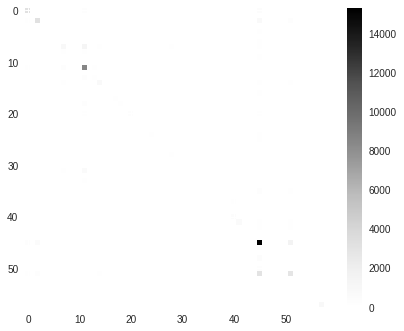

<Figure size 576x396 with 0 Axes>

In [46]:
# Create dicts to convert y vectors back to strings
vec_to_string = {}
for key in one_hot_encoding_dic.keys():
    vec_to_string[one_hot_encoding_dic[key].argmax()] = key

y_pred_strings = []
for vec in y_pred_new:
    y_pred_strings.append(vec_to_string[vec])

y_test_strings = []
for vec in y_labels:
    y_test_strings.append(vec_to_string[vec.argmax()])
print(len(y_test_strings))
print(len(y_pred_strings))
    
cm = confusion_matrix(y_test_strings,y_pred_strings, labels=one_hot_encoding_dic.keys())
brAccuracy = float(cm[brConfusionMatrixIndex][brConfusionMatrixIndex] )/ float(brTotal)
bfAccuracy = float(cm[bfConfusionMatrixIndex][bfConfusionMatrixIndex]) / float(bfTotal)
sdAccuracy = float(cm[sdConfusionMatrixIndex][sdConfusionMatrixIndex]) / float(sdTotal)
print(f"br Accuracy: {brAccuracy}, bf accuracy: {bfAccuracy},sd Accuracy: {sdAccuracy} ")
print(f"Overall accuracy: {np.diag(cm).sum()*100.0 / len(y_labels)}")

brCommonMistakes = cm[brConfusionMatrixIndex]
brTop5MistakesIndices = brCommonMistakes.argsort()[-5:]
print("The br was most commonly confused with: ")
for index in brTop5MistakesIndices:
  if index == brConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])

bfCommonMistakes = cm[bfConfusionMatrixIndex]
bfTop5MistakesIndices = bfCommonMistakes.argsort()[-5:]
print("The bf was most commonly confused with: ")
for index in bfTop5MistakesIndices:
  if index == bfConfusionMatrixIndex:
    continue
  print(one_hot_encoding_dic.keys()[index])

# br and overall accuracies are worse than the original model (without class weighting). It makes a very slight improvement on bf accuracy of the original non-weighted model. 
# Overall test accuracy was 67%. It's suprising that this model has performed worse given the context and hierachical approach. 
# It may be the case that it requires more training before it is able to utilise these advantages
# One positive example where this model performed better is the correct identification of the bf prediction

plt.imshow(cm)
plt.colorbar()

plt.show()

plt.savefig("/content/gdrive/My Drive/confusionmatrix.png")

Compared to the baseline using BiLSTM for utterance classification, the second method effectively leverage context information and achieve better performance. Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.




## Advanced: Creating End-To-End Dialogue System

Please see the notebook: Lab10-colabversion-end-to-end-dialogue.ipynb for my attempt at this. 